# Face Detection

Hello! In this task you will create your own deep face detector.

First of all, we need import some useful stuff.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Do you have modern Nvidia [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit)? There is your video-card model in [list](https://developer.nvidia.com/cuda-gpus) and CUDA capability >= 3.0?

- Yes. You can use it for fast deep learning! In this work we recommend you use tensorflow backend with GPU. Read [installation notes](https://www.tensorflow.org/install/) with attention to gpu section, install all requirements and then install GPU version `tensorflow-gpu`.
- No. CPU is enough for this task, but you have to use only simple model. Read [installation notes](https://www.tensorflow.org/install/) and install CPU version `tensorflow`.

Of course, also you should install `keras`, `matplotlib`, `numpy` and `scikit-image`.

In [2]:
from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import transform
import cv2

In [4]:
from get_data import load_dataset, unpack

In this task we use processed [FDDB dataset](http://vis-www.cs.umass.edu/fddb/). Processing defined in file [./prepare_data.ipynb](prepare_data.ipynb) and consists of:

1. Extract bboxes from dataset. In base dataset face defined by [ellipsis](http://vis-www.cs.umass.edu/fddb/samples/) that not very useful for basic neural network learning.
2. Remove images with big and small faces on one shoot.
3. Re-size images to bounding boxes (bboxes) have same size 32 +/- pixels.

Each image in train, validation and test datasets have shape (176, 176, 3), but part of this image is black background. Interesting image aligned at top left corner.

Bounding boxes define face in image and consist of 7 integer numbers: [image_index, min_row, min_col, max_row, max_col]. Bounding box width and height are 32 +/- 8 pixels wide.

`train_bboxes` and `val_bboxes` is a list of bboxes.

`train_shapes` and `val_shapes` is a list of interesting image shapes.

In [5]:
# First run will download 30 MB data from github

train_images, train_bboxes, train_shapes = load_dataset("train")
val_images, val_bboxes, val_shapes = load_dataset("val")

## Prepare data (1 point)

Visualize first image from train dataset with face bounding box rectangle. Note that true shape of image is stored in another array.

In [6]:
# check that train_bboxes is sorted by image index
current_image_idx = 0
is_sorted = True
for image_idx, _, _, _, _ in train_bboxes:
    if current_image_idx == image_idx or current_image_idx == image_idx - 1:
        current_image_idx = image_idx
    else:
        is_sorted = False
        break
print('Sorted' if is_sorted else 'Not sorted')

Sorted


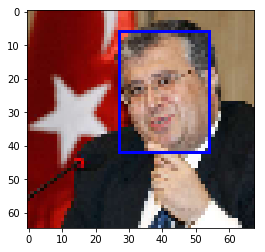

In [7]:
image_idx = 0
image = train_images[image_idx].copy()
for idx, min_row, min_col, max_row, max_col in train_bboxes:
    if idx == image_idx:
        image = cv2.rectangle(image,
                              (min_col, min_row),
                              (max_col, max_row),
                              (0, 0, 255),
                              1)
plt.imshow(image[0:train_shapes[0, 0], 0:train_shapes[0, 1], :])

For learning we should extract positive and negative samples from image.
Positive and negative samples counts should be similar.
Every samples should have same size.
Positive sample is actual face resized to target shape, negative one should is some cropped not face region also resized to target shape

In [8]:
SAMPLE_SHAPE = (32, 32, 3)

Use this function to detect that your negative bounding box is not a face

In [9]:
from scores import iou_score  # https://en.wikipedia.org/wiki/Jaccard_index


def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    """There bbox is 4 ints [min_row, min_col, max_row, max_col] without image index."""
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

In [10]:
def get_positive_negative(images, true_bboxes, image_shapes):
    """Retrieve positive and negative samples from image."""
    positive = []
    negative = []
    
    # Pay attention to the fact that most part of image may be black -
    # extract negative samples only from part [0:image_shape[0], 0:image_shape[1]]
    
    true_bboxes_finish = 0
    for image_idx, image in enumerate(images):
        true_bboxes_start = true_bboxes_finish
        while true_bboxes_finish + 1 < len(true_bboxes):
            true_bboxes_finish += 1
            if true_bboxes[true_bboxes_finish, 0] != true_bboxes[true_bboxes_start, 0]:
                break
        true_bboxes_count = true_bboxes_finish - true_bboxes_start
        positive.extend([cv2.resize(image[min_row:max_row, min_col:max_col, :], SAMPLE_SHAPE[:-1])
                         for _, min_row, min_col, max_row, max_col in true_bboxes[true_bboxes_start:true_bboxes_finish]])

        negative_new = []
        true_bboxes_of_image = [bbox[1:] for bbox in true_bboxes[true_bboxes_start:true_bboxes_finish]]
        while len(negative_new) < true_bboxes_count:
            crop_size = np.random.randint(8, 33)
            if is_negative_bbox((0, 0, crop_size, crop_size), true_bboxes_of_image):
                crop = image[0:crop_size, 0:crop_size]
                negative_new.append(cv2.resize(crop, SAMPLE_SHAPE[:-1]))
        negative.extend(negative_new)
    assert len(positive) == len(negative), 'Number of negative and positive samples differ'
    return positive, negative

In [11]:
def get_samples(images, true_bboxes, image_shapes):
    """Usefull samples for learning.
    
    X - positive and negative samples.
    Y - one hot encoded list of zeros and ones. One is positive marker.
    """
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, 
                                               image_shapes=image_shapes)
    X = positive
    Y = [[0, 1] for _ in range(len(positive))]
    
    X.extend(negative)
    Y.extend([[1, 0] for _ in range(len(negative))])
    
    return np.array(X), np.array(Y)

Now we can extract samples from images.

In [12]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)

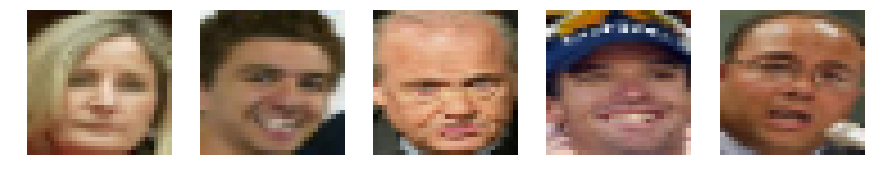

In [13]:
# There we should see faces
from graph import visualize_samples
visualize_samples(X_train[Y_train[:, 1] == 1])

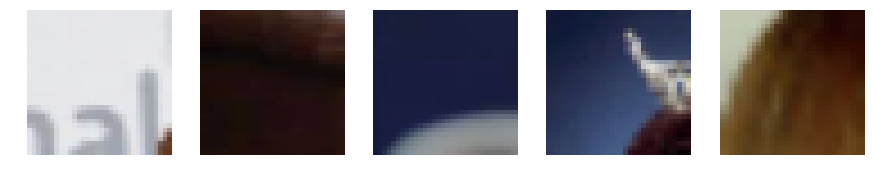

In [14]:
# There we shouldn't see faces
visualize_samples(X_train[Y_train[:, 1] == 0])

## Classifier training (3 points)

First of all, we should train face classifier that checks if face represented on sample.

In [15]:
BATCH_SIZE = 64

### Image augmentation

Important thing in deep learning is augmentation. Sometimes, if your model are complex and cool, you can increase quality by using good augmentation.

Keras provide good [images preprocessing and augmentation](https://keras.io/preprocessing/image/). This preprocessing executes online (on the fly) while learning.

Of course, if you want using samplewise and featurewise center and std normalization you should run this transformation on predict stage. But you will use this classifier to fully convolution detector, in this case such transformation quite complicated, and we don't recommend use them in classifier.

For heavy augmentation you can use library [imgaug](https://github.com/aleju/imgaug). If you need, you can use this library in offline manner (simple way) and online manner (hard way). However, hard way is not so hard: you only have to write [python generator](https://wiki.python.org/moin/Generators), which returns image batches, and pass it to [fit_generator](https://keras.io/models/model/#fit_generator)

In [16]:
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1,
                             rotation_range=2,
                             shear_range=0.1)
datagen.fit(X_train)

### Fitting classifier

For fitting you can use one of Keras optimizer algorithms. [Good overview](http://ruder.io/optimizing-gradient-descent/)

To choose best learning rate strategy you should read about EarlyStopping and ReduceLROnPlateau or LearningRateScheduler on [callbacks](https://keras.io/callbacks/) page of keras documentation, it's very useful in deep learning.

If you repeat architecture from some paper, you can find information about good optimizer algorithm and learning rate strategy in this paper. For example, every [keras application](https://keras.io/applications/) has link to paper, that describes suitable learning procedure for this specific architecture.

In [20]:
from keras.optimizers import RMSprop
# Very usefull, pay attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from graph import plot_history


def fit(model_name, model, datagen, X_train, Y_train, X_val, Y_val, class_weight=None, epochs=10, lr=0.001,
        verbose=False):
    """Fit model.
    
    You can edit this function anyhow.
    """
    
    if verbose:
        model.summary()

    model.compile(optimizer=RMSprop(lr=lr),  # You can use another optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                                  validation_data=(X_val, Y_val),
                                  epochs=epochs, steps_per_epoch=len(X_train) // BATCH_SIZE * 10,
                                  callbacks=[ReduceLROnPlateau(patience=2)])  # starts training
    model.save_weights(f'{model_name}_weights')
    plot_history(history)

#### (first point out of three)

We propose you make your own classification model based on lenet architecture.

![lenet architecture](lenet_architecture.png)
LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P., 1998. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278-2324.

Of course, you can use any another architecture, if want. Main thing is classification quality of your model.

Acceptable validation accuracy for this task is 0.92.

In [23]:
from keras.models import Model
from keras.layers import Flatten, Dense, Activation, Input, Dropout, BatchNormalization, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Classification model
# You can start from LeNet architecture

x = inputs = Input(shape=SAMPLE_SHAPE)

x = Conv2D(32, (3, 3), padding='same', strides=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(16, (1, 1), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU(0.1)(x)

x = Conv2D(16, (1, 1), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Dropout(0.1)(x)

x = Conv2D(32, (1, 1), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, (1, 1), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(0.1)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Dropout(0.1)(x)

x = Flatten()(x)
# This creates a model
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 16)        528       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 16)        0         
__________

#### Fit the model (second point out of three)

If you doesn't have fast video-card suitable for deep learning, you can first check neural network modifications with small value of parameter `epochs`, for example, 10, and then after selecting best model increase this parameter.
Fitting on CPU can be long, we suggest do it at bedtime.

Don't forget change model name.

Epoch 1/50


  1/320 [..............................] - ETA: 274s - loss: 1.4895 - acc: 0.5000

  5/320 [..............................] - ETA: 58s - loss: 2.8930 - acc: 0.5500 

  9/320 [..............................] - ETA: 34s - loss: 1.9194 - acc: 0.5399

 13/320 [>.............................] - ETA: 24s - loss: 1.5547 - acc: 0.5421

 16/320 [>.............................] - ETA: 20s - loss: 1.3959 - acc: 0.5469

 19/320 [>.............................] - ETA: 18s - loss: 1.2833 - acc: 0.5567

 22/320 [=>............................] - ETA: 16s - loss: 1.1966 - acc: 0.5689

 24/320 [=>............................] - ETA: 15s - loss: 1.1504 - acc: 0.5736

 26/320 [=>............................] - ETA: 15s - loss: 1.1142 - acc: 0.5751

 28/320 [=>............................] - ETA: 14s - loss: 1.0761 - acc: 0.5859

 30/320 [=>............................] - ETA: 14s - loss: 1.0384 - acc: 0.5953

 32/320 [==>...........................] - ETA: 13s - loss: 1.0474 - acc: 0.5952

 33/320 [==>...........................] - ETA: 13s - loss: 1.0355 - acc: 0.5935

 36/320 [==>...........................] - ETA: 12s - loss: 1.0032 - acc: 0.5979

 38/320 [==>...........................] - ETA: 12s - loss: 0.9845 - acc: 0.6018

 40/320 [==>...........................] - ETA: 12s - loss: 0.9678 - acc: 0.6014

 42/320 [==>...........................] - ETA: 11s - loss: 0.9492 - acc: 0.6069

 44/320 [===>..........................] - ETA: 11s - loss: 0.9305 - acc: 0.6124

 46/320 [===>..........................] - ETA: 11s - loss: 0.9169 - acc: 0.6139

 48/320 [===>..........................] - ETA: 11s - loss: 0.9038 - acc: 0.6170

 50/320 [===>..........................] - ETA: 11s - loss: 0.8878 - acc: 0.6242

 52/320 [===>..........................] - ETA: 10s - loss: 0.8839 - acc: 0.6236

 55/320 [====>.........................] - ETA: 10s - loss: 0.8696 - acc: 0.6260



 57/320 [====>.........................] - ETA: 10s - loss: 0.8585 - acc: 0.6303

 60/320 [====>.........................] - ETA: 10s - loss: 0.8423 - acc: 0.6363

 62/320 [====>.........................] - ETA: 9s - loss: 0.8303 - acc: 0.6397 

 64/320 [=====>........................] - ETA: 9s - loss: 0.8200 - acc: 0.6422

 66/320 [=====>........................] - ETA: 9s - loss: 0.8067 - acc: 0.6489

 68/320 [=====>........................] - ETA: 9s - loss: 0.8028 - acc: 0.6496

 70/320 [=====>........................] - ETA: 9s - loss: 0.8063 - acc: 0.6500

 72/320 [=====>........................] - ETA: 9s - loss: 0.7978 - acc: 0.6545

 75/320 [======>.......................] - ETA: 9s - loss: 0.7819 - acc: 0.6621

 77/320 [======>.......................] - ETA: 8s - loss: 0.7747 - acc: 0.6650

 79/320 [======>.......................] - ETA: 8s - loss: 0.7638 - acc: 0.6693

 81/320 [======>.......................] - ETA: 8s - loss: 0.7714 - acc: 0.6680

 83/320 [======>.......................] - ETA: 8s - loss: 0.7641 - acc: 0.6721

 85/320 [======>.......................] - ETA: 8s - loss: 0.7569 - acc: 0.6748

 87/320 [=======>......................] - ETA: 8s - loss: 0.7473 - acc: 0.6793

 89/320 [=======>......................] - ETA: 8s - loss: 0.7406 - acc: 0.6815

 91/320 [=======>......................] - ETA: 8s - loss: 0.7328 - acc: 0.6851

 94/320 [=======>......................] - ETA: 7s - loss: 0.7192 - acc: 0.6908

 96/320 [========>.....................] - ETA: 7s - loss: 0.7117 - acc: 0.6945

 98/320 [========>.....................] - ETA: 7s - loss: 0.7086 - acc: 0.6955

100/320 [========>.....................] - ETA: 7s - loss: 0.7014 - acc: 0.6995

101/320 [========>.....................] - ETA: 7s - loss: 0.6986 - acc: 0.7011

104/320 [========>.....................] - ETA: 7s - loss: 0.6869 - acc: 0.7069

106/320 [========>.....................] - ETA: 7s - loss: 0.6791 - acc: 0.7106

108/320 [=========>....................] - ETA: 7s - loss: 0.6730 - acc: 0.7135

110/320 [=========>....................] - ETA: 7s - loss: 0.6668 - acc: 0.7156

112/320 [=========>....................] - ETA: 7s - loss: 0.6599 - acc: 0.7185

114/320 [=========>....................] - ETA: 7s - loss: 0.6554 - acc: 0.7211

116/320 [=========>....................] - ETA: 7s - loss: 0.6490 - acc: 0.7237

118/320 [==========>...................] - ETA: 6s - loss: 0.6427 - acc: 0.7263

120/320 [==========>...................] - ETA: 6s - loss: 0.6351 - acc: 0.7298

122/320 [==========>...................] - ETA: 6s - loss: 0.6276 - acc: 0.7333

124/320 [==========>...................] - ETA: 6s - loss: 0.6198 - acc: 0.7369

126/320 [==========>...................] - ETA: 6s - loss: 0.6150 - acc: 0.7388

128/320 [===========>..................] - ETA: 6s - loss: 0.6219 - acc: 0.7372

130/320 [===========>..................] - ETA: 6s - loss: 0.6166 - acc: 0.7395

132/320 [===========>..................] - ETA: 6s - loss: 0.6110 - acc: 0.7424

134/320 [===========>..................] - ETA: 6s - loss: 0.6052 - acc: 0.7451

136/320 [===========>..................] - ETA: 6s - loss: 0.5990 - acc: 0.7481

138/320 [===========>..................] - ETA: 6s - loss: 0.5927 - acc: 0.7510

140/320 [============>.................] - ETA: 6s - loss: 0.5873 - acc: 0.7537

142/320 [============>.................] - ETA: 5s - loss: 0.5827 - acc: 0.7558

144/320 [============>.................] - ETA: 5s - loss: 0.5791 - acc: 0.7575

146/320 [============>.................] - ETA: 5s - loss: 0.5733 - acc: 0.7604

148/320 [============>.................] - ETA: 5s - loss: 0.5679 - acc: 0.7629

150/320 [=============>................] - ETA: 5s - loss: 0.5636 - acc: 0.7650

152/320 [=============>................] - ETA: 5s - loss: 0.5579 - acc: 0.7676

155/320 [=============>................] - ETA: 5s - loss: 0.5504 - acc: 0.7709



157/320 [=============>................] - ETA: 5s - loss: 0.5445 - acc: 0.7736

159/320 [=============>................] - ETA: 5s - loss: 0.5408 - acc: 0.7755

161/320 [==============>...............] - ETA: 5s - loss: 0.5390 - acc: 0.7766

163/320 [==============>...............] - ETA: 5s - loss: 0.5375 - acc: 0.7774

165/320 [==============>...............] - ETA: 5s - loss: 0.5336 - acc: 0.7793

167/320 [==============>...............] - ETA: 5s - loss: 0.5296 - acc: 0.7812

169/320 [==============>...............] - ETA: 4s - loss: 0.5251 - acc: 0.7832



171/320 [===============>..............] - ETA: 4s - loss: 0.5212 - acc: 0.7850

173/320 [===============>..............] - ETA: 4s - loss: 0.5171 - acc: 0.7868

175/320 [===============>..............] - ETA: 4s - loss: 0.5121 - acc: 0.7892

177/320 [===============>..............] - ETA: 4s - loss: 0.5085 - acc: 0.7908

179/320 [===============>..............] - ETA: 4s - loss: 0.5040 - acc: 0.7928

181/320 [===============>..............] - ETA: 4s - loss: 0.4994 - acc: 0.7948

183/320 [================>.............] - ETA: 4s - loss: 0.4966 - acc: 0.7959

186/320 [================>.............]

 - ETA: 4s - loss: 0.4924 - acc: 0.7979



188/320 [================>.............] - ETA: 4s - loss: 0.4886 - acc: 0.7994

190/320 [================>.............] - ETA: 4s - loss: 0.4852 - acc: 0.8009

192/320 [=================>............] - ETA: 4s - loss: 0.4809 - acc: 0.8029

195/320 [=================>............] - ETA: 4s - loss: 0.4760 - acc: 0.8050



197/320 [=================>............] - ETA: 3s - loss: 0.4730 - acc: 0.8065

200/320 [=================>............] - ETA: 3s - loss: 0.4687 - acc: 0.8084

202/320 [=================>............] - ETA: 3s - loss: 0.4650 - acc: 0.8100



204/320 [==================>...........] - ETA: 3s - loss: 0.4613 - acc: 0.8117

206/320 [==================>...........] - ETA: 3s - loss: 0.4574 - acc: 0.8133



208/320 [==================>...........] - ETA: 3s - loss: 0.4549 - acc: 0.8144

210/320 [==================>...........] - ETA: 3s - loss: 0.4514 - acc: 0.8159

212/320 [==================>...........] - ETA: 3s - loss: 0.4476 - acc: 0.8176

214/320 [===================>..........] - ETA: 3s - loss: 0.4443 - acc: 0.8189

216/320 [===================>..........] - ETA: 3s - loss: 0.4416 - acc: 0.8202

218/320 [===================>..........] - ETA: 3s - loss: 0.4386 - acc: 0.8215

220/320 [===================>..........] - ETA: 3s - loss: 0.4367 - acc: 0.8222

222/320 [===================>..........] - ETA: 3s - loss: 0.4341 - acc: 0.8233

224/320 [====================>.........] - ETA: 3s - loss: 0.4306 - acc: 0.8249

226/320 [====================>.........] - ETA: 3s - loss: 0.4277 - acc: 0.8261

228/320 [====================>.........] - ETA: 2s - loss: 0.4253 - acc: 0.8272

230/320 [====================>.........] - ETA: 2s - loss: 0.4232 - acc: 0.8279

233/320 [====================>.........] - ETA: 2s - loss: 0.4196 - acc: 0.8296

235/320 [=====================>........] - ETA: 2s - loss: 0.4166 - acc: 0.8309

237/320 [=====================>........] - ETA: 2s - loss: 0.4153 - acc: 0.8316

239/320 [=====================>........] - ETA: 2s - loss: 0.4143 - acc: 0.8323

241/320 [=====================>........] - ETA: 2s - loss: 0.4114 - acc: 0.8335

243/320 [=====================>........] - ETA: 2s - loss: 0.4083 - acc: 0.8348

246/320 [======================>.......] - ETA: 2s - loss: 0.4050 - acc: 0.8364



248/320 [======================>.......] - ETA: 2s - loss: 0.4022 - acc: 0.8376

250/320 [======================>.......] - ETA: 2s - loss: 0.4005 - acc: 0.8383

252/320 [======================>.......] - ETA: 2s - loss: 0.3992 - acc: 0.8391

254/320 [======================>.......] - ETA: 2s - loss: 0.3967 - acc: 0.8402

256/320 [=======================>......] - ETA: 2s - loss: 0.3942 - acc: 0.8413

258/320 [=======================>......] - ETA: 1s - loss: 0.3920 - acc: 0.8422

260/320 [=======================>......] - ETA: 1s - loss: 0.3901 - acc: 0.8431

262/320 [=======================>......] - ETA: 1s - loss: 0.3878 - acc: 0.8441

265/320 [=======================>......] - ETA: 1s - loss: 0.3836 - acc: 0.8458

267/320 [========================>.....] - ETA: 1s - loss: 0.3813 - acc: 0.8467

269/320 [========================>.....] - ETA: 1s - loss: 0.3803 - acc: 0.8473

271/320 [========================>.....] - ETA: 1s - loss: 0.3780 - acc: 0.8483

273/320 [========================>.....] - ETA: 1s - loss: 0.3761 - acc: 0.8491

275/320 [========================>.....] - ETA: 1s - loss: 0.3740 - acc: 0.8500

278/320 [=========================>....] - ETA: 1s - loss: 0.3706 - acc: 0.8513

280/320 [=========================>....] - ETA: 1s - loss: 0.3688 - acc: 0.8521

282/320 [=========================>....] - ETA: 1s - loss: 0.3668 - acc: 0.8530

284/320 [=========================>....] - ETA: 1s - loss: 0.3646 - acc: 0.8539

286/320 [=========================>....] - ETA: 1s - loss: 0.3626 - acc: 0.8546

288/320 [==========================>...] - ETA: 1s - loss: 0.3602 - acc: 0.8556

291/320 [==========================>...] - ETA: 0s - loss: 0.3569 - acc: 0.8569

293/320 [==========================>...] - ETA: 0s - loss: 0.3564 - acc: 0.8574

295/320 [==========================>...] - ETA: 0s - loss: 0.3560 - acc: 0.8574

298/320 [==========================>...] - ETA: 0s - loss: 0.3544 - acc: 0.8581

300/320 [===========================>..] - ETA: 0s - loss: 0.3523 - acc: 0.8589

302/320 [===========================>..] - ETA: 0s - loss: 0.3508 - acc: 0.8597

304/320 [===========================>..] - ETA: 0s - loss: 0.3494 - acc: 0.8604

306/320 [===========================>..] - ETA: 0s - loss: 0.3476 - acc: 0.8611

308/320 [===========================>..] - ETA: 0s - loss: 0.3455 - acc: 0.8619

310/320 [============================>.] - ETA: 0s - loss: 0.3437 - acc: 0.8626

312/320 [============================>.] - ETA: 0s - loss: 0.3422 - acc: 0.8633

314/320 [============================>.] - ETA: 0s - loss: 0.3406 - acc: 0.8641

316/320 [============================>.] - ETA: 0s - loss: 0.3390 - acc: 0.8648

319/320 [============================>.] - ETA: 0s - loss: 0.3368 - acc: 0.8656

320/320 [==============================] - 10s - loss: 0.3358 - acc: 0.8660 - val_loss: 0.0579 - val_acc: 0.9803


Epoch 2/50
  1/320 [..............................] - ETA: 4s - loss: 0.0516 - acc: 0.9688

  5/320 [..............................] - ETA: 4s - loss: 0.1399 - acc: 0.9406

  8/320 [..............................] - ETA: 4s - loss: 0.1146 - acc: 0.9512

 11/320 [>.............................] - ETA: 5s - loss: 0.1000 - acc: 0.9602

 13/320 [>.............................] - ETA: 5s - loss: 0.1038 - acc: 0.9603

 15/320 [>.............................] - ETA: 6s - loss: 0.0956 - acc: 0.9635



 18/320 [>.............................] - ETA: 6s - loss: 0.0904 - acc: 0.9661

 20/320 [>.............................] - ETA: 7s - loss: 0.0887 - acc: 0.9672

 22/320 [=>............................] - ETA: 7s - loss: 0.0853 - acc: 0.9688

 24/320 [=>............................] - ETA: 7s - loss: 0.0888 - acc: 0.9668

 26/320 [=>............................] - ETA: 7s - loss: 0.0862 - acc: 0.9675

 28/320 [=>............................] - ETA: 7s - loss: 0.0868 - acc: 0.9671

 30/320 [=>............................] - ETA: 7s - loss: 0.0921 - acc: 0.9656

 32/320 [==>...........................] - ETA: 7s - loss: 0.0945 - acc: 0.9644

 34/320 [==>...........................] - ETA: 7s - loss: 0.0933 - acc: 0.9651

 35/320 [==>...........................] - ETA: 7s - loss: 0.0940 - acc: 0.9647

 37/320 [==>...........................] - ETA: 7s - loss: 0.0940 - acc: 0.9649

 39/320 [==>...........................] - ETA: 8s - loss: 0.0975 - acc: 0.9643

 40/320 [==>...........................] - ETA: 8s - loss: 0.1014 - acc: 0.9629

 41/320 [==>...........................] - ETA: 8s - loss: 0.1021 - acc: 0.9623

 43/320 [===>..........................] - ETA: 8s - loss: 0.1006 - acc: 0.9632

 46/320 [===>..........................] - ETA: 8s - loss: 0.1012 - acc: 0.9626

 48/320 [===>..........................] - ETA: 8s - loss: 0.0992 - acc: 0.9631

 50/320 [===>..........................] - ETA: 8s - loss: 0.0967 - acc: 0.9643

 52/320 [===>..........................] - ETA: 8s - loss: 0.0983 - acc: 0.9639

 55/320 [====>.........................] - ETA: 8s - loss: 0.0960 - acc: 0.9641

 57/320 [====>.........................] - ETA: 7s - loss: 0.0952 - acc: 0.9643

 59/320 [====>.........................] - ETA: 7s - loss: 0.0949 - acc: 0.9645

 61/320 [====>.........................] - ETA: 7s - loss: 0.0928 - acc: 0.9651

 63/320 [====>.........................] - ETA: 7s - loss: 0.0902 - acc: 0.9662

 65/320 [=====>........................] - ETA: 7s - loss: 0.0904 - acc: 0.9665

 67/320 [=====>........................] - ETA: 7s - loss: 0.0902 - acc: 0.9666

 69/320 [=====>........................] - ETA: 7s - loss: 0.0892 - acc: 0.9671

 71/320 [=====>........................] - ETA: 7s - loss: 0.0897 - acc: 0.9669

 73/320 [=====>........................] - ETA: 7s - loss: 0.0897 - acc: 0.9672

 75/320 [======>.......................] - ETA: 7s - loss: 0.0882 - acc: 0.9679

 77/320 [======>.......................] - ETA: 7s - loss: 0.0894 - acc: 0.9676

 79/320 [======>.......................] - ETA: 7s - loss: 0.0884 - acc: 0.9678

 81/320 [======>.......................] - ETA: 7s - loss: 0.0867 - acc: 0.9684

 83/320 [======>.......................] - ETA: 7s - loss: 0.0867 - acc: 0.9686

 85/320 [======>.......................] - ETA: 7s - loss: 0.0865 - acc: 0.9684

 87/320 [=======>......................] - ETA: 6s - loss: 0.0858 - acc: 0.9686

 89/320 [=======>......................] - ETA: 6s - loss: 0.0858 - acc: 0.9686

 91/320 [=======>......................] - ETA: 6s - loss: 0.0852 - acc: 0.9690

 93/320 [=======>......................] - ETA: 6s - loss: 0.0842 - acc: 0.9693

 95/320 [=======>......................] - ETA: 6s - loss: 0.0832 - acc: 0.9696

 97/320 [========>.....................] - ETA: 6s - loss: 0.0842 - acc: 0.9691

 99/320 [========>.....................] - ETA: 6s - loss: 0.0896 - acc: 0.9675

101/320 [========>.....................] - ETA: 6s - loss: 0.0905 - acc: 0.9671

103/320 [========>.....................] - ETA: 6s - loss: 0.0903 - acc: 0.9671

105/320 [========>.....................] - ETA: 6s - loss: 0.0903 - acc: 0.9667

107/320 [=========>....................] - ETA: 6s - loss: 0.0896 - acc: 0.9670

109/320 [=========>....................] - ETA: 6s - loss: 0.0890 - acc: 0.9674

111/320 [=========>....................] - ETA: 6s - loss: 0.0884 - acc: 0.9677

113/320 [=========>....................] - ETA: 6s - loss: 0.0881 - acc: 0.9677

115/320 [=========>....................] - ETA: 6s - loss: 0.0881 - acc: 0.9678

117/320 [=========>....................] - ETA: 6s - loss: 0.0872 - acc: 0.9683

119/320 [==========>...................] - ETA: 5s - loss: 0.0865 - acc: 0.9683

121/320 [==========>...................] - ETA: 5s - loss: 0.0869 - acc: 0.9680

123/320 [==========>...................] - ETA: 5s - loss: 0.0872 - acc: 0.9679

125/320 [==========>...................] - ETA: 5s - loss: 0.0873 - acc: 0.9679

127/320 [==========>...................] - ETA: 5s - loss: 0.0876 - acc: 0.9677



130/320 [===========>..................] - ETA: 5s - loss: 0.0871 - acc: 0.9681

132/320 [===========>..................] - ETA: 5s - loss: 0.0864 - acc: 0.9682

134/320 [===========>..................] - ETA: 5s - loss: 0.0859 - acc: 0.9684

136/320 [===========>..................] - ETA: 5s - loss: 0.0859 - acc: 0.9684

138/320 [===========>..................] - ETA: 5s - loss: 0.0851 - acc: 0.9688

140/320 [============>.................] - ETA: 5s - loss: 0.0843 - acc: 0.9691

142/320 [============>.................] - ETA: 5s - loss: 0.0849 - acc: 0.9692

145/320 [============>.................] - ETA: 5s - loss: 0.0845 - acc: 0.9695

147/320 [============>.................] - ETA: 5s - loss: 0.0840 - acc: 0.9695

149/320 [============>.................] - ETA: 5s - loss: 0.0846 - acc: 0.9695

151/320 [=============>................] - ETA: 4s - loss: 0.0839 - acc: 0.9697

153/320 [=============>................] - ETA: 4s - loss: 0.0835 - acc: 0.9700

155/320 [=============>................] - ETA: 4s - loss: 0.0851 - acc: 0.9691

157/320 [=============>................] - ETA: 4s - loss: 0.0846 - acc: 0.9693

159/320 [=============>................] - ETA: 4s - loss: 0.0860 - acc: 0.9689

161/320 [==============>...............] - ETA: 4s - loss: 0.0853 - acc: 0.9692

163/320 [==============>...............] - ETA: 4s - loss: 0.0847 - acc: 0.9694

166/320 [==============>...............] - ETA: 4s - loss: 0.0848 - acc: 0.9694

168/320 [==============>...............] - ETA: 4s - loss: 0.0842 - acc: 0.9697

170/320 [==============>...............] - ETA: 4s - loss: 0.0837 - acc: 0.9698

172/320 [===============>..............] - ETA: 4s - loss: 0.0879 - acc: 0.9691

174/320 [===============>..............] - ETA: 4s - loss: 0.0888 - acc: 0.9687

176/320 [===============>..............] - ETA: 4s - loss: 0.0885 - acc: 0.9688

178/320 [===============>..............] - ETA: 4s - loss: 0.0879 - acc: 0.9690

181/320 [===============>..............] - ETA: 4s - loss: 0.0876 - acc: 0.9690

183/320 [================>.............] - ETA: 4s - loss: 0.0872 - acc: 0.9693

185/320 [================>.............] - ETA: 3s - loss: 0.0867 - acc: 0.9694

187/320 [================>.............] - ETA: 3s - loss: 0.0862 - acc: 0.9696

189/320 [================>.............] - ETA: 3s - loss: 0.0858 - acc: 0.9698

191/320 [================>.............] - ETA: 3s - loss: 0.0860 - acc: 0.9699

193/320 [=================>............] - ETA: 3s - loss: 0.0861 - acc: 0.9699

195/320 [=================>............] - ETA: 3s - loss: 0.0869 - acc: 0.9696

197/320 [=================>............] - ETA: 3s - loss: 0.0863 - acc: 0.9698

199/320 [=================>............] - ETA: 3s - loss: 0.0861 - acc: 0.9698

201/320 [=================>............] - ETA: 3s - loss: 0.0858 - acc: 0.9700



203/320 [==================>...........] - ETA: 3s - loss: 0.0873 - acc: 0.9695

205/320 [==================>...........] - ETA: 3s - loss: 0.0868 - acc: 0.9697



207/320 [==================>...........] - ETA: 3s - loss: 0.0863 - acc: 0.9700

209/320 [==================>...........] - ETA: 3s - loss: 0.0863 - acc: 0.9700

211/320 [==================>...........] - ETA: 3s - loss: 0.0858 - acc: 0.9702



213/320 [==================>...........] - ETA: 3s - loss: 0.0856 - acc: 0.9702

215/320 [===================>..........] - ETA: 3s - loss: 0.0858 - acc: 0.9701

217/320 [===================>..........] - ETA: 3s - loss: 0.0857 - acc: 0.9702

219/320 [===================>..........] - ETA: 3s - loss: 0.0853 - acc: 0.9704

221/320 [===================>..........] - ETA: 2s - loss: 0.0854 - acc: 0.9703

223/320 [===================>..........] - ETA: 2s - loss: 0.0851 - acc: 0.9704

225/320 [====================>.........] - ETA: 2s - loss: 0.0848 - acc: 0.9705

227/320 [====================>.........] - ETA: 2s - loss: 0.0846 - acc: 0.9705

229/320 [====================>.........] - ETA: 2s - loss: 0.0848 - acc: 0.9704

231/320 [====================>.........] - ETA: 2s - loss: 0.0846 - acc: 0.9706

233/320 [====================>.........] - ETA: 2s - loss: 0.0841 - acc: 0.9706

235/320 [=====================>........] - ETA: 2s - loss: 0.0844 - acc: 0.9705

237/320 [=====================>........] - ETA: 2s - loss: 0.0847 - acc: 0.9704

239/320 [=====================>........] - ETA: 2s - loss: 0.0847 - acc: 0.9704

241/320 [=====================>........] - ETA: 2s - loss: 0.0848 - acc: 0.9704

243/320 [=====================>........] - ETA: 2s - loss: 0.0846 - acc: 0.9706

245/320 [=====================>........] - ETA: 2s - loss: 0.0841 - acc: 0.9708

247/320 [======================>.......] - ETA: 2s - loss: 0.0842 - acc: 0.9706

250/320 [======================>.......] - ETA: 2s - loss: 0.0836 - acc: 0.9708

252/320 [======================>.......] - ETA: 2s - loss: 0.0838 - acc: 0.9708

254/320 [======================>.......] - ETA: 1s - loss: 0.0835 - acc: 0.9709

256/320 [=======================>......] - ETA: 1s - loss: 0.0831 - acc: 0.9710

258/320 [=======================>......] - ETA: 1s - loss: 0.0829 - acc: 0.9711

260/320 [=======================>......] - ETA: 1s - loss: 0.0830 - acc: 0.9711

262/320 [=======================>......] - ETA: 1s - loss: 0.0827 - acc: 0.9712

264/320 [=======================>......] - ETA: 1s - loss: 0.0825 - acc: 0.9713

266/320 [=======================>......] - ETA: 1s - loss: 0.0829 - acc: 0.9711

268/320 [========================>.....] - ETA: 1s - loss: 0.0825 - acc: 0.9712

270/320 [========================>.....] - ETA: 1s - loss: 0.0820 - acc: 0.9714

272/320 [========================>.....] - ETA: 1s - loss: 0.0830 - acc: 0.9711

275/320 [========================>.....] - ETA: 1s - loss: 0.0831 - acc: 0.9709

277/320 [========================>.....] - ETA: 1s - loss: 0.0829 - acc: 0.9709

279/320 [=========================>....] - ETA: 1s - loss: 0.0825 - acc: 0.9710

281/320 [=========================>....] - ETA: 1s - loss: 0.0824 - acc: 0.9710

283/320 [=========================>....] - ETA: 1s - loss: 0.0820 - acc: 0.9711

285/320 [=========================>....] - ETA: 1s - loss: 0.0817 - acc: 0.9713



286/320 [=========================>....] - ETA: 1s - loss: 0.0819 - acc: 0.9713

288/320 [==========================>...] - ETA: 0s - loss: 0.0816 - acc: 0.9713

290/320 [==========================>...] - ETA: 0s - loss: 0.0814 - acc: 0.9714

292/320 [==========================>...] - ETA: 0s - loss: 0.0819 - acc: 0.9715

294/320 [==========================>...] - ETA: 0s - loss: 0.0820 - acc: 0.9713

296/320 [==========================>...] - ETA: 0s - loss: 0.0816 - acc: 0.9715

298/320 [==========================>...] - ETA: 0s - loss: 0.0815 - acc: 0.9716

300/320 [===========================>..] - ETA: 0s - loss: 0.0814 - acc: 0.9716

302/320 [===========================>..] - ETA: 0s - loss: 0.0815 - acc: 0.9716

304/320 [===========================>..] - ETA: 0s - loss: 0.0811 - acc: 0.9717

306/320 [===========================>..] - ETA: 0s - loss: 0.0807 - acc: 0.9718

308/320 [===========================>..] - ETA: 0s - loss: 0.0816 - acc: 0.9715

310/320 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9717

312/320 [============================>.] - ETA: 0s - loss: 0.0809 - acc: 0.9719

314/320 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9718

316/320 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9719

318/320 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9719

320/320 [==============================] - 9s - loss: 0.0808 - acc: 0.9719 - val_loss: 0.0957 - val_acc: 0.9705


Epoch 3/50


  1/320 [..............................] - ETA: 4s - loss: 0.1424 - acc: 0.9531

  5/320 [..............................] - ETA: 4s - loss: 0.0954 - acc: 0.9750

  7/320 [..............................] - ETA: 6s - loss: 0.0966 - acc: 0.9688

  9/320 [..............................] - ETA: 7s - loss: 0.0868 - acc: 0.9705

 12/320 [>.............................] - ETA: 7s - loss: 0.0769 - acc: 0.9701

 14/320 [>.............................] - ETA: 7s - loss: 0.0680 - acc: 0.9732

 16/320 [>.............................] - ETA: 7s - loss: 0.0727 - acc: 0.9717

 18/320 [>.............................] - ETA: 7s - loss: 0.0710 - acc: 0.9722

 20/320 [>.............................] - ETA: 7s - loss: 0.0691 - acc: 0.9717

 22/320 [=>............................] - ETA: 7s - loss: 0.0679 - acc: 0.9721

 24/320 [=>............................] - ETA: 7s - loss: 0.0654 - acc: 0.9732

 26/320 [=>............................] - ETA: 7s - loss: 0.0646 - acc: 0.9746

 28/320 [=>............................] - ETA: 7s - loss: 0.0610 - acc: 0.9764

 30/320 [=>............................] - ETA: 7s - loss: 0.0624 - acc: 0.9759

 32/320 [==>...........................] - ETA: 7s - loss: 0.0685 - acc: 0.9725

 34/320 [==>...........................] - ETA: 7s - loss: 0.0664 - acc: 0.9737

 36/320 [==>...........................] - ETA: 7s - loss: 0.0674 - acc: 0.9730

 38/320 [==>...........................] - ETA: 7s - loss: 0.0656 - acc: 0.9740

 40/320 [==>...........................] - ETA: 7s - loss: 0.0643 - acc: 0.9741

 42/320 [==>...........................] - ETA: 7s - loss: 0.0662 - acc: 0.9739

 44/320 [===>..........................] - ETA: 7s - loss: 0.0684 - acc: 0.9733

 46/320 [===>..........................] - ETA: 7s - loss: 0.0699 - acc: 0.9727

 48/320 [===>..........................] - ETA: 7s - loss: 0.0679 - acc: 0.9732

 50/320 [===>..........................] - ETA: 7s - loss: 0.0729 - acc: 0.9718

 53/320 [===>..........................] - ETA: 7s - loss: 0.0729 - acc: 0.9719

 55/320 [====>.........................] - ETA: 7s - loss: 0.0726 - acc: 0.9724



 57/320 [====>.........................] - ETA: 7s - loss: 0.0707 - acc: 0.9731

 59/320 [====>.........................] - ETA: 7s - loss: 0.0690 - acc: 0.9737

 61/320 [====>.........................] - ETA: 7s - loss: 0.0687 - acc: 0.9736

 63/320 [====>.........................] - ETA: 7s - loss: 0.0709 - acc: 0.9732

 65/320 [=====>........................] - ETA: 7s - loss: 0.0692 - acc: 0.9740

 67/320 [=====>........................] - ETA: 7s - loss: 0.0690 - acc: 0.9741

 69/320 [=====>........................] - ETA: 7s - loss: 0.0706 - acc: 0.9735

 71/320 [=====>........................] - ETA: 7s - loss: 0.0695 - acc: 0.9740

 73/320 [=====>........................] - ETA: 7s - loss: 0.0687 - acc: 0.9743

 75/320 [======>.......................] - ETA: 7s - loss: 0.0674 - acc: 0.9747

 77/320 [======>.......................] - ETA: 6s - loss: 0.0670 - acc: 0.9750

 80/320 [======>.......................] - ETA: 6s - loss: 0.0681 - acc: 0.9748

 83/320 [======>.......................] - ETA: 6s - loss: 0.0677 - acc: 0.9753

 85/320 [======>.......................] - ETA: 6s - loss: 0.0663 - acc: 0.9759

 87/320 [=======>......................] - ETA: 6s - loss: 0.0657 - acc: 0.9756

 89/320 [=======>......................] - ETA: 6s - loss: 0.0681 - acc: 0.9746

 91/320 [=======>......................] - ETA: 6s - loss: 0.0719 - acc: 0.9734

 93/320 [=======>......................] - ETA: 6s - loss: 0.0717 - acc: 0.9733

 95/320 [=======>......................] - ETA: 6s - loss: 0.0712 - acc: 0.9734

 97/320 [========>.....................] - ETA: 6s - loss: 0.0704 - acc: 0.9738

 99/320 [========>.....................] - ETA: 6s - loss: 0.0695 - acc: 0.9742

101/320 [========>.....................] - ETA: 6s - loss: 0.0689 - acc: 0.9745

103/320 [========>.....................] - ETA: 6s - loss: 0.0683 - acc: 0.9747

105/320 [========>.....................] - ETA: 6s - loss: 0.0691 - acc: 0.9742

107/320 [=========>....................] - ETA: 6s - loss: 0.0683 - acc: 0.9745

109/320 [=========>....................] - ETA: 6s - loss: 0.0677 - acc: 0.9745

112/320 [=========>....................] - ETA: 5s - loss: 0.0670 - acc: 0.9747

114/320 [=========>....................] - ETA: 5s - loss: 0.0664 - acc: 0.9748

116/320 [=========>....................] - ETA: 5s - loss: 0.0664 - acc: 0.9746

118/320 [==========>...................] - ETA: 5s - loss: 0.0660 - acc: 0.9747

120/320 [==========>...................] - ETA: 5s - loss: 0.0696 - acc: 0.9736

122/320 [==========>...................] - ETA: 5s - loss: 0.0693 - acc: 0.9736

124/320 [==========>...................] - ETA: 5s - loss: 0.0691 - acc: 0.9737

126/320 [==========>...................] - ETA: 5s - loss: 0.0689 - acc: 0.9738

128/320 [===========>..................] - ETA: 5s - loss: 0.0688 - acc: 0.9738

130/320 [===========>..................] - ETA: 5s - loss: 0.0687 - acc: 0.9736

132/320 [===========>..................] - ETA: 5s - loss: 0.0687 - acc: 0.9734

134/320 [===========>..................] - ETA: 5s - loss: 0.0684 - acc: 0.9733

136/320 [===========>..................] - ETA: 5s - loss: 0.0687 - acc: 0.9733

138/320 [===========>..................] - ETA: 5s - loss: 0.0681 - acc: 0.9737

140/320 [============>.................] - ETA: 5s - loss: 0.0674 - acc: 0.9740

142/320 [============>.................] - ETA: 5s - loss: 0.0670 - acc: 0.9742

143/320 [============>.................] - ETA: 5s - loss: 0.0670 - acc: 0.9741

145/320 [============>.................] - ETA: 5s - loss: 0.0666 - acc: 0.9742

147/320 [============>.................] - ETA: 5s - loss: 0.0663 - acc: 0.9743

149/320 [============>.................] - ETA: 4s - loss: 0.0668 - acc: 0.9741

151/320 [=============>................] - ETA: 4s - loss: 0.0696 - acc: 0.9732

153/320 [=============>................] - ETA: 4s - loss: 0.0687 - acc: 0.9735

155/320 [=============>................] - ETA: 4s - loss: 0.0683 - acc: 0.9737

157/320 [=============>................] - ETA: 4s - loss: 0.0676 - acc: 0.9740

159/320 [=============>................] - ETA: 4s - loss: 0.0670 - acc: 0.9742

161/320 [==============>...............] - ETA: 4s - loss: 0.0673 - acc: 0.9741

163/320 [==============>...............] - ETA: 4s - loss: 0.0667 - acc: 0.9744

165/320 [==============>...............] - ETA: 4s - loss: 0.0662 - acc: 0.9745

167/320 [==============>...............] - ETA: 4s - loss: 0.0654 - acc: 0.9748

169/320 [==============>...............] - ETA: 4s - loss: 0.0663 - acc: 0.9748

171/320 [===============>..............] - ETA: 4s - loss: 0.0666 - acc: 0.9747

173/320 [===============>..............] - ETA: 4s - loss: 0.0669 - acc: 0.9748

175/320 [===============>..............] - ETA: 4s - loss: 0.0668 - acc: 0.9746

177/320 [===============>..............] - ETA: 4s - loss: 0.0665 - acc: 0.9747

179/320 [===============>..............] - ETA: 4s - loss: 0.0660 - acc: 0.9749

181/320 [===============>..............] - ETA: 4s - loss: 0.0661 - acc: 0.9749

183/320 [================>.............] - ETA: 3s - loss: 0.0665 - acc: 0.9749

185/320 [================>.............] - ETA: 3s - loss: 0.0666 - acc: 0.9749

187/320 [================>.............] - ETA: 3s - loss: 0.0666 - acc: 0.9749

190/320 [================>.............] - ETA: 3s - loss: 0.0659 - acc: 0.9752



192/320 [=================>............] - ETA: 3s - loss: 0.0654 - acc: 0.9754



194/320 [=================>............] - ETA: 3s - loss: 0.0652 - acc: 0.9755

196/320 [=================>............] - ETA: 3s - loss: 0.0647 - acc: 0.9756

198/320 [=================>............] - ETA: 3s - loss: 0.0659 - acc: 0.9754

200/320 [=================>............] - ETA: 3s - loss: 0.0669 - acc: 0.9750

203/320 [==================>...........] - ETA: 3s - loss: 0.0666 - acc: 0.9751

205/320 [==================>...........] - ETA: 3s - loss: 0.0667 - acc: 0.9750

207/320 [==================>...........] - ETA: 3s - loss: 0.0668 - acc: 0.9751

209/320 [==================>...........] - ETA: 3s - loss: 0.0665 - acc: 0.9752

211/320 [==================>...........] - ETA: 3s - loss: 0.0664 - acc: 0.9753

213/320 [==================>...........] - ETA: 3s - loss: 0.0682 - acc: 0.9746

215/320 [===================>..........] - ETA: 3s - loss: 0.0677 - acc: 0.9748

217/320 [===================>..........] - ETA: 3s - loss: 0.0678 - acc: 0.9747

219/320 [===================>..........] - ETA: 2s - loss: 0.0675 - acc: 0.9748

221/320 [===================>..........] - ETA: 2s - loss: 0.0673 - acc: 0.9749

223/320 [===================>..........] - ETA: 2s - loss: 0.0674 - acc: 0.9748

225/320 [====================>.........] - ETA: 2s - loss: 0.0671 - acc: 0.9750

227/320 [====================>.........] - ETA: 2s - loss: 0.0670 - acc: 0.9750

229/320 [====================>.........] - ETA: 2s - loss: 0.0667 - acc: 0.9752

231/320 [====================>.........] - ETA: 2s - loss: 0.0664 - acc: 0.9753

233/320 [====================>.........] - ETA: 2s - loss: 0.0662 - acc: 0.9753

235/320 [=====================>........] - ETA: 2s - loss: 0.0660 - acc: 0.9754

237/320 [=====================>........] - ETA: 2s - loss: 0.0662 - acc: 0.9752

239/320 [=====================>........] - ETA: 2s - loss: 0.0659 - acc: 0.9752

241/320 [=====================>........] - ETA: 2s - loss: 0.0656 - acc: 0.9753

243/320 [=====================>........] - ETA: 2s - loss: 0.0655 - acc: 0.9754

245/320 [=====================>........] - ETA: 2s - loss: 0.0651 - acc: 0.9756

247/320 [======================>.......] - ETA: 2s - loss: 0.0646 - acc: 0.9758

249/320 [======================>.......] - ETA: 2s - loss: 0.0645 - acc: 0.9759

252/320 [======================>.......] - ETA: 1s - loss: 0.0639 - acc: 0.9762

254/320 [======================>.......] - ETA: 1s - loss: 0.0643 - acc: 0.9759

256/320 [=======================>......] - ETA: 1s - loss: 0.0646 - acc: 0.9758

258/320 [=======================>......] - ETA: 1s - loss: 0.0643 - acc: 0.9759

260/320 [=======================>......] - ETA: 1s - loss: 0.0639 - acc: 0.9760

262/320 [=======================>......] - ETA: 1s - loss: 0.0636 - acc: 0.9762



265/320 [=======================>......] - ETA: 1s - loss: 0.0631 - acc: 0.9763

267/320 [========================>.....] - ETA: 1s - loss: 0.0631 - acc: 0.9764

269/320 [========================>.....] - ETA: 1s - loss: 0.0628 - acc: 0.9766

271/320 [========================>.....] - ETA: 1s - loss: 0.0626 - acc: 0.9766

273/320 [========================>.....] - ETA: 1s - loss: 0.0623 - acc: 0.9767

275/320 [========================>.....] - ETA: 1s - loss: 0.0639 - acc: 0.9762

277/320 [========================>.....] - ETA: 1s - loss: 0.0646 - acc: 0.9760

279/320 [=========================>....] - ETA: 1s - loss: 0.0644 - acc: 0.9761

281/320 [=========================>....] - ETA: 1s - loss: 0.0645 - acc: 0.9759

283/320 [=========================>....] - ETA: 1s - loss: 0.0645 - acc: 0.9759

285/320 [=========================>....] - ETA: 1s - loss: 0.0645 - acc: 0.9758

287/320 [=========================>....] - ETA: 0s - loss: 0.0647 - acc: 0.9757

290/320 [==========================>...] - ETA: 0s - loss: 0.0645 - acc: 0.9758

292/320 [==========================>...] - ETA: 0s - loss: 0.0644 - acc: 0.9758

294/320 [==========================>...] - ETA: 0s - loss: 0.0644 - acc: 0.9758

296/320 [==========================>...] - ETA: 0s - loss: 0.0641 - acc: 0.9759

297/320 [==========================>...] - ETA: 0s - loss: 0.0641 - acc: 0.9759

299/320 [===========================>..] - ETA: 0s - loss: 0.0640 - acc: 0.9759

301/320 [===========================>..] - ETA: 0s - loss: 0.0639 - acc: 0.9760

303/320 [===========================>..] - ETA: 0s - loss: 0.0637 - acc: 0.9761

305/320 [===========================>..] - ETA: 0s - loss: 0.0633 - acc: 0.9763

307/320 [===========================>..] - ETA: 0s - loss: 0.0630 - acc: 0.9764

309/320 [===========================>..] - ETA: 0s - loss: 0.0632 - acc: 0.9763

311/320 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9764

313/320 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9766

315/320 [============================>.] - ETA: 0s - loss: 0.0623 - acc: 0.9767

318/320 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9767

320/320 [==============================] - 9s - loss: 0.0626 - acc: 0.9767 - val_loss: 0.0541 - val_acc: 0.9803


Epoch 4/50
  1/320 [..............................] - ETA: 5s - loss: 0.1455 - acc: 0.9531

  5/320 [..............................] - ETA: 5s - loss: 0.0698 - acc: 0.9781

  7/320 [..............................] - ETA: 5s - loss: 0.0707 - acc: 0.9799

  9/320 [..............................] - ETA: 6s - loss: 0.0659 - acc: 0.9774

 11/320 [>.............................] - ETA: 7s - loss: 0.0639 - acc: 0.9773

 13/320 [>.............................] - ETA: 7s - loss: 0.0706 - acc: 0.9760

 15/320 [>.............................] - ETA: 7s - loss: 0.0662 - acc: 0.9781

 17/320 [>.............................] - ETA: 7s - loss: 0.0663 - acc: 0.9789

 19/320 [>.............................] - ETA: 7s - loss: 0.0635 - acc: 0.9794

 22/320 [=>............................] - ETA: 7s - loss: 0.0638 - acc: 0.9766



 24/320 [=>............................] - ETA: 7s - loss: 0.0623 - acc: 0.9779

 26/320 [=>............................] - ETA: 8s - loss: 0.0611 - acc: 0.9772

 28/320 [=>............................] - ETA: 8s - loss: 0.0576 - acc: 0.9788

 30/320 [=>............................] - ETA: 7s - loss: 0.0553 - acc: 0.9797

 32/320 [==>...........................] - ETA: 7s - loss: 0.0541 - acc: 0.9795

 34/320 [==>...........................] - ETA: 7s - loss: 0.0545 - acc: 0.9793

 36/320 [==>...........................] - ETA: 7s - loss: 0.0550 - acc: 0.9787

 38/320 [==>...........................] - ETA: 7s - loss: 0.0577 - acc: 0.9778

 40/320 [==>...........................] - ETA: 7s - loss: 0.0560 - acc: 0.9781

 42/320 [==>...........................] - ETA: 7s - loss: 0.0565 - acc: 0.9784

 44/320 [===>..........................] - ETA: 7s - loss: 0.0553 - acc: 0.9787

 45/320 [===>..........................] - ETA: 7s - loss: 0.0552 - acc: 0.9788

 48/320 [===>..........................] - ETA: 7s - loss: 0.0536 - acc: 0.9792

 50/320 [===>..........................] - ETA: 7s - loss: 0.0557 - acc: 0.9788



 52/320 [===>..........................] - ETA: 7s - loss: 0.0570 - acc: 0.9787

 54/320 [====>.........................] - ETA: 7s - loss: 0.0555 - acc: 0.9795

 56/320 [====>.........................] - ETA: 7s - loss: 0.0550 - acc: 0.9794

 58/320 [====>.........................] - ETA: 7s - loss: 0.0535 - acc: 0.9798

 61/320 [====>.........................] - ETA: 7s - loss: 0.0522 - acc: 0.9803



 63/320 [====>.........................] - ETA: 7s - loss: 0.0571 - acc: 0.9792

 65/320 [=====>........................] - ETA: 7s - loss: 0.0565 - acc: 0.9799

 67/320 [=====>........................] - ETA: 7s - loss: 0.0572 - acc: 0.9788

 69/320 [=====>........................] - ETA: 7s - loss: 0.0573 - acc: 0.9786

 71/320 [=====>........................] - ETA: 7s - loss: 0.0584 - acc: 0.9785

 73/320 [=====>........................] - ETA: 7s - loss: 0.0594 - acc: 0.9782

 75/320 [======>.......................] - ETA: 7s - loss: 0.0604 - acc: 0.9782

 77/320 [======>.......................] - ETA: 7s - loss: 0.0603 - acc: 0.9783

 79/320 [======>.......................] - ETA: 7s - loss: 0.0591 - acc: 0.9787

 81/320 [======>.......................] - ETA: 6s - loss: 0.0587 - acc: 0.9788

 84/320 [======>.......................] - ETA: 6s - loss: 0.0574 - acc: 0.9792

 87/320 [=======>......................] - ETA: 6s - loss: 0.0578 - acc: 0.9790

 89/320 [=======>......................] - ETA: 6s - loss: 0.0589 - acc: 0.9783

 91/320 [=======>......................] - ETA: 6s - loss: 0.0581 - acc: 0.9788

 93/320 [=======>......................] - ETA: 6s - loss: 0.0576 - acc: 0.9789

 95/320 [=======>......................] - ETA: 6s - loss: 0.0572 - acc: 0.9790

 97/320 [========>.....................] - ETA: 6s - loss: 0.0577 - acc: 0.9787

 99/320 [========>.....................] - ETA: 6s - loss: 0.0570 - acc: 0.9790

101/320 [========>.....................] - ETA: 6s - loss: 0.0574 - acc: 0.9790

103/320 [========>.....................] - ETA: 6s - loss: 0.0572 - acc: 0.9791

105/320 [========>.....................] - ETA: 6s - loss: 0.0572 - acc: 0.9790

107/320 [=========>....................] - ETA: 6s - loss: 0.0578 - acc: 0.9788

109/320 [=========>....................] - ETA: 6s - loss: 0.0576 - acc: 0.9789

111/320 [=========>....................] - ETA: 6s - loss: 0.0575 - acc: 0.9789

113/320 [=========>....................] - ETA: 6s - loss: 0.0566 - acc: 0.9793

116/320 [=========>....................] - ETA: 5s - loss: 0.0564 - acc: 0.9795

118/320 [==========>...................] - ETA: 5s - loss: 0.0559 - acc: 0.9796



120/320 [==========>...................] - ETA: 5s - loss: 0.0552 - acc: 0.9800

122/320 [==========>...................] - ETA: 5s - loss: 0.0552 - acc: 0.9800

124/320 [==========>...................] - ETA: 5s - loss: 0.0567 - acc: 0.9798

126/320 [==========>...................] - ETA: 5s - loss: 0.0567 - acc: 0.9795

128/320 [===========>..................] - ETA: 5s - loss: 0.0565 - acc: 0.9797

131/320 [===========>..................] - ETA: 5s - loss: 0.0567 - acc: 0.9798



133/320 [===========>..................] - ETA: 5s - loss: 0.0562 - acc: 0.9800

135/320 [===========>..................] - ETA: 5s - loss: 0.0561 - acc: 0.9801

137/320 [===========>..................] - ETA: 5s - loss: 0.0557 - acc: 0.9803

139/320 [============>.................] - ETA: 5s - loss: 0.0553 - acc: 0.9804

142/320 [============>.................] - ETA: 5s - loss: 0.0555 - acc: 0.9803



144/320 [============>.................] - ETA: 5s - loss: 0.0555 - acc: 0.9802

146/320 [============>.................] - ETA: 5s - loss: 0.0553 - acc: 0.9800

148/320 [============>.................] - ETA: 5s - loss: 0.0568 - acc: 0.9799

150/320 [=============>................] - ETA: 4s - loss: 0.0567 - acc: 0.9799

152/320 [=============>................] - ETA: 4s - loss: 0.0573 - acc: 0.9796

155/320 [=============>................] - ETA: 4s - loss: 0.0565 - acc: 0.9798

157/320 [=============>................] - ETA: 4s - loss: 0.0563 - acc: 0.9800

159/320 [=============>................] - ETA: 4s - loss: 0.0570 - acc: 0.9800

161/320 [==============>...............] - ETA: 4s - loss: 0.0576 - acc: 0.9801

163/320 [==============>...............] - ETA: 4s - loss: 0.0578 - acc: 0.9800

166/320 [==============>...............] - ETA: 4s - loss: 0.0580 - acc: 0.9797

168/320 [==============>...............] - ETA: 4s - loss: 0.0576 - acc: 0.9797



170/320 [==============>...............] - ETA: 4s - loss: 0.0574 - acc: 0.9799

172/320 [===============>..............] - ETA: 4s - loss: 0.0569 - acc: 0.9800

174/320 [===============>..............] - ETA: 4s - loss: 0.0564 - acc: 0.9801

176/320 [===============>..............] - ETA: 4s - loss: 0.0563 - acc: 0.9802

178/320 [===============>..............] - ETA: 4s - loss: 0.0561 - acc: 0.9801

180/320 [===============>..............] - ETA: 4s - loss: 0.0567 - acc: 0.9799

182/320 [================>.............] - ETA: 4s - loss: 0.0564 - acc: 0.9801



184/320 [================>.............] - ETA: 4s - loss: 0.0567 - acc: 0.9800

186/320 [================>.............] - ETA: 3s - loss: 0.0566 - acc: 0.9801

188/320 [================>.............] - ETA: 3s - loss: 0.0568 - acc: 0.9800

190/320 [================>.............] - ETA: 3s - loss: 0.0565 - acc: 0.9800

193/320 [=================>............] - ETA: 3s - loss: 0.0573 - acc: 0.9797

195/320 [=================>............] - ETA: 3s - loss: 0.0575 - acc: 0.9797

197/320 [=================>............] - ETA: 3s - loss: 0.0572 - acc: 0.9798

199/320 [=================>............] - ETA: 3s - loss: 0.0568 - acc: 0.9799

201/320 [=================>............] - ETA: 3s - loss: 0.0564 - acc: 0.9801

203/320 [==================>...........] - ETA: 3s - loss: 0.0561 - acc: 0.9802

205/320 [==================>...........] - ETA: 3s - loss: 0.0561 - acc: 0.9802

207/320 [==================>...........] - ETA: 3s - loss: 0.0564 - acc: 0.9801

209/320 [==================>...........] - ETA: 3s - loss: 0.0563 - acc: 0.9802

211/320 [==================>...........] - ETA: 3s - loss: 0.0565 - acc: 0.9801

212/320 [==================>...........] - ETA: 3s - loss: 0.0565 - acc: 0.9802

214/320 [===================>..........] - ETA: 3s - loss: 0.0569 - acc: 0.9801

216/320 [===================>..........] - ETA: 3s - loss: 0.0571 - acc: 0.9799

218/320 [===================>..........] - ETA: 3s - loss: 0.0568 - acc: 0.9800

219/320 [===================>..........] - ETA: 2s - loss: 0.0568 - acc: 0.9799

221/320 [===================>..........] - ETA: 2s - loss: 0.0567 - acc: 0.9799

223/320 [===================>..........] - ETA: 2s - loss: 0.0565 - acc: 0.9799

225/320 [====================>.........] - ETA: 2s - loss: 0.0565 - acc: 0.9799

227/320 [====================>.........] - ETA: 2s - loss: 0.0566 - acc: 0.9798

229/320 [====================>.........] - ETA: 2s - loss: 0.0562 - acc: 0.9799

231/320 [====================>.........] - ETA: 2s - loss: 0.0559 - acc: 0.9800

233/320 [====================>.........] - ETA: 2s - loss: 0.0559 - acc: 0.9799

235/320 [=====================>........] - ETA: 2s - loss: 0.0555 - acc: 0.9800

237/320 [=====================>........] - ETA: 2s - loss: 0.0554 - acc: 0.9800

239/320 [=====================>........] - ETA: 2s - loss: 0.0551 - acc: 0.9801

241/320 [=====================>........] - ETA: 2s - loss: 0.0548 - acc: 0.9802

243/320 [=====================>........] - ETA: 2s - loss: 0.0547 - acc: 0.9802

245/320 [=====================>........] - ETA: 2s - loss: 0.0554 - acc: 0.9798

247/320 [======================>.......] - ETA: 2s - loss: 0.0553 - acc: 0.9798

249/320 [======================>.......] - ETA: 2s - loss: 0.0558 - acc: 0.9797

251/320 [======================>.......] - ETA: 2s - loss: 0.0557 - acc: 0.9798

253/320 [======================>.......] - ETA: 1s - loss: 0.0558 - acc: 0.9797

255/320 [======================>.......] - ETA: 1s - loss: 0.0555 - acc: 0.9799

257/320 [=======================>......] - ETA: 1s - loss: 0.0552 - acc: 0.9800



260/320 [=======================>......] - ETA: 1s - loss: 0.0547 - acc: 0.9802

263/320 [=======================>......] - ETA: 1s - loss: 0.0549 - acc: 0.9802

265/320 [=======================>......] - ETA: 1s - loss: 0.0546 - acc: 0.9803

268/320 [========================>.....] - ETA: 1s - loss: 0.0542 - acc: 0.9804

271/320 [========================>.....] - ETA: 1s - loss: 0.0537 - acc: 0.9806

273/320 [========================>.....] - ETA: 1s - loss: 0.0536 - acc: 0.9806

275/320 [========================>.....] - ETA: 1s - loss: 0.0662 - acc: 0.9791

277/320 [========================>.....] - ETA: 1s - loss: 0.0661 - acc: 0.9790

278/320 [=========================>....] - ETA: 1s - loss: 0.0661 - acc: 0.9790

280/320 [=========================>....] - ETA: 1s - loss: 0.0662 - acc: 0.9788

282/320 [=========================>....] - ETA: 1s - loss: 0.0660 - acc: 0.9788

284/320 [=========================>....] - ETA: 1s - loss: 0.0659 - acc: 0.9788

286/320 [=========================>....] - ETA: 1s - loss: 0.0655 - acc: 0.9790

288/320 [==========================>...] - ETA: 0s - loss: 0.0655 - acc: 0.9790

291/320 [==========================>...] - ETA: 0s - loss: 0.0651 - acc: 0.9792

293/320 [==========================>...] - ETA: 0s - loss: 0.0648 - acc: 0.9793

295/320 [==========================>...] - ETA: 0s - loss: 0.0648 - acc: 0.9793

298/320 [==========================>...] - ETA: 0s - loss: 0.0645 - acc: 0.9794

300/320 [===========================>..] - ETA: 0s - loss: 0.0650 - acc: 0.9793

302/320 [===========================>..] - ETA: 0s - loss: 0.0649 - acc: 0.9793

304/320 [===========================>..] - ETA: 0s - loss: 0.0646 - acc: 0.9793

306/320 [===========================>..] - ETA: 0s - loss: 0.0643 - acc: 0.9794

308/320 [===========================>..] - ETA: 0s - loss: 0.0639 - acc: 0.9796

310/320 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9796

312/320 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9797

314/320 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9798

316/320 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9797

318/320 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9796

320/320 [==============================] - 9s - loss: 0.0632 - acc: 0.9796 - val_loss: 0.0474 - val_acc: 0.9846


Epoch 5/50
  1/320 [..............................] - ETA: 4s - loss: 0.0430 - acc: 0.9844



  5/320 [..............................] - ETA: 5s - loss: 0.0365 - acc: 0.9812

  8/320 [..............................] - ETA: 6s - loss: 0.0382 - acc: 0.9820

 10/320 [..............................] - ETA: 6s - loss: 0.0387 - acc: 0.9840

 12/320 [>.............................] - ETA: 7s - loss: 0.0391 - acc: 0.9828

 14/320 [>.............................] - ETA: 7s - loss: 0.0398 - acc: 0.9830

 16/320 [>.............................] - ETA: 7s - loss: 0.0370 - acc: 0.9851

 18/320 [>.............................] - ETA: 7s - loss: 0.0369 - acc: 0.9850

 20/320 [>.............................] - ETA: 7s - loss: 0.0369 - acc: 0.9850

 22/320 [=>............................] - ETA: 7s - loss: 0.0357 - acc: 0.9856

 24/320 [=>............................] - ETA: 7s - loss: 0.0454 - acc: 0.9836

 26/320 [=>............................] - ETA: 7s - loss: 0.0436 - acc: 0.9842

 28/320 [=>............................] - ETA: 7s - loss: 0.0423 - acc: 0.9848

 29/320 [=>............................] - ETA: 7s - loss: 0.0412 - acc: 0.9853

 32/320 [==>...........................] - ETA: 7s - loss: 0.0386 - acc: 0.9862

 35/320 [==>...........................] - ETA: 7s - loss: 0.0384 - acc: 0.9861

 37/320 [==>...........................] - ETA: 7s - loss: 0.0371 - acc: 0.9868

 39/320 [==>...........................] - ETA: 7s - loss: 0.0578 - acc: 0.9799

 41/320 [==>...........................] - ETA: 7s - loss: 0.0595 - acc: 0.9792

 43/320 [===>..........................] - ETA: 7s - loss: 0.0595 - acc: 0.9795

 45/320 [===>..........................] - ETA: 7s - loss: 0.0577 - acc: 0.9804

 47/320 [===>..........................] - ETA: 7s - loss: 0.0575 - acc: 0.9799

 49/320 [===>..........................] - ETA: 7s - loss: 0.0564 - acc: 0.9801

 51/320 [===>..........................] - ETA: 7s - loss: 0.0550 - acc: 0.9809

 53/320 [===>..........................] - ETA: 7s - loss: 0.0555 - acc: 0.9813

 55/320 [====>.........................] - ETA: 7s - loss: 0.0547 - acc: 0.9817

 57/320 [====>.........................] - ETA: 7s - loss: 0.0535 - acc: 0.9821

 59/320 [====>.........................] - ETA: 7s - loss: 0.0535 - acc: 0.9819

 61/320 [====>.........................] - ETA: 7s - loss: 0.0527 - acc: 0.9825

 63/320 [====>.........................] - ETA: 7s - loss: 0.0524 - acc: 0.9825

 65/320 [=====>........................] - ETA: 7s - loss: 0.0525 - acc: 0.9821

 67/320 [=====>........................] - ETA: 7s - loss: 0.0511 - acc: 0.9826

 69/320 [=====>........................] - ETA: 6s - loss: 0.0498 - acc: 0.9831

 71/320 [=====>........................] - ETA: 6s - loss: 0.0489 - acc: 0.9834

 74/320 [=====>........................] - ETA: 6s - loss: 0.0516 - acc: 0.9829

 76/320 [======>.......................] - ETA: 6s - loss: 0.0505 - acc: 0.9833

 78/320 [======>.......................] - ETA: 6s - loss: 0.0511 - acc: 0.9831

 80/320 [======>.......................] - ETA: 6s - loss: 0.0512 - acc: 0.9834

 82/320 [======>.......................] - ETA: 6s - loss: 0.0511 - acc: 0.9836

 84/320 [======>.......................] - ETA: 6s - loss: 0.0505 - acc: 0.9836

 86/320 [=======>......................] - ETA: 6s - loss: 0.0503 - acc: 0.9836

 88/320 [=======>......................] - ETA: 6s - loss: 0.0506 - acc: 0.9838

 90/320 [=======>......................] - ETA: 6s - loss: 0.0514 - acc: 0.9835

 93/320 [=======>......................] - ETA: 6s - loss: 0.0505 - acc: 0.9837

 95/320 [=======>......................] - ETA: 6s - loss: 0.0499 - acc: 0.9839



 97/320 [========>.....................] - ETA: 6s - loss: 0.0491 - acc: 0.9840

 99/320 [========>.....................] - ETA: 6s - loss: 0.0483 - acc: 0.9844

101/320 [========>.....................] - ETA: 6s - loss: 0.0496 - acc: 0.9836

103/320 [========>.....................] - ETA: 6s - loss: 0.0496 - acc: 0.9837

105/320 [========>.....................] - ETA: 6s - loss: 0.0489 - acc: 0.9839

107/320 [=========>....................] - ETA: 5s - loss: 0.0480 - acc: 0.9842

109/320 [=========>....................] - ETA: 5s - loss: 0.0483 - acc: 0.9842

111/320 [=========>....................] - ETA: 5s - loss: 0.0484 - acc: 0.9841

113/320 [=========>....................] - ETA: 5s - loss: 0.0481 - acc: 0.9842

115/320 [=========>....................] - ETA: 5s - loss: 0.0474 - acc: 0.9845

117/320 [=========>....................] - ETA: 5s - loss: 0.0480 - acc: 0.9845



120/320 [==========>...................] - ETA: 5s - loss: 0.0472 - acc: 0.9847

122/320 [==========>...................] - ETA: 5s - loss: 0.0475 - acc: 0.9847

124/320 [==========>...................] - ETA: 5s - loss: 0.0475 - acc: 0.9846

126/320 [==========>...................] - ETA: 5s - loss: 0.0477 - acc: 0.9845

128/320 [===========>..................] - ETA: 5s - loss: 0.0472 - acc: 0.9846

130/320 [===========>..................] - ETA: 5s - loss: 0.0469 - acc: 0.9846

132/320 [===========>..................] - ETA: 5s - loss: 0.0470 - acc: 0.9846

134/320 [===========>..................] - ETA: 5s - loss: 0.0471 - acc: 0.9845

136/320 [===========>..................] - ETA: 5s - loss: 0.0473 - acc: 0.9845

138/320 [===========>..................] - ETA: 5s - loss: 0.0469 - acc: 0.9846

141/320 [============>.................] - ETA: 5s - loss: 0.0476 - acc: 0.9844

143/320 [============>.................] - ETA: 5s - loss: 0.0481 - acc: 0.9843

145/320 [============>.................] - ETA: 4s - loss: 0.0478 - acc: 0.9844

147/320 [============>.................] - ETA: 4s - loss: 0.0481 - acc: 0.9844

149/320 [============>.................] - ETA: 4s - loss: 0.0484 - acc: 0.9844

151/320 [=============>................] - ETA: 4s - loss: 0.0482 - acc: 0.9844

153/320 [=============>................] - ETA: 4s - loss: 0.0484 - acc: 0.9844



156/320 [=============>................] - ETA: 4s - loss: 0.0478 - acc: 0.9847

158/320 [=============>................] - ETA: 4s - loss: 0.0482 - acc: 0.9846

160/320 [==============>...............] - ETA: 4s - loss: 0.0481 - acc: 0.9846

162/320 [==============>...............] - ETA: 4s - loss: 0.0478 - acc: 0.9847

164/320 [==============>...............] - ETA: 4s - loss: 0.0477 - acc: 0.9846

167/320 [==============>...............] - ETA: 4s - loss: 0.0476 - acc: 0.9846

169/320 [==============>...............] - ETA: 4s - loss: 0.0486 - acc: 0.9842

171/320 [===============>..............] - ETA: 4s - loss: 0.0484 - acc: 0.9842

174/320 [===============>..............] - ETA: 4s - loss: 0.0484 - acc: 0.9843

176/320 [===============>..............] - ETA: 4s - loss: 0.0482 - acc: 0.9841

178/320 [===============>..............] - ETA: 4s - loss: 0.0479 - acc: 0.9841

181/320 [===============>..............] - ETA: 3s - loss: 0.0473 - acc: 0.9843

183/320 [================>.............] - ETA: 3s - loss: 0.0474 - acc: 0.9841

185/320 [================>.............] - ETA: 3s - loss: 0.0475 - acc: 0.9842

187/320 [================>.............] - ETA: 3s - loss: 0.0471 - acc: 0.9843

189/320 [================>.............] - ETA: 3s - loss: 0.0469 - acc: 0.9843

191/320 [================>.............] - ETA: 3s - loss: 0.0468 - acc: 0.9843

193/320 [=================>............] - ETA: 3s - loss: 0.0467 - acc: 0.9843

195/320 [=================>............] - ETA: 3s - loss: 0.0474 - acc: 0.9840

197/320 [=================>............] - ETA: 3s - loss: 0.0474 - acc: 0.9841

200/320 [=================>............] - ETA: 3s - loss: 0.0474 - acc: 0.9841

202/320 [=================>............] - ETA: 3s - loss: 0.0471 - acc: 0.9843

205/320 [==================>...........] - ETA: 3s - loss: 0.0469 - acc: 0.9843

207/320 [==================>...........] - ETA: 3s - loss: 0.0467 - acc: 0.9843

209/320 [==================>...........] - ETA: 3s - loss: 0.0463 - acc: 0.9844

211/320 [==================>...........] - ETA: 3s - loss: 0.0483 - acc: 0.9835

213/320 [==================>...........] - ETA: 3s - loss: 0.0482 - acc: 0.9834

215/320 [===================>..........] - ETA: 3s - loss: 0.0480 - acc: 0.9835

217/320 [===================>..........] - ETA: 2s - loss: 0.0482 - acc: 0.9835

219/320 [===================>..........] - ETA: 2s - loss: 0.0484 - acc: 0.9833

221/320 [===================>..........] - ETA: 2s - loss: 0.0481 - acc: 0.9835

223/320 [===================>..........] - ETA: 2s - loss: 0.0482 - acc: 0.9834

225/320 [====================>.........] - ETA: 2s - loss: 0.0483 - acc: 0.9834

227/320 [====================>.........] - ETA: 2s - loss: 0.0483 - acc: 0.9834

229/320 [====================>.........] - ETA: 2s - loss: 0.0486 - acc: 0.9832

231/320 [====================>.........] - ETA: 2s - loss: 0.0486 - acc: 0.9831

233/320 [====================>.........] - ETA: 2s - loss: 0.0485 - acc: 0.9831

235/320 [=====================>........] - ETA: 2s - loss: 0.0483 - acc: 0.9831



237/320 [=====================>........] - ETA: 2s - loss: 0.0482 - acc: 0.9831

239/320 [=====================>........] - ETA: 2s - loss: 0.0479 - acc: 0.9833

241/320 [=====================>........] - ETA: 2s - loss: 0.0476 - acc: 0.9834

244/320 [=====================>........] - ETA: 2s - loss: 0.0472 - acc: 0.9835



246/320 [======================>.......] - ETA: 2s - loss: 0.0471 - acc: 0.9836

248/320 [======================>.......] - ETA: 2s - loss: 0.0469 - acc: 0.9836

250/320 [======================>.......] - ETA: 2s - loss: 0.0469 - acc: 0.9836

253/320 [======================>.......] - ETA: 1s - loss: 0.0467 - acc: 0.9836



255/320 [======================>.......] - ETA: 1s - loss: 0.0465 - acc: 0.9836

257/320 [=======================>......] - ETA: 1s - loss: 0.0464 - acc: 0.9836

259/320 [=======================>......] - ETA: 1s - loss: 0.0461 - acc: 0.9837

261/320 [=======================>......] - ETA: 1s - loss: 0.0459 - acc: 0.9837

262/320 [=======================>......] - ETA: 1s - loss: 0.0459 - acc: 0.9837

264/320 [=======================>......] - ETA: 1s - loss: 0.0475 - acc: 0.9835

266/320 [=======================>......] - ETA: 1s - loss: 0.0480 - acc: 0.9833

268/320 [========================>.....] - ETA: 1s - loss: 0.0480 - acc: 0.9833

270/320 [========================>.....] - ETA: 1s - loss: 0.0478 - acc: 0.9834

273/320 [========================>.....] - ETA: 1s - loss: 0.0474 - acc: 0.9836

275/320 [========================>.....] - ETA: 1s - loss: 0.0473 - acc: 0.9836

277/320 [========================>.....] - ETA: 1s - loss: 0.0473 - acc: 0.9837

279/320 [=========================>....] - ETA: 1s - loss: 0.0472 - acc: 0.9837

281/320 [=========================>....] - ETA: 1s - loss: 0.0472 - acc: 0.9837

283/320 [=========================>....] - ETA: 1s - loss: 0.0469 - acc: 0.9837

285/320 [=========================>....] - ETA: 1s - loss: 0.0469 - acc: 0.9837

287/320 [=========================>....] - ETA: 0s - loss: 0.0466 - acc: 0.9839

289/320 [==========================>...] - ETA: 0s - loss: 0.0469 - acc: 0.9837

291/320 [==========================>...] - ETA: 0s - loss: 0.0470 - acc: 0.9836

293/320 [==========================>...] - ETA: 0s - loss: 0.0468 - acc: 0.9838

295/320 [==========================>...] - ETA: 0s - loss: 0.0467 - acc: 0.9838

297/320 [==========================>...] - ETA: 0s - loss: 0.0471 - acc: 0.9838

299/320 [===========================>..] - ETA: 0s - loss: 0.0469 - acc: 0.9839



301/320 [===========================>..] - ETA: 0s - loss: 0.0470 - acc: 0.9839

303/320 [===========================>..] - ETA: 0s - loss: 0.0468 - acc: 0.9840

305/320 [===========================>..] - ETA: 0s - loss: 0.0465 - acc: 0.9841

307/320 [===========================>..] - ETA: 0s - loss: 0.0463 - acc: 0.9841

309/320 [===========================>..] - ETA: 0s - loss: 0.0461 - acc: 0.9842

311/320 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9842

313/320 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9843

315/320 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9840

317/320 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9839

319/320 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9839

320/320 [==============================] - 9s - loss: 0.0470 - acc: 0.9840 - val_loss: 0.0688 - val_acc: 0.9789


Epoch 6/50
  1/320 [..............................] - ETA: 5s - loss: 0.0756 - acc: 0.9844

  5/320 [..............................] - ETA: 4s - loss: 0.0765 - acc: 0.9781

  9/320 [..............................] - ETA: 5s - loss: 0.0673 - acc: 0.9826

 11/320 [>.............................] - ETA: 6s - loss: 0.0572 - acc: 0.9844

 13/320 [>.............................] - ETA: 7s - loss: 0.0547 - acc: 0.9856

 15/320 [>.............................] - ETA: 7s - loss: 0.0479 - acc: 0.9875

 17/320 [>.............................] - ETA: 7s - loss: 0.0449 - acc: 0.9881



 20/320 [>.............................] - ETA: 7s - loss: 0.0423 - acc: 0.9875

 22/320 [=>............................] - ETA: 7s - loss: 0.0399 - acc: 0.9872

 24/320 [=>............................] - ETA: 7s - loss: 0.0419 - acc: 0.9857

 26/320 [=>............................] - ETA: 7s - loss: 0.0488 - acc: 0.9832

 28/320 [=>............................] - ETA: 7s - loss: 0.0465 - acc: 0.9838

 30/320 [=>............................] - ETA: 7s - loss: 0.0439 - acc: 0.9849

 33/320 [==>...........................] - ETA: 7s - loss: 0.0440 - acc: 0.9848

 35/320 [==>...........................] - ETA: 7s - loss: 0.0451 - acc: 0.9830

 37/320 [==>...........................] - ETA: 7s - loss: 0.0435 - acc: 0.9835



 39/320 [==>...........................] - ETA: 7s - loss: 0.0419 - acc: 0.9844

 41/320 [==>...........................] - ETA: 7s - loss: 0.0426 - acc: 0.9840

 43/320 [===>..........................] - ETA: 7s - loss: 0.0411 - acc: 0.9847



 45/320 [===>..........................] - ETA: 7s - loss: 0.0416 - acc: 0.9847

 48/320 [===>..........................] - ETA: 7s - loss: 0.0450 - acc: 0.9837

 50/320 [===>..........................] - ETA: 7s - loss: 0.0441 - acc: 0.9841

 52/320 [===>..........................] - ETA: 7s - loss: 0.0440 - acc: 0.9838

 54/320 [====>.........................] - ETA: 7s - loss: 0.0443 - acc: 0.9835

 56/320 [====>.........................] - ETA: 7s - loss: 0.0448 - acc: 0.9830

 58/320 [====>.........................] - ETA: 7s - loss: 0.0439 - acc: 0.9833

 60/320 [====>.........................] - ETA: 7s - loss: 0.0463 - acc: 0.9828

 62/320 [====>.........................] - ETA: 7s - loss: 0.0459 - acc: 0.9829

 64/320 [=====>........................] - ETA: 7s - loss: 0.0462 - acc: 0.9827

 66/320 [=====>........................] - ETA: 7s - loss: 0.0469 - acc: 0.9822

 68/320 [=====>........................] - ETA: 7s - loss: 0.0471 - acc: 0.9821

 71/320 [=====>........................] - ETA: 7s - loss: 0.0457 - acc: 0.9826

 73/320 [=====>........................] - ETA: 7s - loss: 0.0455 - acc: 0.9829

 75/320 [======>.......................] - ETA: 7s - loss: 0.0461 - acc: 0.9823

 76/320 [======>.......................] - ETA: 7s - loss: 0.0461 - acc: 0.9825

 79/320 [======>.......................] - ETA: 7s - loss: 0.0453 - acc: 0.9828

 81/320 [======>.......................] - ETA: 7s - loss: 0.0447 - acc: 0.9830

 84/320 [======>.......................] - ETA: 6s - loss: 0.0453 - acc: 0.9823

 86/320 [=======>......................] - ETA: 6s - loss: 0.0457 - acc: 0.9823

 88/320 [=======>......................] - ETA: 6s - loss: 0.0474 - acc: 0.9818

 89/320 [=======>......................] - ETA: 6s - loss: 0.0476 - acc: 0.9817

 90/320 [=======>......................] - ETA: 6s - loss: 0.0472 - acc: 0.9819

 91/320 [=======>......................] - ETA: 7s - loss: 0.0472 - acc: 0.9819

 93/320 [=======>......................] - ETA: 7s - loss: 0.0478 - acc: 0.9818

 95/320 [=======>......................] - ETA: 7s - loss: 0.0471 - acc: 0.9820

 97/320 [========>.....................] - ETA: 6s - loss: 0.0463 - acc: 0.9824

 99/320 [========>.....................] - ETA: 6s - loss: 0.0467 - acc: 0.9824

101/320 [========>.....................] - ETA: 6s - loss: 0.0459 - acc: 0.9828

103/320 [========>.....................] - ETA: 6s - loss: 0.0463 - acc: 0.9827

105/320 [========>.....................] - ETA: 6s - loss: 0.0457 - acc: 0.9829

106/320 [========>.....................] - ETA: 6s - loss: 0.0454 - acc: 0.9830

108/320 [=========>....................] - ETA: 6s - loss: 0.0449 - acc: 0.9830

110/320 [=========>....................] - ETA: 6s - loss: 0.0441 - acc: 0.9833

113/320 [=========>....................] - ETA: 6s - loss: 0.0436 - acc: 0.9837

115/320 [=========>....................] - ETA: 6s - loss: 0.0434 - acc: 0.9837

118/320 [==========>...................] - ETA: 6s - loss: 0.0430 - acc: 0.9836

121/320 [==========>...................] - ETA: 6s - loss: 0.0431 - acc: 0.9834

123/320 [==========>...................] - ETA: 6s - loss: 0.0434 - acc: 0.9834

126/320 [==========>...................] - ETA: 6s - loss: 0.0429 - acc: 0.9835

128/320 [===========>..................] - ETA: 6s - loss: 0.0429 - acc: 0.9837

130/320 [===========>..................] - ETA: 6s - loss: 0.0424 - acc: 0.9838

133/320 [===========>..................] - ETA: 5s - loss: 0.0420 - acc: 0.9838

134/320 [===========>..................] - ETA: 5s - loss: 0.0424 - acc: 0.9836

136/320 [===========>..................] - ETA: 5s - loss: 0.0427 - acc: 0.9834

138/320 [===========>..................] - ETA: 5s - loss: 0.0423 - acc: 0.9836

141/320 [============>.................] - ETA: 5s - loss: 0.0422 - acc: 0.9835

144/320 [============>.................] - ETA: 5s - loss: 0.0455 - acc: 0.9830

146/320 [============>.................] - ETA: 5s - loss: 0.0452 - acc: 0.9830

149/320 [============>.................] - ETA: 5s - loss: 0.0455 - acc: 0.9829

151/320 [=============>................] - ETA: 5s - loss: 0.0451 - acc: 0.9831

153/320 [=============>................] - ETA: 5s - loss: 0.0449 - acc: 0.9833

156/320 [=============>................] - ETA: 5s - loss: 0.0442 - acc: 0.9836

158/320 [=============>................] - ETA: 4s - loss: 0.0443 - acc: 0.9834

160/320 [==============>...............] - ETA: 4s - loss: 0.0445 - acc: 0.9832

162/320 [==============>...............] - ETA: 4s - loss: 0.0450 - acc: 0.9829

165/320 [==============>...............] - ETA: 4s - loss: 0.0448 - acc: 0.9830

167/320 [==============>...............] - ETA: 4s - loss: 0.0450 - acc: 0.9829

169/320 [==============>...............] - ETA: 4s - loss: 0.0449 - acc: 0.9830

171/320 [===============>..............] - ETA: 4s - loss: 0.0444 - acc: 0.9832

172/320 [===============>..............] - ETA: 4s - loss: 0.0443 - acc: 0.9833

174/320 [===============>..............] - ETA: 4s - loss: 0.0438 - acc: 0.9835

176/320 [===============>..............] - ETA: 4s - loss: 0.0448 - acc: 0.9831

177/320 [===============>..............] - ETA: 4s - loss: 0.0447 - acc: 0.9831

178/320 [===============>..............] - ETA: 4s - loss: 0.0445 - acc: 0.9832



180/320 [===============>..............] - ETA: 4s - loss: 0.0441 - acc: 0.9834

182/320 [================>.............] - ETA: 4s - loss: 0.0457 - acc: 0.9832

184/320 [================>.............] - ETA: 4s - loss: 0.0455 - acc: 0.9833

186/320 [================>.............] - ETA: 4s - loss: 0.0454 - acc: 0.9833

188/320 [================>.............] - ETA: 4s - loss: 0.0453 - acc: 0.9833

189/320 [================>.............] - ETA: 4s - loss: 0.0451 - acc: 0.9834

191/320 [================>.............] - ETA: 4s - loss: 0.0457 - acc: 0.9832

193/320 [=================>............] - ETA: 4s - loss: 0.0456 - acc: 0.9832

194/320 [=================>............] - ETA: 4s - loss: 0.0456 - acc: 0.9832

197/320 [=================>............] - ETA: 4s - loss: 0.0452 - acc: 0.9833

200/320 [=================>............] - ETA: 3s - loss: 0.0455 - acc: 0.9833

203/320 [==================>...........] - ETA: 3s - loss: 0.0451 - acc: 0.9835

206/320 [==================>...........] - ETA: 3s - loss: 0.0450 - acc: 0.9834

208/320 [==================>...........] - ETA: 3s - loss: 0.0448 - acc: 0.9834

209/320 [==================>...........] - ETA: 3s - loss: 0.0448 - acc: 0.9834

210/320 [==================>...........] - ETA: 3s - loss: 0.0447 - acc: 0.9835

212/320 [==================>...........] - ETA: 3s - loss: 0.0444 - acc: 0.9836

213/320 [==================>...........] - ETA: 3s - loss: 0.0443 - acc: 0.9836

214/320 [===================>..........] - ETA: 3s - loss: 0.0441 - acc: 0.9837

217/320 [===================>..........] - ETA: 3s - loss: 0.0452 - acc: 0.9833



219/320 [===================>..........] - ETA: 3s - loss: 0.0453 - acc: 0.9833

220/320 [===================>..........] - ETA: 3s - loss: 0.0457 - acc: 0.9831

221/320 [===================>..........] - ETA: 3s - loss: 0.0457 - acc: 0.9831

223/320 [===================>..........] - ETA: 3s - loss: 0.0455 - acc: 0.9832

224/320 [====================>.........] - ETA: 3s - loss: 0.0455 - acc: 0.9832



225/320 [====================>.........] - ETA: 3s - loss: 0.0453 - acc: 0.9832

226/320 [====================>.........] - ETA: 3s - loss: 0.0452 - acc: 0.9833

227/320 [====================>.........] - ETA: 3s - loss: 0.0451 - acc: 0.9832

229/320 [====================>.........] - ETA: 3s - loss: 0.0452 - acc: 0.9833



231/320 [====================>.........] - ETA: 3s - loss: 0.0451 - acc: 0.9833

234/320 [====================>.........] - ETA: 2s - loss: 0.0450 - acc: 0.9833

236/320 [=====================>........] - ETA: 2s - loss: 0.0450 - acc: 0.9833

237/320 [=====================>........] - ETA: 2s - loss: 0.0456 - acc: 0.9829

238/320 [=====================>........] - ETA: 2s - loss: 0.0459 - acc: 0.9828

240/320 [=====================>........] - ETA: 2s - loss: 0.0457 - acc: 0.9829

242/320 [=====================>........] - ETA: 2s - loss: 0.0456 - acc: 0.9829

244/320 [=====================>........] - ETA: 2s - loss: 0.0458 - acc: 0.9828

245/320 [=====================>........] - ETA: 2s - loss: 0.0457 - acc: 0.9828

247/320 [======================>.......] - ETA: 2s - loss: 0.0455 - acc: 0.9829

249/320 [======================>.......] - ETA: 2s - loss: 0.0454 - acc: 0.9830

251/320 [======================>.......] - ETA: 2s - loss: 0.0451 - acc: 0.9831



253/320 [======================>.......] - ETA: 2s - loss: 0.0452 - acc: 0.9831

254/320 [======================>.......] - ETA: 2s - loss: 0.0451 - acc: 0.9831

256/320 [=======================>......] - ETA: 2s - loss: 0.0452 - acc: 0.9831

258/320 [=======================>......] - ETA: 2s - loss: 0.0454 - acc: 0.9830

260/320 [=======================>......] - ETA: 2s - loss: 0.0452 - acc: 0.9831

261/320 [=======================>......] - ETA: 2s - loss: 0.0451 - acc: 0.9831

263/320 [=======================>......] - ETA: 2s - loss: 0.0456 - acc: 0.9830

264/320 [=======================>......] - ETA: 1s - loss: 0.0454 - acc: 0.9831

266/320 [=======================>......] - ETA: 1s - loss: 0.0452 - acc: 0.9832

268/320 [========================>.....] - ETA: 1s - loss: 0.0451 - acc: 0.9832

271/320 [========================>.....] - ETA: 1s - loss: 0.0449 - acc: 0.9833

274/320 [========================>.....] - ETA: 1s - loss: 0.0446 - acc: 0.9834

276/320 [========================>.....] - ETA: 1s - loss: 0.0447 - acc: 0.9833



278/320 [=========================>....] - ETA: 1s - loss: 0.0444 - acc: 0.9834



280/320 [=========================>....] - ETA: 1s - loss: 0.0446 - acc: 0.9833

282/320 [=========================>....] - ETA: 1s - loss: 0.0445 - acc: 0.9834

284/320 [=========================>....] - ETA: 1s - loss: 0.0446 - acc: 0.9834

286/320 [=========================>....] - ETA: 1s - loss: 0.0510 - acc: 0.9828



288/320 [==========================>...] - ETA: 1s - loss: 0.0508 - acc: 0.9829

290/320 [==========================>...] - ETA: 1s - loss: 0.0506 - acc: 0.9830

291/320 [==========================>...] - ETA: 1s - loss: 0.0505 - acc: 0.9830

293/320 [==========================>...] - ETA: 0s - loss: 0.0505 - acc: 0.9831

295/320 [==========================>...] - ETA: 0s - loss: 0.0502 - acc: 0.9831

297/320 [==========================>...] - ETA: 0s - loss: 0.0500 - acc: 0.9831

298/320 [==========================>...] - ETA: 0s - loss: 0.0500 - acc: 0.9831

300/320 [===========================>..] - ETA: 0s - loss: 0.0502 - acc: 0.9831

302/320 [===========================>..] - ETA: 0s - loss: 0.0499 - acc: 0.9832

304/320 [===========================>..] - ETA: 0s - loss: 0.0500 - acc: 0.9832

307/320 [===========================>..] - ETA: 0s - loss: 0.0497 - acc: 0.9833

310/320 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9834

313/320 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9834

314/320 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9833

316/320 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9833

318/320 [============================>.]

 - ETA: 0s - loss: 0.0495 - acc: 0.9833

320/320 [==============================] - 11s - loss: 0.0495 - acc: 0.9833 - val_loss: 0.0484 - val_acc: 0.9846


Epoch 7/50
  1/320 [..............................] - ETA: 6s - loss: 0.0351 - acc: 0.9688

  3/320 [..............................] - ETA: 9s - loss: 0.0456 - acc: 0.9740

  5/320 [..............................] - ETA: 9s - loss: 0.0343 - acc: 0.9812

  7/320 [..............................] - ETA: 9s - loss: 0.0281 - acc: 0.9844

 10/320 [..............................] - ETA: 8s - loss: 0.0575 - acc: 0.9781



 12/320 [>.............................] - ETA: 9s - loss: 0.0516 - acc: 0.9805



 14/320 [>.............................] - ETA: 9s - loss: 0.0560 - acc: 0.9810

 16/320 [>.............................] - ETA: 9s - loss: 0.0556 - acc: 0.9814

 18/320 [>.............................] - ETA: 9s - loss: 0.0497 - acc: 0.9835

 20/320 [>.............................] - ETA: 9s - loss: 0.0482 - acc: 0.9828

 22/320 [=>............................] - ETA: 9s - loss: 0.0493 - acc: 0.9822

 23/320 [=>............................] - ETA: 10s - loss: 0.0487 - acc: 0.9823

 25/320 [=>............................] - ETA: 9s - loss: 0.0470 - acc: 0.9819 

 27/320 [=>............................] - ETA: 9s - loss: 0.0442 - acc: 0.9832

 30/320 [=>............................] - ETA: 9s - loss: 0.0416 - acc: 0.9844



 32/320 [==>...........................] - ETA: 9s - loss: 0.0391 - acc: 0.9854

 33/320 [==>...........................] - ETA: 9s - loss: 0.0388 - acc: 0.9853

 35/320 [==>...........................] - ETA: 9s - loss: 0.0377 - acc: 0.9862

 36/320 [==>...........................] - ETA: 9s - loss: 0.0378 - acc: 0.9852



 38/320 [==>...........................] - ETA: 9s - loss: 0.0366 - acc: 0.9860

 40/320 [==>...........................] - ETA: 9s - loss: 0.0353 - acc: 0.9863

 42/320 [==>...........................] - ETA: 9s - loss: 0.0357 - acc: 0.9859

 44/320 [===>..........................] - ETA: 9s - loss: 0.0393 - acc: 0.9847

 45/320 [===>..........................] - ETA: 9s - loss: 0.0401 - acc: 0.9844

 48/320 [===>..........................] - ETA: 9s - loss: 0.0400 - acc: 0.9847

 50/320 [===>..........................] - ETA: 8s - loss: 0.0392 - acc: 0.9850

 52/320 [===>..........................] - ETA: 8s - loss: 0.0409 - acc: 0.9847

 55/320 [====>.........................] - ETA: 8s - loss: 0.0409 - acc: 0.9847

 58/320 [====>.........................] - ETA: 8s - loss: 0.0407 - acc: 0.9846

 60/320 [====>.........................] - ETA: 8s - loss: 0.0396 - acc: 0.9849

 62/320 [====>.........................] - ETA: 8s - loss: 0.0385 - acc: 0.9854

 64/320 [=====>........................] - ETA: 8s - loss: 0.0385 - acc: 0.9856

 66/320 [=====>........................] - ETA: 8s - loss: 0.0376 - acc: 0.9860

 68/320 [=====>........................] - ETA: 8s - loss: 0.0370 - acc: 0.9862



 70/320 [=====>........................] - ETA: 8s - loss: 0.0365 - acc: 0.9864

 73/320 [=====>........................] - ETA: 7s - loss: 0.0394 - acc: 0.9857

 75/320 [======>.......................] - ETA: 7s - loss: 0.0402 - acc: 0.9850

 77/320 [======>.......................] - ETA: 7s - loss: 0.0393 - acc: 0.9854

 79/320 [======>.......................] - ETA: 7s - loss: 0.0388 - acc: 0.9856

 81/320 [======>.......................] - ETA: 7s - loss: 0.0394 - acc: 0.9857

 83/320 [======>.......................] - ETA: 7s - loss: 0.0387 - acc: 0.9861

 85/320 [======>.......................] - ETA: 7s - loss: 0.0383 - acc: 0.9862

 87/320 [=======>......................] - ETA: 7s - loss: 0.0396 - acc: 0.9860

 89/320 [=======>......................] - ETA: 7s - loss: 0.0393 - acc: 0.9860

 91/320 [=======>......................] - ETA: 7s - loss: 0.0386 - acc: 0.9863

 93/320 [=======>......................] - ETA: 7s - loss: 0.0395 - acc: 0.9860

 95/320 [=======>......................] - ETA: 7s - loss: 0.0389 - acc: 0.9861

 98/320 [========>.....................] - ETA: 7s - loss: 0.0400 - acc: 0.9858

100/320 [========>.....................] - ETA: 7s - loss: 0.0397 - acc: 0.9861



102/320 [========>.....................] - ETA: 6s - loss: 0.0398 - acc: 0.9860



104/320 [========>.....................] - ETA: 6s - loss: 0.0394 - acc: 0.9861

106/320 [========>.....................] - ETA: 6s - loss: 0.0403 - acc: 0.9858

108/320 [=========>....................] - ETA: 6s - loss: 0.0401 - acc: 0.9859

110/320 [=========>....................] - ETA: 6s - loss: 0.0399 - acc: 0.9860

112/320 [=========>....................] - ETA: 6s - loss: 0.0397 - acc: 0.9860

114/320 [=========>....................] - ETA: 6s - loss: 0.0394 - acc: 0.9861



115/320 [=========>....................] - ETA: 6s - loss: 0.0394 - acc: 0.9861

118/320 [==========>...................] - ETA: 6s - loss: 0.0401 - acc: 0.9858

120/320 [==========>...................] - ETA: 6s - loss: 0.0410 - acc: 0.9854

121/320 [==========>...................] - ETA: 6s - loss: 0.0410 - acc: 0.9854

124/320 [==========>...................] - ETA: 6s - loss: 0.0409 - acc: 0.9854

126/320 [==========>...................] - ETA: 6s - loss: 0.0409 - acc: 0.9854

128/320 [===========>..................] - ETA: 6s - loss: 0.0408 - acc: 0.9855

130/320 [===========>..................] - ETA: 6s - loss: 0.0405 - acc: 0.9856

132/320 [===========>..................] - ETA: 6s - loss: 0.0400 - acc: 0.9859

134/320 [===========>..................] - ETA: 5s - loss: 0.0401 - acc: 0.9860

136/320 [===========>..................] - ETA: 5s - loss: 0.0407 - acc: 0.9858

139/320 [============>.................] - ETA: 5s - loss: 0.0408 - acc: 0.9858

141/320 [============>.................] - ETA: 5s - loss: 0.0403 - acc: 0.9860

142/320 [============>.................] - ETA: 5s - loss: 0.0400 - acc: 0.9861

144/320 [============>.................] - ETA: 5s - loss: 0.0396 - acc: 0.9863

147/320 [============>.................] - ETA: 5s - loss: 0.0420 - acc: 0.9855

149/320 [============>.................] - ETA: 5s - loss: 0.0416 - acc: 0.9856

151/320 [=============>................] - ETA: 5s - loss: 0.0416 - acc: 0.9857

153/320 [=============>................] - ETA: 5s - loss: 0.0415 - acc: 0.9858

155/320 [=============>................] - ETA: 5s - loss: 0.0411 - acc: 0.9859

157/320 [=============>................] - ETA: 5s - loss: 0.0407 - acc: 0.9860

159/320 [=============>................] - ETA: 5s - loss: 0.0409 - acc: 0.9860

162/320 [==============>...............] - ETA: 5s - loss: 0.0404 - acc: 0.9861

164/320 [==============>...............] - ETA: 4s - loss: 0.0401 - acc: 0.9862

166/320 [==============>...............] - ETA: 4s - loss: 0.0397 - acc: 0.9864

168/320 [==============>...............] - ETA: 4s - loss: 0.0394 - acc: 0.9865

170/320 [==============>...............] - ETA: 4s - loss: 0.0393 - acc: 0.9865

172/320 [===============>..............] - ETA: 4s - loss: 0.0423 - acc: 0.9863

175/320 [===============>..............] - ETA: 4s - loss: 0.0418 - acc: 0.9865

177/320 [===============>..............] - ETA: 4s - loss: 0.0415 - acc: 0.9865

179/320 [===============>..............] - ETA: 4s - loss: 0.0431 - acc: 0.9863

182/320 [================>.............] - ETA: 4s - loss: 0.0437 - acc: 0.9859

184/320 [================>.............] - ETA: 4s - loss: 0.0434 - acc: 0.9860

186/320 [================>.............] - ETA: 4s - loss: 0.0433 - acc: 0.9859

188/320 [================>.............] - ETA: 4s - loss: 0.0432 - acc: 0.9860

190/320 [================>.............] - ETA: 4s - loss: 0.0429 - acc: 0.9860

192/320 [=================>............] - ETA: 4s - loss: 0.0439 - acc: 0.9859

194/320 [=================>............] - ETA: 4s - loss: 0.0440 - acc: 0.9858

196/320 [=================>............] - ETA: 3s - loss: 0.0441 - acc: 0.9859



198/320 [=================>............] - ETA: 3s - loss: 0.0439 - acc: 0.9859

200/320 [=================>............] - ETA: 3s - loss: 0.0439 - acc: 0.9859

202/320 [=================>............] - ETA: 3s - loss: 0.0437 - acc: 0.9859

204/320 [==================>...........] - ETA: 3s - loss: 0.0435 - acc: 0.9859

205/320 [==================>...........] - ETA: 3s - loss: 0.0434 - acc: 0.9858

206/320 [==================>...........] - ETA: 3s - loss: 0.0433 - acc: 0.9858

208/320 [==================>...........] - ETA: 3s - loss: 0.0433 - acc: 0.9858

210/320 [==================>...........] - ETA: 3s - loss: 0.0430 - acc: 0.9859

212/320 [==================>...........] - ETA: 3s - loss: 0.0431 - acc: 0.9859

214/320 [===================>..........] - ETA: 3s - loss: 0.0430 - acc: 0.9859

216/320 [===================>..........] - ETA: 3s - loss: 0.0427 - acc: 0.9860

219/320 [===================>..........] - ETA: 3s - loss: 0.0422 - acc: 0.9862



221/320 [===================>..........] - ETA: 3s - loss: 0.0418 - acc: 0.9863

222/320 [===================>..........] - ETA: 3s - loss: 0.0417 - acc: 0.9864

224/320 [====================>.........] - ETA: 3s - loss: 0.0421 - acc: 0.9863

227/320 [====================>.........] - ETA: 2s - loss: 0.0418 - acc: 0.9864



229/320 [====================>.........] - ETA: 2s - loss: 0.0416 - acc: 0.9864

231/320 [====================>.........] - ETA: 2s - loss: 0.0413 - acc: 0.9865

233/320 [====================>.........] - ETA: 2s - loss: 0.0412 - acc: 0.9865

235/320 [=====================>........] - ETA: 2s - loss: 0.0410 - acc: 0.9865

237/320 [=====================>........] - ETA: 2s - loss: 0.0415 - acc: 0.9864

239/320 [=====================>........] - ETA: 2s - loss: 0.0417 - acc: 0.9863

242/320 [=====================>........] - ETA: 2s - loss: 0.0414 - acc: 0.9864

244/320 [=====================>........] - ETA: 2s - loss: 0.0415 - acc: 0.9864

246/320 [======================>.......] - ETA: 2s - loss: 0.0414 - acc: 0.9863

248/320 [======================>.......] - ETA: 2s - loss: 0.0414 - acc: 0.9864

249/320 [======================>.......] - ETA: 2s - loss: 0.0414 - acc: 0.9863

251/320 [======================>.......] - ETA: 2s - loss: 0.0413 - acc: 0.9864

253/320 [======================>.......] - ETA: 2s - loss: 0.0412 - acc: 0.9865

255/320 [======================>.......] - ETA: 2s - loss: 0.0409 - acc: 0.9866

257/320 [=======================>......] - ETA: 2s - loss: 0.0410 - acc: 0.9866

259/320 [=======================>......] - ETA: 1s - loss: 0.0408 - acc: 0.9866

261/320 [=======================>......] - ETA: 1s - loss: 0.0407 - acc: 0.9866

263/320 [=======================>......] - ETA: 1s - loss: 0.0407 - acc: 0.9865

265/320 [=======================>......] - ETA: 1s - loss: 0.0405 - acc: 0.9866

267/320 [========================>.....] - ETA: 1s - loss: 0.0405 - acc: 0.9866

268/320 [========================>.....] - ETA: 1s - loss: 0.0404 - acc: 0.9866

270/320 [========================>.....] - ETA: 1s - loss: 0.0405 - acc: 0.9865

272/320 [========================>.....] - ETA: 1s - loss: 0.0407 - acc: 0.9865

274/320 [========================>.....] - ETA: 1s - loss: 0.0411 - acc: 0.9863

276/320 [========================>.....] - ETA: 1s - loss: 0.0411 - acc: 0.9863

278/320 [=========================>....] - ETA: 1s - loss: 0.0413 - acc: 0.9863

280/320 [=========================>....] - ETA: 1s - loss: 0.0413 - acc: 0.9864



282/320 [=========================>....] - ETA: 1s - loss: 0.0412 - acc: 0.9864



284/320 [=========================>....] - ETA: 1s - loss: 0.0410 - acc: 0.9864

286/320 [=========================>....] - ETA: 1s - loss: 0.0415 - acc: 0.9862

288/320 [==========================>...] - ETA: 1s - loss: 0.0416 - acc: 0.9861

290/320 [==========================>...] - ETA: 0s - loss: 0.0417 - acc: 0.9860

292/320 [==========================>...] - ETA: 0s - loss: 0.0420 - acc: 0.9859



295/320 [==========================>...] - ETA: 0s - loss: 0.0418 - acc: 0.9860

297/320 [==========================>...] - ETA: 0s - loss: 0.0416 - acc: 0.9860

299/320 [===========================>..] - ETA: 0s - loss: 0.0417 - acc: 0.9860

302/320 [===========================>..] - ETA: 0s - loss: 0.0415 - acc: 0.9860



304/320 [===========================>..] - ETA: 0s - loss: 0.0416 - acc: 0.9859

307/320 [===========================>..] - ETA: 0s - loss: 0.0413 - acc: 0.9860

309/320 [===========================>..] - ETA: 0s - loss: 0.0412 - acc: 0.9861

312/320 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9861

314/320 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9860

316/320 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9860

318/320 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9860



320/320 [==============================] - 10s - loss: 0.0409 - acc: 0.9861 - val_loss: 0.0330 - val_acc: 0.9874


Epoch 8/50
  1/320 [..............................] - ETA: 11s - loss: 0.0132 - acc: 0.9844

  3/320 [..............................] - ETA: 9s - loss: 0.0450 - acc: 0.9792 

  6/320 [..............................] - ETA: 7s - loss: 0.0257 - acc: 0.9896

  9/320 [..............................] - ETA: 7s - loss: 0.0280 - acc: 0.9878

 12/320 [>.............................] - ETA: 6s - loss: 0.0276 - acc: 0.9883

 15/320 [>.............................] - ETA: 6s - loss: 0.0439 - acc: 0.9865

 17/320 [>.............................] - ETA: 7s - loss: 0.0488 - acc: 0.9844

 20/320 [>.............................] - ETA: 7s - loss: 0.0500 - acc: 0.9828

 22/320 [=>............................] - ETA: 7s - loss: 0.0474 - acc: 0.9837

 24/320 [=>............................] - ETA: 7s - loss: 0.0473 - acc: 0.9837

 26/320 [=>............................] - ETA: 7s - loss: 0.0443 - acc: 0.9850

 28/320 [=>............................] - ETA: 7s - loss: 0.0435 - acc: 0.9855

 31/320 [=>............................] - ETA: 7s - loss: 0.0424 - acc: 0.9859

 33/320 [==>...........................] - ETA: 7s - loss: 0.0420 - acc: 0.9858

 36/320 [==>...........................] - ETA: 7s - loss: 0.0411 - acc: 0.9861

 39/320 [==>...........................] - ETA: 7s - loss: 0.0385 - acc: 0.9868

 41/320 [==>...........................] - ETA: 7s - loss: 0.0379 - acc: 0.9870

 44/320 [===>..........................] - ETA: 7s - loss: 0.0374 - acc: 0.9876

 45/320 [===>..........................] - ETA: 7s - loss: 0.0444 - acc: 0.9861

 46/320 [===>..........................] - ETA: 7s - loss: 0.0529 - acc: 0.9851

 47/320 [===>..........................] - ETA: 7s - loss: 0.0540 - acc: 0.9850

 49/320 [===>..........................] - ETA: 7s - loss: 0.0525 - acc: 0.9853

 50/320 [===>..........................] - ETA: 8s - loss: 0.0515 - acc: 0.9856

 52/320 [===>..........................] - ETA: 8s - loss: 0.0512 - acc: 0.9853

 55/320 [====>.........................] - ETA: 8s - loss: 0.0502 - acc: 0.9855

 57/320 [====>.........................] - ETA: 8s - loss: 0.0502 - acc: 0.9855

 60/320 [====>.........................] - ETA: 7s - loss: 0.0507 - acc: 0.9854

 62/320 [====>.........................] - ETA: 7s - loss: 0.0499 - acc: 0.9856

 64/320 [=====>........................] - ETA: 7s - loss: 0.0504 - acc: 0.9856

 66/320 [=====>........................] - ETA: 7s - loss: 0.0518 - acc: 0.9846

 68/320 [=====>........................] - ETA: 7s - loss: 0.0509 - acc: 0.9848

 70/320 [=====>........................] - ETA: 7s - loss: 0.0496 - acc: 0.9853

 72/320 [=====>........................] - ETA: 7s - loss: 0.0489 - acc: 0.9852

 74/320 [=====>........................] - ETA: 7s - loss: 0.0494 - acc: 0.9850

 76/320 [======>.......................] - ETA: 7s - loss: 0.0482 - acc: 0.9854

 78/320 [======>.......................] - ETA: 7s - loss: 0.0474 - acc: 0.9856

 81/320 [======>.......................] - ETA: 7s - loss: 0.0459 - acc: 0.9861

 83/320 [======>.......................] - ETA: 7s - loss: 0.0454 - acc: 0.9863

 85/320 [======>.......................] - ETA: 6s - loss: 0.0518 - acc: 0.9855



 88/320 [=======>......................] - ETA: 6s - loss: 0.0510 - acc: 0.9854

 89/320 [=======>......................] - ETA: 6s - loss: 0.0508 - acc: 0.9854

 91/320 [=======>......................] - ETA: 6s - loss: 0.0505 - acc: 0.9856

 93/320 [=======>......................] - ETA: 6s - loss: 0.0508 - acc: 0.9857

 96/320 [========>.....................] - ETA: 6s - loss: 0.0507 - acc: 0.9855

 98/320 [========>.....................] - ETA: 6s - loss: 0.0502 - acc: 0.9857

101/320 [========>.....................] - ETA: 6s - loss: 0.0498 - acc: 0.9855

104/320 [========>.....................] - ETA: 6s - loss: 0.0490 - acc: 0.9857

106/320 [========>.....................] - ETA: 6s - loss: 0.0482 - acc: 0.9860

108/320 [=========>....................] - ETA: 6s - loss: 0.0489 - acc: 0.9856

110/320 [=========>....................] - ETA: 6s - loss: 0.0490 - acc: 0.9853

112/320 [=========>....................] - ETA: 6s - loss: 0.0497 - acc: 0.9852

114/320 [=========>....................] - ETA: 6s - loss: 0.0489 - acc: 0.9854

116/320 [=========>....................] - ETA: 6s - loss: 0.0485 - acc: 0.9856

118/320 [==========>...................] - ETA: 5s - loss: 0.0485 - acc: 0.9854

120/320 [==========>...................] - ETA: 5s - loss: 0.0479 - acc: 0.9856

122/320 [==========>...................] - ETA: 5s - loss: 0.0481 - acc: 0.9855

125/320 [==========>...................] - ETA: 5s - loss: 0.0480 - acc: 0.9853

127/320 [==========>...................] - ETA: 5s - loss: 0.0491 - acc: 0.9852

130/320 [===========>..................] - ETA: 5s - loss: 0.0485 - acc: 0.9854

133/320 [===========>..................] - ETA: 5s - loss: 0.0478 - acc: 0.9855

135/320 [===========>..................] - ETA: 5s - loss: 0.0476 - acc: 0.9855



138/320 [===========>..................] - ETA: 5s - loss: 0.0475 - acc: 0.9856

140/320 [============>.................] - ETA: 5s - loss: 0.0478 - acc: 0.9856

142/320 [============>.................] - ETA: 5s - loss: 0.0477 - acc: 0.9855

145/320 [============>.................] - ETA: 5s - loss: 0.0478 - acc: 0.9855

147/320 [============>.................] - ETA: 4s - loss: 0.0472 - acc: 0.9857

149/320 [============>.................] - ETA: 4s - loss: 0.0473 - acc: 0.9856

151/320 [=============>................] - ETA: 4s - loss: 0.0471 - acc: 0.9857

154/320 [=============>................] - ETA: 4s - loss: 0.0473 - acc: 0.9856

156/320 [=============>................] - ETA: 4s - loss: 0.0467 - acc: 0.9858

158/320 [=============>................] - ETA: 4s - loss: 0.0467 - acc: 0.9857

160/320 [==============>...............] - ETA: 4s - loss: 0.0466 - acc: 0.9856

162/320 [==============>...............] - ETA: 4s - loss: 0.0469 - acc: 0.9857

164/320 [==============>...............] - ETA: 4s - loss: 0.0475 - acc: 0.9856

166/320 [==============>...............] - ETA: 4s - loss: 0.0474 - acc: 0.9856

168/320 [==============>...............] - ETA: 4s - loss: 0.0471 - acc: 0.9856

170/320 [==============>...............] - ETA: 4s - loss: 0.0466 - acc: 0.9857

172/320 [===============>..............] - ETA: 4s - loss: 0.0464 - acc: 0.9857

174/320 [===============>..............] - ETA: 4s - loss: 0.0466 - acc: 0.9857

176/320 [===============>..............] - ETA: 4s - loss: 0.0464 - acc: 0.9858

178/320 [===============>..............] - ETA: 4s - loss: 0.0464 - acc: 0.9857

180/320 [===============>..............] - ETA: 4s - loss: 0.0468 - acc: 0.9852

182/320 [================>.............] - ETA: 3s - loss: 0.0465 - acc: 0.9854

184/320 [================>.............] - ETA: 3s - loss: 0.0462 - acc: 0.9854

185/320 [================>.............] - ETA: 3s - loss: 0.0460 - acc: 0.9854

188/320 [================>.............] - ETA: 3s - loss: 0.0458 - acc: 0.9855

190/320 [================>.............] - ETA: 3s - loss: 0.0459 - acc: 0.9855

192/320 [=================>............] - ETA: 3s - loss: 0.0465 - acc: 0.9852

194/320 [=================>............] - ETA: 3s - loss: 0.0464 - acc: 0.9852

196/320 [=================>............] - ETA: 3s - loss: 0.0462 - acc: 0.9853

198/320 [=================>............] - ETA: 3s - loss: 0.0458 - acc: 0.9854

200/320 [=================>............] - ETA: 3s - loss: 0.0457 - acc: 0.9854

202/320 [=================>............] - ETA: 3s - loss: 0.0456 - acc: 0.9853

204/320 [==================>...........] - ETA: 3s - loss: 0.0452 - acc: 0.9855

206/320 [==================>...........] - ETA: 3s - loss: 0.0449 - acc: 0.9856

208/320 [==================>...........] - ETA: 3s - loss: 0.0447 - acc: 0.9856

210/320 [==================>...........] - ETA: 3s - loss: 0.0445 - acc: 0.9857

212/320 [==================>...........] - ETA: 3s - loss: 0.0447 - acc: 0.9856

214/320 [===================>..........] - ETA: 3s - loss: 0.0445 - acc: 0.9857

216/320 [===================>..........] - ETA: 2s - loss: 0.0448 - acc: 0.9855

219/320 [===================>..........] - ETA: 2s - loss: 0.0447 - acc: 0.9856

221/320 [===================>..........] - ETA: 2s - loss: 0.0445 - acc: 0.9856

223/320 [===================>..........] - ETA: 2s - loss: 0.0446 - acc: 0.9855

225/320 [====================>.........] - ETA: 2s - loss: 0.0448 - acc: 0.9855

227/320 [====================>.........] - ETA: 2s - loss: 0.0445 - acc: 0.9855

229/320 [====================>.........] - ETA: 2s - loss: 0.0442 - acc: 0.9856

231/320 [====================>.........] - ETA: 2s - loss: 0.0441 - acc: 0.9856

234/320 [====================>.........] - ETA: 2s - loss: 0.0438 - acc: 0.9857

236/320 [=====================>........] - ETA: 2s - loss: 0.0446 - acc: 0.9855

238/320 [=====================>........] - ETA: 2s - loss: 0.0445 - acc: 0.9855

241/320 [=====================>........] - ETA: 2s - loss: 0.0443 - acc: 0.9856

244/320 [=====================>........] - ETA: 2s - loss: 0.0439 - acc: 0.9857

246/320 [======================>.......] - ETA: 2s - loss: 0.0437 - acc: 0.9857

248/320 [======================>.......] - ETA: 2s - loss: 0.0436 - acc: 0.9857

250/320 [======================>.......] - ETA: 2s - loss: 0.0435 - acc: 0.9856

252/320 [======================>.......] - ETA: 1s - loss: 0.0434 - acc: 0.9857

254/320 [======================>.......] - ETA: 1s - loss: 0.0432 - acc: 0.9857

256/320 [=======================>......] - ETA: 1s - loss: 0.0430 - acc: 0.9857

259/320 [=======================>......] - ETA: 1s - loss: 0.0426 - acc: 0.9859



261/320 [=======================>......] - ETA: 1s - loss: 0.0423 - acc: 0.9860

263/320 [=======================>......] - ETA: 1s - loss: 0.0421 - acc: 0.9861

265/320 [=======================>......] - ETA: 1s - loss: 0.0426 - acc: 0.9859

267/320 [========================>.....] - ETA: 1s - loss: 0.0428 - acc: 0.9859

270/320 [========================>.....] - ETA: 1s - loss: 0.0428 - acc: 0.9859

272/320 [========================>.....] - ETA: 1s - loss: 0.0427 - acc: 0.9860

275/320 [========================>.....] - ETA: 1s - loss: 0.0430 - acc: 0.9858

277/320 [========================>.....] - ETA: 1s - loss: 0.0428 - acc: 0.9859

279/320 [=========================>....] - ETA: 1s - loss: 0.0425 - acc: 0.9860

281/320 [=========================>....] - ETA: 1s - loss: 0.0423 - acc: 0.9860

283/320 [=========================>....] - ETA: 1s - loss: 0.0422 - acc: 0.9861

286/320 [=========================>....] - ETA: 0s - loss: 0.0421 - acc: 0.9861

289/320 [==========================>...] - ETA: 0s - loss: 0.0420 - acc: 0.9862

291/320 [==========================>...] - ETA: 0s - loss: 0.0418 - acc: 0.9863

293/320 [==========================>...] - ETA: 0s - loss: 0.0416 - acc: 0.9863

295/320 [==========================>...] - ETA: 0s - loss: 0.0414 - acc: 0.9864

297/320 [==========================>...] - ETA: 0s - loss: 0.0411 - acc: 0.9865

300/320 [===========================>..] - ETA: 0s - loss: 0.0410 - acc: 0.9865

302/320 [===========================>..] - ETA: 0s - loss: 0.0411 - acc: 0.9865

304/320 [===========================>..] - ETA: 0s - loss: 0.0411 - acc: 0.9864

306/320 [===========================>..] - ETA: 0s - loss: 0.0409 - acc: 0.9865

308/320 [===========================>..] - ETA: 0s - loss: 0.0413 - acc: 0.9863

310/320 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9864

312/320 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9864

314/320 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9865

316/320 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9865

318/320 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9864

320/320 [==============================] - 9s - loss: 0.0410 - acc: 0.9865 - val_loss: 0.0403 - val_acc: 0.9831


Epoch 9/50
  1/320 [..............................] - ETA: 4s - loss: 0.0050 - acc: 1.0000

  4/320 [..............................] - ETA: 6s - loss: 0.0099 - acc: 0.9961

  7/320 [..............................] - ETA: 6s - loss: 0.0683 - acc: 0.9732

 10/320 [..............................] - ETA: 6s - loss: 0.0720 - acc: 0.9719

 13/320 [>.............................] - ETA: 6s - loss: 0.0577 - acc: 0.9784

 16/320 [>.............................] - ETA: 6s - loss: 0.0775 - acc: 0.9739

 19/320 [>.............................] - ETA: 6s - loss: 0.0752 - acc: 0.9731

 21/320 [>.............................] - ETA: 6s - loss: 0.0711 - acc: 0.9749

 23/320 [=>............................] - ETA: 6s - loss: 0.0661 - acc: 0.9764

 25/320 [=>............................] - ETA: 6s - loss: 0.0659 - acc: 0.9764

 28/320 [=>............................] - ETA: 6s - loss: 0.0615 - acc: 0.9779

 31/320 [=>............................] - ETA: 6s - loss: 0.0588 - acc: 0.9785

 34/320 [==>...........................] - ETA: 6s - loss: 0.0550 - acc: 0.9799

 36/320 [==>...........................] - ETA: 6s - loss: 0.0525 - acc: 0.9810

 38/320 [==>...........................] - ETA: 6s - loss: 0.0521 - acc: 0.9812

 40/320 [==>...........................] - ETA: 6s - loss: 0.0506 - acc: 0.9818

 42/320 [==>...........................] - ETA: 6s - loss: 0.0485 - acc: 0.9826

 45/320 [===>..........................] - ETA: 6s - loss: 0.0485 - acc: 0.9824

 47/320 [===>..........................] - ETA: 6s - loss: 0.0472 - acc: 0.9827

 49/320 [===>..........................] - ETA: 6s - loss: 0.0479 - acc: 0.9828

 51/320 [===>..........................] - ETA: 6s - loss: 0.0468 - acc: 0.9829

 53/320 [===>..........................] - ETA: 6s - loss: 0.0472 - acc: 0.9820

 55/320 [====>.........................] - ETA: 6s - loss: 0.0456 - acc: 0.9827

 57/320 [====>.........................] - ETA: 6s - loss: 0.0447 - acc: 0.9828

 59/320 [====>.........................] - ETA: 6s - loss: 0.0450 - acc: 0.9825

 61/320 [====>.........................] - ETA: 6s - loss: 0.0457 - acc: 0.9823

 63/320 [====>.........................] - ETA: 6s - loss: 0.0452 - acc: 0.9824

 66/320 [=====>........................] - ETA: 6s - loss: 0.0446 - acc: 0.9827

 68/320 [=====>........................] - ETA: 6s - loss: 0.0445 - acc: 0.9823

 70/320 [=====>........................] - ETA: 6s - loss: 0.0434 - acc: 0.9828

 73/320 [=====>........................] - ETA: 6s - loss: 0.0428 - acc: 0.9833

 75/320 [======>.......................] - ETA: 6s - loss: 0.0418 - acc: 0.9838

 78/320 [======>.......................] - ETA: 6s - loss: 0.0404 - acc: 0.9844

 81/320 [======>.......................] - ETA: 6s - loss: 0.0404 - acc: 0.9845

 83/320 [======>.......................] - ETA: 6s - loss: 0.0427 - acc: 0.9834



 86/320 [=======>......................] - ETA: 6s - loss: 0.0427 - acc: 0.9833

 89/320 [=======>......................] - ETA: 5s - loss: 0.0425 - acc: 0.9833

 91/320 [=======>......................] - ETA: 5s - loss: 0.0417 - acc: 0.9837

 94/320 [=======>......................] - ETA: 5s - loss: 0.0405 - acc: 0.9842

 97/320 [========>.....................] - ETA: 5s - loss: 0.0403 - acc: 0.9844



 99/320 [========>.....................] - ETA: 5s - loss: 0.0405 - acc: 0.9842

102/320 [========>.....................] - ETA: 5s - loss: 0.0397 - acc: 0.9847



104/320 [========>.....................] - ETA: 5s - loss: 0.0393 - acc: 0.9848

106/320 [========>.....................] - ETA: 5s - loss: 0.0394 - acc: 0.9848

108/320 [=========>....................] - ETA: 5s - loss: 0.0394 - acc: 0.9846

111/320 [=========>....................] - ETA: 5s - loss: 0.0405 - acc: 0.9844

114/320 [=========>....................] - ETA: 5s - loss: 0.0399 - acc: 0.9846

116/320 [=========>....................] - ETA: 5s - loss: 0.0397 - acc: 0.9848

118/320 [==========>...................] - ETA: 5s - loss: 0.0391 - acc: 0.9850

120/320 [==========>...................] - ETA: 5s - loss: 0.0386 - acc: 0.9853

123/320 [==========>...................] - ETA: 5s - loss: 0.0394 - acc: 0.9847

125/320 [==========>...................] - ETA: 5s - loss: 0.0400 - acc: 0.9845

128/320 [===========>..................] - ETA: 5s - loss: 0.0396 - acc: 0.9846

130/320 [===========>..................] - ETA: 4s - loss: 0.0393 - acc: 0.9847

132/320 [===========>..................] - ETA: 4s - loss: 0.0397 - acc: 0.9848

134/320 [===========>..................] - ETA: 4s - loss: 0.0394 - acc: 0.9849

136/320 [===========>..................] - ETA: 4s - loss: 0.0391 - acc: 0.9850

138/320 [===========>..................] - ETA: 4s - loss: 0.0387 - acc: 0.9852

141/320 [============>.................] - ETA: 4s - loss: 0.0383 - acc: 0.9851

143/320 [============>.................] - ETA: 4s - loss: 0.0379 - acc: 0.9853

145/320 [============>.................] - ETA: 4s - loss: 0.0374 - acc: 0.9855

147/320 [============>.................] - ETA: 4s - loss: 0.0370 - acc: 0.9857

150/320 [=============>................] - ETA: 4s - loss: 0.0365 - acc: 0.9859

153/320 [=============>................] - ETA: 4s - loss: 0.0361 - acc: 0.9859

155/320 [=============>................] - ETA: 4s - loss: 0.0376 - acc: 0.9856

157/320 [=============>................] - ETA: 4s - loss: 0.0376 - acc: 0.9857

159/320 [=============>................] - ETA: 4s - loss: 0.0373 - acc: 0.9858

161/320 [==============>...............] - ETA: 4s - loss: 0.0373 - acc: 0.9858

164/320 [==============>...............] - ETA: 4s - loss: 0.0375 - acc: 0.9858

167/320 [==============>...............] - ETA: 4s - loss: 0.0375 - acc: 0.9858

170/320 [==============>...............] - ETA: 3s - loss: 0.0383 - acc: 0.9856

173/320 [===============>..............] - ETA: 3s - loss: 0.0380 - acc: 0.9858

175/320 [===============>..............] - ETA: 3s - loss: 0.0376 - acc: 0.9860

177/320 [===============>..............] - ETA: 3s - loss: 0.0372 - acc: 0.9861

179/320 [===============>..............] - ETA: 3s - loss: 0.0371 - acc: 0.9861

182/320 [================>.............] - ETA: 3s - loss: 0.0370 - acc: 0.9861

184/320 [================>.............] - ETA: 3s - loss: 0.0368 - acc: 0.9861

187/320 [================>.............] - ETA: 3s - loss: 0.0365 - acc: 0.9861

190/320 [================>.............] - ETA: 3s - loss: 0.0362 - acc: 0.9862

192/320 [=================>............] - ETA: 3s - loss: 0.0365 - acc: 0.9859

194/320 [=================>............] - ETA: 3s - loss: 0.0368 - acc: 0.9858

196/320 [=================>............] - ETA: 3s - loss: 0.0367 - acc: 0.9859



199/320 [=================>............] - ETA: 3s - loss: 0.0364 - acc: 0.9860

201/320 [=================>............] - ETA: 3s - loss: 0.0361 - acc: 0.9861

203/320 [==================>...........] - ETA: 3s - loss: 0.0359 - acc: 0.9863

205/320 [==================>...........] - ETA: 3s - loss: 0.0356 - acc: 0.9864

207/320 [==================>...........] - ETA: 3s - loss: 0.0355 - acc: 0.9863

210/320 [==================>...........] - ETA: 2s - loss: 0.0351 - acc: 0.9865

212/320 [==================>...........] - ETA: 2s - loss: 0.0353 - acc: 0.9865

215/320 [===================>..........] - ETA: 2s - loss: 0.0392 - acc: 0.9855

217/320 [===================>..........] - ETA: 2s - loss: 0.0390 - acc: 0.9856

220/320 [===================>..........] - ETA: 2s - loss: 0.0391 - acc: 0.9857

222/320 [===================>..........] - ETA: 2s - loss: 0.0393 - acc: 0.9856

224/320 [====================>.........] - ETA: 2s - loss: 0.0390 - acc: 0.9857

226/320 [====================>.........] - ETA: 2s - loss: 0.0389 - acc: 0.9858

228/320 [====================>.........] - ETA: 2s - loss: 0.0393 - acc: 0.9858

230/320 [====================>.........] - ETA: 2s - loss: 0.0390 - acc: 0.9859

232/320 [====================>.........] - ETA: 2s - loss: 0.0389 - acc: 0.9859

234/320 [====================>.........] - ETA: 2s - loss: 0.0387 - acc: 0.9859

236/320 [=====================>........] - ETA: 2s - loss: 0.0387 - acc: 0.9860

238/320 [=====================>........] - ETA: 2s - loss: 0.0388 - acc: 0.9859

240/320 [=====================>........] - ETA: 2s - loss: 0.0386 - acc: 0.9860

242/320 [=====================>........] - ETA: 2s - loss: 0.0385 - acc: 0.9860

244/320 [=====================>........] - ETA: 2s - loss: 0.0383 - acc: 0.9861

246/320 [======================>.......] - ETA: 1s - loss: 0.0381 - acc: 0.9861

248/320 [======================>.......] - ETA: 1s - loss: 0.0380 - acc: 0.9862

250/320 [======================>.......] - ETA: 1s - loss: 0.0380 - acc: 0.9861

253/320 [======================>.......] - ETA: 1s - loss: 0.0393 - acc: 0.9859

255/320 [======================>.......] - ETA: 1s - loss: 0.0391 - acc: 0.9860

257/320 [=======================>......] - ETA: 1s - loss: 0.0389 - acc: 0.9861

259/320 [=======================>......] - ETA: 1s - loss: 0.0387 - acc: 0.9861

261/320 [=======================>......] - ETA: 1s - loss: 0.0384 - acc: 0.9863

264/320 [=======================>......] - ETA: 1s - loss: 0.0392 - acc: 0.9859

266/320 [=======================>......] - ETA: 1s - loss: 0.0393 - acc: 0.9860

269/320 [========================>.....] - ETA: 1s - loss: 0.0394 - acc: 0.9859

271/320 [========================>.....] - ETA: 1s - loss: 0.0396 - acc: 0.9858

273/320 [========================>.....] - ETA: 1s - loss: 0.0394 - acc: 0.9859

275/320 [========================>.....] - ETA: 1s - loss: 0.0392 - acc: 0.9860

277/320 [========================>.....] - ETA: 1s - loss: 0.0389 - acc: 0.9861

280/320 [=========================>....] - ETA: 1s - loss: 0.0387 - acc: 0.9862



283/320 [=========================>....] - ETA: 0s - loss: 0.0384 - acc: 0.9862

285/320 [=========================>....] - ETA: 0s - loss: 0.0382 - acc: 0.9863

287/320 [=========================>....] - ETA: 0s - loss: 0.0380 - acc: 0.9864

289/320 [==========================>...] - ETA: 0s - loss: 0.0378 - acc: 0.9865

291/320 [==========================>...] - ETA: 0s - loss: 0.0381 - acc: 0.9864

293/320 [==========================>...] - ETA: 0s - loss: 0.0385 - acc: 0.9864

295/320 [==========================>...] - ETA: 0s - loss: 0.0383 - acc: 0.9865

297/320 [==========================>...] - ETA: 0s - loss: 0.0381 - acc: 0.9866

299/320 [===========================>..] - ETA: 0s - loss: 0.0378 - acc: 0.9867

301/320 [===========================>..] - ETA: 0s - loss: 0.0380 - acc: 0.9866

303/320 [===========================>..] - ETA: 0s - loss: 0.0380 - acc: 0.9866

305/320 [===========================>..] - ETA: 0s - loss: 0.0382 - acc: 0.9866

307/320 [===========================>..] - ETA: 0s - loss: 0.0381 - acc: 0.9866

309/320 [===========================>..] - ETA: 0s - loss: 0.0380 - acc: 0.9866

312/320 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9868

314/320 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9867

316/320 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9867

318/320 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9868

320/320 [==============================] - 8s - loss: 0.0375 - acc: 0.9868 - val_loss: 0.0517 - val_acc: 0.9831


Epoch 10/50


  1/320 [..............................] - ETA: 4s - loss: 0.0039 - acc: 1.0000

  3/320 [..............................] - ETA: 7s - loss: 0.0016 - acc: 1.0000

  6/320 [..............................] - ETA: 6s - loss: 0.0278 - acc: 0.9948

  9/320 [..............................] - ETA: 6s - loss: 0.0299 - acc: 0.9948

 12/320 [>.............................] - ETA: 6s - loss: 0.0341 - acc: 0.9909

 15/320 [>.............................] - ETA: 6s - loss: 0.0314 - acc: 0.9896

 17/320 [>.............................] - ETA: 6s - loss: 0.0305 - acc: 0.9899

 19/320 [>.............................] - ETA: 6s - loss: 0.0298 - acc: 0.9901

 21/320 [>.............................] - ETA: 6s - loss: 0.0289 - acc: 0.9903

 23/320 [=>............................] - ETA: 6s - loss: 0.0306 - acc: 0.9898

 26/320 [=>............................] - ETA: 6s - loss: 0.0299 - acc: 0.9896

 28/320 [=>............................] - ETA: 6s - loss: 0.0305 - acc: 0.9898



 31/320 [=>............................] - ETA: 6s - loss: 0.0317 - acc: 0.9893



 33/320 [==>...........................] - ETA: 6s - loss: 0.0312 - acc: 0.9895

 35/320 [==>...........................] - ETA: 7s - loss: 0.0301 - acc: 0.9896

 37/320 [==>...........................] - ETA: 6s - loss: 0.0313 - acc: 0.9898

 40/320 [==>...........................] - ETA: 6s - loss: 0.0316 - acc: 0.9898

 43/320 [===>..........................] - ETA: 6s - loss: 0.0297 - acc: 0.9905

 46/320 [===>..........................] - ETA: 6s - loss: 0.0280 - acc: 0.9911



 48/320 [===>..........................] - ETA: 6s - loss: 0.0374 - acc: 0.9902

 50/320 [===>..........................] - ETA: 6s - loss: 0.0397 - acc: 0.9899

 53/320 [===>..........................] - ETA: 6s - loss: 0.0418 - acc: 0.9899

 55/320 [====>.........................] - ETA: 6s - loss: 0.0409 - acc: 0.9900



 57/320 [====>.........................] - ETA: 6s - loss: 0.0416 - acc: 0.9897

 59/320 [====>.........................] - ETA: 6s - loss: 0.0402 - acc: 0.9900

 62/320 [====>.........................] - ETA: 6s - loss: 0.0390 - acc: 0.9902

 64/320 [=====>........................] - ETA: 6s - loss: 0.0393 - acc: 0.9898

 66/320 [=====>........................] - ETA: 6s - loss: 0.0382 - acc: 0.9901

 68/320 [=====>........................] - ETA: 6s - loss: 0.0390 - acc: 0.9897

 70/320 [=====>........................] - ETA: 6s - loss: 0.0385 - acc: 0.9896

 73/320 [=====>........................] - ETA: 6s - loss: 0.0386 - acc: 0.9896



 75/320 [======>.......................] - ETA: 6s - loss: 0.0382 - acc: 0.9896

 77/320 [======>.......................] - ETA: 6s - loss: 0.0374 - acc: 0.9899

 79/320 [======>.......................] - ETA: 6s - loss: 0.0365 - acc: 0.9902

 82/320 [======>.......................] - ETA: 6s - loss: 0.0358 - acc: 0.9902



 84/320 [======>.......................] - ETA: 6s - loss: 0.0354 - acc: 0.9902

 87/320 [=======>......................] - ETA: 6s - loss: 0.0390 - acc: 0.9896

 89/320 [=======>......................] - ETA: 6s - loss: 0.0386 - acc: 0.9899

 91/320 [=======>......................] - ETA: 6s - loss: 0.0384 - acc: 0.9899

 93/320 [=======>......................] - ETA: 6s - loss: 0.0381 - acc: 0.9900

 96/320 [========>.....................] - ETA: 5s - loss: 0.0373 - acc: 0.9900



 99/320 [========>.....................] - ETA: 5s - loss: 0.0394 - acc: 0.9890

101/320 [========>.....................] - ETA: 5s - loss: 0.0389 - acc: 0.9892

103/320 [========>.....................] - ETA: 5s - loss: 0.0398 - acc: 0.9887

105/320 [========>.....................] - ETA: 5s - loss: 0.0395 - acc: 0.9886

107/320 [=========>....................] - ETA: 5s - loss: 0.0392 - acc: 0.9887

109/320 [=========>....................] - ETA: 5s - loss: 0.0388 - acc: 0.9887

111/320 [=========>....................] - ETA: 5s - loss: 0.0384 - acc: 0.9888

113/320 [=========>....................] - ETA: 5s - loss: 0.0379 - acc: 0.9890

116/320 [=========>....................] - ETA: 5s - loss: 0.0373 - acc: 0.9891

118/320 [==========>...................] - ETA: 5s - loss: 0.0370 - acc: 0.9891

120/320 [==========>...................] - ETA: 5s - loss: 0.0369 - acc: 0.9890

122/320 [==========>...................] - ETA: 5s - loss: 0.0374 - acc: 0.9888

124/320 [==========>...................] - ETA: 5s - loss: 0.0369 - acc: 0.9890

126/320 [==========>...................] - ETA: 5s - loss: 0.0368 - acc: 0.9889

128/320 [===========>..................] - ETA: 5s - loss: 0.0367 - acc: 0.9888

130/320 [===========>..................] - ETA: 5s - loss: 0.0365 - acc: 0.9887

133/320 [===========>..................] - ETA: 5s - loss: 0.0358 - acc: 0.9890

135/320 [===========>..................] - ETA: 4s - loss: 0.0356 - acc: 0.9890

137/320 [===========>..................] - ETA: 4s - loss: 0.0352 - acc: 0.9891

139/320 [============>.................] - ETA: 4s - loss: 0.0364 - acc: 0.9889

142/320 [============>.................] - ETA: 4s - loss: 0.0359 - acc: 0.9891

144/320 [============>.................] - ETA: 4s - loss: 0.0359 - acc: 0.9890

146/320 [============>.................] - ETA: 4s - loss: 0.0360 - acc: 0.9888

148/320 [============>.................] - ETA: 4s - loss: 0.0357 - acc: 0.9889

150/320 [=============>................] - ETA: 4s - loss: 0.0362 - acc: 0.9887

152/320 [=============>................] - ETA: 4s - loss: 0.0365 - acc: 0.9885

154/320 [=============>................] - ETA: 4s - loss: 0.0362 - acc: 0.9886

157/320 [=============>................] - ETA: 4s - loss: 0.0360 - acc: 0.9885

159/320 [=============>................] - ETA: 4s - loss: 0.0360 - acc: 0.9883

161/320 [==============>...............] - ETA: 4s - loss: 0.0359 - acc: 0.9883

163/320 [==============>...............] - ETA: 4s - loss: 0.0363 - acc: 0.9882

165/320 [==============>...............] - ETA: 4s - loss: 0.0361 - acc: 0.9883

167/320 [==============>...............] - ETA: 4s - loss: 0.0358 - acc: 0.9883

170/320 [==============>...............] - ETA: 4s - loss: 0.0364 - acc: 0.9880

173/320 [===============>..............] - ETA: 3s - loss: 0.0360 - acc: 0.9881

175/320 [===============>..............] - ETA: 3s - loss: 0.0356 - acc: 0.9882

178/320 [===============>..............] - ETA: 3s - loss: 0.0351 - acc: 0.9884

181/320 [===============>..............] - ETA: 3s - loss: 0.0346 - acc: 0.9886

184/320 [================>.............] - ETA: 3s - loss: 0.0345 - acc: 0.9885



186/320 [================>.............] - ETA: 3s - loss: 0.0347 - acc: 0.9886



188/320 [================>.............] - ETA: 3s - loss: 0.0348 - acc: 0.9886

191/320 [================>.............] - ETA: 3s - loss: 0.0353 - acc: 0.9886

193/320 [=================>............] - ETA: 3s - loss: 0.0350 - acc: 0.9887



195/320 [=================>............] - ETA: 3s - loss: 0.0348 - acc: 0.9888

197/320 [=================>............] - ETA: 3s - loss: 0.0349 - acc: 0.9887

199/320 [=================>............] - ETA: 3s - loss: 0.0346 - acc: 0.9888

201/320 [=================>............] - ETA: 3s - loss: 0.0352 - acc: 0.9887

204/320 [==================>...........] - ETA: 3s - loss: 0.0356 - acc: 0.9884

206/320 [==================>...........] - ETA: 3s - loss: 0.0357 - acc: 0.9884

208/320 [==================>...........] - ETA: 3s - loss: 0.0359 - acc: 0.9883

210/320 [==================>...........] - ETA: 2s - loss: 0.0360 - acc: 0.9882

213/320 [==================>...........] - ETA: 2s - loss: 0.0357 - acc: 0.9883

215/320 [===================>..........] - ETA: 2s - loss: 0.0357 - acc: 0.9881

217/320 [===================>..........] - ETA: 2s - loss: 0.0355 - acc: 0.9882

219/320 [===================>..........] - ETA: 2s - loss: 0.0352 - acc: 0.9883

221/320 [===================>..........] - ETA: 2s - loss: 0.0350 - acc: 0.9884

223/320 [===================>..........] - ETA: 2s - loss: 0.0349 - acc: 0.9883

225/320 [====================>.........] - ETA: 2s - loss: 0.0349 - acc: 0.9883

227/320 [====================>.........] - ETA: 2s - loss: 0.0349 - acc: 0.9883

229/320 [====================>.........] - ETA: 2s - loss: 0.0347 - acc: 0.9884

231/320 [====================>.........] - ETA: 2s - loss: 0.0344 - acc: 0.9885

233/320 [====================>.........] - ETA: 2s - loss: 0.0344 - acc: 0.9885

236/320 [=====================>........] - ETA: 2s - loss: 0.0351 - acc: 0.9884

239/320 [=====================>........] - ETA: 2s - loss: 0.0351 - acc: 0.9885



241/320 [=====================>........] - ETA: 2s - loss: 0.0351 - acc: 0.9884

243/320 [=====================>........] - ETA: 2s - loss: 0.0356 - acc: 0.9882

245/320 [=====================>........] - ETA: 2s - loss: 0.0355 - acc: 0.9882

247/320 [======================>.......] - ETA: 1s - loss: 0.0352 - acc: 0.9883

250/320 [======================>.......] - ETA: 1s - loss: 0.0349 - acc: 0.9884

252/320 [======================>.......] - ETA: 1s - loss: 0.0351 - acc: 0.9884

254/320 [======================>.......] - ETA: 1s - loss: 0.0351 - acc: 0.9883

257/320 [=======================>......] - ETA: 1s - loss: 0.0347 - acc: 0.9885

259/320 [=======================>......] - ETA: 1s - loss: 0.0357 - acc: 0.9880

261/320 [=======================>......] - ETA: 1s - loss: 0.0356 - acc: 0.9881

263/320 [=======================>......] - ETA: 1s - loss: 0.0355 - acc: 0.9881

265/320 [=======================>......] - ETA: 1s - loss: 0.0353 - acc: 0.9882

268/320 [========================>.....] - ETA: 1s - loss: 0.0351 - acc: 0.9882

270/320 [========================>.....] - ETA: 1s - loss: 0.0349 - acc: 0.9883

272/320 [========================>.....] - ETA: 1s - loss: 0.0348 - acc: 0.9883

274/320 [========================>.....] - ETA: 1s - loss: 0.0350 - acc: 0.9882

277/320 [========================>.....] - ETA: 1s - loss: 0.0355 - acc: 0.9882



280/320 [=========================>....] - ETA: 1s - loss: 0.0353 - acc: 0.9882

282/320 [=========================>....] - ETA: 1s - loss: 0.0353 - acc: 0.9881

284/320 [=========================>....] - ETA: 0s - loss: 0.0354 - acc: 0.9882

286/320 [=========================>....] - ETA: 0s - loss: 0.0355 - acc: 0.9881

288/320 [==========================>...] - ETA: 0s - loss: 0.0356 - acc: 0.9881

290/320 [==========================>...] - ETA: 0s - loss: 0.0357 - acc: 0.9881

292/320 [==========================>...] - ETA: 0s - loss: 0.0356 - acc: 0.9881

294/320 [==========================>...] - ETA: 0s - loss: 0.0354 - acc: 0.9882

296/320 [==========================>...] - ETA: 0s - loss: 0.0354 - acc: 0.9881

298/320 [==========================>...] - ETA: 0s - loss: 0.0353 - acc: 0.9882

300/320 [===========================>..] - ETA: 0s - loss: 0.0352 - acc: 0.9882

302/320 [===========================>..] - ETA: 0s - loss: 0.0351 - acc: 0.9882

304/320 [===========================>..] - ETA: 0s - loss: 0.0360 - acc: 0.9880

306/320 [===========================>..] - ETA: 0s - loss: 0.0360 - acc: 0.9881

308/320 [===========================>..] - ETA: 0s - loss: 0.0359 - acc: 0.9881

310/320 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9882

312/320 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9882

314/320 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9880

316/320 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9880

319/320 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9880

320/320 [==============================] - 8s - loss: 0.0357 - acc: 0.9880 - val_loss: 0.0640 - val_acc: 0.9831


Epoch 11/50
  1/320 [..............................] - ETA: 7s - loss: 0.0050 - acc: 1.0000

  4/320 [..............................] - ETA: 7s - loss: 0.0075 - acc: 0.9961

  7/320 [..............................] - ETA: 6s - loss: 0.0131 - acc: 0.9911

 10/320 [..............................] - ETA: 6s - loss: 0.0132 - acc: 0.9938

 14/320 [>.............................] - ETA: 5s - loss: 0.0140 - acc: 0.9944

 17/320 [>.............................] - ETA: 5s - loss: 0.0130 - acc: 0.9954

 20/320 [>.............................] - ETA: 5s - loss: 0.0142 - acc: 0.9945

 23/320 [=>............................] - ETA: 5s - loss: 0.0142 - acc: 0.9946

 25/320 [=>............................] - ETA: 5s - loss: 0.0137 - acc: 0.9944

 27/320 [=>............................] - ETA: 5s - loss: 0.0160 - acc: 0.9936

 29/320 [=>............................] - ETA: 6s - loss: 0.0157 - acc: 0.9941

 31/320 [=>............................] - ETA: 6s - loss: 0.0150 - acc: 0.9945

 33/320 [==>...........................] - ETA: 6s - loss: 0.0158 - acc: 0.9938

 36/320 [==>...........................] - ETA: 6s - loss: 0.0150 - acc: 0.9944

 38/320 [==>...........................] - ETA: 6s - loss: 0.0157 - acc: 0.9938

 40/320 [==>...........................] - ETA: 6s - loss: 0.0173 - acc: 0.9930

 43/320 [===>..........................] - ETA: 6s - loss: 0.0173 - acc: 0.9927

 45/320 [===>..........................] - ETA: 6s - loss: 0.0166 - acc: 0.9931

 47/320 [===>..........................] - ETA: 6s - loss: 0.0164 - acc: 0.9934

 49/320 [===>..........................] - ETA: 6s - loss: 0.0160 - acc: 0.9936

 51/320 [===>..........................] - ETA: 6s - loss: 0.0158 - acc: 0.9939

 53/320 [===>..........................] - ETA: 6s - loss: 0.0156 - acc: 0.9938

 55/320 [====>.........................] - ETA: 6s - loss: 0.0171 - acc: 0.9935

 57/320 [====>.........................] - ETA: 6s - loss: 0.0175 - acc: 0.9931

 59/320 [====>.........................] - ETA: 6s - loss: 0.0171 - acc: 0.9934

 61/320 [====>.........................] - ETA: 6s - loss: 0.0172 - acc: 0.9933

 63/320 [====>.........................] - ETA: 6s - loss: 0.0168 - acc: 0.9936

 65/320 [=====>........................] - ETA: 6s - loss: 0.0170 - acc: 0.9935

 67/320 [=====>........................] - ETA: 6s - loss: 0.0166 - acc: 0.9937

 69/320 [=====>........................] - ETA: 6s - loss: 0.0164 - acc: 0.9939

 71/320 [=====>........................] - ETA: 6s - loss: 0.0169 - acc: 0.9936

 74/320 [=====>........................] - ETA: 6s - loss: 0.0182 - acc: 0.9935

 76/320 [======>.......................] - ETA: 6s - loss: 0.0191 - acc: 0.9932

 78/320 [======>.......................] - ETA: 6s - loss: 0.0188 - acc: 0.9934

 80/320 [======>.......................] - ETA: 6s - loss: 0.0184 - acc: 0.9936

 82/320 [======>.......................] - ETA: 5s - loss: 0.0189 - acc: 0.9935

 84/320 [======>.......................] - ETA: 5s - loss: 0.0186 - acc: 0.9935

 87/320 [=======>......................] - ETA: 5s - loss: 0.0187 - acc: 0.9935

 89/320 [=======>......................] - ETA: 5s - loss: 0.0185 - acc: 0.9935

 91/320 [=======>......................] - ETA: 5s - loss: 0.0181 - acc: 0.9936

 93/320 [=======>......................] - ETA: 5s - loss: 0.0180 - acc: 0.9936

 95/320 [=======>......................] - ETA: 5s - loss: 0.0177 - acc: 0.9938

 97/320 [========>.....................] - ETA: 5s - loss: 0.0175 - acc: 0.9937

 99/320 [========>.....................] - ETA: 5s - loss: 0.0172 - acc: 0.9938

101/320 [========>.....................] - ETA: 5s - loss: 0.0169 - acc: 0.9940

104/320 [========>.....................] - ETA: 5s - loss: 0.0168 - acc: 0.9940

106/320 [========>.....................] - ETA: 5s - loss: 0.0165 - acc: 0.9941

108/320 [=========>....................] - ETA: 5s - loss: 0.0166 - acc: 0.9941

110/320 [=========>....................] - ETA: 5s - loss: 0.0164 - acc: 0.9942

112/320 [=========>....................] - ETA: 5s - loss: 0.0162 - acc: 0.9943

114/320 [=========>....................] - ETA: 5s - loss: 0.0159 - acc: 0.9944

116/320 [=========>....................] - ETA: 5s - loss: 0.0161 - acc: 0.9943

118/320 [==========>...................] - ETA: 5s - loss: 0.0159 - acc: 0.9944

120/320 [==========>...................] - ETA: 5s - loss: 0.0157 - acc: 0.9945

122/320 [==========>...................] - ETA: 5s - loss: 0.0155 - acc: 0.9946

124/320 [==========>...................] - ETA: 5s - loss: 0.0157 - acc: 0.9946

126/320 [==========>...................] - ETA: 4s - loss: 0.0162 - acc: 0.9944

128/320 [===========>..................] - ETA: 4s - loss: 0.0162 - acc: 0.9944

130/320 [===========>..................] - ETA: 4s - loss: 0.0159 - acc: 0.9945

133/320 [===========>..................] - ETA: 4s - loss: 0.0162 - acc: 0.9942

135/320 [===========>..................] - ETA: 4s - loss: 0.0160 - acc: 0.9943

138/320 [===========>..................] - ETA: 4s - loss: 0.0158 - acc: 0.9943

140/320 [============>.................] - ETA: 4s - loss: 0.0163 - acc: 0.9941

142/320 [============>.................] - ETA: 4s - loss: 0.0162 - acc: 0.9942

144/320 [============>.................] - ETA: 4s - loss: 0.0165 - acc: 0.9941

146/320 [============>.................] - ETA: 4s - loss: 0.0165 - acc: 0.9941

148/320 [============>.................] - ETA: 4s - loss: 0.0165 - acc: 0.9941

150/320 [=============>................] - ETA: 4s - loss: 0.0164 - acc: 0.9941

153/320 [=============>................] - ETA: 4s - loss: 0.0164 - acc: 0.9940

155/320 [=============>................] - ETA: 4s - loss: 0.0165 - acc: 0.9939

157/320 [=============>................] - ETA: 4s - loss: 0.0169 - acc: 0.9937

159/320 [=============>................] - ETA: 4s - loss: 0.0167 - acc: 0.9938

162/320 [==============>...............] - ETA: 4s - loss: 0.0170 - acc: 0.9937

164/320 [==============>...............] - ETA: 4s - loss: 0.0168 - acc: 0.9938

166/320 [==============>...............] - ETA: 4s - loss: 0.0166 - acc: 0.9939

168/320 [==============>...............] - ETA: 3s - loss: 0.0165 - acc: 0.9940

170/320 [==============>...............] - ETA: 3s - loss: 0.0163 - acc: 0.9940

172/320 [===============>..............] - ETA: 3s - loss: 0.0161 - acc: 0.9941

174/320 [===============>..............] - ETA: 3s - loss: 0.0159 - acc: 0.9942

176/320 [===============>..............] - ETA: 3s - loss: 0.0158 - acc: 0.9942

178/320 [===============>..............] - ETA: 3s - loss: 0.0157 - acc: 0.9943

180/320 [===============>..............] - ETA: 3s - loss: 0.0162 - acc: 0.9941

183/320 [================>.............] - ETA: 3s - loss: 0.0163 - acc: 0.9941

185/320 [================>.............] - ETA: 3s - loss: 0.0163 - acc: 0.9941

187/320 [================>.............] - ETA: 3s - loss: 0.0163 - acc: 0.9941

189/320 [================>.............] - ETA: 3s - loss: 0.0163 - acc: 0.9941

191/320 [================>.............] - ETA: 3s - loss: 0.0162 - acc: 0.9942

193/320 [=================>............] - ETA: 3s - loss: 0.0161 - acc: 0.9942

195/320 [=================>............] - ETA: 3s - loss: 0.0160 - acc: 0.9942

197/320 [=================>............] - ETA: 3s - loss: 0.0159 - acc: 0.9943

200/320 [=================>............] - ETA: 3s - loss: 0.0157 - acc: 0.9944

202/320 [=================>............] - ETA: 3s - loss: 0.0156 - acc: 0.9944

204/320 [==================>...........] - ETA: 3s - loss: 0.0159 - acc: 0.9944

206/320 [==================>...........] - ETA: 2s - loss: 0.0159 - acc: 0.9944

208/320 [==================>...........] - ETA: 2s - loss: 0.0157 - acc: 0.9944

210/320 [==================>...........] - ETA: 2s - loss: 0.0157 - acc: 0.9944

212/320 [==================>...........] - ETA: 2s - loss: 0.0157 - acc: 0.9944

214/320 [===================>..........] - ETA: 2s - loss: 0.0156 - acc: 0.9945

216/320 [===================>..........] - ETA: 2s - loss: 0.0156 - acc: 0.9944

218/320 [===================>..........] - ETA: 2s - loss: 0.0156 - acc: 0.9944

220/320 [===================>..........] - ETA: 2s - loss: 0.0156 - acc: 0.9943

222/320 [===================>..........] - ETA: 2s - loss: 0.0159 - acc: 0.9943

224/320 [====================>.........] - ETA: 2s - loss: 0.0159 - acc: 0.9943

226/320 [====================>.........] - ETA: 2s - loss: 0.0158 - acc: 0.9943

228/320 [====================>.........] - ETA: 2s - loss: 0.0157 - acc: 0.9944

230/320 [====================>.........] - ETA: 2s - loss: 0.0156 - acc: 0.9944

233/320 [====================>.........] - ETA: 2s - loss: 0.0159 - acc: 0.9944

235/320 [=====================>........] - ETA: 2s - loss: 0.0159 - acc: 0.9943

237/320 [=====================>........] - ETA: 2s - loss: 0.0158 - acc: 0.9944

239/320 [=====================>........] - ETA: 2s - loss: 0.0158 - acc: 0.9944

241/320 [=====================>........] - ETA: 2s - loss: 0.0158 - acc: 0.9944

243/320 [=====================>........] - ETA: 2s - loss: 0.0158 - acc: 0.9945

245/320 [=====================>........] - ETA: 1s - loss: 0.0157 - acc: 0.9945

247/320 [======================>.......] - ETA: 1s - loss: 0.0157 - acc: 0.9946

249/320 [======================>.......] - ETA: 1s - loss: 0.0159 - acc: 0.9945

251/320 [======================>.......] - ETA: 1s - loss: 0.0161 - acc: 0.9945

253/320 [======================>.......] - ETA: 1s - loss: 0.0160 - acc: 0.9946

255/320 [======================>.......] - ETA: 1s - loss: 0.0161 - acc: 0.9945

257/320 [=======================>......] - ETA: 1s - loss: 0.0159 - acc: 0.9946

259/320 [=======================>......] - ETA: 1s - loss: 0.0160 - acc: 0.9946

261/320 [=======================>......] - ETA: 1s - loss: 0.0160 - acc: 0.9946

264/320 [=======================>......] - ETA: 1s - loss: 0.0159 - acc: 0.9946

266/320 [=======================>......] - ETA: 1s - loss: 0.0159 - acc: 0.9945

268/320 [========================>.....] - ETA: 1s - loss: 0.0159 - acc: 0.9945

271/320 [========================>.....] - ETA: 1s - loss: 0.0160 - acc: 0.9945

273/320 [========================>.....] - ETA: 1s - loss: 0.0164 - acc: 0.9944

275/320 [========================>.....] - ETA: 1s - loss: 0.0163 - acc: 0.9944

277/320 [========================>.....] - ETA: 1s - loss: 0.0162 - acc: 0.9944

279/320 [=========================>....] - ETA: 1s - loss: 0.0161 - acc: 0.9945

281/320 [=========================>....] - ETA: 1s - loss: 0.0161 - acc: 0.9944

283/320 [=========================>....] - ETA: 0s - loss: 0.0161 - acc: 0.9945

286/320 [=========================>....] - ETA: 0s - loss: 0.0160 - acc: 0.9945

288/320 [==========================>...] - ETA: 0s - loss: 0.0160 - acc: 0.9945

290/320 [==========================>...] - ETA: 0s - loss: 0.0160 - acc: 0.9945

292/320 [==========================>...] - ETA: 0s - loss: 0.0160 - acc: 0.9944

294/320 [==========================>...] - ETA: 0s - loss: 0.0160 - acc: 0.9944

296/320 [==========================>...] - ETA: 0s - loss: 0.0159 - acc: 0.9944

299/320 [===========================>..] - ETA: 0s - loss: 0.0158 - acc: 0.9944

301/320 [===========================>..] - ETA: 0s - loss: 0.0157 - acc: 0.9944

303/320 [===========================>..] - ETA: 0s - loss: 0.0157 - acc: 0.9944

305/320 [===========================>..] - ETA: 0s - loss: 0.0157 - acc: 0.9945

307/320 [===========================>..] - ETA: 0s - loss: 0.0156 - acc: 0.9945

309/320 [===========================>..] - ETA: 0s - loss: 0.0155 - acc: 0.9945

311/320 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9945

313/320 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9946

315/320 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9945

317/320 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9945

319/320 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9945

320/320 [==============================] - 8s - loss: 0.0163 - acc: 0.9944 - val_loss: 0.0310 - val_acc: 0.9916


Epoch 12/50
  1/320 [..............................] - ETA: 4s - loss: 0.0191 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 0.0072 - acc: 1.0000

  8/320 [..............................] - ETA: 5s - loss: 0.0107 - acc: 0.9961

 11/320 [>.............................] - ETA: 5s - loss: 0.0092 - acc: 0.9957

 14/320 [>.............................] - ETA: 6s - loss: 0.0134 - acc: 0.9944

 16/320 [>.............................] - ETA: 6s - loss: 0.0119 - acc: 0.9951

 18/320 [>.............................] - ETA: 6s - loss: 0.0127 - acc: 0.9948

 20/320 [>.............................] - ETA: 6s - loss: 0.0117 - acc: 0.9953

 22/320 [=>............................] - ETA: 6s - loss: 0.0115 - acc: 0.9950

 24/320 [=>............................] - ETA: 6s - loss: 0.0111 - acc: 0.9954

 26/320 [=>............................] - ETA: 6s - loss: 0.0112 - acc: 0.9958

 28/320 [=>............................] - ETA: 6s - loss: 0.0109 - acc: 0.9961

 30/320 [=>............................] - ETA: 6s - loss: 0.0106 - acc: 0.9958

 32/320 [==>...........................] - ETA: 7s - loss: 0.0119 - acc: 0.9951

 34/320 [==>...........................] - ETA: 7s - loss: 0.0118 - acc: 0.9949



 37/320 [==>...........................] - ETA: 7s - loss: 0.0123 - acc: 0.9945

 39/320 [==>...........................] - ETA: 7s - loss: 0.0117 - acc: 0.9948

 41/320 [==>...........................] - ETA: 7s - loss: 0.0119 - acc: 0.9947

 43/320 [===>..........................] - ETA: 7s - loss: 0.0118 - acc: 0.9949

 45/320 [===>..........................] - ETA: 6s - loss: 0.0123 - acc: 0.9947

 47/320 [===>..........................] - ETA: 6s - loss: 0.0121 - acc: 0.9949

 49/320 [===>..........................] - ETA: 6s - loss: 0.0116 - acc: 0.9951

 51/320 [===>..........................] - ETA: 6s - loss: 0.0117 - acc: 0.9947

 53/320 [===>..........................] - ETA: 6s - loss: 0.0126 - acc: 0.9943

 55/320 [====>.........................] - ETA: 6s - loss: 0.0127 - acc: 0.9943

 57/320 [====>.........................] - ETA: 6s - loss: 0.0128 - acc: 0.9942

 60/320 [====>.........................] - ETA: 6s - loss: 0.0125 - acc: 0.9945

 62/320 [====>.........................] - ETA: 6s - loss: 0.0158 - acc: 0.9944

 64/320 [=====>........................] - ETA: 6s - loss: 0.0154 - acc: 0.9946

 66/320 [=====>........................] - ETA: 6s - loss: 0.0154 - acc: 0.9943

 68/320 [=====>........................] - ETA: 6s - loss: 0.0149 - acc: 0.9944

 70/320 [=====>........................] - ETA: 6s - loss: 0.0146 - acc: 0.9946

 72/320 [=====>........................] - ETA: 6s - loss: 0.0146 - acc: 0.9945

 74/320 [=====>........................] - ETA: 6s - loss: 0.0152 - acc: 0.9945

 76/320 [======>.......................] - ETA: 6s - loss: 0.0150 - acc: 0.9946

 78/320 [======>.......................] - ETA: 6s - loss: 0.0146 - acc: 0.9947

 80/320 [======>.......................] - ETA: 6s - loss: 0.0143 - acc: 0.9949

 83/320 [======>.......................] - ETA: 6s - loss: 0.0140 - acc: 0.9951

 85/320 [======>.......................] - ETA: 6s - loss: 0.0137 - acc: 0.9952

 87/320 [=======>......................] - ETA: 6s - loss: 0.0136 - acc: 0.9951

 89/320 [=======>......................] - ETA: 6s - loss: 0.0136 - acc: 0.9952

 91/320 [=======>......................] - ETA: 6s - loss: 0.0143 - acc: 0.9948

 94/320 [=======>......................] - ETA: 5s - loss: 0.0150 - acc: 0.9945

 96/320 [========>.....................] - ETA: 5s - loss: 0.0150 - acc: 0.9944

 98/320 [========>.....................] - ETA: 5s - loss: 0.0149 - acc: 0.9945

100/320 [========>.....................] - ETA: 5s - loss: 0.0150 - acc: 0.9945

103/320 [========>.....................] - ETA: 5s - loss: 0.0147 - acc: 0.9947



105/320 [========>.....................] - ETA: 5s - loss: 0.0145 - acc: 0.9948

107/320 [=========>....................] - ETA: 5s - loss: 0.0142 - acc: 0.9949

109/320 [=========>....................] - ETA: 5s - loss: 0.0145 - acc: 0.9947

111/320 [=========>....................] - ETA: 5s - loss: 0.0147 - acc: 0.9946

113/320 [=========>....................] - ETA: 5s - loss: 0.0146 - acc: 0.9946

115/320 [=========>....................] - ETA: 5s - loss: 0.0145 - acc: 0.9945

117/320 [=========>....................] - ETA: 5s - loss: 0.0144 - acc: 0.9946

119/320 [==========>...................] - ETA: 5s - loss: 0.0144 - acc: 0.9946

121/320 [==========>...................] - ETA: 5s - loss: 0.0145 - acc: 0.9944

123/320 [==========>...................] - ETA: 5s - loss: 0.0144 - acc: 0.9945

125/320 [==========>...................] - ETA: 5s - loss: 0.0143 - acc: 0.9945

127/320 [==========>...................] - ETA: 5s - loss: 0.0142 - acc: 0.9946

129/320 [===========>..................] - ETA: 5s - loss: 0.0140 - acc: 0.9946

131/320 [===========>..................] - ETA: 5s - loss: 0.0139 - acc: 0.9947

134/320 [===========>..................] - ETA: 5s - loss: 0.0136 - acc: 0.9948

136/320 [===========>..................] - ETA: 4s - loss: 0.0138 - acc: 0.9948

138/320 [===========>..................] - ETA: 4s - loss: 0.0137 - acc: 0.9948

140/320 [============>.................] - ETA: 4s - loss: 0.0135 - acc: 0.9948

142/320 [============>.................] - ETA: 4s - loss: 0.0134 - acc: 0.9949

145/320 [============>.................] - ETA: 4s - loss: 0.0135 - acc: 0.9949

147/320 [============>.................] - ETA: 4s - loss: 0.0134 - acc: 0.9949

149/320 [============>.................] - ETA: 4s - loss: 0.0133 - acc: 0.9949

151/320 [=============>................] - ETA: 4s - loss: 0.0132 - acc: 0.9950

154/320 [=============>................] - ETA: 4s - loss: 0.0133 - acc: 0.9950

157/320 [=============>................] - ETA: 4s - loss: 0.0132 - acc: 0.9951

159/320 [=============>................] - ETA: 4s - loss: 0.0130 - acc: 0.9952

162/320 [==============>...............] - ETA: 4s - loss: 0.0133 - acc: 0.9951

164/320 [==============>...............] - ETA: 4s - loss: 0.0131 - acc: 0.9951



167/320 [==============>...............] - ETA: 4s - loss: 0.0131 - acc: 0.9951

169/320 [==============>...............] - ETA: 4s - loss: 0.0133 - acc: 0.9951

171/320 [===============>..............] - ETA: 4s - loss: 0.0132 - acc: 0.9951

173/320 [===============>..............] - ETA: 3s - loss: 0.0132 - acc: 0.9952

175/320 [===============>..............] - ETA: 3s - loss: 0.0130 - acc: 0.9952

177/320 [===============>..............] - ETA: 3s - loss: 0.0129 - acc: 0.9953

179/320 [===============>..............] - ETA: 3s - loss: 0.0129 - acc: 0.9954

182/320 [================>.............] - ETA: 3s - loss: 0.0129 - acc: 0.9953

184/320 [================>.............] - ETA: 3s - loss: 0.0131 - acc: 0.9953

186/320 [================>.............] - ETA: 3s - loss: 0.0132 - acc: 0.9952

188/320 [================>.............] - ETA: 3s - loss: 0.0132 - acc: 0.9952

190/320 [================>.............] - ETA: 3s - loss: 0.0130 - acc: 0.9953

193/320 [=================>............] - ETA: 3s - loss: 0.0130 - acc: 0.9953

195/320 [=================>............] - ETA: 3s - loss: 0.0129 - acc: 0.9953

197/320 [=================>............] - ETA: 3s - loss: 0.0128 - acc: 0.9954

199/320 [=================>............] - ETA: 3s - loss: 0.0128 - acc: 0.9953

202/320 [=================>............] - ETA: 3s - loss: 0.0127 - acc: 0.9954

204/320 [==================>...........] - ETA: 3s - loss: 0.0127 - acc: 0.9954

206/320 [==================>...........] - ETA: 3s - loss: 0.0126 - acc: 0.9954

208/320 [==================>...........] - ETA: 3s - loss: 0.0125 - acc: 0.9955

210/320 [==================>...........] - ETA: 2s - loss: 0.0124 - acc: 0.9955

212/320 [==================>...........] - ETA: 2s - loss: 0.0124 - acc: 0.9955

214/320 [===================>..........] - ETA: 2s - loss: 0.0126 - acc: 0.9954

216/320 [===================>..........] - ETA: 2s - loss: 0.0125 - acc: 0.9954

218/320 [===================>..........] - ETA: 2s - loss: 0.0126 - acc: 0.9954

221/320 [===================>..........] - ETA: 2s - loss: 0.0124 - acc: 0.9955

223/320 [===================>..........] - ETA: 2s - loss: 0.0123 - acc: 0.9955

225/320 [====================>.........] - ETA: 2s - loss: 0.0123 - acc: 0.9955

227/320 [====================>.........] - ETA: 2s - loss: 0.0122 - acc: 0.9956

229/320 [====================>.........] - ETA: 2s - loss: 0.0122 - acc: 0.9955

231/320 [====================>.........] - ETA: 2s - loss: 0.0121 - acc: 0.9956

233/320 [====================>.........] - ETA: 2s - loss: 0.0121 - acc: 0.9955

235/320 [=====================>........] - ETA: 2s - loss: 0.0123 - acc: 0.9955

237/320 [=====================>........] - ETA: 2s - loss: 0.0122 - acc: 0.9955

239/320 [=====================>........] - ETA: 2s - loss: 0.0122 - acc: 0.9955

241/320 [=====================>........] - ETA: 2s - loss: 0.0122 - acc: 0.9954

244/320 [=====================>........] - ETA: 2s - loss: 0.0123 - acc: 0.9954

246/320 [======================>.......] - ETA: 2s - loss: 0.0122 - acc: 0.9954

248/320 [======================>.......] - ETA: 1s - loss: 0.0122 - acc: 0.9954

250/320 [======================>.......] - ETA: 1s - loss: 0.0121 - acc: 0.9955

252/320 [======================>.......] - ETA: 1s - loss: 0.0120 - acc: 0.9955

254/320 [======================>.......] - ETA: 1s - loss: 0.0121 - acc: 0.9955

256/320 [=======================>......] - ETA: 1s - loss: 0.0120 - acc: 0.9955

258/320 [=======================>......] - ETA: 1s - loss: 0.0120 - acc: 0.9955

260/320 [=======================>......] - ETA: 1s - loss: 0.0119 - acc: 0.9955

262/320 [=======================>......] - ETA: 1s - loss: 0.0119 - acc: 0.9956

264/320 [=======================>......] - ETA: 1s - loss: 0.0118 - acc: 0.9956

266/320 [=======================>......] - ETA: 1s - loss: 0.0120 - acc: 0.9955

268/320 [========================>.....] - ETA: 1s - loss: 0.0120 - acc: 0.9955

271/320 [========================>.....] - ETA: 1s - loss: 0.0122 - acc: 0.9954

273/320 [========================>.....] - ETA: 1s - loss: 0.0121 - acc: 0.9955

276/320 [========================>.....] - ETA: 1s - loss: 0.0120 - acc: 0.9955

278/320 [=========================>....] - ETA: 1s - loss: 0.0122 - acc: 0.9954



280/320 [=========================>....] - ETA: 1s - loss: 0.0124 - acc: 0.9953

282/320 [=========================>....] - ETA: 1s - loss: 0.0123 - acc: 0.9954

285/320 [=========================>....] - ETA: 0s - loss: 0.0126 - acc: 0.9953

287/320 [=========================>....] - ETA: 0s - loss: 0.0126 - acc: 0.9953

290/320 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9953

292/320 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9954

294/320 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9954

296/320 [==========================>...] - ETA: 0s - loss: 0.0123 - acc: 0.9954

298/320 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9954

300/320 [===========================>..] - ETA: 0s - loss: 0.0125 - acc: 0.9953

302/320 [===========================>..] - ETA: 0s - loss: 0.0124 - acc: 0.9954

304/320 [===========================>..] - ETA: 0s - loss: 0.0124 - acc: 0.9954

306/320 [===========================>..] - ETA: 0s - loss: 0.0125 - acc: 0.9953

308/320 [===========================>..] - ETA: 0s - loss: 0.0125 - acc: 0.9952

310/320 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9953

312/320 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9953

314/320 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9953

316/320 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9952

318/320 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9952

320/320 [==============================] - 8s - loss: 0.0126 - acc: 0.9953 - val_loss: 0.0237 - val_acc: 0.9930


Epoch 13/50


  1/320 [..............................] - ETA: 4s - loss: 0.0208 - acc: 0.9844

  4/320 [..............................] - ETA: 6s - loss: 0.0160 - acc: 0.9922

  7/320 [..............................] - ETA: 6s - loss: 0.0121 - acc: 0.9933

 10/320 [..............................] - ETA: 5s - loss: 0.0099 - acc: 0.9938

 12/320 [>.............................] - ETA: 6s - loss: 0.0089 - acc: 0.9948

 14/320 [>.............................] - ETA: 6s - loss: 0.0081 - acc: 0.9955

 16/320 [>.............................] - ETA: 6s - loss: 0.0086 - acc: 0.9951

 18/320 [>.............................] - ETA: 7s - loss: 0.0084 - acc: 0.9957

 20/320 [>.............................] - ETA: 7s - loss: 0.0079 - acc: 0.9961

 22/320 [=>............................] - ETA: 7s - loss: 0.0073 - acc: 0.9964

 24/320 [=>............................] - ETA: 7s - loss: 0.0068 - acc: 0.9967

 26/320 [=>............................] - ETA: 7s - loss: 0.0073 - acc: 0.9964

 28/320 [=>............................] - ETA: 7s - loss: 0.0073 - acc: 0.9967

 30/320 [=>............................] - ETA: 7s - loss: 0.0079 - acc: 0.9964

 32/320 [==>...........................] - ETA: 7s - loss: 0.0078 - acc: 0.9966

 34/320 [==>...........................] - ETA: 7s - loss: 0.0088 - acc: 0.9963

 36/320 [==>...........................] - ETA: 7s - loss: 0.0086 - acc: 0.9965

 38/320 [==>...........................] - ETA: 7s - loss: 0.0090 - acc: 0.9967

 40/320 [==>...........................] - ETA: 7s - loss: 0.0086 - acc: 0.9969

 42/320 [==>...........................] - ETA: 7s - loss: 0.0084 - acc: 0.9970

 44/320 [===>..........................] - ETA: 7s - loss: 0.0090 - acc: 0.9968

 46/320 [===>..........................] - ETA: 7s - loss: 0.0110 - acc: 0.9963

 48/320 [===>..........................] - ETA: 7s - loss: 0.0106 - acc: 0.9964



 50/320 [===>..........................] - ETA: 6s - loss: 0.0104 - acc: 0.9966

 52/320 [===>..........................] - ETA: 6s - loss: 0.0100 - acc: 0.9967

 54/320 [====>.........................] - ETA: 6s - loss: 0.0101 - acc: 0.9965

 56/320 [====>.........................] - ETA: 6s - loss: 0.0099 - acc: 0.9966

 58/320 [====>.........................] - ETA: 6s - loss: 0.0099 - acc: 0.9964

 60/320 [====>.........................] - ETA: 6s - loss: 0.0096 - acc: 0.9966

 62/320 [====>.........................] - ETA: 6s - loss: 0.0093 - acc: 0.9967

 64/320 [=====>........................] - ETA: 6s - loss: 0.0091 - acc: 0.9968

 66/320 [=====>........................] - ETA: 6s - loss: 0.0089 - acc: 0.9969

 68/320 [=====>........................] - ETA: 6s - loss: 0.0107 - acc: 0.9967

 70/320 [=====>........................] - ETA: 6s - loss: 0.0105 - acc: 0.9968

 72/320 [=====>........................] - ETA: 6s - loss: 0.0105 - acc: 0.9967

 74/320 [=====>........................] - ETA: 6s - loss: 0.0102 - acc: 0.9968

 76/320 [======>.......................] - ETA: 6s - loss: 0.0101 - acc: 0.9969

 78/320 [======>.......................] - ETA: 6s - loss: 0.0099 - acc: 0.9969

 80/320 [======>.......................] - ETA: 6s - loss: 0.0097 - acc: 0.9970

 82/320 [======>.......................] - ETA: 6s - loss: 0.0105 - acc: 0.9967

 85/320 [======>.......................] - ETA: 6s - loss: 0.0106 - acc: 0.9968

 87/320 [=======>......................] - ETA: 6s - loss: 0.0106 - acc: 0.9967

 89/320 [=======>......................] - ETA: 6s - loss: 0.0118 - acc: 0.9963

 91/320 [=======>......................] - ETA: 6s - loss: 0.0120 - acc: 0.9960

 93/320 [=======>......................] - ETA: 6s - loss: 0.0133 - acc: 0.9958

 95/320 [=======>......................] - ETA: 5s - loss: 0.0134 - acc: 0.9957

 98/320 [========>.....................] - ETA: 5s - loss: 0.0146 - acc: 0.9955

100/320 [========>.....................] - ETA: 5s - loss: 0.0147 - acc: 0.9954

102/320 [========>.....................] - ETA: 5s - loss: 0.0148 - acc: 0.9954

104/320 [========>.....................] - ETA: 5s - loss: 0.0148 - acc: 0.9953

106/320 [========>.....................] - ETA: 5s - loss: 0.0145 - acc: 0.9954

108/320 [=========>....................] - ETA: 5s - loss: 0.0143 - acc: 0.9955

110/320 [=========>....................] - ETA: 5s - loss: 0.0143 - acc: 0.9954

112/320 [=========>....................] - ETA: 5s - loss: 0.0144 - acc: 0.9954

114/320 [=========>....................] - ETA: 5s - loss: 0.0142 - acc: 0.9954

116/320 [=========>....................] - ETA: 5s - loss: 0.0143 - acc: 0.9954

118/320 [==========>...................] - ETA: 5s - loss: 0.0143 - acc: 0.9953

120/320 [==========>...................] - ETA: 5s - loss: 0.0142 - acc: 0.9954

122/320 [==========>...................] - ETA: 5s - loss: 0.0140 - acc: 0.9955



124/320 [==========>...................] - ETA: 5s - loss: 0.0137 - acc: 0.9956

126/320 [==========>...................] - ETA: 5s - loss: 0.0136 - acc: 0.9956

128/320 [===========>..................] - ETA: 5s - loss: 0.0134 - acc: 0.9957

130/320 [===========>..................] - ETA: 5s - loss: 0.0132 - acc: 0.9958

133/320 [===========>..................] - ETA: 4s - loss: 0.0132 - acc: 0.9957

135/320 [===========>..................] - ETA: 4s - loss: 0.0134 - acc: 0.9956

137/320 [===========>..................] - ETA: 4s - loss: 0.0134 - acc: 0.9955

139/320 [============>.................] - ETA: 4s - loss: 0.0132 - acc: 0.9956

141/320 [============>.................] - ETA: 4s - loss: 0.0140 - acc: 0.9952

144/320 [============>.................] - ETA: 4s - loss: 0.0137 - acc: 0.9953

146/320 [============>.................] - ETA: 4s - loss: 0.0138 - acc: 0.9953

148/320 [============>.................] - ETA: 4s - loss: 0.0136 - acc: 0.9953

150/320 [=============>................] - ETA: 4s - loss: 0.0137 - acc: 0.9952

153/320 [=============>................] - ETA: 4s - loss: 0.0146 - acc: 0.9950

155/320 [=============>................] - ETA: 4s - loss: 0.0152 - acc: 0.9947

158/320 [=============>................] - ETA: 4s - loss: 0.0161 - acc: 0.9945

160/320 [==============>...............] - ETA: 4s - loss: 0.0160 - acc: 0.9945

162/320 [==============>...............] - ETA: 4s - loss: 0.0158 - acc: 0.9946

165/320 [==============>...............] - ETA: 4s - loss: 0.0156 - acc: 0.9947

167/320 [==============>...............] - ETA: 4s - loss: 0.0155 - acc: 0.9947

169/320 [==============>...............] - ETA: 4s - loss: 0.0156 - acc: 0.9947

171/320 [===============>..............] - ETA: 3s - loss: 0.0155 - acc: 0.9948

173/320 [===============>..............] - ETA: 3s - loss: 0.0156 - acc: 0.9947

175/320 [===============>..............] - ETA: 3s - loss: 0.0155 - acc: 0.9946



177/320 [===============>..............] - ETA: 3s - loss: 0.0155 - acc: 0.9947

179/320 [===============>..............] - ETA: 3s - loss: 0.0153 - acc: 0.9947

181/320 [===============>..............] - ETA: 3s - loss: 0.0153 - acc: 0.9948

183/320 [================>.............] - ETA: 3s - loss: 0.0152 - acc: 0.9949

186/320 [================>.............] - ETA: 3s - loss: 0.0150 - acc: 0.9949

188/320 [================>.............] - ETA: 3s - loss: 0.0149 - acc: 0.9950

190/320 [================>.............] - ETA: 3s - loss: 0.0148 - acc: 0.9950

192/320 [=================>............] - ETA: 3s - loss: 0.0147 - acc: 0.9951

194/320 [=================>............] - ETA: 3s - loss: 0.0146 - acc: 0.9951

196/320 [=================>............] - ETA: 3s - loss: 0.0145 - acc: 0.9952

199/320 [=================>............] - ETA: 3s - loss: 0.0143 - acc: 0.9953

201/320 [=================>............] - ETA: 3s - loss: 0.0142 - acc: 0.9953

203/320 [==================>...........] - ETA: 3s - loss: 0.0140 - acc: 0.9954

205/320 [==================>...........] - ETA: 3s - loss: 0.0144 - acc: 0.9953

207/320 [==================>...........] - ETA: 3s - loss: 0.0149 - acc: 0.9952

209/320 [==================>...........] - ETA: 2s - loss: 0.0148 - acc: 0.9953

212/320 [==================>...........] - ETA: 2s - loss: 0.0146 - acc: 0.9953

214/320 [===================>..........] - ETA: 2s - loss: 0.0145 - acc: 0.9954

216/320 [===================>..........] - ETA: 2s - loss: 0.0144 - acc: 0.9954

219/320 [===================>..........] - ETA: 2s - loss: 0.0144 - acc: 0.9954

221/320 [===================>..........] - ETA: 2s - loss: 0.0143 - acc: 0.9955

223/320 [===================>..........] - ETA: 2s - loss: 0.0143 - acc: 0.9955

225/320 [====================>.........] - ETA: 2s - loss: 0.0142 - acc: 0.9955

227/320 [====================>.........] - ETA: 2s - loss: 0.0141 - acc: 0.9956

230/320 [====================>.........] - ETA: 2s - loss: 0.0140 - acc: 0.9956



233/320 [====================>.........] - ETA: 2s - loss: 0.0144 - acc: 0.9955

235/320 [=====================>........] - ETA: 2s - loss: 0.0143 - acc: 0.9955

237/320 [=====================>........] - ETA: 2s - loss: 0.0142 - acc: 0.9955

240/320 [=====================>........] - ETA: 2s - loss: 0.0141 - acc: 0.9956

242/320 [=====================>........] - ETA: 2s - loss: 0.0140 - acc: 0.9956

244/320 [=====================>........] - ETA: 2s - loss: 0.0141 - acc: 0.9956

246/320 [======================>.......] - ETA: 1s - loss: 0.0140 - acc: 0.9956

248/320 [======================>.......] - ETA: 1s - loss: 0.0139 - acc: 0.9956

250/320 [======================>.......] - ETA: 1s - loss: 0.0138 - acc: 0.9957

252/320 [======================>.......] - ETA: 1s - loss: 0.0138 - acc: 0.9957

254/320 [======================>.......] - ETA: 1s - loss: 0.0138 - acc: 0.9957

256/320 [=======================>......] - ETA: 1s - loss: 0.0137 - acc: 0.9958

258/320 [=======================>......] - ETA: 1s - loss: 0.0136 - acc: 0.9958

260/320 [=======================>......] - ETA: 1s - loss: 0.0135 - acc: 0.9958

262/320 [=======================>......] - ETA: 1s - loss: 0.0134 - acc: 0.9959

264/320 [=======================>......] - ETA: 1s - loss: 0.0134 - acc: 0.9959

267/320 [========================>.....] - ETA: 1s - loss: 0.0133 - acc: 0.9959

269/320 [========================>.....] - ETA: 1s - loss: 0.0132 - acc: 0.9960

271/320 [========================>.....] - ETA: 1s - loss: 0.0131 - acc: 0.9960

274/320 [========================>.....] - ETA: 1s - loss: 0.0130 - acc: 0.9961

276/320 [========================>.....] - ETA: 1s - loss: 0.0129 - acc: 0.9961

278/320 [=========================>....] - ETA: 1s - loss: 0.0130 - acc: 0.9961

281/320 [=========================>....] - ETA: 1s - loss: 0.0129 - acc: 0.9961

283/320 [=========================>....] - ETA: 0s - loss: 0.0128 - acc: 0.9961



286/320 [=========================>....] - ETA: 0s - loss: 0.0127 - acc: 0.9962

288/320 [==========================>...] - ETA: 0s - loss: 0.0128 - acc: 0.9961

290/320 [==========================>...] - ETA: 0s - loss: 0.0127 - acc: 0.9962

292/320 [==========================>...] - ETA: 0s - loss: 0.0127 - acc: 0.9962

294/320 [==========================>...] - ETA: 0s - loss: 0.0128 - acc: 0.9961

296/320 [==========================>...] - ETA: 0s - loss: 0.0127 - acc: 0.9961



299/320 [===========================>..] - ETA: 0s - loss: 0.0128 - acc: 0.9961

301/320 [===========================>..] - ETA: 0s - loss: 0.0127 - acc: 0.9961

303/320 [===========================>..] - ETA: 0s - loss: 0.0131 - acc: 0.9961

305/320 [===========================>..] - ETA: 0s - loss: 0.0130 - acc: 0.9961

308/320 [===========================>..] - ETA: 0s - loss: 0.0129 - acc: 0.9962

310/320 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9962

312/320 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9962

314/320 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9962

317/320 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9961

319/320 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9962

320/320 [==============================] - 8s - loss: 0.0129 - acc: 0.9961 - val_loss: 0.0355 - val_acc: 0.9930


Epoch 14/50
  1/320 [..............................] - ETA: 5s - loss: 0.0077 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 0.0136 - acc: 0.9961

  7/320 [..............................] - ETA: 5s - loss: 0.0100 - acc: 0.9955

  9/320 [..............................] - ETA: 6s - loss: 0.0272 - acc: 0.9948

 11/320 [>.............................] - ETA: 6s - loss: 0.0231 - acc: 0.9957

 13/320 [>.............................] - ETA: 6s - loss: 0.0240 - acc: 0.9928

 16/320 [>.............................] - ETA: 6s - loss: 0.0196 - acc: 0.9941

 18/320 [>.............................] - ETA: 7s - loss: 0.0175 - acc: 0.9948

 20/320 [>.............................] - ETA: 7s - loss: 0.0158 - acc: 0.9953

 23/320 [=>............................] - ETA: 7s - loss: 0.0138 - acc: 0.9959

 25/320 [=>............................] - ETA: 7s - loss: 0.0135 - acc: 0.9962

 27/320 [=>............................] - ETA: 7s - loss: 0.0126 - acc: 0.9965

 29/320 [=>............................] - ETA: 7s - loss: 0.0139 - acc: 0.9962

 31/320 [=>............................] - ETA: 7s - loss: 0.0131 - acc: 0.9965

 33/320 [==>...........................] - ETA: 7s - loss: 0.0134 - acc: 0.9962

 35/320 [==>...........................] - ETA: 7s - loss: 0.0132 - acc: 0.9960

 37/320 [==>...........................] - ETA: 7s - loss: 0.0143 - acc: 0.9954

 39/320 [==>...........................] - ETA: 7s - loss: 0.0140 - acc: 0.9952

 41/320 [==>...........................] - ETA: 7s - loss: 0.0134 - acc: 0.9954

 43/320 [===>..........................] - ETA: 7s - loss: 0.0128 - acc: 0.9956

 45/320 [===>..........................] - ETA: 7s - loss: 0.0138 - acc: 0.9955

 47/320 [===>..........................] - ETA: 7s - loss: 0.0132 - acc: 0.9957

 49/320 [===>..........................] - ETA: 7s - loss: 0.0130 - acc: 0.9955

 51/320 [===>..........................] - ETA: 7s - loss: 0.0128 - acc: 0.9957

 54/320 [====>.........................] - ETA: 6s - loss: 0.0122 - acc: 0.9959

 56/320 [====>.........................] - ETA: 6s - loss: 0.0118 - acc: 0.9961

 58/320 [====>.........................] - ETA: 6s - loss: 0.0114 - acc: 0.9962

 60/320 [====>.........................] - ETA: 6s - loss: 0.0113 - acc: 0.9961

 62/320 [====>.........................] - ETA: 6s - loss: 0.0114 - acc: 0.9960

 64/320 [=====>........................] - ETA: 6s - loss: 0.0112 - acc: 0.9961

 66/320 [=====>........................] - ETA: 6s - loss: 0.0108 - acc: 0.9962

 68/320 [=====>........................] - ETA: 6s - loss: 0.0113 - acc: 0.9961

 70/320 [=====>........................] - ETA: 6s - loss: 0.0127 - acc: 0.9958

 73/320 [=====>........................] - ETA: 6s - loss: 0.0122 - acc: 0.9959

 75/320 [======>.......................] - ETA: 6s - loss: 0.0120 - acc: 0.9960



 78/320 [======>.......................] - ETA: 6s - loss: 0.0117 - acc: 0.9962

 80/320 [======>.......................] - ETA: 6s - loss: 0.0121 - acc: 0.9961

 82/320 [======>.......................] - ETA: 6s - loss: 0.0121 - acc: 0.9960

 84/320 [======>.......................] - ETA: 6s - loss: 0.0118 - acc: 0.9961

 86/320 [=======>......................] - ETA: 6s - loss: 0.0119 - acc: 0.9960

 88/320 [=======>......................] - ETA: 6s - loss: 0.0117 - acc: 0.9961

 90/320 [=======>......................] - ETA: 6s - loss: 0.0121 - acc: 0.9958

 92/320 [=======>......................] - ETA: 6s - loss: 0.0119 - acc: 0.9959

 94/320 [=======>......................] - ETA: 6s - loss: 0.0124 - acc: 0.9957

 96/320 [========>.....................] - ETA: 5s - loss: 0.0127 - acc: 0.9956

 98/320 [========>.....................] - ETA: 5s - loss: 0.0139 - acc: 0.9955

100/320 [========>.....................] - ETA: 5s - loss: 0.0137 - acc: 0.9956

102/320 [========>.....................] - ETA: 5s - loss: 0.0134 - acc: 0.9957

105/320 [========>.....................] - ETA: 5s - loss: 0.0132 - acc: 0.9957

107/320 [=========>....................] - ETA: 5s - loss: 0.0138 - acc: 0.9956

109/320 [=========>....................] - ETA: 5s - loss: 0.0136 - acc: 0.9957

111/320 [=========>....................] - ETA: 5s - loss: 0.0134 - acc: 0.9957

113/320 [=========>....................] - ETA: 5s - loss: 0.0136 - acc: 0.9955

115/320 [=========>....................] - ETA: 5s - loss: 0.0134 - acc: 0.9956

117/320 [=========>....................] - ETA: 5s - loss: 0.0132 - acc: 0.9957

119/320 [==========>...................] - ETA: 5s - loss: 0.0130 - acc: 0.9958

121/320 [==========>...................] - ETA: 5s - loss: 0.0129 - acc: 0.9958

123/320 [==========>...................] - ETA: 5s - loss: 0.0130 - acc: 0.9958

125/320 [==========>...................] - ETA: 5s - loss: 0.0128 - acc: 0.9958

127/320 [==========>...................] - ETA: 5s - loss: 0.0126 - acc: 0.9959

129/320 [===========>..................] - ETA: 5s - loss: 0.0128 - acc: 0.9959

132/320 [===========>..................] - ETA: 5s - loss: 0.0126 - acc: 0.9959

134/320 [===========>..................] - ETA: 4s - loss: 0.0125 - acc: 0.9959

136/320 [===========>..................] - ETA: 4s - loss: 0.0123 - acc: 0.9960

138/320 [===========>..................] - ETA: 4s - loss: 0.0125 - acc: 0.9959



140/320 [============>.................] - ETA: 4s - loss: 0.0124 - acc: 0.9960

142/320 [============>.................] - ETA: 4s - loss: 0.0122 - acc: 0.9960

144/320 [============>.................] - ETA: 4s - loss: 0.0123 - acc: 0.9960

146/320 [============>.................] - ETA: 4s - loss: 0.0121 - acc: 0.9960

148/320 [============>.................] - ETA: 4s - loss: 0.0120 - acc: 0.9961

150/320 [=============>................] - ETA: 4s - loss: 0.0119 - acc: 0.9961

152/320 [=============>................] - ETA: 4s - loss: 0.0118 - acc: 0.9962

154/320 [=============>................] - ETA: 4s - loss: 0.0117 - acc: 0.9962

156/320 [=============>................] - ETA: 4s - loss: 0.0116 - acc: 0.9963

158/320 [=============>................] - ETA: 4s - loss: 0.0116 - acc: 0.9962

161/320 [==============>...............] - ETA: 4s - loss: 0.0116 - acc: 0.9962

163/320 [==============>...............] - ETA: 4s - loss: 0.0115 - acc: 0.9962

165/320 [==============>...............] - ETA: 4s - loss: 0.0117 - acc: 0.9962

168/320 [==============>...............] - ETA: 4s - loss: 0.0115 - acc: 0.9963

170/320 [==============>...............] - ETA: 4s - loss: 0.0116 - acc: 0.9961

172/320 [===============>..............] - ETA: 3s - loss: 0.0118 - acc: 0.9961

174/320 [===============>..............] - ETA: 3s - loss: 0.0118 - acc: 0.9960

176/320 [===============>..............] - ETA: 3s - loss: 0.0117 - acc: 0.9961

178/320 [===============>..............] - ETA: 3s - loss: 0.0118 - acc: 0.9959

180/320 [===============>..............] - ETA: 3s - loss: 0.0117 - acc: 0.9960

182/320 [================>.............] - ETA: 3s - loss: 0.0116 - acc: 0.9960

184/320 [================>.............] - ETA: 3s - loss: 0.0116 - acc: 0.9960

186/320 [================>.............] - ETA: 3s - loss: 0.0115 - acc: 0.9960

189/320 [================>.............] - ETA: 3s - loss: 0.0118 - acc: 0.9958

191/320 [================>.............] - ETA: 3s - loss: 0.0117 - acc: 0.9959

193/320 [=================>............] - ETA: 3s - loss: 0.0116 - acc: 0.9959

195/320 [=================>............] - ETA: 3s - loss: 0.0115 - acc: 0.9960

197/320 [=================>............] - ETA: 3s - loss: 0.0127 - acc: 0.9958



200/320 [=================>............] - ETA: 3s - loss: 0.0127 - acc: 0.9958

201/320 [=================>............] - ETA: 3s - loss: 0.0126 - acc: 0.9958

203/320 [==================>...........] - ETA: 3s - loss: 0.0125 - acc: 0.9959

205/320 [==================>...........] - ETA: 3s - loss: 0.0124 - acc: 0.9959

207/320 [==================>...........] - ETA: 3s - loss: 0.0123 - acc: 0.9960

209/320 [==================>...........] - ETA: 3s - loss: 0.0123 - acc: 0.9959

211/320 [==================>...........] - ETA: 2s - loss: 0.0124 - acc: 0.9959

213/320 [==================>...........] - ETA: 2s - loss: 0.0123 - acc: 0.9959

215/320 [===================>..........] - ETA: 2s - loss: 0.0122 - acc: 0.9960

217/320 [===================>..........] - ETA: 2s - loss: 0.0121 - acc: 0.9960

219/320 [===================>..........] - ETA: 2s - loss: 0.0120 - acc: 0.9960

221/320 [===================>..........] - ETA: 2s - loss: 0.0119 - acc: 0.9961

223/320 [===================>..........] - ETA: 2s - loss: 0.0118 - acc: 0.9961

225/320 [====================>.........] - ETA: 2s - loss: 0.0117 - acc: 0.9961

227/320 [====================>.........] - ETA: 2s - loss: 0.0117 - acc: 0.9962

229/320 [====================>.........] - ETA: 2s - loss: 0.0116 - acc: 0.9962

231/320 [====================>.........] - ETA: 2s - loss: 0.0121 - acc: 0.9962

233/320 [====================>.........] - ETA: 2s - loss: 0.0120 - acc: 0.9962

234/320 [====================>.........] - ETA: 2s - loss: 0.0120 - acc: 0.9962

236/320 [=====================>........] - ETA: 2s - loss: 0.0119 - acc: 0.9963

238/320 [=====================>........] - ETA: 2s - loss: 0.0120 - acc: 0.9962

240/320 [=====================>........] - ETA: 2s - loss: 0.0121 - acc: 0.9961



242/320 [=====================>........] - ETA: 2s - loss: 0.0120 - acc: 0.9962

244/320 [=====================>........] - ETA: 2s - loss: 0.0120 - acc: 0.9962

246/320 [======================>.......] - ETA: 2s - loss: 0.0125 - acc: 0.9962

248/320 [======================>.......] - ETA: 2s - loss: 0.0125 - acc: 0.9961

250/320 [======================>.......] - ETA: 1s - loss: 0.0124 - acc: 0.9962

252/320 [======================>.......] - ETA: 1s - loss: 0.0124 - acc: 0.9962

254/320 [======================>.......] - ETA: 1s - loss: 0.0124 - acc: 0.9962

256/320 [=======================>......] - ETA: 1s - loss: 0.0125 - acc: 0.9961

257/320 [=======================>......] - ETA: 1s - loss: 0.0124 - acc: 0.9961



259/320 [=======================>......] - ETA: 1s - loss: 0.0123 - acc: 0.9962

261/320 [=======================>......] - ETA: 1s - loss: 0.0124 - acc: 0.9961

264/320 [=======================>......] - ETA: 1s - loss: 0.0123 - acc: 0.9961

266/320 [=======================>......] - ETA: 1s - loss: 0.0125 - acc: 0.9961



268/320 [========================>.....] - ETA: 1s - loss: 0.0128 - acc: 0.9960

269/320 [========================>.....] - ETA: 1s - loss: 0.0129 - acc: 0.9960

271/320 [========================>.....] - ETA: 1s - loss: 0.0128 - acc: 0.9960

273/320 [========================>.....] - ETA: 1s - loss: 0.0127 - acc: 0.9960

275/320 [========================>.....] - ETA: 1s - loss: 0.0127 - acc: 0.9960

277/320 [========================>.....] - ETA: 1s - loss: 0.0126 - acc: 0.9960

279/320 [=========================>....] - ETA: 1s - loss: 0.0125 - acc: 0.9961

281/320 [=========================>....] - ETA: 1s - loss: 0.0125 - acc: 0.9960

283/320 [=========================>....] - ETA: 1s - loss: 0.0125 - acc: 0.9961

285/320 [=========================>....] - ETA: 1s - loss: 0.0125 - acc: 0.9961



287/320 [=========================>....] - ETA: 0s - loss: 0.0125 - acc: 0.9961

289/320 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9960

291/320 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9961



293/320 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9960

294/320 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9960

295/320 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9961

297/320 [==========================>...] - ETA: 0s - loss: 0.0123 - acc: 0.9961

298/320 [==========================>...] - ETA: 0s - loss: 0.0123 - acc: 0.9961

300/320 [===========================>..] - ETA: 0s - loss: 0.0123 - acc: 0.9961

301/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9961

302/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9961

303/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9961

305/320 [===========================>..] - ETA: 0s - loss: 0.0121 - acc: 0.9961

307/320 [===========================>..] - ETA: 0s - loss: 0.0121 - acc: 0.9962

308/320 [===========================>..] - ETA: 0s - loss: 0.0120 - acc: 0.9962

309/320 [===========================>..] - ETA: 0s - loss: 0.0120 - acc: 0.9962

310/320 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9962

312/320 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9962

314/320 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9962



316/320 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9962

317/320 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9962

319/320 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9961

320/320 [==============================] - 9s - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0280 - val_acc: 0.9902


Epoch 15/50
  1/320 [..............................] - ETA: 5s - loss: 1.4462e-04 - acc: 1.0000

  4/320 [..............................] - ETA: 6s - loss: 0.0160 - acc: 0.9961    

  7/320 [..............................] - ETA: 6s - loss: 0.0124 - acc: 0.9978

  9/320 [..............................] - ETA: 7s - loss: 0.0142 - acc: 0.9965

 11/320 [>.............................] - ETA: 7s - loss: 0.0195 - acc: 0.9957



 13/320 [>.............................] - ETA: 8s - loss: 0.0170 - acc: 0.9964

 15/320 [>.............................] - ETA: 8s - loss: 0.0154 - acc: 0.9969

 17/320 [>.............................] - ETA: 8s - loss: 0.0139 - acc: 0.9972

 19/320 [>.............................] - ETA: 8s - loss: 0.0125 - acc: 0.9975

 21/320 [>.............................] - ETA: 9s - loss: 0.0123 - acc: 0.9970

 23/320 [=>............................] - ETA: 9s - loss: 0.0112 - acc: 0.9973

 25/320 [=>............................] - ETA: 9s - loss: 0.0104 - acc: 0.9975

 27/320 [=>............................] - ETA: 9s - loss: 0.0097 - acc: 0.9977

 29/320 [=>............................] - ETA: 9s - loss: 0.0094 - acc: 0.9978

 31/320 [=>............................] - ETA: 8s - loss: 0.0089 - acc: 0.9980

 33/320 [==>...........................] - ETA: 8s - loss: 0.0086 - acc: 0.9981

 35/320 [==>...........................] - ETA: 8s - loss: 0.0085 - acc: 0.9978

 37/320 [==>...........................] - ETA: 8s - loss: 0.0086 - acc: 0.9975

 39/320 [==>...........................] - ETA: 8s - loss: 0.0081 - acc: 0.9976

 41/320 [==>...........................] - ETA: 8s - loss: 0.0080 - acc: 0.9977

 43/320 [===>..........................] - ETA: 8s - loss: 0.0076 - acc: 0.9978

 45/320 [===>..........................] - ETA: 8s - loss: 0.0075 - acc: 0.9979



 47/320 [===>..........................] - ETA: 8s - loss: 0.0075 - acc: 0.9977

 49/320 [===>..........................] - ETA: 8s - loss: 0.0074 - acc: 0.9978

 51/320 [===>..........................] - ETA: 8s - loss: 0.0071 - acc: 0.9979

 53/320 [===>..........................] - ETA: 8s - loss: 0.0072 - acc: 0.9976

 55/320 [====>.........................] - ETA: 8s - loss: 0.0077 - acc: 0.9974

 57/320 [====>.........................] - ETA: 8s - loss: 0.0076 - acc: 0.9975

 59/320 [====>.........................] - ETA: 8s - loss: 0.0081 - acc: 0.9974

 61/320 [====>.........................] - ETA: 8s - loss: 0.0079 - acc: 0.9974

 63/320 [====>.........................] - ETA: 8s - loss: 0.0077 - acc: 0.9975

 65/320 [=====>........................] - ETA: 8s - loss: 0.0075 - acc: 0.9976



 67/320 [=====>........................] - ETA: 8s - loss: 0.0074 - acc: 0.9977

 69/320 [=====>........................] - ETA: 7s - loss: 0.0073 - acc: 0.9977

 71/320 [=====>........................] - ETA: 7s - loss: 0.0076 - acc: 0.9976

 73/320 [=====>........................] - ETA: 7s - loss: 0.0088 - acc: 0.9974



 75/320 [======>.......................] - ETA: 7s - loss: 0.0086 - acc: 0.9975

 76/320 [======>.......................] - ETA: 7s - loss: 0.0085 - acc: 0.9975

 78/320 [======>.......................] - ETA: 7s - loss: 0.0085 - acc: 0.9974

 80/320 [======>.......................] - ETA: 7s - loss: 0.0088 - acc: 0.9971

 82/320 [======>.......................] - ETA: 7s - loss: 0.0086 - acc: 0.9971

 84/320 [======>.......................] - ETA: 7s - loss: 0.0086 - acc: 0.9970

 86/320 [=======>......................] - ETA: 7s - loss: 0.0086 - acc: 0.9969

 88/320 [=======>......................] - ETA: 7s - loss: 0.0092 - acc: 0.9966

 90/320 [=======>......................] - ETA: 7s - loss: 0.0096 - acc: 0.9965

 92/320 [=======>......................] - ETA: 7s - loss: 0.0096 - acc: 0.9964

 94/320 [=======>......................] - ETA: 7s - loss: 0.0095 - acc: 0.9965

 96/320 [========>.....................] - ETA: 7s - loss: 0.0095 - acc: 0.9964

 98/320 [========>.....................] - ETA: 7s - loss: 0.0101 - acc: 0.9962

100/320 [========>.....................] - ETA: 6s - loss: 0.0106 - acc: 0.9958



102/320 [========>.....................] - ETA: 6s - loss: 0.0106 - acc: 0.9957



104/320 [========>.....................] - ETA: 6s - loss: 0.0104 - acc: 0.9958

106/320 [========>.....................] - ETA: 6s - loss: 0.0103 - acc: 0.9957

108/320 [=========>....................] - ETA: 6s - loss: 0.0102 - acc: 0.9958

110/320 [=========>....................] - ETA: 6s - loss: 0.0107 - acc: 0.9957

112/320 [=========>....................] - ETA: 6s - loss: 0.0108 - acc: 0.9957

114/320 [=========>....................] - ETA: 6s - loss: 0.0106 - acc: 0.9958

116/320 [=========>....................] - ETA: 6s - loss: 0.0111 - acc: 0.9956

118/320 [==========>...................] - ETA: 6s - loss: 0.0110 - acc: 0.9956

120/320 [==========>...................] - ETA: 6s - loss: 0.0109 - acc: 0.9957

122/320 [==========>...................] - ETA: 6s - loss: 0.0107 - acc: 0.9958

124/320 [==========>...................] - ETA: 6s - loss: 0.0106 - acc: 0.9958

126/320 [==========>...................] - ETA: 6s - loss: 0.0105 - acc: 0.9959

128/320 [===========>..................] - ETA: 6s - loss: 0.0104 - acc: 0.9960

130/320 [===========>..................] - ETA: 5s - loss: 0.0102 - acc: 0.9960

132/320 [===========>..................] - ETA: 5s - loss: 0.0102 - acc: 0.9961

134/320 [===========>..................] - ETA: 5s - loss: 0.0101 - acc: 0.9962

136/320 [===========>..................] - ETA: 5s - loss: 0.0100 - acc: 0.9962

138/320 [===========>..................] - ETA: 5s - loss: 0.0106 - acc: 0.9959

140/320 [============>.................] - ETA: 5s - loss: 0.0107 - acc: 0.9959

142/320 [============>.................] - ETA: 5s - loss: 0.0106 - acc: 0.9959



144/320 [============>.................] - ETA: 5s - loss: 0.0104 - acc: 0.9960

146/320 [============>.................] - ETA: 5s - loss: 0.0104 - acc: 0.9959

148/320 [============>.................] - ETA: 5s - loss: 0.0104 - acc: 0.9960

150/320 [=============>................] - ETA: 5s - loss: 0.0105 - acc: 0.9959

152/320 [=============>................] - ETA: 5s - loss: 0.0104 - acc: 0.9960

154/320 [=============>................] - ETA: 5s - loss: 0.0103 - acc: 0.9960

156/320 [=============>................] - ETA: 5s - loss: 0.0105 - acc: 0.9960

158/320 [=============>................] - ETA: 5s - loss: 0.0104 - acc: 0.9960

160/320 [==============>...............] - ETA: 5s - loss: 0.0104 - acc: 0.9960

162/320 [==============>...............] - ETA: 4s - loss: 0.0107 - acc: 0.9959

164/320 [==============>...............] - ETA: 4s - loss: 0.0113 - acc: 0.9958

165/320 [==============>...............] - ETA: 4s - loss: 0.0112 - acc: 0.9958

168/320 [==============>...............] - ETA: 4s - loss: 0.0111 - acc: 0.9958

170/320 [==============>...............] - ETA: 4s - loss: 0.0110 - acc: 0.9959

173/320 [===============>..............] - ETA: 4s - loss: 0.0112 - acc: 0.9957

176/320 [===============>..............] - ETA: 4s - loss: 0.0111 - acc: 0.9958

178/320 [===============>..............] - ETA: 4s - loss: 0.0110 - acc: 0.9958

180/320 [===============>..............] - ETA: 4s - loss: 0.0112 - acc: 0.9957

182/320 [================>.............] - ETA: 4s - loss: 0.0111 - acc: 0.9958

184/320 [================>.............] - ETA: 4s - loss: 0.0110 - acc: 0.9958

186/320 [================>.............] - ETA: 4s - loss: 0.0109 - acc: 0.9958

189/320 [================>.............] - ETA: 4s - loss: 0.0108 - acc: 0.9958



190/320 [================>.............] - ETA: 4s - loss: 0.0108 - acc: 0.9959

192/320 [=================>............] - ETA: 4s - loss: 0.0107 - acc: 0.9959

194/320 [=================>............] - ETA: 3s - loss: 0.0109 - acc: 0.9959

196/320 [=================>............] - ETA: 3s - loss: 0.0108 - acc: 0.9959

198/320 [=================>............] - ETA: 3s - loss: 0.0109 - acc: 0.9958

200/320 [=================>............] - ETA: 3s - loss: 0.0112 - acc: 0.9957

203/320 [==================>...........] - ETA: 3s - loss: 0.0114 - acc: 0.9957

205/320 [==================>...........] - ETA: 3s - loss: 0.0113 - acc: 0.9957

207/320 [==================>...........] - ETA: 3s - loss: 0.0112 - acc: 0.9957

209/320 [==================>...........] - ETA: 3s - loss: 0.0111 - acc: 0.9958

211/320 [==================>...........] - ETA: 3s - loss: 0.0111 - acc: 0.9958

213/320 [==================>...........] - ETA: 3s - loss: 0.0112 - acc: 0.9958

216/320 [===================>..........] - ETA: 3s - loss: 0.0112 - acc: 0.9958



218/320 [===================>..........] - ETA: 3s - loss: 0.0112 - acc: 0.9957

220/320 [===================>..........] - ETA: 3s - loss: 0.0112 - acc: 0.9958

222/320 [===================>..........] - ETA: 3s - loss: 0.0112 - acc: 0.9957

224/320 [====================>.........] - ETA: 2s - loss: 0.0113 - acc: 0.9956

227/320 [====================>.........] - ETA: 2s - loss: 0.0112 - acc: 0.9957

230/320 [====================>.........] - ETA: 2s - loss: 0.0112 - acc: 0.9957

231/320 [====================>.........] - ETA: 2s - loss: 0.0111 - acc: 0.9957



232/320 [====================>.........] - ETA: 2s - loss: 0.0113 - acc: 0.9957

233/320 [====================>.........] - ETA: 2s - loss: 0.0113 - acc: 0.9957

234/320 [====================>.........] - ETA: 2s - loss: 0.0112 - acc: 0.9957

237/320 [=====================>........] - ETA: 2s - loss: 0.0112 - acc: 0.9957

240/320 [=====================>........] - ETA: 2s - loss: 0.0117 - acc: 0.9955

243/320 [=====================>........] - ETA: 2s - loss: 0.0122 - acc: 0.9955

245/320 [=====================>........] - ETA: 2s - loss: 0.0121 - acc: 0.9955

247/320 [======================>.......] - ETA: 2s - loss: 0.0120 - acc: 0.9955

249/320 [======================>.......] - ETA: 2s - loss: 0.0119 - acc: 0.9956

252/320 [======================>.......] - ETA: 2s - loss: 0.0120 - acc: 0.9956

254/320 [======================>.......] - ETA: 2s - loss: 0.0121 - acc: 0.9954

256/320 [=======================>......] - ETA: 2s - loss: 0.0120 - acc: 0.9954

259/320 [=======================>......] - ETA: 1s - loss: 0.0120 - acc: 0.9954

261/320 [=======================>......] - ETA: 1s - loss: 0.0119 - acc: 0.9955

263/320 [=======================>......] - ETA: 1s - loss: 0.0119 - acc: 0.9955

265/320 [=======================>......] - ETA: 1s - loss: 0.0118 - acc: 0.9955

268/320 [========================>.....] - ETA: 1s - loss: 0.0118 - acc: 0.9955



270/320 [========================>.....] - ETA: 1s - loss: 0.0118 - acc: 0.9955

273/320 [========================>.....] - ETA: 1s - loss: 0.0117 - acc: 0.9956

275/320 [========================>.....] - ETA: 1s - loss: 0.0116 - acc: 0.9956

276/320 [========================>.....] - ETA: 1s - loss: 0.0116 - acc: 0.9955

277/320 [========================>.....] - ETA: 1s - loss: 0.0116 - acc: 0.9956

278/320 [=========================>....] - ETA: 1s - loss: 0.0116 - acc: 0.9956

280/320 [=========================>....] - ETA: 1s - loss: 0.0115 - acc: 0.9956

281/320 [=========================>....] - ETA: 1s - loss: 0.0115 - acc: 0.9956



282/320 [=========================>....] - ETA: 1s - loss: 0.0114 - acc: 0.9956

284/320 [=========================>....] - ETA: 1s - loss: 0.0115 - acc: 0.9956

286/320 [=========================>....] - ETA: 1s - loss: 0.0114 - acc: 0.9956

289/320 [==========================>...] - ETA: 1s - loss: 0.0113 - acc: 0.9957

292/320 [==========================>...] - ETA: 0s - loss: 0.0117 - acc: 0.9956

295/320 [==========================>...] - ETA: 0s - loss: 0.0117 - acc: 0.9956

298/320 [==========================>...] - ETA: 0s - loss: 0.0117 - acc: 0.9956

299/320 [===========================>..] - ETA: 0s - loss: 0.0116 - acc: 0.9956

301/320 [===========================>..] - ETA: 0s - loss: 0.0116 - acc: 0.9957

303/320 [===========================>..] - ETA: 0s - loss: 0.0115 - acc: 0.9957

306/320 [===========================>..] - ETA: 0s - loss: 0.0116 - acc: 0.9957

307/320 [===========================>..] - ETA: 0s - loss: 0.0116 - acc: 0.9957

310/320 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9957

311/320 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9957



312/320 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9957

314/320 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9957

316/320 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9958

319/320 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9958

320/320 [==============================] - 10s - loss: 0.0121 - acc: 0.9957 - val_loss: 0.0131 - val_acc: 0.9944


Epoch 16/50


  1/320 [..............................] - ETA: 4s - loss: 4.5294e-04 - acc: 1.0000

  4/320 [..............................] - ETA: 6s - loss: 0.0046 - acc: 0.9961    

  7/320 [..............................] - ETA: 7s - loss: 0.0036 - acc: 0.9978



 10/320 [..............................] - ETA: 6s - loss: 0.0047 - acc: 0.9969

 13/320 [>.............................] - ETA: 6s - loss: 0.0063 - acc: 0.9964

 16/320 [>.............................] - ETA: 6s - loss: 0.0068 - acc: 0.9961

 18/320 [>.............................] - ETA: 6s - loss: 0.0076 - acc: 0.9955

 21/320 [>.............................] - ETA: 6s - loss: 0.0065 - acc: 0.9961

 24/320 [=>............................] - ETA: 6s - loss: 0.0090 - acc: 0.9953

 27/320 [=>............................] - ETA: 6s - loss: 0.0093 - acc: 0.9947

 29/320 [=>............................] - ETA: 6s - loss: 0.0090 - acc: 0.9950

 30/320 [=>............................] - ETA: 6s - loss: 0.0087 - acc: 0.9952

 34/320 [==>...........................] - ETA: 6s - loss: 0.0081 - acc: 0.9958

 37/320 [==>...........................] - ETA: 6s - loss: 0.0077 - acc: 0.9961

 40/320 [==>...........................] - ETA: 6s - loss: 0.0077 - acc: 0.9960

 43/320 [===>..........................] - ETA: 6s - loss: 0.0077 - acc: 0.9959

 45/320 [===>..........................] - ETA: 6s - loss: 0.0085 - acc: 0.9954

 47/320 [===>..........................] - ETA: 6s - loss: 0.0082 - acc: 0.9956

 48/320 [===>..........................] - ETA: 6s - loss: 0.0080 - acc: 0.9957

 50/320 [===>..........................] - ETA: 6s - loss: 0.0077 - acc: 0.9959

 52/320 [===>..........................] - ETA: 6s - loss: 0.0076 - acc: 0.9960

 54/320 [====>.........................] - ETA: 6s - loss: 0.0073 - acc: 0.9962

 56/320 [====>.........................] - ETA: 6s - loss: 0.0077 - acc: 0.9958

 58/320 [====>.........................] - ETA: 6s - loss: 0.0077 - acc: 0.9959

 60/320 [====>.........................] - ETA: 6s - loss: 0.0075 - acc: 0.9960

 63/320 [====>.........................] - ETA: 6s - loss: 0.0078 - acc: 0.9957

 64/320 [=====>........................] - ETA: 6s - loss: 0.0078 - acc: 0.9958

 66/320 [=====>........................] - ETA: 6s - loss: 0.0082 - acc: 0.9957



 68/320 [=====>........................] - ETA: 6s - loss: 0.0087 - acc: 0.9956

 71/320 [=====>........................] - ETA: 6s - loss: 0.0086 - acc: 0.9955

 73/320 [=====>........................] - ETA: 6s - loss: 0.0084 - acc: 0.9957

 75/320 [======>.......................] - ETA: 6s - loss: 0.0087 - acc: 0.9956

 76/320 [======>.......................] - ETA: 6s - loss: 0.0086 - acc: 0.9956

 78/320 [======>.......................] - ETA: 6s - loss: 0.0085 - acc: 0.9955

 80/320 [======>.......................] - ETA: 6s - loss: 0.0084 - acc: 0.9957

 83/320 [======>.......................] - ETA: 6s - loss: 0.0082 - acc: 0.9958

 86/320 [=======>......................] - ETA: 6s - loss: 0.0084 - acc: 0.9957

 89/320 [=======>......................] - ETA: 6s - loss: 0.0083 - acc: 0.9957

 92/320 [=======>......................] - ETA: 6s - loss: 0.0089 - acc: 0.9953

 95/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9953

 96/320 [========>.....................] - ETA: 6s - loss: 0.0087 - acc: 0.9954

 98/320 [========>.....................] - ETA: 6s - loss: 0.0086 - acc: 0.9955



101/320 [========>.....................] - ETA: 6s - loss: 0.0084 - acc: 0.9956

103/320 [========>.....................] - ETA: 5s - loss: 0.0087 - acc: 0.9954

105/320 [========>.....................] - ETA: 5s - loss: 0.0085 - acc: 0.9955

108/320 [=========>....................] - ETA: 5s - loss: 0.0083 - acc: 0.9956

109/320 [=========>....................] - ETA: 5s - loss: 0.0083 - acc: 0.9956

112/320 [=========>....................] - ETA: 5s - loss: 0.0082 - acc: 0.9958

114/320 [=========>....................] - ETA: 5s - loss: 0.0081 - acc: 0.9958

116/320 [=========>....................] - ETA: 5s - loss: 0.0081 - acc: 0.9959



119/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9956

122/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9956

124/320 [==========>...................] - ETA: 5s - loss: 0.0086 - acc: 0.9956

126/320 [==========>...................] - ETA: 5s - loss: 0.0087 - acc: 0.9956

129/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9957

130/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9957

132/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9958

134/320 [===========>..................] - ETA: 5s - loss: 0.0083 - acc: 0.9957

137/320 [===========>..................] - ETA: 5s - loss: 0.0082 - acc: 0.9958

139/320 [============>.................] - ETA: 5s - loss: 0.0082 - acc: 0.9959

141/320 [============>.................] - ETA: 5s - loss: 0.0082 - acc: 0.9958

143/320 [============>.................] - ETA: 4s - loss: 0.0081 - acc: 0.9959

146/320 [============>.................] - ETA: 4s - loss: 0.0079 - acc: 0.9960

148/320 [============>.................] - ETA: 4s - loss: 0.0079 - acc: 0.9960

150/320 [=============>................] - ETA: 4s - loss: 0.0079 - acc: 0.9961

152/320 [=============>................] - ETA: 4s - loss: 0.0079 - acc: 0.9960

155/320 [=============>................] - ETA: 4s - loss: 0.0078 - acc: 0.9961

158/320 [=============>................] - ETA: 4s - loss: 0.0077 - acc: 0.9962

161/320 [==============>...............] - ETA: 4s - loss: 0.0076 - acc: 0.9962

163/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9962

165/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9962

168/320 [==============>...............] - ETA: 4s - loss: 0.0080 - acc: 0.9962

171/320 [===============>..............] - ETA: 4s - loss: 0.0079 - acc: 0.9963

173/320 [===============>..............] - ETA: 4s - loss: 0.0079 - acc: 0.9963

176/320 [===============>..............] - ETA: 4s - loss: 0.0086 - acc: 0.9963

178/320 [===============>..............] - ETA: 3s - loss: 0.0087 - acc: 0.9963



181/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9963

183/320 [================>.............] - ETA: 3s - loss: 0.0085 - acc: 0.9964

186/320 [================>.............] - ETA: 3s - loss: 0.0084 - acc: 0.9964

189/320 [================>.............] - ETA: 3s - loss: 0.0083 - acc: 0.9965

191/320 [================>.............] - ETA: 3s - loss: 0.0082 - acc: 0.9965

193/320 [=================>............] - ETA: 3s - loss: 0.0081 - acc: 0.9965

195/320 [=================>............] - ETA: 3s - loss: 0.0081 - acc: 0.9966

198/320 [=================>............] - ETA: 3s - loss: 0.0080 - acc: 0.9966

200/320 [=================>............] - ETA: 3s - loss: 0.0079 - acc: 0.9967

203/320 [==================>...........] - ETA: 3s - loss: 0.0079 - acc: 0.9967

205/320 [==================>...........] - ETA: 3s - loss: 0.0078 - acc: 0.9967

208/320 [==================>...........] - ETA: 3s - loss: 0.0078 - acc: 0.9967

210/320 [==================>...........] - ETA: 3s - loss: 0.0079 - acc: 0.9967

213/320 [==================>...........] - ETA: 2s - loss: 0.0084 - acc: 0.9966

215/320 [===================>..........] - ETA: 2s - loss: 0.0084 - acc: 0.9967



218/320 [===================>..........] - ETA: 2s - loss: 0.0083 - acc: 0.9967

220/320 [===================>..........] - ETA: 2s - loss: 0.0082 - acc: 0.9968



223/320 [===================>..........] - ETA: 2s - loss: 0.0083 - acc: 0.9967

225/320 [====================>.........] - ETA: 2s - loss: 0.0083 - acc: 0.9968

227/320 [====================>.........] - ETA: 2s - loss: 0.0082 - acc: 0.9968

229/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9965

231/320 [====================>.........] - ETA: 2s - loss: 0.0089 - acc: 0.9966

234/320 [====================>.........] - ETA: 2s - loss: 0.0088 - acc: 0.9966

237/320 [=====================>........] - ETA: 2s - loss: 0.0088 - acc: 0.9966

239/320 [=====================>........] - ETA: 2s - loss: 0.0089 - acc: 0.9966

241/320 [=====================>........] - ETA: 2s - loss: 0.0089 - acc: 0.9965

244/320 [=====================>........] - ETA: 2s - loss: 0.0090 - acc: 0.9964



246/320 [======================>.......] - ETA: 2s - loss: 0.0090 - acc: 0.9964

248/320 [======================>.......] - ETA: 2s - loss: 0.0091 - acc: 0.9964

250/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9963

252/320 [======================>.......] - ETA: 1s - loss: 0.0090 - acc: 0.9964

255/320 [======================>.......] - ETA: 1s - loss: 0.0090 - acc: 0.9964

257/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9964

259/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9964

262/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9963

264/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9963



267/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9963

269/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9963

271/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9963

273/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9964

275/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9963

277/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9963

279/320 [=========================>....] - ETA: 1s - loss: 0.0093 - acc: 0.9963

282/320 [=========================>....] - ETA: 1s - loss: 0.0093 - acc: 0.9963

285/320 [=========================>....] - ETA: 0s - loss: 0.0093 - acc: 0.9963

287/320 [=========================>....] - ETA: 0s - loss: 0.0092 - acc: 0.9964

290/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9964

293/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9964

295/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9963

297/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9964

299/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9963

302/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9963

304/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9964

306/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9964

308/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9964

310/320 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9964

313/320 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9963

315/320 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9963



318/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9964

320/320 [==============================] - 9s - loss: 0.0100 - acc: 0.9963 - val_loss: 0.0231 - val_acc: 0.9916


Epoch 17/50
  1/320 [..............................] - ETA: 8s - loss: 0.0075 - acc: 1.0000

  4/320 [..............................] - ETA: 6s - loss: 0.0149 - acc: 0.9961

  7/320 [..............................] - ETA: 6s - loss: 0.0235 - acc: 0.9933



  9/320 [..............................] - ETA: 7s - loss: 0.0210 - acc: 0.9931

 10/320 [..............................] - ETA: 8s - loss: 0.0204 - acc: 0.9922

 13/320 [>.............................] - ETA: 7s - loss: 0.0170 - acc: 0.9940

 15/320 [>.............................] - ETA: 7s - loss: 0.0151 - acc: 0.9948

 18/320 [>.............................] - ETA: 7s - loss: 0.0135 - acc: 0.9957

 21/320 [>.............................] - ETA: 7s - loss: 0.0141 - acc: 0.9955

 23/320 [=>............................] - ETA: 7s - loss: 0.0130 - acc: 0.9959

 25/320 [=>............................] - ETA: 7s - loss: 0.0120 - acc: 0.9962

 27/320 [=>............................] - ETA: 7s - loss: 0.0160 - acc: 0.9948

 30/320 [=>............................] - ETA: 7s - loss: 0.0153 - acc: 0.9948

 33/320 [==>...........................] - ETA: 7s - loss: 0.0194 - acc: 0.9938

 35/320 [==>...........................] - ETA: 7s - loss: 0.0184 - acc: 0.9942

 38/320 [==>...........................] - ETA: 7s - loss: 0.0170 - acc: 0.9947

 40/320 [==>...........................] - ETA: 7s - loss: 0.0165 - acc: 0.9945

 42/320 [==>...........................] - ETA: 7s - loss: 0.0161 - acc: 0.9944

 45/320 [===>..........................] - ETA: 7s - loss: 0.0160 - acc: 0.9941

 48/320 [===>..........................] - ETA: 7s - loss: 0.0151 - acc: 0.9945

 50/320 [===>..........................] - ETA: 7s - loss: 0.0150 - acc: 0.9947

 52/320 [===>..........................] - ETA: 7s - loss: 0.0147 - acc: 0.9946

 54/320 [====>.........................] - ETA: 7s - loss: 0.0142 - acc: 0.9948

 55/320 [====>.........................] - ETA: 8s - loss: 0.0144 - acc: 0.9946

 56/320 [====>.........................] - ETA: 8s - loss: 0.0142 - acc: 0.9947

 58/320 [====>.........................] - ETA: 8s - loss: 0.0139 - acc: 0.9949

 60/320 [====>.........................] - ETA: 7s - loss: 0.0135 - acc: 0.9951

 62/320 [====>.........................] - ETA: 7s - loss: 0.0131 - acc: 0.9952

 64/320 [=====>........................] - ETA: 7s - loss: 0.0128 - acc: 0.9954

 66/320 [=====>........................] - ETA: 7s - loss: 0.0125 - acc: 0.9955



 68/320 [=====>........................] - ETA: 7s - loss: 0.0123 - acc: 0.9956

 70/320 [=====>........................] - ETA: 7s - loss: 0.0121 - acc: 0.9958

 71/320 [=====>........................] - ETA: 7s - loss: 0.0119 - acc: 0.9958

 73/320 [=====>........................] - ETA: 7s - loss: 0.0117 - acc: 0.9959

 75/320 [======>.......................] - ETA: 7s - loss: 0.0115 - acc: 0.9958

 77/320 [======>.......................] - ETA: 7s - loss: 0.0113 - acc: 0.9959

 80/320 [======>.......................] - ETA: 7s - loss: 0.0120 - acc: 0.9957

 82/320 [======>.......................] - ETA: 7s - loss: 0.0117 - acc: 0.9958

 84/320 [======>.......................] - ETA: 7s - loss: 0.0115 - acc: 0.9959

 86/320 [=======>......................] - ETA: 7s - loss: 0.0123 - acc: 0.9958

 88/320 [=======>......................] - ETA: 7s - loss: 0.0120 - acc: 0.9959

 90/320 [=======>......................] - ETA: 7s - loss: 0.0118 - acc: 0.9960

 92/320 [=======>......................] - ETA: 7s - loss: 0.0119 - acc: 0.9959

 93/320 [=======>......................] - ETA: 7s - loss: 0.0118 - acc: 0.9960

 95/320 [=======>......................] - ETA: 7s - loss: 0.0119 - acc: 0.9959

 96/320 [========>.....................] - ETA: 7s - loss: 0.0117 - acc: 0.9959

 97/320 [========>.....................] - ETA: 7s - loss: 0.0119 - acc: 0.9956

 98/320 [========>.....................] - ETA: 7s - loss: 0.0118 - acc: 0.9957

 99/320 [========>.....................] - ETA: 7s - loss: 0.0117 - acc: 0.9957

100/320 [========>.....................] - ETA: 7s - loss: 0.0116 - acc: 0.9957

101/320 [========>.....................] - ETA: 7s - loss: 0.0115 - acc: 0.9958

104/320 [========>.....................] - ETA: 7s - loss: 0.0113 - acc: 0.9959

105/320 [========>.....................] - ETA: 7s - loss: 0.0112 - acc: 0.9959

106/320 [========>.....................] - ETA: 8s - loss: 0.0119 - acc: 0.9957

107/320 [=========>....................] - ETA: 8s - loss: 0.0118 - acc: 0.9957

108/320 [=========>....................] - ETA: 8s - loss: 0.0117 - acc: 0.9958

110/320 [=========>....................] - ETA: 8s - loss: 0.0120 - acc: 0.9957

113/320 [=========>....................] - ETA: 8s - loss: 0.0118 - acc: 0.9958

116/320 [=========>....................] - ETA: 7s - loss: 0.0131 - acc: 0.9957

118/320 [==========>...................] - ETA: 7s - loss: 0.0137 - acc: 0.9955

119/320 [==========>...................] - ETA: 7s - loss: 0.0136 - acc: 0.9955

120/320 [==========>...................] - ETA: 7s - loss: 0.0135 - acc: 0.9955



122/320 [==========>...................] - ETA: 7s - loss: 0.0133 - acc: 0.9956

124/320 [==========>...................] - ETA: 7s - loss: 0.0135 - acc: 0.9956

125/320 [==========>...................] - ETA: 7s - loss: 0.0135 - acc: 0.9956

127/320 [==========>...................] - ETA: 7s - loss: 0.0135 - acc: 0.9955

129/320 [===========>..................] - ETA: 7s - loss: 0.0133 - acc: 0.9956

131/320 [===========>..................] - ETA: 7s - loss: 0.0131 - acc: 0.9957

133/320 [===========>..................] - ETA: 7s - loss: 0.0129 - acc: 0.9957



135/320 [===========>..................] - ETA: 7s - loss: 0.0131 - acc: 0.9957

137/320 [===========>..................] - ETA: 7s - loss: 0.0130 - acc: 0.9958

138/320 [===========>..................] - ETA: 7s - loss: 0.0130 - acc: 0.9957

141/320 [============>.................] - ETA: 7s - loss: 0.0128 - acc: 0.9958

143/320 [============>.................] - ETA: 7s - loss: 0.0139 - acc: 0.9956

145/320 [============>.................] - ETA: 6s - loss: 0.0137 - acc: 0.9957

147/320 [============>.................] - ETA: 6s - loss: 0.0139 - acc: 0.9956

149/320 [============>.................] - ETA: 6s - loss: 0.0137 - acc: 0.9957

150/320 [=============>................] - ETA: 6s - loss: 0.0136 - acc: 0.9957

152/320 [=============>................] - ETA: 6s - loss: 0.0135 - acc: 0.9958

155/320 [=============>................] - ETA: 6s - loss: 0.0134 - acc: 0.9958

157/320 [=============>................] - ETA: 6s - loss: 0.0133 - acc: 0.9959

158/320 [=============>................] - ETA: 6s - loss: 0.0132 - acc: 0.9959

160/320 [==============>...............] - ETA: 6s - loss: 0.0130 - acc: 0.9960

162/320 [==============>...............] - ETA: 6s - loss: 0.0129 - acc: 0.9960

164/320 [==============>...............] - ETA: 6s - loss: 0.0128 - acc: 0.9961

166/320 [==============>...............] - ETA: 6s - loss: 0.0128 - acc: 0.9960

168/320 [==============>...............] - ETA: 5s - loss: 0.0128 - acc: 0.9960

169/320 [==============>...............] - ETA: 5s - loss: 0.0127 - acc: 0.9960

170/320 [==============>...............] - ETA: 5s - loss: 0.0127 - acc: 0.9960

172/320 [===============>..............] - ETA: 5s - loss: 0.0125 - acc: 0.9961

174/320 [===============>..............] - ETA: 5s - loss: 0.0124 - acc: 0.9960



176/320 [===============>..............] - ETA: 5s - loss: 0.0125 - acc: 0.9960

178/320 [===============>..............] - ETA: 5s - loss: 0.0124 - acc: 0.9960

180/320 [===============>..............] - ETA: 5s - loss: 0.0125 - acc: 0.9959

182/320 [================>.............] - ETA: 5s - loss: 0.0124 - acc: 0.9959

183/320 [================>.............] - ETA: 5s - loss: 0.0126 - acc: 0.9958

185/320 [================>.............] - ETA: 5s - loss: 0.0125 - acc: 0.9958

187/320 [================>.............] - ETA: 5s - loss: 0.0125 - acc: 0.9957

188/320 [================>.............] - ETA: 5s - loss: 0.0127 - acc: 0.9957

190/320 [================>.............] - ETA: 5s - loss: 0.0127 - acc: 0.9957

192/320 [=================>............] - ETA: 5s - loss: 0.0125 - acc: 0.9957

193/320 [=================>............] - ETA: 5s - loss: 0.0126 - acc: 0.9957

195/320 [=================>............] - ETA: 4s - loss: 0.0125 - acc: 0.9956

198/320 [=================>............] - ETA: 4s - loss: 0.0124 - acc: 0.9957

200/320 [=================>............] - ETA: 4s - loss: 0.0122 - acc: 0.9957

202/320 [=================>............] - ETA: 4s - loss: 0.0123 - acc: 0.9957

204/320 [==================>...........] - ETA: 4s - loss: 0.0126 - acc: 0.9956

206/320 [==================>...........] - ETA: 4s - loss: 0.0124 - acc: 0.9956

208/320 [==================>...........] - ETA: 4s - loss: 0.0125 - acc: 0.9956

211/320 [==================>...........] - ETA: 4s - loss: 0.0124 - acc: 0.9957

212/320 [==================>...........] - ETA: 4s - loss: 0.0124 - acc: 0.9956

215/320 [===================>..........] - ETA: 4s - loss: 0.0124 - acc: 0.9956



217/320 [===================>..........] - ETA: 3s - loss: 0.0124 - acc: 0.9956

219/320 [===================>..........] - ETA: 3s - loss: 0.0124 - acc: 0.9955

221/320 [===================>..........] - ETA: 3s - loss: 0.0128 - acc: 0.9955

223/320 [===================>..........] - ETA: 3s - loss: 0.0127 - acc: 0.9956



225/320 [====================>.........] - ETA: 3s - loss: 0.0127 - acc: 0.9955

227/320 [====================>.........] - ETA: 3s - loss: 0.0129 - acc: 0.9954

229/320 [====================>.........] - ETA: 3s - loss: 0.0130 - acc: 0.9954

230/320 [====================>.........] - ETA: 3s - loss: 0.0129 - acc: 0.9954

232/320 [====================>.........] - ETA: 3s - loss: 0.0131 - acc: 0.9954

234/320 [====================>.........] - ETA: 3s - loss: 0.0131 - acc: 0.9954

236/320 [=====================>........] - ETA: 3s - loss: 0.0132 - acc: 0.9954

238/320 [=====================>........] - ETA: 3s - loss: 0.0131 - acc: 0.9954

241/320 [=====================>........] - ETA: 3s - loss: 0.0129 - acc: 0.9955

243/320 [=====================>........] - ETA: 2s - loss: 0.0129 - acc: 0.9955

245/320 [=====================>........] - ETA: 2s - loss: 0.0128 - acc: 0.9956

247/320 [======================>.......] - ETA: 2s - loss: 0.0127 - acc: 0.9956

249/320 [======================>.......] - ETA: 2s - loss: 0.0126 - acc: 0.9956

251/320 [======================>.......] - ETA: 2s - loss: 0.0126 - acc: 0.9956

253/320 [======================>.......] - ETA: 2s - loss: 0.0129 - acc: 0.9956

255/320 [======================>.......] - ETA: 2s - loss: 0.0129 - acc: 0.9956

257/320 [=======================>......] - ETA: 2s - loss: 0.0128 - acc: 0.9956



260/320 [=======================>......] - ETA: 2s - loss: 0.0127 - acc: 0.9957

262/320 [=======================>......] - ETA: 2s - loss: 0.0128 - acc: 0.9957

264/320 [=======================>......] - ETA: 2s - loss: 0.0128 - acc: 0.9957

266/320 [=======================>......] - ETA: 2s - loss: 0.0127 - acc: 0.9957

268/320 [========================>.....] - ETA: 1s - loss: 0.0126 - acc: 0.9958

270/320 [========================>.....] - ETA: 1s - loss: 0.0127 - acc: 0.9957

272/320 [========================>.....] - ETA: 1s - loss: 0.0127 - acc: 0.9958



274/320 [========================>.....] - ETA: 1s - loss: 0.0126 - acc: 0.9958



276/320 [========================>.....] - ETA: 1s - loss: 0.0125 - acc: 0.9958

278/320 [=========================>....] - ETA: 1s - loss: 0.0126 - acc: 0.9957



280/320 [=========================>....] - ETA: 1s - loss: 0.0125 - acc: 0.9958



282/320 [=========================>....] - ETA: 1s - loss: 0.0127 - acc: 0.9958

284/320 [=========================>....] - ETA: 1s - loss: 0.0127 - acc: 0.9958

286/320 [=========================>....] - ETA: 1s - loss: 0.0127 - acc: 0.9958

288/320 [==========================>...] - ETA: 1s - loss: 0.0126 - acc: 0.9958

290/320 [==========================>...] - ETA: 1s - loss: 0.0126 - acc: 0.9958

291/320 [==========================>...] - ETA: 1s - loss: 0.0125 - acc: 0.9958

294/320 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9959

295/320 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9959

296/320 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9959

299/320 [===========================>..] - ETA: 0s - loss: 0.0123 - acc: 0.9959

300/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9960

301/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9960

303/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9960

306/320 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9960

309/320 [===========================>..] - ETA: 0s - loss: 0.0121 - acc: 0.9960

311/320 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9960

313/320 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9960

316/320 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9960

318/320 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9960

320/320 [==============================] - 12s - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0271 - val_acc: 0.9930


Epoch 18/50
  1/320 [..............................] - ETA: 6s - loss: 0.0646 - acc: 0.9688

  4/320 [..............................] - ETA: 6s - loss: 0.0221 - acc: 0.9883

  7/320 [..............................] - ETA: 5s - loss: 0.0338 - acc: 0.9888

 10/320 [..............................] - ETA: 6s - loss: 0.0240 - acc: 0.9922

 12/320 [>.............................] - ETA: 6s - loss: 0.0231 - acc: 0.9922

 16/320 [>.............................] - ETA: 5s - loss: 0.0186 - acc: 0.9941

 19/320 [>.............................] - ETA: 5s - loss: 0.0170 - acc: 0.9942

 23/320 [=>............................] - ETA: 5s - loss: 0.0147 - acc: 0.9952

 25/320 [=>............................] - ETA: 5s - loss: 0.0135 - acc: 0.9956

 26/320 [=>............................] - ETA: 6s - loss: 0.0130 - acc: 0.9958

 28/320 [=>............................] - ETA: 6s - loss: 0.0123 - acc: 0.9961

 30/320 [=>............................] - ETA: 6s - loss: 0.0115 - acc: 0.9964

 32/320 [==>...........................] - ETA: 6s - loss: 0.0112 - acc: 0.9966

 34/320 [==>...........................] - ETA: 6s - loss: 0.0106 - acc: 0.9968

 36/320 [==>...........................] - ETA: 6s - loss: 0.0100 - acc: 0.9970

 38/320 [==>...........................] - ETA: 7s - loss: 0.0099 - acc: 0.9971

 39/320 [==>...........................] - ETA: 7s - loss: 0.0096 - acc: 0.9972



 42/320 [==>...........................] - ETA: 7s - loss: 0.0108 - acc: 0.9970

 43/320 [===>..........................] - ETA: 7s - loss: 0.0106 - acc: 0.9971



 46/320 [===>..........................] - ETA: 7s - loss: 0.0101 - acc: 0.9973

 48/320 [===>..........................] - ETA: 7s - loss: 0.0100 - acc: 0.9971

 50/320 [===>..........................] - ETA: 7s - loss: 0.0116 - acc: 0.9969



 52/320 [===>..........................] - ETA: 7s - loss: 0.0117 - acc: 0.9967

 54/320 [====>.........................] - ETA: 7s - loss: 0.0117 - acc: 0.9965

 56/320 [====>.........................] - ETA: 7s - loss: 0.0114 - acc: 0.9967

 58/320 [====>.........................] - ETA: 7s - loss: 0.0111 - acc: 0.9968

 60/320 [====>.........................] - ETA: 7s - loss: 0.0108 - acc: 0.9969

 62/320 [====>.........................] - ETA: 7s - loss: 0.0106 - acc: 0.9970

 64/320 [=====>........................] - ETA: 7s - loss: 0.0106 - acc: 0.9968

 66/320 [=====>........................] - ETA: 7s - loss: 0.0103 - acc: 0.9969

 68/320 [=====>........................] - ETA: 7s - loss: 0.0100 - acc: 0.9970

 69/320 [=====>........................] - ETA: 7s - loss: 0.0099 - acc: 0.9971

 72/320 [=====>........................] - ETA: 7s - loss: 0.0106 - acc: 0.9969

 73/320 [=====>........................] - ETA: 7s - loss: 0.0122 - acc: 0.9967

 75/320 [======>.......................] - ETA: 7s - loss: 0.0119 - acc: 0.9968

 78/320 [======>.......................] - ETA: 7s - loss: 0.0115 - acc: 0.9969

 80/320 [======>.......................] - ETA: 7s - loss: 0.0116 - acc: 0.9968

 82/320 [======>.......................] - ETA: 6s - loss: 0.0119 - acc: 0.9965

 84/320 [======>.......................] - ETA: 6s - loss: 0.0117 - acc: 0.9966

 86/320 [=======>......................] - ETA: 6s - loss: 0.0115 - acc: 0.9967



 88/320 [=======>......................] - ETA: 6s - loss: 0.0113 - acc: 0.9968

 90/320 [=======>......................] - ETA: 6s - loss: 0.0111 - acc: 0.9968

 92/320 [=======>......................] - ETA: 6s - loss: 0.0109 - acc: 0.9969

 94/320 [=======>......................] - ETA: 6s - loss: 0.0110 - acc: 0.9968

 96/320 [========>.....................] - ETA: 6s - loss: 0.0108 - acc: 0.9969

 98/320 [========>.....................] - ETA: 6s - loss: 0.0107 - acc: 0.9968

100/320 [========>.....................] - ETA: 6s - loss: 0.0106 - acc: 0.9968

103/320 [========>.....................] - ETA: 6s - loss: 0.0105 - acc: 0.9968



105/320 [========>.....................] - ETA: 6s - loss: 0.0103 - acc: 0.9968

107/320 [=========>....................] - ETA: 6s - loss: 0.0103 - acc: 0.9968



109/320 [=========>....................] - ETA: 6s - loss: 0.0102 - acc: 0.9968

111/320 [=========>....................] - ETA: 6s - loss: 0.0102 - acc: 0.9967

113/320 [=========>....................] - ETA: 6s - loss: 0.0101 - acc: 0.9968

115/320 [=========>....................] - ETA: 6s - loss: 0.0099 - acc: 0.9968



117/320 [=========>....................] - ETA: 6s - loss: 0.0101 - acc: 0.9968

119/320 [==========>...................] - ETA: 6s - loss: 0.0104 - acc: 0.9967

122/320 [==========>...................] - ETA: 6s - loss: 0.0101 - acc: 0.9968

123/320 [==========>...................] - ETA: 6s - loss: 0.0100 - acc: 0.9968

126/320 [==========>...................] - ETA: 5s - loss: 0.0098 - acc: 0.9969

127/320 [==========>...................] - ETA: 6s - loss: 0.0098 - acc: 0.9969

130/320 [===========>..................] - ETA: 5s - loss: 0.0096 - acc: 0.9970

132/320 [===========>..................] - ETA: 5s - loss: 0.0101 - acc: 0.9969

134/320 [===========>..................] - ETA: 5s - loss: 0.0100 - acc: 0.9969



136/320 [===========>..................] - ETA: 5s - loss: 0.0105 - acc: 0.9969

138/320 [===========>..................] - ETA: 5s - loss: 0.0104 - acc: 0.9969

140/320 [============>.................] - ETA: 5s - loss: 0.0107 - acc: 0.9968

142/320 [============>.................] - ETA: 5s - loss: 0.0107 - acc: 0.9969

144/320 [============>.................] - ETA: 5s - loss: 0.0107 - acc: 0.9968



146/320 [============>.................] - ETA: 5s - loss: 0.0109 - acc: 0.9967

148/320 [============>.................] - ETA: 5s - loss: 0.0108 - acc: 0.9967



150/320 [=============>................] - ETA: 5s - loss: 0.0107 - acc: 0.9966

152/320 [=============>................] - ETA: 5s - loss: 0.0107 - acc: 0.9967

154/320 [=============>................] - ETA: 5s - loss: 0.0108 - acc: 0.9965

156/320 [=============>................] - ETA: 5s - loss: 0.0107 - acc: 0.9966

157/320 [=============>................] - ETA: 5s - loss: 0.0106 - acc: 0.9966

160/320 [==============>...............] - ETA: 5s - loss: 0.0104 - acc: 0.9967

161/320 [==============>...............] - ETA: 5s - loss: 0.0104 - acc: 0.9966

163/320 [==============>...............] - ETA: 4s - loss: 0.0108 - acc: 0.9965

165/320 [==============>...............] - ETA: 4s - loss: 0.0110 - acc: 0.9965

166/320 [==============>...............] - ETA: 4s - loss: 0.0109 - acc: 0.9965

168/320 [==============>...............] - ETA: 4s - loss: 0.0108 - acc: 0.9965

170/320 [==============>...............] - ETA: 4s - loss: 0.0110 - acc: 0.9965

171/320 [===============>..............] - ETA: 4s - loss: 0.0109 - acc: 0.9965

173/320 [===============>..............] - ETA: 4s - loss: 0.0108 - acc: 0.9965

175/320 [===============>..............] - ETA: 4s - loss: 0.0109 - acc: 0.9965

176/320 [===============>..............] - ETA: 4s - loss: 0.0108 - acc: 0.9965

179/320 [===============>..............] - ETA: 4s - loss: 0.0107 - acc: 0.9966

181/320 [===============>..............] - ETA: 4s - loss: 0.0107 - acc: 0.9966

183/320 [================>.............] - ETA: 4s - loss: 0.0106 - acc: 0.9966



184/320 [================>.............] - ETA: 4s - loss: 0.0106 - acc: 0.9966

187/320 [================>.............] - ETA: 4s - loss: 0.0106 - acc: 0.9966

189/320 [================>.............] - ETA: 4s - loss: 0.0105 - acc: 0.9967



191/320 [================>.............] - ETA: 4s - loss: 0.0111 - acc: 0.9966

193/320 [=================>............] - ETA: 4s - loss: 0.0112 - acc: 0.9966

195/320 [=================>............] - ETA: 4s - loss: 0.0111 - acc: 0.9966

197/320 [=================>............] - ETA: 3s - loss: 0.0111 - acc: 0.9966

199/320 [=================>............] - ETA: 3s - loss: 0.0110 - acc: 0.9966

200/320 [=================>............] - ETA: 3s - loss: 0.0110 - acc: 0.9966

203/320 [==================>...........] - ETA: 3s - loss: 0.0110 - acc: 0.9966

204/320 [==================>...........] - ETA: 3s - loss: 0.0111 - acc: 0.9965

207/320 [==================>...........] - ETA: 3s - loss: 0.0114 - acc: 0.9965

209/320 [==================>...........] - ETA: 3s - loss: 0.0113 - acc: 0.9965

212/320 [==================>...........] - ETA: 3s - loss: 0.0111 - acc: 0.9966

214/320 [===================>..........] - ETA: 3s - loss: 0.0110 - acc: 0.9966

216/320 [===================>..........] - ETA: 3s - loss: 0.0110 - acc: 0.9966

219/320 [===================>..........] - ETA: 3s - loss: 0.0108 - acc: 0.9966

221/320 [===================>..........] - ETA: 3s - loss: 0.0108 - acc: 0.9966

223/320 [===================>..........] - ETA: 3s - loss: 0.0107 - acc: 0.9967

225/320 [====================>.........] - ETA: 3s - loss: 0.0106 - acc: 0.9967

227/320 [====================>.........] - ETA: 3s - loss: 0.0106 - acc: 0.9967

230/320 [====================>.........] - ETA: 2s - loss: 0.0108 - acc: 0.9966

232/320 [====================>.........] - ETA: 2s - loss: 0.0113 - acc: 0.9965



233/320 [====================>.........] - ETA: 2s - loss: 0.0113 - acc: 0.9964



236/320 [=====================>........] - ETA: 2s - loss: 0.0112 - acc: 0.9965

238/320 [=====================>........] - ETA: 2s - loss: 0.0111 - acc: 0.9965

240/320 [=====================>........] - ETA: 2s - loss: 0.0110 - acc: 0.9965

242/320 [=====================>........]

 - ETA: 2s - loss: 0.0112 - acc: 0.9965

245/320 [=====================>........] - ETA: 2s - loss: 0.0111 - acc: 0.9965

246/320 [======================>.......] - ETA: 2s - loss: 0.0111 - acc: 0.9965

248/320 [======================>.......] - ETA: 2s - loss: 0.0112 - acc: 0.9964



251/320 [======================>.......] - ETA: 2s - loss: 0.0111 - acc: 0.9964

253/320 [======================>.......] - ETA: 2s - loss: 0.0111 - acc: 0.9965

255/320 [======================>.......] - ETA: 2s - loss: 0.0110 - acc: 0.9965



257/320 [=======================>......] - ETA: 2s - loss: 0.0110 - acc: 0.9965

259/320 [=======================>......] - ETA: 1s - loss: 0.0109 - acc: 0.9965

261/320 [=======================>......] - ETA: 1s - loss: 0.0109 - acc: 0.9966

262/320 [=======================>......] - ETA: 1s - loss: 0.0108 - acc: 0.9966

264/320 [=======================>......] - ETA: 1s - loss: 0.0108 - acc: 0.9966

267/320 [========================>.....] - ETA: 1s - loss: 0.0107 - acc: 0.9966

269/320 [========================>.....] - ETA: 1s - loss: 0.0106 - acc: 0.9966

271/320 [========================>.....] - ETA: 1s - loss: 0.0106 - acc: 0.9966

272/320 [========================>.....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

274/320 [========================>.....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

277/320 [========================>.....] - ETA: 1s - loss: 0.0104 - acc: 0.9966

280/320 [=========================>....] - ETA: 1s - loss: 0.0104 - acc: 0.9967

282/320 [=========================>....] - ETA: 1s - loss: 0.0103 - acc: 0.9967

284/320 [=========================>....] - ETA: 1s - loss: 0.0103 - acc: 0.9967

286/320 [=========================>....] - ETA: 1s - loss: 0.0102 - acc: 0.9967



288/320 [==========================>...] - ETA: 1s - loss: 0.0107 - acc: 0.9967

290/320 [==========================>...] - ETA: 0s - loss: 0.0107 - acc: 0.9967



292/320 [==========================>...] - ETA: 0s - loss: 0.0109 - acc: 0.9966

294/320 [==========================>...] - ETA: 0s - loss: 0.0108 - acc: 0.9966

297/320 [==========================>...] - ETA: 0s - loss: 0.0108 - acc: 0.9966

299/320 [===========================>..] - ETA: 0s - loss: 0.0108 - acc: 0.9965

301/320 [===========================>..] - ETA: 0s - loss: 0.0108 - acc: 0.9965

302/320 [===========================>..] - ETA: 0s - loss: 0.0108 - acc: 0.9965

305/320 [===========================>..] - ETA: 0s - loss: 0.0107 - acc: 0.9965

307/320 [===========================>..] - ETA: 0s - loss: 0.0107 - acc: 0.9966

309/320 [===========================>..] - ETA: 0s - loss: 0.0107 - acc: 0.9965



311/320 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9965

313/320 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9965

315/320 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9964

316/320 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9964

318/320 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9964

320/320 [==============================] - 11s - loss: 0.0111 - acc: 0.9964 - val_loss: 0.0166 - val_acc: 0.9958


Epoch 19/50
  1/320 [..............................] - ETA: 5s - loss: 0.0061 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 0.0021 - acc: 1.0000

  5/320 [..............................] - ETA: 7s - loss: 0.0019 - acc: 1.0000

  8/320 [..............................] - ETA: 7s - loss: 0.0069 - acc: 0.9980

 11/320 [>.............................] - ETA: 6s - loss: 0.0063 - acc: 0.9986

 15/320 [>.............................] - ETA: 6s - loss: 0.0069 - acc: 0.9979

 19/320 [>.............................] - ETA: 5s - loss: 0.0062 - acc: 0.9984

 22/320 [=>............................] - ETA: 5s - loss: 0.0094 - acc: 0.9972



 25/320 [=>............................] - ETA: 5s - loss: 0.0090 - acc: 0.9975

 27/320 [=>............................] - ETA: 6s - loss: 0.0086 - acc: 0.9977

 29/320 [=>............................] - ETA: 6s - loss: 0.0086 - acc: 0.9978

 31/320 [=>............................] - ETA: 6s - loss: 0.0082 - acc: 0.9980

 34/320 [==>...........................]

 - ETA: 6s - loss: 0.0086 - acc: 0.9977

 36/320 [==>...........................] - ETA: 6s - loss: 0.0081 - acc: 0.9978

 38/320 [==>...........................] - ETA: 6s - loss: 0.0084 - acc: 0.9975

 40/320 [==>...........................] - ETA: 6s - loss: 0.0087 - acc: 0.9973

 42/320 [==>...........................] - ETA: 6s - loss: 0.0092 - acc: 0.9967

 45/320 [===>..........................] - ETA: 6s - loss: 0.0087 - acc: 0.9969

 47/320 [===>..........................] - ETA: 6s - loss: 0.0107 - acc: 0.9963

 49/320 [===>..........................] - ETA: 6s - loss: 0.0105 - acc: 0.9965

 51/320 [===>..........................] - ETA: 6s - loss: 0.0101 - acc: 0.9966

 53/320 [===>..........................] - ETA: 6s - loss: 0.0098 - acc: 0.9968

 55/320 [====>.........................] - ETA: 6s - loss: 0.0094 - acc: 0.9969

 56/320 [====>.........................] - ETA: 7s - loss: 0.0100 - acc: 0.9967

 58/320 [====>.........................] - ETA: 7s - loss: 0.0097 - acc: 0.9968

 61/320 [====>.........................] - ETA: 7s - loss: 0.0093 - acc: 0.9969

 63/320 [====>.........................] - ETA: 7s - loss: 0.0090 - acc: 0.9970

 65/320 [=====>........................] - ETA: 7s - loss: 0.0090 - acc: 0.9971

 67/320 [=====>........................] - ETA: 7s - loss: 0.0089 - acc: 0.9972

 69/320 [=====>........................] - ETA: 7s - loss: 0.0089 - acc: 0.9971

 71/320 [=====>........................] - ETA: 7s - loss: 0.0089 - acc: 0.9971

 73/320 [=====>........................] - ETA: 7s - loss: 0.0090 - acc: 0.9970



 75/320 [======>.......................] - ETA: 7s - loss: 0.0088 - acc: 0.9971

 77/320 [======>.......................] - ETA: 7s - loss: 0.0099 - acc: 0.9970

 79/320 [======>.......................] - ETA: 6s - loss: 0.0097 - acc: 0.9970

 82/320 [======>.......................] - ETA: 6s - loss: 0.0093 - acc: 0.9971

 84/320 [======>.......................] - ETA: 6s - loss: 0.0092 - acc: 0.9972

 86/320 [=======>......................] - ETA: 6s - loss: 0.0090 - acc: 0.9973

 88/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9973

 91/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9974



 93/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9971

 95/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9972

 97/320 [========>.....................] - ETA: 6s - loss: 0.0091 - acc: 0.9971

 99/320 [========>.....................] - ETA: 6s - loss: 0.0090 - acc: 0.9972

101/320 [========>.....................] - ETA: 6s - loss: 0.0088 - acc: 0.9972

103/320 [========>.....................] - ETA: 6s - loss: 0.0090 - acc: 0.9971

105/320 [========>.....................] - ETA: 6s - loss: 0.0088 - acc: 0.9972

107/320 [=========>....................] - ETA: 6s - loss: 0.0087 - acc: 0.9972

109/320 [=========>....................] - ETA: 6s - loss: 0.0087 - acc: 0.9973

111/320 [=========>....................] - ETA: 6s - loss: 0.0096 - acc: 0.9970

113/320 [=========>....................] - ETA: 6s - loss: 0.0094 - acc: 0.9971

115/320 [=========>....................] - ETA: 6s - loss: 0.0094 - acc: 0.9970

117/320 [=========>....................] - ETA: 5s - loss: 0.0093 - acc: 0.9971

119/320 [==========>...................] - ETA: 5s - loss: 0.0092 - acc: 0.9971

121/320 [==========>...................] - ETA: 5s - loss: 0.0091 - acc: 0.9972

123/320 [==========>...................] - ETA: 5s - loss: 0.0090 - acc: 0.9972

125/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9972

127/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9973

129/320 [===========>..................] - ETA: 5s - loss: 0.0087 - acc: 0.9973

131/320 [===========>..................] - ETA: 5s - loss: 0.0086 - acc: 0.9974

133/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9974

135/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9975

137/320 [===========>..................] - ETA: 5s - loss: 0.0083 - acc: 0.9975

140/320 [============>.................] - ETA: 5s - loss: 0.0081 - acc: 0.9975

142/320 [============>.................] - ETA: 5s - loss: 0.0081 - acc: 0.9976

144/320 [============>.................] - ETA: 5s - loss: 0.0083 - acc: 0.9975

146/320 [============>.................] - ETA: 5s - loss: 0.0083 - acc: 0.9975

148/320 [============>.................] - ETA: 5s - loss: 0.0083 - acc: 0.9974

150/320 [=============>................] - ETA: 4s - loss: 0.0082 - acc: 0.9975

152/320 [=============>................] - ETA: 4s - loss: 0.0082 - acc: 0.9975

154/320 [=============>................] - ETA: 4s - loss: 0.0081 - acc: 0.9974

156/320 [=============>................] - ETA: 4s - loss: 0.0081 - acc: 0.9975

158/320 [=============>................] - ETA: 4s - loss: 0.0080 - acc: 0.9975

160/320 [==============>...............] - ETA: 4s - loss: 0.0080 - acc: 0.9975

162/320 [==============>...............] - ETA: 4s - loss: 0.0080 - acc: 0.9976

164/320 [==============>...............] - ETA: 4s - loss: 0.0080 - acc: 0.9975

166/320 [==============>...............] - ETA: 4s - loss: 0.0080 - acc: 0.9975

168/320 [==============>...............] - ETA: 4s - loss: 0.0082 - acc: 0.9974

170/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9974

172/320 [===============>..............] - ETA: 4s - loss: 0.0081 - acc: 0.9974

174/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9975

176/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9974

178/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9973

181/320 [===============>..............] - ETA: 4s - loss: 0.0085 - acc: 0.9971

183/320 [================>.............] - ETA: 3s - loss: 0.0085 - acc: 0.9970



185/320 [================>.............] - ETA: 3s - loss: 0.0085 - acc: 0.9971

187/320 [================>.............] - ETA: 3s - loss: 0.0085 - acc: 0.9971

189/320 [================>.............] - ETA: 3s - loss: 0.0085 - acc: 0.9971

191/320 [================>.............] - ETA: 3s - loss: 0.0084 - acc: 0.9972

193/320 [=================>............] - ETA: 3s - loss: 0.0083 - acc: 0.9972

195/320 [=================>............] - ETA: 3s - loss: 0.0087 - acc: 0.9971

197/320 [=================>............] - ETA: 3s - loss: 0.0086 - acc: 0.9972

199/320 [=================>............] - ETA: 3s - loss: 0.0085 - acc: 0.9972

201/320 [=================>............] - ETA: 3s - loss: 0.0086 - acc: 0.9971

203/320 [==================>...........] - ETA: 3s - loss: 0.0085 - acc: 0.9972



206/320 [==================>...........] - ETA: 3s - loss: 0.0084 - acc: 0.9972

208/320 [==================>...........] - ETA: 3s - loss: 0.0084 - acc: 0.9972

210/320 [==================>...........] - ETA: 3s - loss: 0.0083 - acc: 0.9973

212/320 [==================>...........] - ETA: 3s - loss: 0.0085 - acc: 0.9972

214/320 [===================>..........] - ETA: 3s - loss: 0.0084 - acc: 0.9972

216/320 [===================>..........] - ETA: 3s - loss: 0.0083 - acc: 0.9973

218/320 [===================>..........] - ETA: 2s - loss: 0.0083 - acc: 0.9973



221/320 [===================>..........] - ETA: 2s - loss: 0.0083 - acc: 0.9973

223/320 [===================>..........] - ETA: 2s - loss: 0.0085 - acc: 0.9972

225/320 [====================>.........] - ETA: 2s - loss: 0.0087 - acc: 0.9972

227/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9972

229/320 [====================>.........] - ETA: 2s - loss: 0.0085 - acc: 0.9972

231/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9972

233/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9972

235/320 [=====================>........] - ETA: 2s - loss: 0.0085 - acc: 0.9972

237/320 [=====================>........] - ETA: 2s - loss: 0.0084 - acc: 0.9973



239/320 [=====================>........] - ETA: 2s - loss: 0.0084 - acc: 0.9973

241/320 [=====================>........] - ETA: 2s - loss: 0.0084 - acc: 0.9973

243/320 [=====================>........] - ETA: 2s - loss: 0.0083 - acc: 0.9973

245/320 [=====================>........] - ETA: 2s - loss: 0.0084 - acc: 0.9972

247/320 [======================>.......] - ETA: 2s - loss: 0.0083 - acc: 0.9972

249/320 [======================>.......] - ETA: 2s - loss: 0.0083 - acc: 0.9973

251/320 [======================>.......] - ETA: 2s - loss: 0.0083 - acc: 0.9973

253/320 [======================>.......] - ETA: 1s - loss: 0.0084 - acc: 0.9972

255/320 [======================>.......] - ETA: 1s - loss: 0.0083 - acc: 0.9973

257/320 [=======================>......] - ETA: 1s - loss: 0.0083 - acc: 0.9973

259/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9972

261/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9973

263/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9973

265/320 [=======================>......] - ETA: 1s - loss: 0.0090 - acc: 0.9973

267/320 [========================>.....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

270/320 [========================>.....] - ETA: 1s - loss: 0.0090 - acc: 0.9973



272/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9973



274/320 [========================>.....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

276/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9972

278/320 [=========================>....] - ETA: 1s - loss: 0.0091 - acc: 0.9973

280/320 [=========================>....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

282/320 [=========================>....] - ETA: 1s - loss: 0.0091 - acc: 0.9972

284/320 [=========================>....] - ETA: 1s - loss: 0.0091 - acc: 0.9973

286/320 [=========================>....] - ETA: 0s - loss: 0.0090 - acc: 0.9973

288/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9972

290/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9972

292/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9972

294/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9971

296/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9972

298/320 [==========================>...] - ETA: 0s - loss: 0.0093 - acc: 0.9972

300/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9972

302/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9972

304/320 [===========================>..] - ETA: 0s - loss: 0.0092 - acc: 0.9972

306/320 [===========================>..] - ETA: 0s - loss: 0.0092 - acc: 0.9973

308/320 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 0.9973

310/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9973

312/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9973

314/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9973

316/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9972

318/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9972

320/320 [==============================] - 9s - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0209 - val_acc: 0.9944


Epoch 20/50


  1/320 [..............................] - ETA: 4s - loss: 0.0052 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0072 - acc: 0.9938

  7/320 [..............................] - ETA: 6s - loss: 0.0065 - acc: 0.9955

  9/320 [..............................] - ETA: 6s - loss: 0.0062 - acc: 0.9965

 11/320 [>.............................] - ETA: 6s - loss: 0.0058 - acc: 0.9972

 13/320 [>.............................] - ETA: 7s - loss: 0.0051 - acc: 0.9976

 15/320 [>.............................] - ETA: 7s - loss: 0.0050 - acc: 0.9979

 18/320 [>.............................] - ETA: 7s - loss: 0.0042 - acc: 0.9983

 20/320 [>.............................] - ETA: 7s - loss: 0.0045 - acc: 0.9984

 22/320 [=>............................] - ETA: 7s - loss: 0.0042 - acc: 0.9986

 24/320 [=>............................] - ETA: 7s - loss: 0.0046 - acc: 0.9980

 26/320 [=>............................] - ETA: 7s - loss: 0.0078 - acc: 0.9969

 29/320 [=>............................] - ETA: 7s - loss: 0.0076 - acc: 0.9966

 31/320 [=>............................] - ETA: 7s - loss: 0.0071 - acc: 0.9969



 33/320 [==>...........................] - ETA: 7s - loss: 0.0073 - acc: 0.9966

 35/320 [==>...........................] - ETA: 7s - loss: 0.0069 - acc: 0.9968

 37/320 [==>...........................] - ETA: 7s - loss: 0.0066 - acc: 0.9969

 39/320 [==>...........................] - ETA: 7s - loss: 0.0091 - acc: 0.9967

 41/320 [==>...........................] - ETA: 7s - loss: 0.0105 - acc: 0.9965

 43/320 [===>..........................] - ETA: 7s - loss: 0.0101 - acc: 0.9966

 45/320 [===>..........................] - ETA: 7s - loss: 0.0146 - acc: 0.9961

 47/320 [===>..........................] - ETA: 7s - loss: 0.0140 - acc: 0.9963

 50/320 [===>..........................] - ETA: 7s - loss: 0.0139 - acc: 0.9962

 52/320 [===>..........................] - ETA: 7s - loss: 0.0158 - acc: 0.9957



 54/320 [====>.........................] - ETA: 7s - loss: 0.0157 - acc: 0.9956



 57/320 [====>.........................] - ETA: 7s - loss: 0.0151 - acc: 0.9958

 59/320 [====>.........................] - ETA: 7s - loss: 0.0146 - acc: 0.9960

 61/320 [====>.........................] - ETA: 7s - loss: 0.0151 - acc: 0.9958

 63/320 [====>.........................] - ETA: 7s - loss: 0.0149 - acc: 0.9957

 65/320 [=====>........................] - ETA: 7s - loss: 0.0148 - acc: 0.9956

 67/320 [=====>........................] - ETA: 7s - loss: 0.0149 - acc: 0.9953

 69/320 [=====>........................] - ETA: 6s - loss: 0.0156 - acc: 0.9952

 71/320 [=====>........................] - ETA: 6s - loss: 0.0153 - acc: 0.9953

 73/320 [=====>........................] - ETA: 6s - loss: 0.0151 - acc: 0.9955

 75/320 [======>.......................] - ETA: 6s - loss: 0.0159 - acc: 0.9954

 77/320 [======>.......................] - ETA: 6s - loss: 0.0155 - acc: 0.9955

 79/320 [======>.......................] - ETA: 6s - loss: 0.0153 - acc: 0.9954

 81/320 [======>.......................] - ETA: 6s - loss: 0.0149 - acc: 0.9955

 83/320 [======>.......................] - ETA: 6s - loss: 0.0146 - acc: 0.9956

 86/320 [=======>......................] - ETA: 6s - loss: 0.0141 - acc: 0.9958

 89/320 [=======>......................] - ETA: 6s - loss: 0.0140 - acc: 0.9957

 91/320 [=======>......................] - ETA: 6s - loss: 0.0137 - acc: 0.9958



 93/320 [=======>......................] - ETA: 6s - loss: 0.0135 - acc: 0.9959

 95/320 [=======>......................] - ETA: 6s - loss: 0.0133 - acc: 0.9960

 97/320 [========>.....................] - ETA: 6s - loss: 0.0134 - acc: 0.9959

 99/320 [========>.....................] - ETA: 6s - loss: 0.0131 - acc: 0.9960

101/320 [========>.....................] - ETA: 6s - loss: 0.0129 - acc: 0.9961

103/320 [========>.....................] - ETA: 6s - loss: 0.0127 - acc: 0.9962

105/320 [========>.....................] - ETA: 5s - loss: 0.0127 - acc: 0.9961

107/320 [=========>....................] - ETA: 5s - loss: 0.0127 - acc: 0.9960

109/320 [=========>....................] - ETA: 5s - loss: 0.0125 - acc: 0.9961

111/320 [=========>....................] - ETA: 5s - loss: 0.0123 - acc: 0.9962

113/320 [=========>....................] - ETA: 5s - loss: 0.0121 - acc: 0.9962

115/320 [=========>....................] - ETA: 5s - loss: 0.0120 - acc: 0.9963

117/320 [=========>....................] - ETA: 5s - loss: 0.0118 - acc: 0.9964

119/320 [==========>...................] - ETA: 5s - loss: 0.0117 - acc: 0.9964

121/320 [==========>...................] - ETA: 5s - loss: 0.0117 - acc: 0.9964

123/320 [==========>...................] - ETA: 5s - loss: 0.0115 - acc: 0.9964

126/320 [==========>...................] - ETA: 5s - loss: 0.0118 - acc: 0.9962

128/320 [===========>..................] - ETA: 5s - loss: 0.0118 - acc: 0.9962

130/320 [===========>..................] - ETA: 5s - loss: 0.0121 - acc: 0.9960

132/320 [===========>..................] - ETA: 5s - loss: 0.0119 - acc: 0.9960

134/320 [===========>..................] - ETA: 5s - loss: 0.0120 - acc: 0.9960

136/320 [===========>..................] - ETA: 5s - loss: 0.0119 - acc: 0.9960

138/320 [===========>..................] - ETA: 5s - loss: 0.0118 - acc: 0.9960

140/320 [============>.................] - ETA: 5s - loss: 0.0117 - acc: 0.9960

142/320 [============>.................] - ETA: 4s - loss: 0.0117 - acc: 0.9960

145/320 [============>.................] - ETA: 4s - loss: 0.0116 - acc: 0.9960

147/320 [============>.................] - ETA: 4s - loss: 0.0115 - acc: 0.9960

149/320 [============>.................] - ETA: 4s - loss: 0.0117 - acc: 0.9960

151/320 [=============>................] - ETA: 4s - loss: 0.0115 - acc: 0.9960

153/320 [=============>................] - ETA: 4s - loss: 0.0114 - acc: 0.9961

155/320 [=============>................] - ETA: 4s - loss: 0.0113 - acc: 0.9961

157/320 [=============>................] - ETA: 4s - loss: 0.0112 - acc: 0.9962

159/320 [=============>................] - ETA: 4s - loss: 0.0113 - acc: 0.9961

161/320 [==============>...............] - ETA: 4s - loss: 0.0113 - acc: 0.9961



163/320 [==============>...............] - ETA: 4s - loss: 0.0113 - acc: 0.9961

165/320 [==============>...............] - ETA: 4s - loss: 0.0111 - acc: 0.9962

167/320 [==============>...............] - ETA: 4s - loss: 0.0111 - acc: 0.9962

169/320 [==============>...............] - ETA: 4s - loss: 0.0110 - acc: 0.9962

171/320 [===============>..............] - ETA: 4s - loss: 0.0109 - acc: 0.9962

173/320 [===============>..............] - ETA: 4s - loss: 0.0108 - acc: 0.9963

175/320 [===============>..............] - ETA: 4s - loss: 0.0107 - acc: 0.9962

177/320 [===============>..............] - ETA: 4s - loss: 0.0106 - acc: 0.9963

179/320 [===============>..............] - ETA: 3s - loss: 0.0105 - acc: 0.9963

181/320 [===============>..............] - ETA: 3s - loss: 0.0104 - acc: 0.9963



184/320 [================>.............] - ETA: 3s - loss: 0.0103 - acc: 0.9964

186/320 [================>.............] - ETA: 3s - loss: 0.0102 - acc: 0.9964

188/320 [================>.............] - ETA: 3s - loss: 0.0102 - acc: 0.9965

190/320 [================>.............] - ETA: 3s - loss: 0.0101 - acc: 0.9965

192/320 [=================>............] - ETA: 3s - loss: 0.0100 - acc: 0.9965

194/320 [=================>............] - ETA: 3s - loss: 0.0100 - acc: 0.9966

196/320 [=================>............] - ETA: 3s - loss: 0.0100 - acc: 0.9966

198/320 [=================>............] - ETA: 3s - loss: 0.0099 - acc: 0.9966

201/320 [=================>............] - ETA: 3s - loss: 0.0099 - acc: 0.9966

203/320 [==================>...........] - ETA: 3s - loss: 0.0098 - acc: 0.9967

205/320 [==================>...........] - ETA: 3s - loss: 0.0097 - acc: 0.9967

206/320 [==================>...........] - ETA: 3s - loss: 0.0097 - acc: 0.9967

209/320 [==================>...........] - ETA: 3s - loss: 0.0096 - acc: 0.9967

211/320 [==================>...........] - ETA: 3s - loss: 0.0095 - acc: 0.9967

213/320 [==================>...........] - ETA: 3s - loss: 0.0094 - acc: 0.9967

215/320 [===================>..........] - ETA: 2s - loss: 0.0094 - acc: 0.9968

217/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

219/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

221/320 [===================>..........] - ETA: 2s - loss: 0.0092 - acc: 0.9969

223/320 [===================>..........] - ETA: 2s - loss: 0.0092 - acc: 0.9968

225/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

226/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

227/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9967

228/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9967

229/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

231/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9968

233/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9968

235/320 [=====================>........] - ETA: 2s - loss: 0.0092 - acc: 0.9968

237/320 [=====================>........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

239/320 [=====================>........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

241/320 [=====================>........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

243/320 [=====================>........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

245/320 [=====================>........] - ETA: 2s - loss: 0.0094 - acc: 0.9967

247/320 [======================>.......] - ETA: 2s - loss: 0.0094 - acc: 0.9967

249/320 [======================>.......] - ETA: 2s - loss: 0.0094 - acc: 0.9967

251/320 [======================>.......] - ETA: 2s - loss: 0.0093 - acc: 0.9967

253/320 [======================>.......] - ETA: 1s - loss: 0.0093 - acc: 0.9967

255/320 [======================>.......] - ETA: 1s - loss: 0.0092 - acc: 0.9968

257/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9967

259/320 [=======================>......] - ETA: 1s - loss: 0.0094 - acc: 0.9967

261/320 [=======================>......] - ETA: 1s - loss: 0.0094 - acc: 0.9967

263/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9968

265/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9968

267/320 [========================>.....] - ETA: 1s - loss: 0.0094 - acc: 0.9967

269/320 [========================>.....] - ETA: 1s - loss: 0.0094 - acc: 0.9968

271/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9968

273/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9968

275/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9967

277/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9967

279/320 [=========================>....] - ETA: 1s - loss: 0.0095 - acc: 0.9967

281/320 [=========================>....] - ETA: 1s - loss: 0.0094 - acc: 0.9967

283/320 [=========================>....] - ETA: 1s - loss: 0.0094 - acc: 0.9966

285/320 [=========================>....] - ETA: 1s - loss: 0.0094 - acc: 0.9967

288/320 [==========================>...] - ETA: 0s - loss: 0.0093 - acc: 0.9967

290/320 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 0.9967

292/320 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 0.9968

294/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9968

296/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9968

298/320 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 0.9968

300/320 [===========================>..] - ETA: 0s - loss: 0.0092 - acc: 0.9968

302/320 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 0.9968

304/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9968

306/320 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 0.9968

308/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9968

311/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9968



313/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9968

315/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9968

317/320 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9968

319/320 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9968

320/320 [==============================] - 9s - loss: 0.0092 - acc: 0.9968 - val_loss: 0.0236 - val_acc: 0.9930


Epoch 21/50
  1/320 [..............................] - ETA: 4s - loss: 9.5089e-05 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 0.0151 - acc: 0.9952    

  7/320 [..............................] - ETA: 5s - loss: 0.0103 - acc: 0.9973

  9/320 [..............................] - ETA: 6s - loss: 0.0081 - acc: 0.9979

 11/320 [>.............................] - ETA: 6s - loss: 0.0100 - acc: 0.9968

 13/320 [>.............................] - ETA: 7s - loss: 0.0133 - acc: 0.9961

 15/320 [>.............................] - ETA: 7s - loss: 0.0120 - acc: 0.9966

 17/320 [>.............................] - ETA: 7s - loss: 0.0107 - acc: 0.9970

 19/320 [>.............................] - ETA: 7s - loss: 0.0098 - acc: 0.9973

 21/320 [>.............................] - ETA: 7s - loss: 0.0091 - acc: 0.9976

 23/320 [=>............................] - ETA: 7s - loss: 0.0084 - acc: 0.9978

 25/320 [=>............................] - ETA: 7s - loss: 0.0078 - acc: 0.9980

 28/320 [=>............................] - ETA: 7s - loss: 0.0070 - acc: 0.9982

 30/320 [=>............................] - ETA: 7s - loss: 0.0066 - acc: 0.9983

 32/320 [==>...........................] - ETA: 7s - loss: 0.0063 - acc: 0.9984

 35/320 [==>...........................] - ETA: 7s - loss: 0.0074 - acc: 0.9975

 37/320 [==>...........................] - ETA: 7s - loss: 0.0075 - acc: 0.9976

 39/320 [==>...........................] - ETA: 7s - loss: 0.0079 - acc: 0.9973

 41/320 [==>...........................] - ETA: 7s - loss: 0.0078 - acc: 0.9974

 43/320 [===>..........................] - ETA: 7s - loss: 0.0090 - acc: 0.9972

 45/320 [===>..........................] - ETA: 7s - loss: 0.0088 - acc: 0.9970

 47/320 [===>..........................] - ETA: 7s - loss: 0.0085 - acc: 0.9971

 49/320 [===>..........................] - ETA: 7s - loss: 0.0099 - acc: 0.9963

 51/320 [===>..........................] - ETA: 7s - loss: 0.0095 - acc: 0.9964

 54/320 [====>.........................] - ETA: 7s - loss: 0.0093 - acc: 0.9966

 56/320 [====>.........................] - ETA: 7s - loss: 0.0094 - acc: 0.9965

 58/320 [====>.........................] - ETA: 7s - loss: 0.0091 - acc: 0.9966

 60/320 [====>.........................] - ETA: 6s - loss: 0.0088 - acc: 0.9967

 62/320 [====>.........................] - ETA: 6s - loss: 0.0095 - acc: 0.9963

 64/320 [=====>........................] - ETA: 6s - loss: 0.0092 - acc: 0.9964

 66/320 [=====>........................] - ETA: 6s - loss: 0.0090 - acc: 0.9965

 69/320 [=====>........................] - ETA: 6s - loss: 0.0092 - acc: 0.9964

 71/320 [=====>........................] - ETA: 6s - loss: 0.0095 - acc: 0.9963

 74/320 [=====>........................] - ETA: 6s - loss: 0.0091 - acc: 0.9965

 76/320 [======>.......................] - ETA: 6s - loss: 0.0089 - acc: 0.9966

 78/320 [======>.......................] - ETA: 6s - loss: 0.0093 - acc: 0.9963

 80/320 [======>.......................] - ETA: 6s - loss: 0.0091 - acc: 0.9963

 82/320 [======>.......................] - ETA: 6s - loss: 0.0090 - acc: 0.9964

 84/320 [======>.......................] - ETA: 6s - loss: 0.0093 - acc: 0.9962

 86/320 [=======>......................] - ETA: 6s - loss: 0.0097 - acc: 0.9961

 88/320 [=======>......................] - ETA: 6s - loss: 0.0095 - acc: 0.9961

 90/320 [=======>......................] - ETA: 6s - loss: 0.0093 - acc: 0.9962

 92/320 [=======>......................] - ETA: 6s - loss: 0.0093 - acc: 0.9963

 94/320 [=======>......................] - ETA: 6s - loss: 0.0096 - acc: 0.9962

 96/320 [========>.....................] - ETA: 6s - loss: 0.0094 - acc: 0.9963

 98/320 [========>.....................] - ETA: 6s - loss: 0.0092 - acc: 0.9964

100/320 [========>.....................] - ETA: 6s - loss: 0.0091 - acc: 0.9965

102/320 [========>.....................] - ETA: 5s - loss: 0.0089 - acc: 0.9965

104/320 [========>.....................] - ETA: 5s - loss: 0.0088 - acc: 0.9966

106/320 [========>.....................] - ETA: 5s - loss: 0.0087 - acc: 0.9967

108/320 [=========>....................] - ETA: 5s - loss: 0.0086 - acc: 0.9967

110/320 [=========>....................] - ETA: 5s - loss: 0.0088 - acc: 0.9966

113/320 [=========>....................] - ETA: 5s - loss: 0.0087 - acc: 0.9967

115/320 [=========>....................] - ETA: 5s - loss: 0.0085 - acc: 0.9968



117/320 [=========>....................] - ETA: 5s - loss: 0.0085 - acc: 0.9968

119/320 [==========>...................] - ETA: 5s - loss: 0.0083 - acc: 0.9969

121/320 [==========>...................] - ETA: 5s - loss: 0.0082 - acc: 0.9969

123/320 [==========>...................] - ETA: 5s - loss: 0.0081 - acc: 0.9970

125/320 [==========>...................] - ETA: 5s - loss: 0.0080 - acc: 0.9970

127/320 [==========>...................] - ETA: 5s - loss: 0.0079 - acc: 0.9971

130/320 [===========>..................] - ETA: 5s - loss: 0.0079 - acc: 0.9970

132/320 [===========>..................] - ETA: 5s - loss: 0.0080 - acc: 0.9970

135/320 [===========>..................] - ETA: 5s - loss: 0.0079 - acc: 0.9969

137/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9968

139/320 [============>.................] - ETA: 5s - loss: 0.0084 - acc: 0.9969

141/320 [============>.................] - ETA: 4s - loss: 0.0083 - acc: 0.9969

143/320 [============>.................] - ETA: 4s - loss: 0.0083 - acc: 0.9969

145/320 [============>.................] - ETA: 4s - loss: 0.0082 - acc: 0.9969

147/320 [============>.................] - ETA: 4s - loss: 0.0081 - acc: 0.9970

149/320 [============>.................] - ETA: 4s - loss: 0.0080 - acc: 0.9970

151/320 [=============>................] - ETA: 4s - loss: 0.0083 - acc: 0.9968

153/320 [=============>................] - ETA: 4s - loss: 0.0083 - acc: 0.9969

155/320 [=============>................] - ETA: 4s - loss: 0.0082 - acc: 0.9969

157/320 [=============>................] - ETA: 4s - loss: 0.0081 - acc: 0.9969

159/320 [=============>................] - ETA: 4s - loss: 0.0080 - acc: 0.9970

161/320 [==============>...............] - ETA: 4s - loss: 0.0079 - acc: 0.9970

163/320 [==============>...............] - ETA: 4s - loss: 0.0079 - acc: 0.9971

165/320 [==============>...............] - ETA: 4s - loss: 0.0079 - acc: 0.9971

168/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9970

170/320 [==============>...............] - ETA: 4s - loss: 0.0082 - acc: 0.9969

172/320 [===============>..............] - ETA: 4s - loss: 0.0081 - acc: 0.9969

174/320 [===============>..............] - ETA: 4s - loss: 0.0081 - acc: 0.9970

176/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9970

178/320 [===============>..............] - ETA: 3s - loss: 0.0079 - acc: 0.9970

180/320 [===============>..............] - ETA: 3s - loss: 0.0079 - acc: 0.9971

182/320 [================>.............] - ETA: 3s - loss: 0.0080 - acc: 0.9969

184/320 [================>.............] - ETA: 3s - loss: 0.0080 - acc: 0.9970

186/320 [================>.............] - ETA: 3s - loss: 0.0080 - acc: 0.9969

189/320 [================>.............] - ETA: 3s - loss: 0.0081 - acc: 0.9969

191/320 [================>.............] - ETA: 3s - loss: 0.0080 - acc: 0.9969

193/320 [=================>............] - ETA: 3s - loss: 0.0080 - acc: 0.9969

196/320 [=================>............] - ETA: 3s - loss: 0.0078 - acc: 0.9970

198/320 [=================>............] - ETA: 3s - loss: 0.0078 - acc: 0.9970

200/320 [=================>............] - ETA: 3s - loss: 0.0077 - acc: 0.9971

202/320 [=================>............] - ETA: 3s - loss: 0.0081 - acc: 0.9969

204/320 [==================>...........] - ETA: 3s - loss: 0.0083 - acc: 0.9969

206/320 [==================>...........] - ETA: 3s - loss: 0.0082 - acc: 0.9969

209/320 [==================>...........] - ETA: 3s - loss: 0.0081 - acc: 0.9970



211/320 [==================>...........] - ETA: 3s - loss: 0.0082 - acc: 0.9969

214/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9970

216/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9969



218/320 [===================>..........] - ETA: 2s - loss: 0.0080 - acc: 0.9969

220/320 [===================>..........] - ETA: 2s - loss: 0.0080 - acc: 0.9970

222/320 [===================>..........] - ETA: 2s - loss: 0.0079 - acc: 0.9970



224/320 [====================>.........] - ETA: 2s - loss: 0.0079 - acc: 0.9970

226/320 [====================>.........] - ETA: 2s - loss: 0.0078 - acc: 0.9970

228/320 [====================>.........] - ETA: 2s - loss: 0.0077 - acc: 0.9971

230/320 [====================>.........] - ETA: 2s - loss: 0.0077 - acc: 0.9971

232/320 [====================>.........] - ETA: 2s - loss: 0.0077 - acc: 0.9971

234/320 [====================>.........] - ETA: 2s - loss: 0.0076 - acc: 0.9971

236/320 [=====================>........] - ETA: 2s - loss: 0.0076 - acc: 0.9971

238/320 [=====================>........] - ETA: 2s - loss: 0.0077 - acc: 0.9971

240/320 [=====================>........] - ETA: 2s - loss: 0.0076 - acc: 0.9972

242/320 [=====================>........] - ETA: 2s - loss: 0.0077 - acc: 0.9971

244/320 [=====================>........] - ETA: 2s - loss: 0.0078 - acc: 0.9971

246/320 [======================>.......] - ETA: 2s - loss: 0.0079 - acc: 0.9970

248/320 [======================>.......] - ETA: 2s - loss: 0.0079 - acc: 0.9971

250/320 [======================>.......] - ETA: 1s - loss: 0.0080 - acc: 0.9970

252/320 [======================>.......] - ETA: 1s - loss: 0.0079 - acc: 0.9970

254/320 [======================>.......] - ETA: 1s - loss: 0.0084 - acc: 0.9970

256/320 [=======================>......] - ETA: 1s - loss: 0.0083 - acc: 0.9970

258/320 [=======================>......] - ETA: 1s - loss: 0.0082 - acc: 0.9971

261/320 [=======================>......] - ETA: 1s - loss: 0.0082 - acc: 0.9971

263/320 [=======================>......] - ETA: 1s - loss: 0.0081 - acc: 0.9971

265/320 [=======================>......] - ETA: 1s - loss: 0.0080 - acc: 0.9971

268/320 [========================>.....] - ETA: 1s - loss: 0.0081 - acc: 0.9971



270/320 [========================>.....] - ETA: 1s - loss: 0.0080 - acc: 0.9971

272/320 [========================>.....] - ETA: 1s - loss: 0.0080 - acc: 0.9971

274/320 [========================>.....] - ETA: 1s - loss: 0.0080 - acc: 0.9971

276/320 [========================>.....] - ETA: 1s - loss: 0.0081 - acc: 0.9971

278/320 [=========================>....] - ETA: 1s - loss: 0.0080 - acc: 0.9971

280/320 [=========================>....] - ETA: 1s - loss: 0.0079 - acc: 0.9971

282/320 [=========================>....] - ETA: 1s - loss: 0.0083 - acc: 0.9971

284/320 [=========================>....] - ETA: 1s - loss: 0.0083 - acc: 0.9971

286/320 [=========================>....] - ETA: 0s - loss: 0.0082 - acc: 0.9971

288/320 [==========================>...] - ETA: 0s - loss: 0.0082 - acc: 0.9971

290/320 [==========================>...] - ETA: 0s - loss: 0.0081 - acc: 0.9972

292/320 [==========================>...] - ETA: 0s - loss: 0.0081 - acc: 0.9972



295/320 [==========================>...] - ETA: 0s - loss: 0.0080 - acc: 0.9972

298/320 [==========================>...] - ETA: 0s - loss: 0.0080 - acc: 0.9972

300/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9971

302/320 [===========================>..] - ETA: 0s - loss: 0.0084 - acc: 0.9972

305/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9971

307/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9972

309/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9972

311/320 [============================>.] - ETA: 0s - loss: 0.0085 - acc: 0.9971

313/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9971

315/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9971

317/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9970

320/320 [==============================] - 9s - loss: 0.0087 - acc: 0.9970 - val_loss: 0.0239 - val_acc: 0.9930


Epoch 22/50
  1/320 [..............................] - ETA: 5s - loss: 0.0221 - acc: 0.9844

  4/320 [..............................] - ETA: 6s - loss: 0.0072 - acc: 0.9961

  7/320 [..............................] - ETA: 6s - loss: 0.0076 - acc: 0.9955

  9/320 [..............................] - ETA: 6s - loss: 0.0151 - acc: 0.9948

 11/320 [>.............................] - ETA: 7s - loss: 0.0132 - acc: 0.9957

 13/320 [>.............................] - ETA: 7s - loss: 0.0115 - acc: 0.9964

 15/320 [>.............................] - ETA: 7s - loss: 0.0117 - acc: 0.9969

 17/320 [>.............................] - ETA: 7s - loss: 0.0109 - acc: 0.9972

 19/320 [>.............................] - ETA: 7s - loss: 0.0103 - acc: 0.9975



 22/320 [=>............................] - ETA: 7s - loss: 0.0104 - acc: 0.9972

 24/320 [=>............................] - ETA: 7s - loss: 0.0157 - acc: 0.9967

 26/320 [=>............................] - ETA: 7s - loss: 0.0145 - acc: 0.9970

 28/320 [=>............................] - ETA: 7s - loss: 0.0137 - acc: 0.9972

 30/320 [=>............................] - ETA: 7s - loss: 0.0140 - acc: 0.9969

 32/320 [==>...........................] - ETA: 7s - loss: 0.0142 - acc: 0.9966

 34/320 [==>...........................] - ETA: 7s - loss: 0.0135 - acc: 0.9968

 36/320 [==>...........................] - ETA: 7s - loss: 0.0133 - acc: 0.9965

 38/320 [==>...........................] - ETA: 7s - loss: 0.0130 - acc: 0.9963

 40/320 [==>...........................] - ETA: 7s - loss: 0.0125 - acc: 0.9965

 42/320 [==>...........................] - ETA: 7s - loss: 0.0119 - acc: 0.9967

 44/320 [===>..........................] - ETA: 7s - loss: 0.0115 - acc: 0.9968

 46/320 [===>..........................] - ETA: 7s - loss: 0.0111 - acc: 0.9969

 48/320 [===>..........................] - ETA: 7s - loss: 0.0109 - acc: 0.9971

 50/320 [===>..........................] - ETA: 7s - loss: 0.0105 - acc: 0.9972

 52/320 [===>..........................] - ETA: 7s - loss: 0.0103 - acc: 0.9973

 54/320 [====>.........................] - ETA: 7s - loss: 0.0102 - acc: 0.9971

 56/320 [====>.........................] - ETA: 7s - loss: 0.0101 - acc: 0.9969

 58/320 [====>.........................] - ETA: 7s - loss: 0.0103 - acc: 0.9965

 60/320 [====>.........................] - ETA: 7s - loss: 0.0100 - acc: 0.9966

 62/320 [====>.........................] - ETA: 7s - loss: 0.0116 - acc: 0.9962

 64/320 [=====>........................] - ETA: 7s - loss: 0.0112 - acc: 0.9963

 66/320 [=====>........................] - ETA: 7s - loss: 0.0132 - acc: 0.9962

 68/320 [=====>........................] - ETA: 6s - loss: 0.0129 - acc: 0.9963

 70/320 [=====>........................] - ETA: 6s - loss: 0.0125 - acc: 0.9964

 72/320 [=====>........................] - ETA: 6s - loss: 0.0123 - acc: 0.9965

 74/320 [=====>........................] - ETA: 6s - loss: 0.0120 - acc: 0.9966

 76/320 [======>.......................] - ETA: 6s - loss: 0.0126 - acc: 0.9963

 78/320 [======>.......................] - ETA: 6s - loss: 0.0125 - acc: 0.9962

 81/320 [======>.......................] - ETA: 6s - loss: 0.0121 - acc: 0.9963

 83/320 [======>.......................] - ETA: 6s - loss: 0.0129 - acc: 0.9960

 85/320 [======>.......................] - ETA: 6s - loss: 0.0127 - acc: 0.9961



 88/320 [=======>......................] - ETA: 6s - loss: 0.0125 - acc: 0.9961

 90/320 [=======>......................] - ETA: 6s - loss: 0.0122 - acc: 0.9962

 92/320 [=======>......................] - ETA: 6s - loss: 0.0120 - acc: 0.9963

 94/320 [=======>......................] - ETA: 6s - loss: 0.0117 - acc: 0.9963

 96/320 [========>.....................] - ETA: 6s - loss: 0.0117 - acc: 0.9963



 99/320 [========>.....................] - ETA: 6s - loss: 0.0114 - acc: 0.9964

101/320 [========>.....................] - ETA: 6s - loss: 0.0113 - acc: 0.9964

104/320 [========>.....................] - ETA: 5s - loss: 0.0114 - acc: 0.9964

106/320 [========>.....................] - ETA: 5s - loss: 0.0117 - acc: 0.9962

108/320 [=========>....................] - ETA: 5s - loss: 0.0116 - acc: 0.9961

110/320 [=========>....................] - ETA: 5s - loss: 0.0114 - acc: 0.9962

113/320 [=========>....................] - ETA: 5s - loss: 0.0112 - acc: 0.9963

116/320 [=========>....................] - ETA: 5s - loss: 0.0110 - acc: 0.9964

118/320 [==========>...................] - ETA: 5s - loss: 0.0109 - acc: 0.9964

120/320 [==========>...................] - ETA: 5s - loss: 0.0107 - acc: 0.9965

122/320 [==========>...................] - ETA: 5s - loss: 0.0106 - acc: 0.9965

124/320 [==========>...................] - ETA: 5s - loss: 0.0106 - acc: 0.9965

126/320 [==========>...................] - ETA: 5s - loss: 0.0104 - acc: 0.9965

129/320 [===========>..................] - ETA: 5s - loss: 0.0108 - acc: 0.9964

131/320 [===========>..................] - ETA: 5s - loss: 0.0107 - acc: 0.9964

133/320 [===========>..................] - ETA: 5s - loss: 0.0106 - acc: 0.9965

135/320 [===========>..................] - ETA: 5s - loss: 0.0106 - acc: 0.9964

137/320 [===========>..................] - ETA: 5s - loss: 0.0104 - acc: 0.9965

139/320 [============>.................] - ETA: 5s - loss: 0.0103 - acc: 0.9965

141/320 [============>.................] - ETA: 4s - loss: 0.0102 - acc: 0.9966

143/320 [============>.................] - ETA: 4s - loss: 0.0101 - acc: 0.9965

145/320 [============>.................] - ETA: 4s - loss: 0.0101 - acc: 0.9966

147/320 [============>.................] - ETA: 4s - loss: 0.0106 - acc: 0.9965

150/320 [=============>................] - ETA: 4s - loss: 0.0104 - acc: 0.9966

152/320 [=============>................] - ETA: 4s - loss: 0.0103 - acc: 0.9966

154/320 [=============>................] - ETA: 4s - loss: 0.0102 - acc: 0.9967

156/320 [=============>................] - ETA: 4s - loss: 0.0101 - acc: 0.9967

158/320 [=============>................] - ETA: 4s - loss: 0.0100 - acc: 0.9967

160/320 [==============>...............] - ETA: 4s - loss: 0.0099 - acc: 0.9968

162/320 [==============>...............] - ETA: 4s - loss: 0.0102 - acc: 0.9967

165/320 [==============>...............] - ETA: 4s - loss: 0.0101 - acc: 0.9968

167/320 [==============>...............] - ETA: 4s - loss: 0.0100 - acc: 0.9968

169/320 [==============>...............] - ETA: 4s - loss: 0.0100 - acc: 0.9968

171/320 [===============>..............] - ETA: 4s - loss: 0.0099 - acc: 0.9968

174/320 [===============>..............] - ETA: 4s - loss: 0.0100 - acc: 0.9967

176/320 [===============>..............] - ETA: 4s - loss: 0.0099 - acc: 0.9967

178/320 [===============>..............] - ETA: 3s - loss: 0.0098 - acc: 0.9968

180/320 [===============>..............] - ETA: 3s - loss: 0.0101 - acc: 0.9967

182/320 [================>.............] - ETA: 3s - loss: 0.0100 - acc: 0.9967

184/320 [================>.............] - ETA: 3s - loss: 0.0099 - acc: 0.9968

186/320 [================>.............] - ETA: 3s - loss: 0.0098 - acc: 0.9968

189/320 [================>.............] - ETA: 3s - loss: 0.0103 - acc: 0.9967

191/320 [================>.............] - ETA: 3s - loss: 0.0102 - acc: 0.9967

193/320 [=================>............] - ETA: 3s - loss: 0.0101 - acc: 0.9968

195/320 [=================>............] - ETA: 3s - loss: 0.0101 - acc: 0.9967

197/320 [=================>............] - ETA: 3s - loss: 0.0100 - acc: 0.9967

199/320 [=================>............] - ETA: 3s - loss: 0.0099 - acc: 0.9968

201/320 [=================>............] - ETA: 3s - loss: 0.0101 - acc: 0.9967

203/320 [==================>...........] - ETA: 3s - loss: 0.0100 - acc: 0.9968

206/320 [==================>...........] - ETA: 3s - loss: 0.0099 - acc: 0.9968

208/320 [==================>...........] - ETA: 3s - loss: 0.0099 - acc: 0.9968

211/320 [==================>...........] - ETA: 3s - loss: 0.0098 - acc: 0.9969

213/320 [==================>...........] - ETA: 2s - loss: 0.0098 - acc: 0.9969

215/320 [===================>..........] - ETA: 2s - loss: 0.0106 - acc: 0.9968

217/320 [===================>..........] - ETA: 2s - loss: 0.0105 - acc: 0.9968

219/320 [===================>..........] - ETA: 2s - loss: 0.0104 - acc: 0.9969

221/320 [===================>..........] - ETA: 2s - loss: 0.0103 - acc: 0.9969

223/320 [===================>..........] - ETA: 2s - loss: 0.0103 - acc: 0.9969

225/320 [====================>.........] - ETA: 2s - loss: 0.0102 - acc: 0.9969

227/320 [====================>.........] - ETA: 2s - loss: 0.0101 - acc: 0.9970

229/320 [====================>.........] - ETA: 2s - loss: 0.0100 - acc: 0.9970

231/320 [====================>.........] - ETA: 2s - loss: 0.0100 - acc: 0.9970

233/320 [====================>.........] - ETA: 2s - loss: 0.0100 - acc: 0.9970

235/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9971

237/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9971

239/320 [=====================>........] - ETA: 2s - loss: 0.0098 - acc: 0.9971

242/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9971

244/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9971

246/320 [======================>.......] - ETA: 2s - loss: 0.0099 - acc: 0.9971

248/320 [======================>.......] - ETA: 2s - loss: 0.0099 - acc: 0.9971

250/320 [======================>.......] - ETA: 1s - loss: 0.0098 - acc: 0.9971

252/320 [======================>.......] - ETA: 1s - loss: 0.0098 - acc: 0.9971



255/320 [======================>.......] - ETA: 1s - loss: 0.0097 - acc: 0.9971



257/320 [=======================>......] - ETA: 1s - loss: 0.0098 - acc: 0.9971

259/320 [=======================>......] - ETA: 1s - loss: 0.0098 - acc: 0.9971

261/320 [=======================>......] - ETA: 1s - loss: 0.0105 - acc: 0.9971

263/320 [=======================>......] - ETA: 1s - loss: 0.0104 - acc: 0.9971

265/320 [=======================>......] - ETA: 1s - loss: 0.0104 - acc: 0.9971

267/320 [========================>.....] - ETA: 1s - loss: 0.0104 - acc: 0.9970

269/320 [========================>.....] - ETA: 1s - loss: 0.0103 - acc: 0.9970

271/320 [========================>.....] - ETA: 1s - loss: 0.0104 - acc: 0.9970



274/320 [========================>.....] - ETA: 1s - loss: 0.0104 - acc: 0.9970

277/320 [========================>.....] - ETA: 1s - loss: 0.0103 - acc: 0.9970

279/320 [=========================>....] - ETA: 1s - loss: 0.0103 - acc: 0.9970

281/320 [=========================>....] - ETA: 1s - loss: 0.0102 - acc: 0.9971

283/320 [=========================>....] - ETA: 1s - loss: 0.0102 - acc: 0.9971

285/320 [=========================>....] - ETA: 0s - loss: 0.0101 - acc: 0.9971

287/320 [=========================>....] - ETA: 0s - loss: 0.0100 - acc: 0.9971

289/320 [==========================>...] - ETA: 0s - loss: 0.0100 - acc: 0.9971

291/320 [==========================>...] - ETA: 0s - loss: 0.0100 - acc: 0.9971

294/320 [==========================>...] - ETA: 0s - loss: 0.0099 - acc: 0.9971

297/320 [==========================>...] - ETA: 0s - loss: 0.0099 - acc: 0.9972

299/320 [===========================>..] - ETA: 0s - loss: 0.0099 - acc: 0.9972

301/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9971

303/320 [===========================>..] - ETA: 0s - loss: 0.0099 - acc: 0.9972

305/320 [===========================>..] - ETA: 0s - loss: 0.0099 - acc: 0.9972

307/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9971

310/320 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9971

312/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9971

314/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9972

316/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9972

318/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9972

320/320 [==============================] - 9s - loss: 0.0098 - acc: 0.9972 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 23/50
  1/320 [..............................] - ETA: 6s - loss: 0.0217 - acc: 0.9844

  5/320 [..............................] - ETA: 5s - loss: 0.0079 - acc: 0.9938

  8/320 [..............................] - ETA: 5s - loss: 0.0084 - acc: 0.9941

 10/320 [..............................] - ETA: 6s - loss: 0.0082 - acc: 0.9938

 12/320 [>.............................] - ETA: 6s - loss: 0.0122 - acc: 0.9909

 14/320 [>.............................] - ETA: 6s - loss: 0.0106 - acc: 0.9922

 16/320 [>.............................] - ETA: 7s - loss: 0.0096 - acc: 0.9932

 18/320 [>.............................] - ETA: 7s - loss: 0.0097 - acc: 0.9931

 20/320 [>.............................] - ETA: 7s - loss: 0.0092 - acc: 0.9938

 23/320 [=>............................] - ETA: 7s - loss: 0.0082 - acc: 0.9946

 25/320 [=>............................] - ETA: 7s - loss: 0.0084 - acc: 0.9944

 27/320 [=>............................] - ETA: 7s - loss: 0.0088 - acc: 0.9942

 29/320 [=>............................] - ETA: 7s - loss: 0.0085 - acc: 0.9946

 31/320 [=>............................] - ETA: 7s - loss: 0.0085 - acc: 0.9950

 33/320 [==>...........................] - ETA: 7s - loss: 0.0081 - acc: 0.9953

 35/320 [==>...........................] - ETA: 7s - loss: 0.0078 - acc: 0.9955

 37/320 [==>...........................] - ETA: 7s - loss: 0.0076 - acc: 0.9958

 39/320 [==>...........................] - ETA: 7s - loss: 0.0072 - acc: 0.9960

 42/320 [==>...........................] - ETA: 7s - loss: 0.0068 - acc: 0.9963

 44/320 [===>..........................] - ETA: 7s - loss: 0.0067 - acc: 0.9964

 46/320 [===>..........................] - ETA: 7s - loss: 0.0064 - acc: 0.9966

 49/320 [===>..........................] - ETA: 7s - loss: 0.0081 - acc: 0.9962



 51/320 [===>..........................] - ETA: 7s - loss: 0.0079 - acc: 0.9963

 53/320 [===>..........................] - ETA: 7s - loss: 0.0077 - acc: 0.9965

 56/320 [====>.........................] - ETA: 7s - loss: 0.0080 - acc: 0.9961

 58/320 [====>.........................] - ETA: 6s - loss: 0.0079 - acc: 0.9962

 60/320 [====>.........................] - ETA: 6s - loss: 0.0079 - acc: 0.9964

 62/320 [====>.........................] - ETA: 6s - loss: 0.0076 - acc: 0.9965

 64/320 [=====>........................] - ETA: 6s - loss: 0.0079 - acc: 0.9963

 66/320 [=====>........................] - ETA: 6s - loss: 0.0076 - acc: 0.9964

 68/320 [=====>........................] - ETA: 6s - loss: 0.0082 - acc: 0.9961

 71/320 [=====>........................] - ETA: 6s - loss: 0.0085 - acc: 0.9958

 73/320 [=====>........................] - ETA: 6s - loss: 0.0092 - acc: 0.9957



 75/320 [======>.......................] - ETA: 6s - loss: 0.0094 - acc: 0.9956

 77/320 [======>.......................] - ETA: 6s - loss: 0.0093 - acc: 0.9957

 80/320 [======>.......................] - ETA: 6s - loss: 0.0092 - acc: 0.9959

 82/320 [======>.......................] - ETA: 6s - loss: 0.0089 - acc: 0.9960

 84/320 [======>.......................]

 - ETA: 6s - loss: 0.0090 - acc: 0.9959

 86/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9960

 88/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9959

 90/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9960

 92/320 [=======>......................] - ETA: 6s - loss: 0.0084 - acc: 0.9961

 94/320 [=======>......................] - ETA: 6s - loss: 0.0082 - acc: 0.9961

 96/320 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9962

 98/320 [========>.....................] - ETA: 6s - loss: 0.0081 - acc: 0.9963

100/320 [========>.....................] - ETA: 6s - loss: 0.0083 - acc: 0.9962

102/320 [========>.....................] - ETA: 5s - loss: 0.0085 - acc: 0.9961

104/320 [========>.....................] - ETA: 5s - loss: 0.0086 - acc: 0.9961

106/320 [========>.....................] - ETA: 5s - loss: 0.0084 - acc: 0.9961

108/320 [=========>....................] - ETA: 5s - loss: 0.0083 - acc: 0.9962

110/320 [=========>....................] - ETA: 5s - loss: 0.0087 - acc: 0.9961

112/320 [=========>....................] - ETA: 5s - loss: 0.0086 - acc: 0.9962

114/320 [=========>....................] - ETA: 5s - loss: 0.0087 - acc: 0.9960

116/320 [=========>....................] - ETA: 5s - loss: 0.0086 - acc: 0.9961

118/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9960

120/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9961

123/320 [==========>...................] - ETA: 5s - loss: 0.0086 - acc: 0.9962

125/320 [==========>...................] - ETA: 5s - loss: 0.0085 - acc: 0.9962

127/320 [==========>...................] - ETA: 5s - loss: 0.0084 - acc: 0.9963

129/320 [===========>..................] - ETA: 5s - loss: 0.0087 - acc: 0.9961

131/320 [===========>..................] - ETA: 5s - loss: 0.0086 - acc: 0.9962

134/320 [===========>..................] - ETA: 5s - loss: 0.0088 - acc: 0.9960

136/320 [===========>..................] - ETA: 5s - loss: 0.0089 - acc: 0.9960

138/320 [===========>..................] - ETA: 5s - loss: 0.0088 - acc: 0.9960

140/320 [============>.................] - ETA: 5s - loss: 0.0087 - acc: 0.9961

142/320 [============>.................] - ETA: 4s - loss: 0.0088 - acc: 0.9960

144/320 [============>.................] - ETA: 4s - loss: 0.0089 - acc: 0.9959

146/320 [============>.................] - ETA: 4s - loss: 0.0088 - acc: 0.9959

148/320 [============>.................] - ETA: 4s - loss: 0.0087 - acc: 0.9960

150/320 [=============>................] - ETA: 4s - loss: 0.0086 - acc: 0.9960

152/320 [=============>................] - ETA: 4s - loss: 0.0086 - acc: 0.9961

154/320 [=============>................] - ETA: 4s - loss: 0.0084 - acc: 0.9961

156/320 [=============>................] - ETA: 4s - loss: 0.0085 - acc: 0.9961

159/320 [=============>................] - ETA: 4s - loss: 0.0088 - acc: 0.9960

161/320 [==============>...............] - ETA: 4s - loss: 0.0094 - acc: 0.9957

163/320 [==============>...............] - ETA: 4s - loss: 0.0094 - acc: 0.9958

165/320 [==============>...............] - ETA: 4s - loss: 0.0093 - acc: 0.9958

168/320 [==============>...............] - ETA: 4s - loss: 0.0091 - acc: 0.9959

170/320 [==============>...............] - ETA: 4s - loss: 0.0091 - acc: 0.9958

172/320 [===============>..............] - ETA: 4s - loss: 0.0090 - acc: 0.9959

174/320 [===============>..............] - ETA: 4s - loss: 0.0089 - acc: 0.9959

176/320 [===============>..............] - ETA: 4s - loss: 0.0089 - acc: 0.9960

178/320 [===============>..............] - ETA: 3s - loss: 0.0088 - acc: 0.9960

180/320 [===============>..............] - ETA: 3s - loss: 0.0089 - acc: 0.9960

183/320 [================>.............] - ETA: 3s - loss: 0.0087 - acc: 0.9961

185/320 [================>.............] - ETA: 3s - loss: 0.0086 - acc: 0.9961

188/320 [================>.............] - ETA: 3s - loss: 0.0086 - acc: 0.9962

190/320 [================>.............] - ETA: 3s - loss: 0.0085 - acc: 0.9962

192/320 [=================>............] - ETA: 3s - loss: 0.0084 - acc: 0.9962

194/320 [=================>............] - ETA: 3s - loss: 0.0083 - acc: 0.9963

197/320 [=================>............] - ETA: 3s - loss: 0.0082 - acc: 0.9963

199/320 [=================>............] - ETA: 3s - loss: 0.0086 - acc: 0.9963

201/320 [=================>............] - ETA: 3s - loss: 0.0095 - acc: 0.9963

203/320 [==================>...........] - ETA: 3s - loss: 0.0094 - acc: 0.9963

205/320 [==================>...........] - ETA: 3s - loss: 0.0093 - acc: 0.9963

207/320 [==================>...........] - ETA: 3s - loss: 0.0093 - acc: 0.9964

209/320 [==================>...........] - ETA: 3s - loss: 0.0094 - acc: 0.9963

211/320 [==================>...........] - ETA: 3s - loss: 0.0094 - acc: 0.9964

213/320 [==================>...........] - ETA: 2s - loss: 0.0093 - acc: 0.9963

215/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9963

217/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9964

219/320 [===================>..........] - ETA: 2s - loss: 0.0092 - acc: 0.9964

222/320 [===================>..........] - ETA: 2s - loss: 0.0095 - acc: 0.9963

224/320 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9964

226/320 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9964

228/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9964

230/320 [====================>.........] - ETA: 2s - loss: 0.0097 - acc: 0.9964

232/320 [====================>.........] - ETA: 2s - loss: 0.0097 - acc: 0.9963

234/320 [====================>.........] - ETA: 2s - loss: 0.0096 - acc: 0.9964

236/320 [=====================>........] - ETA: 2s - loss: 0.0096 - acc: 0.9964

238/320 [=====================>........] - ETA: 2s - loss: 0.0095 - acc: 0.9964

240/320 [=====================>........] - ETA: 2s - loss: 0.0097 - acc: 0.9964

242/320 [=====================>........] - ETA: 2s - loss: 0.0096 - acc: 0.9964

244/320 [=====================>........] - ETA: 2s - loss: 0.0096 - acc: 0.9965



247/320 [======================>.......] - ETA: 2s - loss: 0.0095 - acc: 0.9965

249/320 [======================>.......] - ETA: 1s - loss: 0.0095 - acc: 0.9965



251/320 [======================>.......] - ETA: 1s - loss: 0.0095 - acc: 0.9965

253/320 [======================>.......] - ETA: 1s - loss: 0.0095 - acc: 0.9965

255/320 [======================>.......] - ETA: 1s - loss: 0.0094 - acc: 0.9966

257/320 [=======================>......] - ETA: 1s - loss: 0.0094 - acc: 0.9965

259/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9965

261/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9966

263/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9965

265/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9965

267/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9965

269/320 [========================>.....] - ETA: 1s - loss: 0.0094 - acc: 0.9964

271/320 [========================>.....] - ETA: 1s - loss: 0.0094 - acc: 0.9964

273/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9964

275/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9965

277/320 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9964

279/320 [=========================>....] - ETA: 1s - loss: 0.0093 - acc: 0.9964

281/320 [=========================>....] - ETA: 1s - loss: 0.0094 - acc: 0.9964

283/320 [=========================>....] - ETA: 1s - loss: 0.0093 - acc: 0.9964

285/320 [=========================>....] - ETA: 0s - loss: 0.0092 - acc: 0.9964

287/320 [=========================>....] - ETA: 0s - loss: 0.0094 - acc: 0.9964

289/320 [==========================>...] - ETA: 0s - loss: 0.0093 - acc: 0.9964

291/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9964

293/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9964

295/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9964

297/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9964

299/320 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.9964

301/320 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.9964

303/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9964

306/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9965

308/320 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.9964



310/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9964

312/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9964

314/320 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9965

316/320 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9965

318/320 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9965

320/320 [==============================] - 9s - loss: 0.0095 - acc: 0.9965 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 24/50


  1/320 [..............................] - ETA: 5s - loss: 1.5958e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0056 - acc: 0.9969    

  7/320 [..............................] - ETA: 6s - loss: 0.0072 - acc: 0.9955

  9/320 [..............................] - ETA: 6s - loss: 0.0057 - acc: 0.9965

 11/320 [>.............................] - ETA: 7s - loss: 0.0056 - acc: 0.9972

 13/320 [>.............................] - ETA: 7s - loss: 0.0076 - acc: 0.9964

 15/320 [>.............................] - ETA: 7s - loss: 0.0069 - acc: 0.9969

 17/320 [>.............................] - ETA: 7s - loss: 0.0082 - acc: 0.9954

 20/320 [>.............................] - ETA: 7s - loss: 0.0080 - acc: 0.9953

 22/320 [=>............................]

 - ETA: 7s - loss: 0.0090 - acc: 0.9950

 24/320 [=>............................] - ETA: 7s - loss: 0.0086 - acc: 0.9954

 26/320 [=>............................] - ETA: 7s - loss: 0.0080 - acc: 0.9958



 29/320 [=>............................] - ETA: 7s - loss: 0.0072 - acc: 0.9962



 31/320 [=>............................] - ETA: 7s - loss: 0.0074 - acc: 0.9960

 33/320 [==>...........................] - ETA: 7s - loss: 0.0084 - acc: 0.9956

 35/320 [==>...........................] - ETA: 7s - loss: 0.0084 - acc: 0.9959

 37/320 [==>...........................] - ETA: 7s - loss: 0.0079 - acc: 0.9961

 39/320 [==>...........................] - ETA: 7s - loss: 0.0077 - acc: 0.9963

 41/320 [==>...........................] - ETA: 7s - loss: 0.0075 - acc: 0.9965

 43/320 [===>..........................] - ETA: 7s - loss: 0.0074 - acc: 0.9966

 45/320 [===>..........................] - ETA: 7s - loss: 0.0072 - acc: 0.9968

 47/320 [===>..........................] - ETA: 7s - loss: 0.0097 - acc: 0.9966

 49/320 [===>..........................] - ETA: 7s - loss: 0.0094 - acc: 0.9967

 51/320 [===>..........................] - ETA: 7s - loss: 0.0093 - acc: 0.9966

 54/320 [====>.........................] - ETA: 7s - loss: 0.0091 - acc: 0.9965

 56/320 [====>.........................] - ETA: 7s - loss: 0.0094 - acc: 0.9963

 58/320 [====>.........................] - ETA: 7s - loss: 0.0096 - acc: 0.9962

 60/320 [====>.........................] - ETA: 7s - loss: 0.0093 - acc: 0.9963

 62/320 [====>.........................] - ETA: 7s - loss: 0.0090 - acc: 0.9964

 64/320 [=====>........................] - ETA: 7s - loss: 0.0093 - acc: 0.9963

 66/320 [=====>........................] - ETA: 6s - loss: 0.0090 - acc: 0.9964

 68/320 [=====>........................] - ETA: 6s - loss: 0.0095 - acc: 0.9963

 70/320 [=====>........................] - ETA: 6s - loss: 0.0095 - acc: 0.9964

 72/320 [=====>........................] - ETA: 6s - loss: 0.0093 - acc: 0.9965

 74/320 [=====>........................] - ETA: 6s - loss: 0.0091 - acc: 0.9966

 76/320 [======>.......................] - ETA: 6s - loss: 0.0089 - acc: 0.9967

 78/320 [======>.......................] - ETA: 6s - loss: 0.0087 - acc: 0.9967

 80/320 [======>.......................] - ETA: 6s - loss: 0.0087 - acc: 0.9968

 82/320 [======>.......................] - ETA: 6s - loss: 0.0087 - acc: 0.9967

 84/320 [======>.......................] - ETA: 6s - loss: 0.0086 - acc: 0.9966

 86/320 [=======>......................] - ETA: 6s - loss: 0.0085 - acc: 0.9967

 88/320 [=======>......................] - ETA: 6s - loss: 0.0084 - acc: 0.9968

 90/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9967

 92/320 [=======>......................] - ETA: 6s - loss: 0.0087 - acc: 0.9966

 94/320 [=======>......................] - ETA: 6s - loss: 0.0085 - acc: 0.9966

 96/320 [========>.....................] - ETA: 6s - loss: 0.0086 - acc: 0.9965

 99/320 [========>.....................] - ETA: 6s - loss: 0.0085 - acc: 0.9966

101/320 [========>.....................] - ETA: 6s - loss: 0.0084 - acc: 0.9967

103/320 [========>.....................] - ETA: 5s - loss: 0.0082 - acc: 0.9968

105/320 [========>.....................] - ETA: 5s - loss: 0.0081 - acc: 0.9968

107/320 [=========>....................] - ETA: 5s - loss: 0.0079 - acc: 0.9969

109/320 [=========>....................] - ETA: 5s - loss: 0.0078 - acc: 0.9970

111/320 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9970

113/320 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9971

115/320 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9970

117/320 [=========>....................] - ETA: 5s - loss: 0.0076 - acc: 0.9970

119/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9968

121/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9967

123/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9968

125/320 [==========>...................] - ETA: 5s - loss: 0.0093 - acc: 0.9967

127/320 [==========>...................] - ETA: 5s - loss: 0.0092 - acc: 0.9968

129/320 [===========>..................] - ETA: 5s - loss: 0.0094 - acc: 0.9967

132/320 [===========>..................] - ETA: 5s - loss: 0.0092 - acc: 0.9968

134/320 [===========>..................] - ETA: 5s - loss: 0.0091 - acc: 0.9968

136/320 [===========>..................] - ETA: 5s - loss: 0.0090 - acc: 0.9969

138/320 [===========>..................] - ETA: 5s - loss: 0.0089 - acc: 0.9969

140/320 [============>.................] - ETA: 5s - loss: 0.0088 - acc: 0.9970

142/320 [============>.................] - ETA: 4s - loss: 0.0087 - acc: 0.9970

144/320 [============>.................] - ETA: 4s - loss: 0.0086 - acc: 0.9970

146/320 [============>.................] - ETA: 4s - loss: 0.0085 - acc: 0.9971

148/320 [============>.................] - ETA: 4s - loss: 0.0085 - acc: 0.9971

150/320 [=============>................] - ETA: 4s - loss: 0.0084 - acc: 0.9972

152/320 [=============>................] - ETA: 4s - loss: 0.0084 - acc: 0.9971

154/320 [=============>................] - ETA: 4s - loss: 0.0085 - acc: 0.9969

156/320 [=============>................] - ETA: 4s - loss: 0.0085 - acc: 0.9970

158/320 [=============>................] - ETA: 4s - loss: 0.0088 - acc: 0.9969

160/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9970

162/320 [==============>...............] - ETA: 4s - loss: 0.0086 - acc: 0.9970

165/320 [==============>...............] - ETA: 4s - loss: 0.0085 - acc: 0.9970

168/320 [==============>...............] - ETA: 4s - loss: 0.0083 - acc: 0.9971

170/320 [==============>...............] - ETA: 4s - loss: 0.0083 - acc: 0.9971

172/320 [===============>..............] - ETA: 4s - loss: 0.0082 - acc: 0.9972

174/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9970

176/320 [===============>..............] - ETA: 4s - loss: 0.0086 - acc: 0.9970

178/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9969

180/320 [===============>..............] - ETA: 3s - loss: 0.0088 - acc: 0.9968

182/320 [================>.............] - ETA: 3s - loss: 0.0088 - acc: 0.9968

184/320 [================>.............] - ETA: 3s - loss: 0.0088 - acc: 0.9968

186/320 [================>.............] - ETA: 3s - loss: 0.0091 - acc: 0.9967

188/320 [================>.............] - ETA: 3s - loss: 0.0091 - acc: 0.9967

191/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9968

193/320 [=================>............] - ETA: 3s - loss: 0.0089 - acc: 0.9967

195/320 [=================>............] - ETA: 3s - loss: 0.0091 - acc: 0.9967

197/320 [=================>............] - ETA: 3s - loss: 0.0091 - acc: 0.9967

199/320 [=================>............] - ETA: 3s - loss: 0.0090 - acc: 0.9968

202/320 [=================>............] - ETA: 3s - loss: 0.0089 - acc: 0.9968

204/320 [==================>...........] - ETA: 3s - loss: 0.0088 - acc: 0.9968

206/320 [==================>...........] - ETA: 3s - loss: 0.0087 - acc: 0.9969

208/320 [==================>...........] - ETA: 3s - loss: 0.0086 - acc: 0.9969

210/320 [==================>...........] - ETA: 3s - loss: 0.0087 - acc: 0.9969

212/320 [==================>...........] - ETA: 3s - loss: 0.0088 - acc: 0.9968

214/320 [===================>..........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

216/320 [===================>..........] - ETA: 2s - loss: 0.0089 - acc: 0.9967

218/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9968

220/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9967

222/320 [===================>..........] - ETA: 2s - loss: 0.0087 - acc: 0.9967

224/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9968

226/320 [====================>.........] - ETA: 2s - loss: 0.0088 - acc: 0.9967

228/320 [====================>.........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

231/320 [====================>.........] - ETA: 2s - loss: 0.0088 - acc: 0.9967

234/320 [====================>.........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

236/320 [=====================>........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

238/320 [=====================>........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

240/320 [=====================>........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

242/320 [=====================>........] - ETA: 2s - loss: 0.0086 - acc: 0.9968

244/320 [=====================>........] - ETA: 2s - loss: 0.0086 - acc: 0.9968

246/320 [======================>.......] - ETA: 2s - loss: 0.0085 - acc: 0.9969

248/320 [======================>.......] - ETA: 2s - loss: 0.0085 - acc: 0.9969

250/320 [======================>.......] - ETA: 1s - loss: 0.0084 - acc: 0.9969

252/320 [======================>.......] - ETA: 1s - loss: 0.0084 - acc: 0.9969

254/320 [======================>.......] - ETA: 1s - loss: 0.0084 - acc: 0.9969

256/320 [=======================>......] - ETA: 1s - loss: 0.0087 - acc: 0.9968

258/320 [=======================>......] - ETA: 1s - loss: 0.0089 - acc: 0.9968

261/320 [=======================>......] - ETA: 1s - loss: 0.0088 - acc: 0.9968

264/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9967

266/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9967

268/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9967

270/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9967

273/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9967

276/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9967

278/320 [=========================>....] - ETA: 1s - loss: 0.0091 - acc: 0.9967

280/320 [=========================>....] - ETA: 1s - loss: 0.0090 - acc: 0.9967

282/320 [=========================>....] - ETA: 1s - loss: 0.0090 - acc: 0.9968

284/320 [=========================>....] - ETA: 1s - loss: 0.0089 - acc: 0.9968

286/320 [=========================>....] - ETA: 0s - loss: 0.0089 - acc: 0.9968

288/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9968

290/320 [==========================>...] - ETA: 0s - loss: 0.0089 - acc: 0.9967

292/320 [==========================>...] - ETA: 0s - loss: 0.0089 - acc: 0.9967

294/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9967

296/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9968

298/320 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9968

300/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9968

302/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9968

304/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9968

306/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9968

308/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9968

310/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9968

312/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9968

314/320 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9967

317/320 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9968

319/320 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9967

320/320 [==============================] - 9s - loss: 0.0087 - acc: 0.9968 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 25/50
  1/320 [..............................] - ETA: 5s - loss: 1.4133e-05 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 2.8381e-04 - acc: 1.0000

  7/320 [..............................] - ETA: 6s - loss: 0.0011 - acc: 1.0000    

  9/320 [..............................] - ETA: 6s - loss: 8.7772e-04 - acc: 1.0000

 11/320 [>.............................] - ETA: 7s - loss: 7.5740e-04 - acc: 1.0000

 13/320 [>.............................] - ETA: 7s - loss: 0.0034 - acc: 0.9988    

 15/320 [>.............................] - ETA: 7s - loss: 0.0036 - acc: 0.9990

 18/320 [>.............................] - ETA: 7s - loss: 0.0033 - acc: 0.9991

 20/320 [>.............................] - ETA: 7s - loss: 0.0033 - acc: 0.9992

 22/320 [=>............................] - ETA: 7s - loss: 0.0036 - acc: 0.9993

 24/320 [=>............................] - ETA: 7s - loss: 0.0034 - acc: 0.9993

 26/320 [=>............................] - ETA: 7s - loss: 0.0033 - acc: 0.9994

 28/320 [=>............................] - ETA: 7s - loss: 0.0031 - acc: 0.9994

 30/320 [=>............................] - ETA: 7s - loss: 0.0032 - acc: 0.9995

 32/320 [==>...........................] - ETA: 7s - loss: 0.0044 - acc: 0.9990

 34/320 [==>...........................] - ETA: 7s - loss: 0.0042 - acc: 0.9991

 36/320 [==>...........................] - ETA: 7s - loss: 0.0040 - acc: 0.9991

 38/320 [==>...........................] - ETA: 7s - loss: 0.0039 - acc: 0.9992

 40/320 [==>...........................] - ETA: 7s - loss: 0.0037 - acc: 0.9992

 43/320 [===>..........................] - ETA: 7s - loss: 0.0051 - acc: 0.9985

 45/320 [===>..........................] - ETA: 7s - loss: 0.0050 - acc: 0.9986

 47/320 [===>..........................] - ETA: 7s - loss: 0.0052 - acc: 0.9983

 49/320 [===>..........................] - ETA: 7s - loss: 0.0067 - acc: 0.9981

 51/320 [===>..........................] - ETA: 7s - loss: 0.0066 - acc: 0.9982

 53/320 [===>..........................] - ETA: 7s - loss: 0.0069 - acc: 0.9979

 55/320 [====>.........................] - ETA: 7s - loss: 0.0071 - acc: 0.9977

 57/320 [====>.........................] - ETA: 7s - loss: 0.0075 - acc: 0.9975

 60/320 [====>.........................] - ETA: 7s - loss: 0.0072 - acc: 0.9977

 62/320 [====>.........................] - ETA: 7s - loss: 0.0072 - acc: 0.9977

 64/320 [=====>........................] - ETA: 7s - loss: 0.0071 - acc: 0.9978

 66/320 [=====>........................] - ETA: 7s - loss: 0.0079 - acc: 0.9976

 68/320 [=====>........................] - ETA: 7s - loss: 0.0077 - acc: 0.9977

 70/320 [=====>........................] - ETA: 6s - loss: 0.0083 - acc: 0.9973

 72/320 [=====>........................] - ETA: 6s - loss: 0.0081 - acc: 0.9974

 74/320 [=====>........................] - ETA: 6s - loss: 0.0079 - acc: 0.9975

 76/320 [======>.......................] - ETA: 6s - loss: 0.0077 - acc: 0.9975

 78/320 [======>.......................] - ETA: 6s - loss: 0.0092 - acc: 0.9972

 80/320 [======>.......................] - ETA: 6s - loss: 0.0090 - acc: 0.9973

 82/320 [======>.......................] - ETA: 6s - loss: 0.0089 - acc: 0.9973

 84/320 [======>.......................] - ETA: 6s - loss: 0.0090 - acc: 0.9972

 86/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9973

 88/320 [=======>......................] - ETA: 6s - loss: 0.0087 - acc: 0.9973

 90/320 [=======>......................] - ETA: 6s - loss: 0.0087 - acc: 0.9972

 92/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9973

 94/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9972

 96/320 [========>.....................] - ETA: 6s - loss: 0.0096 - acc: 0.9971

 98/320 [========>.....................] - ETA: 6s - loss: 0.0097 - acc: 0.9970

100/320 [========>.....................] - ETA: 6s - loss: 0.0095 - acc: 0.9970

102/320 [========>.....................] - ETA: 6s - loss: 0.0095 - acc: 0.9971

104/320 [========>.....................] - ETA: 6s - loss: 0.0093 - acc: 0.9971

106/320 [========>.....................] - ETA: 6s - loss: 0.0095 - acc: 0.9971

108/320 [=========>....................] - ETA: 5s - loss: 0.0094 - acc: 0.9971

110/320 [=========>....................] - ETA: 5s - loss: 0.0093 - acc: 0.9972

112/320 [=========>....................] - ETA: 5s - loss: 0.0092 - acc: 0.9972

114/320 [=========>....................] - ETA: 5s - loss: 0.0091 - acc: 0.9973

116/320 [=========>....................] - ETA: 5s - loss: 0.0090 - acc: 0.9973

118/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9974

120/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9974

122/320 [==========>...................] - ETA: 5s - loss: 0.0096 - acc: 0.9973

124/320 [==========>...................] - ETA: 5s - loss: 0.0095 - acc: 0.9974

127/320 [==========>...................] - ETA: 5s - loss: 0.0102 - acc: 0.9972



129/320 [===========>..................] - ETA: 5s - loss: 0.0101 - acc: 0.9972

131/320 [===========>..................] - ETA: 5s - loss: 0.0099 - acc: 0.9973

134/320 [===========>..................] - ETA: 5s - loss: 0.0098 - acc: 0.9973

137/320 [===========>..................] - ETA: 5s - loss: 0.0097 - acc: 0.9974

139/320 [============>.................] - ETA: 5s - loss: 0.0097 - acc: 0.9973

142/320 [============>.................] - ETA: 4s - loss: 0.0095 - acc: 0.9974



144/320 [============>.................] - ETA: 4s - loss: 0.0094 - acc: 0.9974

146/320 [============>.................] - ETA: 4s - loss: 0.0093 - acc: 0.9973

148/320 [============>.................] - ETA: 4s - loss: 0.0093 - acc: 0.9974

150/320 [=============>................] - ETA: 4s - loss: 0.0092 - acc: 0.9974

152/320 [=============>................] - ETA: 4s - loss: 0.0092 - acc: 0.9973

155/320 [=============>................] - ETA: 4s - loss: 0.0091 - acc: 0.9974



157/320 [=============>................] - ETA: 4s - loss: 0.0090 - acc: 0.9974

159/320 [=============>................] - ETA: 4s - loss: 0.0089 - acc: 0.9974

161/320 [==============>...............] - ETA: 4s - loss: 0.0088 - acc: 0.9975

164/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9974

166/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9975

168/320 [==============>...............] - ETA: 4s - loss: 0.0086 - acc: 0.9975

170/320 [==============>...............] - ETA: 4s - loss: 0.0090 - acc: 0.9974

173/320 [===============>..............] - ETA: 4s - loss: 0.0093 - acc: 0.9973

175/320 [===============>..............] - ETA: 4s - loss: 0.0092 - acc: 0.9973

177/320 [===============>..............] - ETA: 4s - loss: 0.0092 - acc: 0.9974

179/320 [===============>..............] - ETA: 3s - loss: 0.0091 - acc: 0.9974



182/320 [================>.............] - ETA: 3s - loss: 0.0090 - acc: 0.9974

184/320 [================>.............] - ETA: 3s - loss: 0.0090 - acc: 0.9974

186/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9974

188/320 [================>.............] - ETA: 3s - loss: 0.0091 - acc: 0.9973

190/320 [================>.............] - ETA: 3s - loss: 0.0093 - acc: 0.9973

192/320 [=================>............] - ETA: 3s - loss: 0.0094 - acc: 0.9972

195/320 [=================>............] - ETA: 3s - loss: 0.0093 - acc: 0.9973

197/320 [=================>............] - ETA: 3s - loss: 0.0092 - acc: 0.9973

199/320 [=================>............] - ETA: 3s - loss: 0.0092 - acc: 0.9973

201/320 [=================>............] - ETA: 3s - loss: 0.0092 - acc: 0.9974

203/320 [==================>...........] - ETA: 3s - loss: 0.0091 - acc: 0.9974

205/320 [==================>...........] - ETA: 3s - loss: 0.0097 - acc: 0.9973

208/320 [==================>...........] - ETA: 3s - loss: 0.0096 - acc: 0.9973

210/320 [==================>...........] - ETA: 3s - loss: 0.0095 - acc: 0.9973



212/320 [==================>...........] - ETA: 3s - loss: 0.0095 - acc: 0.9973

214/320 [===================>..........] - ETA: 2s - loss: 0.0094 - acc: 0.9974

216/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9974

218/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9974

220/320 [===================>..........] - ETA: 2s - loss: 0.0092 - acc: 0.9974

222/320 [===================>..........] - ETA: 2s - loss: 0.0092 - acc: 0.9975

224/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9975

226/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9974

228/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9974

230/320 [====================>.........] - ETA: 2s - loss: 0.0096 - acc: 0.9974

232/320 [====================>.........] - ETA: 2s - loss: 0.0096 - acc: 0.9974



235/320 [=====================>........] - ETA: 2s - loss: 0.0096 - acc: 0.9973

237/320 [=====================>........] - ETA: 2s - loss: 0.0095 - acc: 0.9974

239/320 [=====================>........] - ETA: 2s - loss: 0.0095 - acc: 0.9974

242/320 [=====================>........] - ETA: 2s - loss: 0.0093 - acc: 0.9974

244/320 [=====================>........] - ETA: 2s - loss: 0.0093 - acc: 0.9974



246/320 [======================>.......] - ETA: 2s - loss: 0.0093 - acc: 0.9974

248/320 [======================>.......] - ETA: 2s - loss: 0.0093 - acc: 0.9974

250/320 [======================>.......] - ETA: 1s - loss: 0.0092 - acc: 0.9974

252/320 [======================>.......] - ETA: 1s - loss: 0.0092 - acc: 0.9974

254/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9974

256/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9974

258/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9973

260/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9973

262/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9973

264/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9973

266/320 [=======================>......] - ETA: 1s - loss: 0.0090 - acc: 0.9973

268/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9973

271/320 [========================>.....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

273/320 [========================>.....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

275/320 [========================>.....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

277/320 [========================>.....] - ETA: 1s - loss: 0.0089 - acc: 0.9973

279/320 [=========================>....] - ETA: 1s - loss: 0.0090 - acc: 0.9973

281/320 [=========================>....] - ETA: 1s - loss: 0.0089 - acc: 0.9973

283/320 [=========================>....] - ETA: 1s - loss: 0.0089 - acc: 0.9973

285/320 [=========================>....] - ETA: 0s - loss: 0.0088 - acc: 0.9973

287/320 [=========================>....] - ETA: 0s - loss: 0.0090 - acc: 0.9973

289/320 [==========================>...] - ETA: 0s - loss: 0.0089 - acc: 0.9973

291/320 [==========================>...] - ETA: 0s - loss: 0.0089 - acc: 0.9973

293/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9973

295/320 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9974

297/320 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9974

299/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9974

301/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9974

303/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9974

305/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9974

307/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9974

309/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9974

311/320 [============================>.] - ETA: 0s - loss: 0.0085 - acc: 0.9974

313/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9974

315/320 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9974

317/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9973

319/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9974

320/320 [==============================] - 9s - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 26/50
  1/320 [..............................] - ETA: 4s - loss: 0.0016 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0047 - acc: 0.9969

  7/320 [..............................] - ETA: 5s - loss: 0.0036 - acc: 0.9978

  9/320 [..............................] - ETA: 6s - loss: 0.0034 - acc: 0.9983

 11/320 [>.............................] - ETA: 6s - loss: 0.0033 - acc: 0.9986

 13/320 [>.............................] - ETA: 7s - loss: 0.0213 - acc: 0.9976

 15/320 [>.............................] - ETA: 7s - loss: 0.0195 - acc: 0.9979

 17/320 [>.............................] - ETA: 7s - loss: 0.0180 - acc: 0.9982

 19/320 [>.............................] - ETA: 7s - loss: 0.0162 - acc: 0.9984

 21/320 [>.............................] - ETA: 7s - loss: 0.0147 - acc: 0.9985

 23/320 [=>............................] - ETA: 7s - loss: 0.0135 - acc: 0.9986

 25/320 [=>............................] - ETA: 7s - loss: 0.0127 - acc: 0.9988

 28/320 [=>............................] - ETA: 7s - loss: 0.0114 - acc: 0.9989

 30/320 [=>............................] - ETA: 7s - loss: 0.0107 - acc: 0.9990

 32/320 [==>...........................] - ETA: 7s - loss: 0.0148 - acc: 0.9985

 34/320 [==>...........................] - ETA: 7s - loss: 0.0140 - acc: 0.9986

 36/320 [==>...........................] - ETA: 7s - loss: 0.0133 - acc: 0.9987

 38/320 [==>...........................] - ETA: 7s - loss: 0.0127 - acc: 0.9988

 40/320 [==>...........................] - ETA: 7s - loss: 0.0121 - acc: 0.9988

 42/320 [==>...........................] - ETA: 7s - loss: 0.0116 - acc: 0.9989

 45/320 [===>..........................] - ETA: 7s - loss: 0.0109 - acc: 0.9990

 47/320 [===>..........................] - ETA: 7s - loss: 0.0105 - acc: 0.9990

 49/320 [===>..........................] - ETA: 7s - loss: 0.0104 - acc: 0.9990

 51/320 [===>..........................] - ETA: 7s - loss: 0.0100 - acc: 0.9991

 53/320 [===>..........................] - ETA: 7s - loss: 0.0097 - acc: 0.9991

 56/320 [====>.........................] - ETA: 7s - loss: 0.0093 - acc: 0.9992

 58/320 [====>.........................] - ETA: 6s - loss: 0.0100 - acc: 0.9989

 60/320 [====>.........................] - ETA: 6s - loss: 0.0098 - acc: 0.9990

 62/320 [====>.........................] - ETA: 6s - loss: 0.0096 - acc: 0.9990

 64/320 [=====>........................] - ETA: 6s - loss: 0.0094 - acc: 0.9990

 66/320 [=====>........................] - ETA: 6s - loss: 0.0096 - acc: 0.9988

 68/320 [=====>........................] - ETA: 6s - loss: 0.0093 - acc: 0.9989

 70/320 [=====>........................] - ETA: 6s - loss: 0.0091 - acc: 0.9989

 72/320 [=====>........................] - ETA: 6s - loss: 0.0089 - acc: 0.9989

 74/320 [=====>........................] - ETA: 6s - loss: 0.0089 - acc: 0.9987

 76/320 [======>.......................] - ETA: 6s - loss: 0.0087 - acc: 0.9988

 78/320 [======>.......................] - ETA: 6s - loss: 0.0086 - acc: 0.9988

 80/320 [======>.......................] - ETA: 6s - loss: 0.0086 - acc: 0.9986

 82/320 [======>.......................] - ETA: 6s - loss: 0.0084 - acc: 0.9987

 84/320 [======>.......................] - ETA: 6s - loss: 0.0082 - acc: 0.9987

 86/320 [=======>......................] - ETA: 6s - loss: 0.0083 - acc: 0.9985

 88/320 [=======>......................] - ETA: 6s - loss: 0.0082 - acc: 0.9986

 90/320 [=======>......................] - ETA: 6s - loss: 0.0081 - acc: 0.9986

 92/320 [=======>......................] - ETA: 6s - loss: 0.0083 - acc: 0.9985

 94/320 [=======>......................] - ETA: 6s - loss: 0.0082 - acc: 0.9985

 96/320 [========>.....................] - ETA: 6s - loss: 0.0081 - acc: 0.9985

 98/320 [========>.....................] - ETA: 6s - loss: 0.0080 - acc: 0.9986

100/320 [========>.....................] - ETA: 5s - loss: 0.0078 - acc: 0.9986

102/320 [========>.....................] - ETA: 5s - loss: 0.0079 - acc: 0.9985

104/320 [========>.....................] - ETA: 5s - loss: 0.0078 - acc: 0.9983

106/320 [========>.....................] - ETA: 5s - loss: 0.0077 - acc: 0.9984

108/320 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9984

110/320 [=========>....................] - ETA: 5s - loss: 0.0076 - acc: 0.9984

112/320 [=========>....................] - ETA: 5s - loss: 0.0075 - acc: 0.9985

114/320 [=========>....................] - ETA: 5s - loss: 0.0080 - acc: 0.9982

116/320 [=========>....................] - ETA: 5s - loss: 0.0078 - acc: 0.9982

119/320 [==========>...................] - ETA: 5s - loss: 0.0079 - acc: 0.9982

121/320 [==========>...................] - ETA: 5s - loss: 0.0086 - acc: 0.9981

123/320 [==========>...................] - ETA: 5s - loss: 0.0087 - acc: 0.9980

125/320 [==========>...................] - ETA: 5s - loss: 0.0085 - acc: 0.9980

127/320 [==========>...................] - ETA: 5s - loss: 0.0085 - acc: 0.9980

129/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9979

131/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9979

133/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9979

135/320 [===========>..................] - ETA: 5s - loss: 0.0082 - acc: 0.9979



138/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9978



140/320 [============>.................] - ETA: 4s - loss: 0.0084 - acc: 0.9979



142/320 [============>.................] - ETA: 4s - loss: 0.0085 - acc: 0.9978

144/320 [============>.................] - ETA: 4s - loss: 0.0084 - acc: 0.9978

146/320 [============>.................] - ETA: 4s - loss: 0.0083 - acc: 0.9979

148/320 [============>.................] - ETA: 4s - loss: 0.0083 - acc: 0.9978

150/320 [=============>................] - ETA: 4s - loss: 0.0084 - acc: 0.9977

153/320 [=============>................] - ETA: 4s - loss: 0.0087 - acc: 0.9977

155/320 [=============>................] - ETA: 4s - loss: 0.0090 - acc: 0.9974

157/320 [=============>................] - ETA: 4s - loss: 0.0089 - acc: 0.9974

159/320 [=============>................] - ETA: 4s - loss: 0.0089 - acc: 0.9974

161/320 [==============>...............] - ETA: 4s - loss: 0.0089 - acc: 0.9974

164/320 [==============>...............]

 - ETA: 4s - loss: 0.0088 - acc: 0.9974

167/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9974

169/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9974

171/320 [===============>..............] - ETA: 4s - loss: 0.0086 - acc: 0.9974

173/320 [===============>..............] - ETA: 4s - loss: 0.0088 - acc: 0.9974

175/320 [===============>..............] - ETA: 4s - loss: 0.0087 - acc: 0.9974

178/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9975

180/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9975

182/320 [================>.............] - ETA: 3s - loss: 0.0090 - acc: 0.9974

185/320 [================>.............] - ETA: 3s - loss: 0.0091 - acc: 0.9974

187/320 [================>.............] - ETA: 3s - loss: 0.0090 - acc: 0.9974

189/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9974

191/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9975

194/320 [=================>............] - ETA: 3s - loss: 0.0089 - acc: 0.9973

197/320 [=================>............] - ETA: 3s - loss: 0.0088 - acc: 0.9974

199/320 [=================>............] - ETA: 3s - loss: 0.0091 - acc: 0.9973

201/320 [=================>............] - ETA: 3s - loss: 0.0090 - acc: 0.9973

203/320 [==================>...........] - ETA: 3s - loss: 0.0089 - acc: 0.9973

205/320 [==================>...........] - ETA: 3s - loss: 0.0089 - acc: 0.9973

207/320 [==================>...........] - ETA: 3s - loss: 0.0088 - acc: 0.9974

209/320 [==================>...........] - ETA: 3s - loss: 0.0088 - acc: 0.9974

211/320 [==================>...........] - ETA: 3s - loss: 0.0091 - acc: 0.9973

213/320 [==================>...........] - ETA: 2s - loss: 0.0096 - acc: 0.9973

216/320 [===================>..........] - ETA: 2s - loss: 0.0095 - acc: 0.9973

219/320 [===================>..........] - ETA: 2s - loss: 0.0095 - acc: 0.9973

221/320 [===================>..........] - ETA: 2s - loss: 0.0096 - acc: 0.9972

223/320 [===================>..........] - ETA: 2s - loss: 0.0096 - acc: 0.9971

225/320 [====================>.........] - ETA: 2s - loss: 0.0095 - acc: 0.9972

227/320 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9972

230/320 [====================>.........] - ETA: 2s - loss: 0.0095 - acc: 0.9971

232/320 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9972

234/320 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9972

237/320 [=====================>........] - ETA: 2s - loss: 0.0101 - acc: 0.9971

239/320 [=====================>........] - ETA: 2s - loss: 0.0100 - acc: 0.9971

242/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9972

244/320 [=====================>........] - ETA: 2s - loss: 0.0101 - acc: 0.9971

246/320 [======================>.......] - ETA: 2s - loss: 0.0101 - acc: 0.9971

248/320 [======================>.......] - ETA: 1s - loss: 0.0101 - acc: 0.9970

251/320 [======================>.......] - ETA: 1s - loss: 0.0101 - acc: 0.9970

253/320 [======================>.......] - ETA: 1s - loss: 0.0101 - acc: 0.9970

255/320 [======================>.......] - ETA: 1s - loss: 0.0100 - acc: 0.9971

257/320 [=======================>......] - ETA: 1s - loss: 0.0100 - acc: 0.9971

259/320 [=======================>......] - ETA: 1s - loss: 0.0101 - acc: 0.9970

261/320 [=======================>......] - ETA: 1s - loss: 0.0100 - acc: 0.9971

263/320 [=======================>......] - ETA: 1s - loss: 0.0103 - acc: 0.9970

265/320 [=======================>......] - ETA: 1s - loss: 0.0103 - acc: 0.9970

267/320 [========================>.....] - ETA: 1s - loss: 0.0104 - acc: 0.9970

269/320 [========================>.....] - ETA: 1s - loss: 0.0103 - acc: 0.9970

271/320 [========================>.....] - ETA: 1s - loss: 0.0103 - acc: 0.9969

273/320 [========================>.....] - ETA: 1s - loss: 0.0105 - acc: 0.9969

275/320 [========================>.....] - ETA: 1s - loss: 0.0105 - acc: 0.9969

277/320 [========================>.....] - ETA: 1s - loss: 0.0104 - acc: 0.9969

279/320 [=========================>....] - ETA: 1s - loss: 0.0106 - acc: 0.9968

281/320 [=========================>....] - ETA: 1s - loss: 0.0106 - acc: 0.9968

284/320 [=========================>....] - ETA: 0s - loss: 0.0105 - acc: 0.9968

286/320 [=========================>....] - ETA: 0s - loss: 0.0105 - acc: 0.9968



289/320 [==========================>...] - ETA: 0s - loss: 0.0104 - acc: 0.9968

291/320 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9968

293/320 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9968

295/320 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9968

297/320 [==========================>...] - ETA: 0s - loss: 0.0104 - acc: 0.9967

300/320 [===========================>..]

 - ETA: 0s - loss: 0.0103 - acc: 0.9968

302/320 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 0.9967

305/320 [===========================>..] - ETA: 0s - loss: 0.0102 - acc: 0.9968

307/320 [===========================>..] - ETA: 0s - loss: 0.0102 - acc: 0.9967

310/320 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9968

312/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9967

314/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9967

316/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9967

318/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9966

320/320 [==============================] - 8s - loss: 0.0104 - acc: 0.9967 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 27/50


  1/320 [..............................] - ETA: 6s - loss: 2.7564e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0019 - acc: 1.0000    

  7/320 [..............................] - ETA: 5s - loss: 0.0029 - acc: 1.0000

  9/320 [..............................] - ETA: 6s - loss: 0.0057 - acc: 0.9983

 12/320 [>.............................] - ETA: 7s - loss: 0.0047 - acc: 0.9987

 14/320 [>.............................] - ETA: 7s - loss: 0.0044 - acc: 0.9989

 16/320 [>.............................] - ETA: 7s - loss: 0.0040 - acc: 0.9990

 18/320 [>.............................] - ETA: 7s - loss: 0.0037 - acc: 0.9991

 20/320 [>.............................] - ETA: 7s - loss: 0.0035 - acc: 0.9992

 23/320 [=>............................] - ETA: 7s - loss: 0.0039 - acc: 0.9993

 25/320 [=>............................] - ETA: 7s - loss: 0.0037 - acc: 0.9994

 27/320 [=>............................] - ETA: 7s - loss: 0.0036 - acc: 0.9994

 29/320 [=>............................] - ETA: 7s - loss: 0.0037 - acc: 0.9995

 31/320 [=>............................] - ETA: 7s - loss: 0.0040 - acc: 0.9990

 33/320 [==>...........................] - ETA: 7s - loss: 0.0038 - acc: 0.9991

 35/320 [==>...........................] - ETA: 7s - loss: 0.0036 - acc: 0.9991

 37/320 [==>...........................] - ETA: 7s - loss: 0.0037 - acc: 0.9992

 40/320 [==>...........................] - ETA: 7s - loss: 0.0035 - acc: 0.9992



 42/320 [==>...........................] - ETA: 7s - loss: 0.0034 - acc: 0.9993

 44/320 [===>..........................] - ETA: 7s - loss: 0.0033 - acc: 0.9993

 46/320 [===>..........................] - ETA: 7s - loss: 0.0033 - acc: 0.9993

 48/320 [===>..........................] - ETA: 7s - loss: 0.0033 - acc: 0.9993

 50/320 [===>..........................] - ETA: 7s - loss: 0.0032 - acc: 0.9994

 52/320 [===>..........................] - ETA: 7s - loss: 0.0045 - acc: 0.9988

 54/320 [====>.........................] - ETA: 7s - loss: 0.0048 - acc: 0.9986

 56/320 [====>.........................] - ETA: 7s - loss: 0.0054 - acc: 0.9983

 58/320 [====>.........................] - ETA: 7s - loss: 0.0055 - acc: 0.9981

 61/320 [====>.........................] - ETA: 6s - loss: 0.0072 - acc: 0.9977

 63/320 [====>.........................] - ETA: 6s - loss: 0.0070 - acc: 0.9978

 65/320 [=====>........................] - ETA: 6s - loss: 0.0068 - acc: 0.9978

 67/320 [=====>........................] - ETA: 6s - loss: 0.0070 - acc: 0.9977

 69/320 [=====>........................] - ETA: 6s - loss: 0.0069 - acc: 0.9977

 71/320 [=====>........................] - ETA: 6s - loss: 0.0071 - acc: 0.9976

 73/320 [=====>........................] - ETA: 6s - loss: 0.0078 - acc: 0.9974

 75/320 [======>.......................] - ETA: 6s - loss: 0.0077 - acc: 0.9975

 77/320 [======>.......................] - ETA: 6s - loss: 0.0077 - acc: 0.9976

 79/320 [======>.......................] - ETA: 6s - loss: 0.0083 - acc: 0.9972

 81/320 [======>.......................] - ETA: 6s - loss: 0.0081 - acc: 0.9973

 83/320 [======>.......................] - ETA: 6s - loss: 0.0081 - acc: 0.9972

 86/320 [=======>......................] - ETA: 6s - loss: 0.0079 - acc: 0.9973

 88/320 [=======>......................] - ETA: 6s - loss: 0.0085 - acc: 0.9972

 90/320 [=======>......................] - ETA: 6s - loss: 0.0084 - acc: 0.9972

 92/320 [=======>......................] - ETA: 6s - loss: 0.0083 - acc: 0.9973

 95/320 [=======>......................] - ETA: 6s - loss: 0.0081 - acc: 0.9974

 98/320 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9973

101/320 [========>.....................] - ETA: 5s - loss: 0.0081 - acc: 0.9974

103/320 [========>.....................] - ETA: 5s - loss: 0.0080 - acc: 0.9974

105/320 [========>.....................] - ETA: 5s - loss: 0.0079 - acc: 0.9975

107/320 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9975

109/320 [=========>....................] - ETA: 5s - loss: 0.0076 - acc: 0.9976

111/320 [=========>....................] - ETA: 5s - loss: 0.0075 - acc: 0.9976



112/320 [=========>....................] - ETA: 5s - loss: 0.0074 - acc: 0.9976



113/320 [=========>....................] - ETA: 5s - loss: 0.0074 - acc: 0.9976

114/320 [=========>....................] - ETA: 5s - loss: 0.0074 - acc: 0.9977

116/320 [=========>....................] - ETA: 5s - loss: 0.0074 - acc: 0.9976

117/320 [=========>....................] - ETA: 5s - loss: 0.0074 - acc: 0.9976

119/320 [==========>...................] - ETA: 5s - loss: 0.0073 - acc: 0.9976

121/320 [==========>...................] - ETA: 5s - loss: 0.0086 - acc: 0.9975

123/320 [==========>...................] - ETA: 5s - loss: 0.0085 - acc: 0.9976

125/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9975

127/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9975

129/320 [===========>..................] - ETA: 5s - loss: 0.0087 - acc: 0.9976

131/320 [===========>..................] - ETA: 5s - loss: 0.0086 - acc: 0.9976

133/320 [===========>..................] - ETA: 5s - loss: 0.0086 - acc: 0.9977

135/320 [===========>..................] - ETA: 5s - loss: 0.0089 - acc: 0.9976

137/320 [===========>..................] - ETA: 5s - loss: 0.0090 - acc: 0.9975

140/320 [============>.................] - ETA: 5s - loss: 0.0088 - acc: 0.9975

142/320 [============>.................] - ETA: 5s - loss: 0.0088 - acc: 0.9975

144/320 [============>.................] - ETA: 5s - loss: 0.0087 - acc: 0.9975

146/320 [============>.................] - ETA: 5s - loss: 0.0088 - acc: 0.9974

148/320 [============>.................] - ETA: 4s - loss: 0.0087 - acc: 0.9975

150/320 [=============>................] - ETA: 4s - loss: 0.0086 - acc: 0.9975

152/320 [=============>................] - ETA: 4s - loss: 0.0086 - acc: 0.9974

154/320 [=============>................] - ETA: 4s - loss: 0.0086 - acc: 0.9975

156/320 [=============>................] - ETA: 4s - loss: 0.0085 - acc: 0.9975

158/320 [=============>................] - ETA: 4s - loss: 0.0084 - acc: 0.9975

160/320 [==============>...............] - ETA: 4s - loss: 0.0083 - acc: 0.9976

163/320 [==============>...............] - ETA: 4s - loss: 0.0082 - acc: 0.9976

165/320 [==============>...............] - ETA: 4s - loss: 0.0085 - acc: 0.9974

167/320 [==============>...............] - ETA: 4s - loss: 0.0084 - acc: 0.9975

169/320 [==============>...............] - ETA: 4s - loss: 0.0084 - acc: 0.9974

171/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9974

173/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9975

175/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9973

177/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9974

180/320 [===============>..............] - ETA: 4s - loss: 0.0084 - acc: 0.9972

183/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9972

185/320 [================>.............] - ETA: 3s - loss: 0.0091 - acc: 0.9971

187/320 [================>.............] - ETA: 3s - loss: 0.0090 - acc: 0.9971

189/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9971

191/320 [================>.............] - ETA: 3s - loss: 0.0089 - acc: 0.9971

193/320 [=================>............] - ETA: 3s - loss: 0.0088 - acc: 0.9972

196/320 [=================>............] - ETA: 3s - loss: 0.0087 - acc: 0.9972

198/320 [=================>............] - ETA: 3s - loss: 0.0086 - acc: 0.9972

200/320 [=================>............] - ETA: 3s - loss: 0.0091 - acc: 0.9972

202/320 [=================>............] - ETA: 3s - loss: 0.0093 - acc: 0.9971

204/320 [==================>...........] - ETA: 3s - loss: 0.0092 - acc: 0.9972

206/320 [==================>...........] - ETA: 3s - loss: 0.0092 - acc: 0.9972

208/320 [==================>...........] - ETA: 3s - loss: 0.0091 - acc: 0.9972

210/320 [==================>...........] - ETA: 3s - loss: 0.0091 - acc: 0.9972

212/320 [==================>...........] - ETA: 3s - loss: 0.0090 - acc: 0.9973

214/320 [===================>..........] - ETA: 3s - loss: 0.0089 - acc: 0.9973

216/320 [===================>..........] - ETA: 2s - loss: 0.0089 - acc: 0.9973

219/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9974

221/320 [===================>..........] - ETA: 2s - loss: 0.0087 - acc: 0.9974

223/320 [===================>..........] - ETA: 2s - loss: 0.0087 - acc: 0.9974

225/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9974

227/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9975

229/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9974

232/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9974

234/320 [====================>.........] - ETA: 2s - loss: 0.0089 - acc: 0.9974

236/320 [=====================>........] - ETA: 2s - loss: 0.0089 - acc: 0.9974

238/320 [=====================>........] - ETA: 2s - loss: 0.0088 - acc: 0.9974

240/320 [=====================>........] - ETA: 2s - loss: 0.0088 - acc: 0.9975

242/320 [=====================>........] - ETA: 2s - loss: 0.0088 - acc: 0.9974



245/320 [=====================>........] - ETA: 2s - loss: 0.0087 - acc: 0.9974

247/320 [======================>.......] - ETA: 2s - loss: 0.0087 - acc: 0.9975

249/320 [======================>.......] - ETA: 2s - loss: 0.0088 - acc: 0.9974

251/320 [======================>.......] - ETA: 1s - loss: 0.0087 - acc: 0.9974

253/320 [======================>.......] - ETA: 1s - loss: 0.0088 - acc: 0.9974

255/320 [======================>.......] - ETA: 1s - loss: 0.0088 - acc: 0.9974

257/320 [=======================>......] - ETA: 1s - loss: 0.0090 - acc: 0.9973

260/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9972

262/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9972

264/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9971



267/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9972

269/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9972

271/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9971

273/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9971

275/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9971

277/320 [========================>.....] - ETA: 1s - loss: 0.0100 - acc: 0.9970

279/320 [=========================>....] - ETA: 1s - loss: 0.0099 - acc: 0.9970

281/320 [=========================>....] - ETA: 1s - loss: 0.0106 - acc: 0.9970

283/320 [=========================>....] - ETA: 1s - loss: 0.0106 - acc: 0.9970

285/320 [=========================>....] - ETA: 1s - loss: 0.0105 - acc: 0.9970

287/320 [=========================>....] - ETA: 0s - loss: 0.0104 - acc: 0.9970

289/320 [==========================>...] - ETA: 0s - loss: 0.0104 - acc: 0.9971

291/320 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9971

293/320 [==========================>...] - ETA: 0s - loss: 0.0102 - acc: 0.9971

295/320 [==========================>...] - ETA: 0s - loss: 0.0102 - acc: 0.9971

297/320 [==========================>...] - ETA: 0s - loss: 0.0101 - acc: 0.9971

299/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9972

301/320 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 0.9971

303/320 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 0.9970

305/320 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 0.9971

307/320 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 0.9970

309/320 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 0.9970

311/320 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9970

313/320 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9969

315/320 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9970

317/320 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9970

319/320 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9970

320/320 [==============================] - 9s - loss: 0.0102 - acc: 0.9970 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 28/50
  1/320 [..............................] - ETA: 5s - loss: 3.2859e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0048 - acc: 0.9969    

  7/320 [..............................] - ETA: 6s - loss: 0.0035 - acc: 0.9978

 10/320 [..............................] - ETA: 6s - loss: 0.0036 - acc: 0.9984

 12/320 [>.............................] - ETA: 6s - loss: 0.0034 - acc: 0.9987

 14/320 [>.............................] - ETA: 7s - loss: 0.0029 - acc: 0.9989

 16/320 [>.............................] - ETA: 7s - loss: 0.0043 - acc: 0.9980

 18/320 [>.............................] - ETA: 7s - loss: 0.0039 - acc: 0.9983



 21/320 [>.............................] - ETA: 7s - loss: 0.0040 - acc: 0.9985

 23/320 [=>............................] - ETA: 7s - loss: 0.0039 - acc: 0.9986

 25/320 [=>............................] - ETA: 7s - loss: 0.0036 - acc: 0.9988

 27/320 [=>............................] - ETA: 7s - loss: 0.0033 - acc: 0.9988

 30/320 [=>............................] - ETA: 7s - loss: 0.0030 - acc: 0.9990

 32/320 [==>...........................] - ETA: 7s - loss: 0.0030 - acc: 0.9990

 34/320 [==>...........................] - ETA: 7s - loss: 0.0036 - acc: 0.9986

 36/320 [==>...........................] - ETA: 7s - loss: 0.0042 - acc: 0.9983

 38/320 [==>...........................] - ETA: 7s - loss: 0.0040 - acc: 0.9984

 40/320 [==>...........................] - ETA: 7s - loss: 0.0040 - acc: 0.9984

 42/320 [==>...........................] - ETA: 7s - loss: 0.0039 - acc: 0.9985

 44/320 [===>..........................] - ETA: 7s - loss: 0.0037 - acc: 0.9986

 46/320 [===>..........................] - ETA: 7s - loss: 0.0054 - acc: 0.9983



 49/320 [===>..........................] - ETA: 7s - loss: 0.0063 - acc: 0.9981

 51/320 [===>..........................] - ETA: 7s - loss: 0.0063 - acc: 0.9979



 53/320 [===>..........................] - ETA: 7s - loss: 0.0061 - acc: 0.9979

 55/320 [====>.........................] - ETA: 7s - loss: 0.0063 - acc: 0.9977

 57/320 [====>.........................] - ETA: 7s - loss: 0.0061 - acc: 0.9978

 59/320 [====>.........................] - ETA: 7s - loss: 0.0061 - acc: 0.9979

 61/320 [====>.........................] - ETA: 7s - loss: 0.0060 - acc: 0.9980

 63/320 [====>.........................] - ETA: 7s - loss: 0.0060 - acc: 0.9980

 65/320 [=====>........................] - ETA: 7s - loss: 0.0073 - acc: 0.9978

 67/320 [=====>........................] - ETA: 6s - loss: 0.0073 - acc: 0.9979

 69/320 [=====>........................] - ETA: 6s - loss: 0.0071 - acc: 0.9980

 71/320 [=====>........................] - ETA: 6s - loss: 0.0069 - acc: 0.9980

 74/320 [=====>........................] - ETA: 6s - loss: 0.0066 - acc: 0.9981

 76/320 [======>.......................] - ETA: 6s - loss: 0.0074 - acc: 0.9979

 78/320 [======>.......................] - ETA: 6s - loss: 0.0072 - acc: 0.9980

 80/320 [======>.......................] - ETA: 6s - loss: 0.0086 - acc: 0.9975

 82/320 [======>.......................] - ETA: 6s - loss: 0.0085 - acc: 0.9975

 84/320 [======>.......................] - ETA: 6s - loss: 0.0083 - acc: 0.9976

 86/320 [=======>......................] - ETA: 6s - loss: 0.0081 - acc: 0.9976

 88/320 [=======>......................] - ETA: 6s - loss: 0.0080 - acc: 0.9977

 90/320 [=======>......................] - ETA: 6s - loss: 0.0080 - acc: 0.9976

 92/320 [=======>......................] - ETA: 6s - loss: 0.0079 - acc: 0.9976

 94/320 [=======>......................] - ETA: 6s - loss: 0.0077 - acc: 0.9977

 96/320 [========>.....................] - ETA: 6s - loss: 0.0077 - acc: 0.9977

 98/320 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9976

100/320 [========>.....................] - ETA: 6s - loss: 0.0080 - acc: 0.9977

102/320 [========>.....................] - ETA: 6s - loss: 0.0083 - acc: 0.9975

104/320 [========>.....................] - ETA: 5s - loss: 0.0084 - acc: 0.9974

106/320 [========>.....................] - ETA: 5s - loss: 0.0090 - acc: 0.9973

109/320 [=========>....................] - ETA: 5s - loss: 0.0096 - acc: 0.9971

111/320 [=========>....................] - ETA: 5s - loss: 0.0094 - acc: 0.9972

113/320 [=========>....................] - ETA: 5s - loss: 0.0111 - acc: 0.9971

116/320 [=========>....................] - ETA: 5s - loss: 0.0109 - acc: 0.9972

118/320 [==========>...................] - ETA: 5s - loss: 0.0108 - acc: 0.9972

120/320 [==========>...................] - ETA: 5s - loss: 0.0107 - acc: 0.9973

122/320 [==========>...................] - ETA: 5s - loss: 0.0112 - acc: 0.9971

124/320 [==========>...................] - ETA: 5s - loss: 0.0112 - acc: 0.9970

127/320 [==========>...................] - ETA: 5s - loss: 0.0111 - acc: 0.9969

130/320 [===========>..................] - ETA: 5s - loss: 0.0109 - acc: 0.9970

132/320 [===========>..................] - ETA: 5s - loss: 0.0108 - acc: 0.9970



134/320 [===========>..................] - ETA: 5s - loss: 0.0106 - acc: 0.9971

136/320 [===========>..................] - ETA: 5s - loss: 0.0105 - acc: 0.9971

139/320 [============>.................] - ETA: 5s - loss: 0.0103 - acc: 0.9972

141/320 [============>.................] - ETA: 4s - loss: 0.0102 - acc: 0.9972

143/320 [============>.................] - ETA: 4s - loss: 0.0100 - acc: 0.9973

145/320 [============>.................] - ETA: 4s - loss: 0.0100 - acc: 0.9972

147/320 [============>.................] - ETA: 4s - loss: 0.0101 - acc: 0.9971

149/320 [============>.................] - ETA: 4s - loss: 0.0101 - acc: 0.9972

151/320 [=============>................] - ETA: 4s - loss: 0.0102 - acc: 0.9970

153/320 [=============>................] - ETA: 4s - loss: 0.0101 - acc: 0.9970

156/320 [=============>................] - ETA: 4s - loss: 0.0099 - acc: 0.9971

158/320 [=============>................] - ETA: 4s - loss: 0.0098 - acc: 0.9971

161/320 [==============>...............] - ETA: 4s - loss: 0.0096 - acc: 0.9972



163/320 [==============>...............] - ETA: 4s - loss: 0.0097 - acc: 0.9971



165/320 [==============>...............] - ETA: 4s - loss: 0.0098 - acc: 0.9971

167/320 [==============>...............] - ETA: 4s - loss: 0.0101 - acc: 0.9969

169/320 [==============>...............] - ETA: 4s - loss: 0.0101 - acc: 0.9969

171/320 [===============>..............] - ETA: 4s - loss: 0.0101 - acc: 0.9968

173/320 [===============>..............] - ETA: 4s - loss: 0.0100 - acc: 0.9968

175/320 [===============>..............] - ETA: 4s - loss: 0.0104 - acc: 0.9968

177/320 [===============>..............] - ETA: 3s - loss: 0.0103 - acc: 0.9968

179/320 [===============>..............] - ETA: 3s - loss: 0.0103 - acc: 0.9969

181/320 [===============>..............] - ETA: 3s - loss: 0.0104 - acc: 0.9968

183/320 [================>.............] - ETA: 3s - loss: 0.0103 - acc: 0.9968

185/320 [================>.............] - ETA: 3s - loss: 0.0102 - acc: 0.9969

187/320 [================>.............] - ETA: 3s - loss: 0.0101 - acc: 0.9969

189/320 [================>.............] - ETA: 3s - loss: 0.0100 - acc: 0.9969

191/320 [================>.............] - ETA: 3s - loss: 0.0100 - acc: 0.9969

193/320 [=================>............] - ETA: 3s - loss: 0.0100 - acc: 0.9968

195/320 [=================>............] - ETA: 3s - loss: 0.0099 - acc: 0.9969

197/320 [=================>............] - ETA: 3s - loss: 0.0103 - acc: 0.9967

199/320 [=================>............] - ETA: 3s - loss: 0.0103 - acc: 0.9967

201/320 [=================>............] - ETA: 3s - loss: 0.0104 - acc: 0.9967

203/320 [==================>...........] - ETA: 3s - loss: 0.0103 - acc: 0.9967

205/320 [==================>...........] - ETA: 3s - loss: 0.0105 - acc: 0.9966

207/320 [==================>...........] - ETA: 3s - loss: 0.0113 - acc: 0.9964

209/320 [==================>...........] - ETA: 3s - loss: 0.0112 - acc: 0.9965



212/320 [==================>...........] - ETA: 3s - loss: 0.0112 - acc: 0.9965



214/320 [===================>..........] - ETA: 2s - loss: 0.0111 - acc: 0.9965

216/320 [===================>..........] - ETA: 2s - loss: 0.0111 - acc: 0.9965

218/320 [===================>..........] - ETA: 2s - loss: 0.0114 - acc: 0.9965

220/320 [===================>..........] - ETA: 2s - loss: 0.0114 - acc: 0.9965

222/320 [===================>..........] - ETA: 2s - loss: 0.0116 - acc: 0.9965

224/320 [====================>.........] - ETA: 2s - loss: 0.0116 - acc: 0.9965

227/320 [====================>.........] - ETA: 2s - loss: 0.0114 - acc: 0.9965



229/320 [====================>.........] - ETA: 2s - loss: 0.0113 - acc: 0.9966

231/320 [====================>.........] - ETA: 2s - loss: 0.0112 - acc: 0.9966

233/320 [====================>.........] - ETA: 2s - loss: 0.0112 - acc: 0.9966

235/320 [=====================>........] - ETA: 2s - loss: 0.0112 - acc: 0.9966

237/320 [=====================>........] - ETA: 2s - loss: 0.0111 - acc: 0.9966

239/320 [=====================>........] - ETA: 2s - loss: 0.0111 - acc: 0.9965

241/320 [=====================>........] - ETA: 2s - loss: 0.0111 - acc: 0.9965

243/320 [=====================>........] - ETA: 2s - loss: 0.0110 - acc: 0.9966

245/320 [=====================>........] - ETA: 2s - loss: 0.0110 - acc: 0.9966

247/320 [======================>.......] - ETA: 2s - loss: 0.0110 - acc: 0.9966

249/320 [======================>.......] - ETA: 1s - loss: 0.0109 - acc: 0.9966

251/320 [======================>.......] - ETA: 1s - loss: 0.0109 - acc: 0.9966

253/320 [======================>.......] - ETA: 1s - loss: 0.0108 - acc: 0.9966

255/320 [======================>.......] - ETA: 1s - loss: 0.0108 - acc: 0.9966

257/320 [=======================>......] - ETA: 1s - loss: 0.0107 - acc: 0.9966

259/320 [=======================>......] - ETA: 1s - loss: 0.0107 - acc: 0.9966

262/320 [=======================>......] - ETA: 1s - loss: 0.0106 - acc: 0.9966

264/320 [=======================>......] - ETA: 1s - loss: 0.0105 - acc: 0.9967

266/320 [=======================>......] - ETA: 1s - loss: 0.0106 - acc: 0.9966

268/320 [========================>.....] - ETA: 1s - loss: 0.0106 - acc: 0.9966

270/320 [========================>.....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

272/320 [========================>.....] - ETA: 1s - loss: 0.0106 - acc: 0.9965

274/320 [========================>.....] - ETA: 1s - loss: 0.0106 - acc: 0.9966



277/320 [========================>.....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

279/320 [=========================>....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

281/320 [=========================>....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

283/320 [=========================>....] - ETA: 1s - loss: 0.0105 - acc: 0.9966

285/320 [=========================>....] - ETA: 0s - loss: 0.0105 - acc: 0.9966

287/320 [=========================>....] - ETA: 0s - loss: 0.0105 - acc: 0.9966

290/320 [==========================>...] - ETA: 0s - loss: 0.0107 - acc: 0.9964

293/320 [==========================>...] - ETA: 0s - loss: 0.0107 - acc: 0.9964

295/320 [==========================>...] - ETA: 0s - loss: 0.0108 - acc: 0.9963

298/320 [==========================>...] - ETA: 0s - loss: 0.0108 - acc: 0.9963

300/320 [===========================>..] - ETA: 0s - loss: 0.0108 - acc: 0.9963

302/320 [===========================>..] - ETA: 0s - loss: 0.0107 - acc: 0.9964

304/320 [===========================>..] - ETA: 0s - loss: 0.0107 - acc: 0.9964

306/320 [===========================>..] - ETA: 0s - loss: 0.0106 - acc: 0.9964

308/320 [===========================>..] - ETA: 0s - loss: 0.0106 - acc: 0.9964

310/320 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9964

312/320 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9964

314/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9965

317/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9965

320/320 [==============================] - 9s - loss: 0.0103 - acc: 0.9965 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 29/50
  1/320 [..............................] - ETA: 4s - loss: 0.0128 - acc: 0.9844

  5/320 [..............................] - ETA: 4s - loss: 0.0031 - acc: 0.9969

  7/320 [..............................] - ETA: 5s - loss: 0.0067 - acc: 0.9955

  9/320 [..............................] - ETA: 6s - loss: 0.0059 - acc: 0.9965

 12/320 [>.............................] - ETA: 6s - loss: 0.0049 - acc: 0.9974



 14/320 [>.............................] - ETA: 7s - loss: 0.0045 - acc: 0.9978

 17/320 [>.............................] - ETA: 7s - loss: 0.0041 - acc: 0.9982

 20/320 [>.............................] - ETA: 7s - loss: 0.0042 - acc: 0.9977

 22/320 [=>............................] - ETA: 7s - loss: 0.0039 - acc: 0.9979

 24/320 [=>............................] - ETA: 7s - loss: 0.0036 - acc: 0.9980

 26/320 [=>............................] - ETA: 7s - loss: 0.0056 - acc: 0.9976

 28/320 [=>............................] - ETA: 7s - loss: 0.0053 - acc: 0.9978

 30/320 [=>............................] - ETA: 7s - loss: 0.0062 - acc: 0.9974

 32/320 [==>...........................] - ETA: 7s - loss: 0.0063 - acc: 0.9976

 34/320 [==>...........................] - ETA: 7s - loss: 0.0061 - acc: 0.9977

 36/320 [==>...........................] - ETA: 7s - loss: 0.0070 - acc: 0.9974

 38/320 [==>...........................] - ETA: 7s - loss: 0.0071 - acc: 0.9971

 41/320 [==>...........................] - ETA: 7s - loss: 0.0066 - acc: 0.9973

 43/320 [===>..........................] - ETA: 7s - loss: 0.0065 - acc: 0.9975

 45/320 [===>..........................] - ETA: 7s - loss: 0.0064 - acc: 0.9976

 48/320 [===>..........................] - ETA: 7s - loss: 0.0060 - acc: 0.9977

 50/320 [===>..........................] - ETA: 7s - loss: 0.0058 - acc: 0.9978

 52/320 [===>..........................] - ETA: 7s - loss: 0.0058 - acc: 0.9979

 54/320 [====>.........................] - ETA: 7s - loss: 0.0056 - acc: 0.9980

 56/320 [====>.........................] - ETA: 7s - loss: 0.0058 - acc: 0.9978

 58/320 [====>.........................] - ETA: 6s - loss: 0.0057 - acc: 0.9978

 60/320 [====>.........................] - ETA: 6s - loss: 0.0057 - acc: 0.9979

 62/320 [====>.........................] - ETA: 6s - loss: 0.0067 - acc: 0.9975

 64/320 [=====>........................] - ETA: 6s - loss: 0.0065 - acc: 0.9976

 66/320 [=====>........................] - ETA: 6s - loss: 0.0072 - acc: 0.9972



 69/320 [=====>........................] - ETA: 6s - loss: 0.0072 - acc: 0.9973



 71/320 [=====>........................] - ETA: 6s - loss: 0.0073 - acc: 0.9971

 73/320 [=====>........................] - ETA: 6s - loss: 0.0071 - acc: 0.9972

 75/320 [======>.......................] - ETA: 6s - loss: 0.0070 - acc: 0.9973

 77/320 [======>.......................] - ETA: 6s - loss: 0.0072 - acc: 0.9972

 79/320 [======>.......................] - ETA: 6s - loss: 0.0070 - acc: 0.9972

 82/320 [======>.......................] - ETA: 6s - loss: 0.0069 - acc: 0.9973

 85/320 [======>.......................] - ETA: 6s - loss: 0.0069 - acc: 0.9972

 87/320 [=======>......................] - ETA: 6s - loss: 0.0068 - acc: 0.9973

 89/320 [=======>......................] - ETA: 6s - loss: 0.0067 - acc: 0.9974

 91/320 [=======>......................] - ETA: 6s - loss: 0.0067 - acc: 0.9974

 93/320 [=======>......................] - ETA: 6s - loss: 0.0065 - acc: 0.9975

 95/320 [=======>......................] - ETA: 6s - loss: 0.0067 - acc: 0.9972

 97/320 [========>.....................] - ETA: 6s - loss: 0.0065 - acc: 0.9973

 99/320 [========>.....................] - ETA: 6s - loss: 0.0064 - acc: 0.9973

101/320 [========>.....................] - ETA: 5s - loss: 0.0066 - acc: 0.9972

103/320 [========>.....................] - ETA: 5s - loss: 0.0065 - acc: 0.9973

105/320 [========>.....................] - ETA: 5s - loss: 0.0070 - acc: 0.9970

107/320 [=========>....................] - ETA: 5s - loss: 0.0069 - acc: 0.9971

109/320 [=========>....................] - ETA: 5s - loss: 0.0069 - acc: 0.9971

111/320 [=========>....................] - ETA: 5s - loss: 0.0069 - acc: 0.9972

113/320 [=========>....................] - ETA: 5s - loss: 0.0076 - acc: 0.9970

115/320 [=========>....................] - ETA: 5s - loss: 0.0075 - acc: 0.9970

118/320 [==========>...................] - ETA: 5s - loss: 0.0079 - acc: 0.9968

121/320 [==========>...................] - ETA: 5s - loss: 0.0077 - acc: 0.9969

123/320 [==========>...................] - ETA: 5s - loss: 0.0076 - acc: 0.9970

125/320 [==========>...................] - ETA: 5s - loss: 0.0075 - acc: 0.9970

127/320 [==========>...................] - ETA: 5s - loss: 0.0074 - acc: 0.9970

130/320 [===========>..................] - ETA: 5s - loss: 0.0074 - acc: 0.9971



132/320 [===========>..................] - ETA: 5s - loss: 0.0074 - acc: 0.9970

135/320 [===========>..................] - ETA: 5s - loss: 0.0075 - acc: 0.9970

137/320 [===========>..................] - ETA: 4s - loss: 0.0075 - acc: 0.9970

139/320 [============>.................] - ETA: 4s - loss: 0.0074 - acc: 0.9971

141/320 [============>.................] - ETA: 4s - loss: 0.0073 - acc: 0.9971

143/320 [============>.................] - ETA: 4s - loss: 0.0072 - acc: 0.9972

145/320 [============>.................] - ETA: 4s - loss: 0.0073 - acc: 0.9971

147/320 [============>.................] - ETA: 4s - loss: 0.0073 - acc: 0.9971

150/320 [=============>................] - ETA: 4s - loss: 0.0071 - acc: 0.9972

152/320 [=============>................] - ETA: 4s - loss: 0.0071 - acc: 0.9972

155/320 [=============>................] - ETA: 4s - loss: 0.0071 - acc: 0.9972

157/320 [=============>................] - ETA: 4s - loss: 0.0070 - acc: 0.9972

160/320 [==============>...............] - ETA: 4s - loss: 0.0070 - acc: 0.9972

162/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9971

164/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9971

166/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9971

168/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9970

170/320 [==============>...............] - ETA: 4s - loss: 0.0077 - acc: 0.9971

173/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9969

175/320 [===============>..............] - ETA: 3s - loss: 0.0080 - acc: 0.9970

177/320 [===============>..............] - ETA: 3s - loss: 0.0079 - acc: 0.9970

179/320 [===============>..............] - ETA: 3s - loss: 0.0079 - acc: 0.9970

181/320 [===============>..............] - ETA: 3s - loss: 0.0080 - acc: 0.9970

183/320 [================>.............] - ETA: 3s - loss: 0.0079 - acc: 0.9970

185/320 [================>.............] - ETA: 3s - loss: 0.0082 - acc: 0.9969

187/320 [================>.............] - ETA: 3s - loss: 0.0082 - acc: 0.9969

189/320 [================>.............] - ETA: 3s - loss: 0.0082 - acc: 0.9968

191/320 [================>.............] - ETA: 3s - loss: 0.0082 - acc: 0.9969

193/320 [=================>............] - ETA: 3s - loss: 0.0081 - acc: 0.9969

195/320 [=================>............] - ETA: 3s - loss: 0.0080 - acc: 0.9969

197/320 [=================>............] - ETA: 3s - loss: 0.0080 - acc: 0.9970

199/320 [=================>............] - ETA: 3s - loss: 0.0079 - acc: 0.9970

201/320 [=================>............] - ETA: 3s - loss: 0.0080 - acc: 0.9970

203/320 [==================>...........] - ETA: 3s - loss: 0.0081 - acc: 0.9968

205/320 [==================>...........] - ETA: 3s - loss: 0.0080 - acc: 0.9969

207/320 [==================>...........] - ETA: 3s - loss: 0.0081 - acc: 0.9968

209/320 [==================>...........] - ETA: 3s - loss: 0.0080 - acc: 0.9968

211/320 [==================>...........] - ETA: 3s - loss: 0.0080 - acc: 0.9969

213/320 [==================>...........] - ETA: 2s - loss: 0.0079 - acc: 0.9969



216/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9969

218/320 [===================>..........] - ETA: 2s - loss: 0.0089 - acc: 0.9967

220/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9967

222/320 [===================>..........] - ETA: 2s - loss: 0.0087 - acc: 0.9967

224/320 [====================>.........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

226/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9968

228/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9968

230/320 [====================>.........] - ETA: 2s - loss: 0.0085 - acc: 0.9968

232/320 [====================>.........] - ETA: 2s - loss: 0.0085 - acc: 0.9969

234/320 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9968

236/320 [=====================>........]

 - ETA: 2s - loss: 0.0086 - acc: 0.9969

238/320 [=====================>........] - ETA: 2s - loss: 0.0086 - acc: 0.9969

240/320 [=====================>........] - ETA: 2s - loss: 0.0085 - acc: 0.9969

242/320 [=====================>........] - ETA: 2s - loss: 0.0084 - acc: 0.9969

244/320 [=====================>........] - ETA: 2s - loss: 0.0084 - acc: 0.9970

246/320 [======================>.......] - ETA: 2s - loss: 0.0087 - acc: 0.9969

248/320 [======================>.......] - ETA: 2s - loss: 0.0086 - acc: 0.9969

250/320 [======================>.......] - ETA: 1s - loss: 0.0086 - acc: 0.9969

252/320 [======================>.......] - ETA: 1s - loss: 0.0086 - acc: 0.9969

255/320 [======================>.......] - ETA: 1s - loss: 0.0086 - acc: 0.9968

257/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9968



259/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9968

261/320 [=======================>......] - ETA: 1s - loss: 0.0085 - acc: 0.9969

263/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9968

265/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9968

267/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

270/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

272/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

274/320 [========================>.....] - ETA: 1s - loss: 0.0084 - acc: 0.9970

276/320 [========================>.....] - ETA: 1s - loss: 0.0086 - acc: 0.9969

278/320 [=========================>....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

281/320 [=========================>....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

283/320 [=========================>....] - ETA: 1s - loss: 0.0086 - acc: 0.9969

285/320 [=========================>....] - ETA: 0s - loss: 0.0086 - acc: 0.9968

287/320 [=========================>....] - ETA: 0s - loss: 0.0091 - acc: 0.9968

289/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9968

291/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9968

293/320 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 0.9968

295/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9968

298/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9968

300/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9969

302/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9969

304/320 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 0.9968

306/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9969

308/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9969

310/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9969

312/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9969

314/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9968

317/320 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9968

319/320 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9968

320/320 [==============================] - 9s - loss: 0.0093 - acc: 0.9968 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 30/50
  1/320 [..............................] - ETA: 4s - loss: 9.3662e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0170 - acc: 0.9938    

  7/320 [..............................] - ETA: 6s - loss: 0.0152 - acc: 0.9933

 10/320 [..............................] - ETA: 6s - loss: 0.0109 - acc: 0.9953

 12/320 [>.............................] - ETA: 7s - loss: 0.0105 - acc: 0.9961

 15/320 [>.............................] - ETA: 7s - loss: 0.0114 - acc: 0.9948

 17/320 [>.............................] - ETA: 7s - loss: 0.0113 - acc: 0.9945

 19/320 [>.............................] - ETA: 7s - loss: 0.0103 - acc: 0.9951

 21/320 [>.............................] - ETA: 7s - loss: 0.0094 - acc: 0.9955

 23/320 [=>............................] - ETA: 7s - loss: 0.0086 - acc: 0.9959

 25/320 [=>............................] - ETA: 7s - loss: 0.0080 - acc: 0.9962

 28/320 [=>............................] - ETA: 7s - loss: 0.0085 - acc: 0.9961

 30/320 [=>............................] - ETA: 7s - loss: 0.0079 - acc: 0.9964

 32/320 [==>...........................] - ETA: 7s - loss: 0.0080 - acc: 0.9961

 34/320 [==>...........................] - ETA: 7s - loss: 0.0079 - acc: 0.9959

 36/320 [==>...........................] - ETA: 7s - loss: 0.0076 - acc: 0.9961

 38/320 [==>...........................] - ETA: 7s - loss: 0.0074 - acc: 0.9963

 40/320 [==>...........................] - ETA: 7s - loss: 0.0071 - acc: 0.9965

 42/320 [==>...........................] - ETA: 7s - loss: 0.0070 - acc: 0.9967

 44/320 [===>..........................] - ETA: 7s - loss: 0.0068 - acc: 0.9968

 47/320 [===>..........................] - ETA: 7s - loss: 0.0079 - acc: 0.9963

 49/320 [===>..........................] - ETA: 7s - loss: 0.0083 - acc: 0.9959

 51/320 [===>..........................] - ETA: 7s - loss: 0.0080 - acc: 0.9960

 53/320 [===>..........................] - ETA: 7s - loss: 0.0077 - acc: 0.9962

 55/320 [====>.........................] - ETA: 7s - loss: 0.0079 - acc: 0.9960

 57/320 [====>.........................] - ETA: 7s - loss: 0.0082 - acc: 0.9959

 60/320 [====>.........................] - ETA: 7s - loss: 0.0079 - acc: 0.9961

 62/320 [====>.........................] - ETA: 6s - loss: 0.0078 - acc: 0.9962

 64/320 [=====>........................] - ETA: 6s - loss: 0.0079 - acc: 0.9961

 66/320 [=====>........................] - ETA: 6s - loss: 0.0080 - acc: 0.9962

 68/320 [=====>........................] - ETA: 6s - loss: 0.0078 - acc: 0.9963

 70/320 [=====>........................] - ETA: 6s - loss: 0.0078 - acc: 0.9962

 72/320 [=====>........................] - ETA: 6s - loss: 0.0077 - acc: 0.9963

 74/320 [=====>........................] - ETA: 6s - loss: 0.0076 - acc: 0.9964

 77/320 [======>.......................] - ETA: 6s - loss: 0.0090 - acc: 0.9963

 79/320 [======>.......................] - ETA: 6s - loss: 0.0093 - acc: 0.9962

 82/320 [======>.......................] - ETA: 6s - loss: 0.0089 - acc: 0.9964

 84/320 [======>.......................] - ETA: 6s - loss: 0.0087 - acc: 0.9965

 86/320 [=======>......................] - ETA: 6s - loss: 0.0087 - acc: 0.9965

 88/320 [=======>......................] - ETA: 6s - loss: 0.0088 - acc: 0.9964

 90/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9965

 92/320 [=======>......................] - ETA: 6s - loss: 0.0085 - acc: 0.9966

 94/320 [=======>......................] - ETA: 6s - loss: 0.0083 - acc: 0.9967

 96/320 [========>.....................] - ETA: 6s - loss: 0.0083 - acc: 0.9967

 98/320 [========>.....................] - ETA: 6s - loss: 0.0083 - acc: 0.9967

100/320 [========>.....................] - ETA: 6s - loss: 0.0093 - acc: 0.9964

102/320 [========>.....................] - ETA: 6s - loss: 0.0092 - acc: 0.9965

104/320 [========>.....................] - ETA: 5s - loss: 0.0091 - acc: 0.9965

106/320 [========>.....................] - ETA: 5s - loss: 0.0090 - acc: 0.9966

108/320 [=========>....................] - ETA: 5s - loss: 0.0088 - acc: 0.9967

110/320 [=========>....................] - ETA: 5s - loss: 0.0091 - acc: 0.9964

113/320 [=========>....................] - ETA: 5s - loss: 0.0088 - acc: 0.9965

115/320 [=========>....................] - ETA: 5s - loss: 0.0089 - acc: 0.9965

117/320 [=========>....................] - ETA: 5s - loss: 0.0089 - acc: 0.9964



119/320 [==========>...................] - ETA: 5s - loss: 0.0088 - acc: 0.9965

121/320 [==========>...................] - ETA: 5s - loss: 0.0096 - acc: 0.9963



123/320 [==========>...................] - ETA: 5s - loss: 0.0095 - acc: 0.9963

125/320 [==========>...................] - ETA: 5s - loss: 0.0094 - acc: 0.9964

128/320 [===========>..................] - ETA: 5s - loss: 0.0106 - acc: 0.9962

129/320 [===========>..................] - ETA: 5s - loss: 0.0105 - acc: 0.9962

131/320 [===========>..................] - ETA: 5s - loss: 0.0104 - acc: 0.9963

133/320 [===========>..................] - ETA: 5s - loss: 0.0103 - acc: 0.9964

135/320 [===========>..................] - ETA: 5s - loss: 0.0105 - acc: 0.9963

137/320 [===========>..................] - ETA: 5s - loss: 0.0104 - acc: 0.9964



140/320 [============>.................] - ETA: 5s - loss: 0.0102 - acc: 0.9964



142/320 [============>.................] - ETA: 5s - loss: 0.0105 - acc: 0.9964

144/320 [============>.................] - ETA: 5s - loss: 0.0104 - acc: 0.9964

146/320 [============>.................] - ETA: 5s - loss: 0.0102 - acc: 0.9965

148/320 [============>.................] - ETA: 4s - loss: 0.0101 - acc: 0.9965

150/320 [=============>................] - ETA: 4s - loss: 0.0102 - acc: 0.9964

152/320 [=============>................] - ETA: 4s - loss: 0.0101 - acc: 0.9964

153/320 [=============>................] - ETA: 4s - loss: 0.0103 - acc: 0.9963



156/320 [=============>................] - ETA: 4s - loss: 0.0102 - acc: 0.9964

159/320 [=============>................] - ETA: 4s - loss: 0.0101 - acc: 0.9964

161/320 [==============>...............] - ETA: 4s - loss: 0.0102 - acc: 0.9963



163/320 [==============>...............] - ETA: 4s - loss: 0.0102 - acc: 0.9963

165/320 [==============>...............] - ETA: 4s - loss: 0.0105 - acc: 0.9962

167/320 [==============>...............] - ETA: 4s - loss: 0.0105 - acc: 0.9962

169/320 [==============>...............] - ETA: 4s - loss: 0.0104 - acc: 0.9962

171/320 [===============>..............] - ETA: 4s - loss: 0.0106 - acc: 0.9962

173/320 [===============>..............] - ETA: 4s - loss: 0.0105 - acc: 0.9962

176/320 [===============>..............] - ETA: 4s - loss: 0.0103 - acc: 0.9963

178/320 [===============>..............] - ETA: 4s - loss: 0.0102 - acc: 0.9963

180/320 [===============>..............] - ETA: 4s - loss: 0.0102 - acc: 0.9964

182/320 [================>.............] - ETA: 4s - loss: 0.0101 - acc: 0.9964

184/320 [================>.............] - ETA: 3s - loss: 0.0100 - acc: 0.9964

186/320 [================>.............] - ETA: 3s - loss: 0.0099 - acc: 0.9965

188/320 [================>.............] - ETA: 3s - loss: 0.0098 - acc: 0.9965

190/320 [================>.............] - ETA: 3s - loss: 0.0097 - acc: 0.9965

192/320 [=================>............] - ETA: 3s - loss: 0.0096 - acc: 0.9966

194/320 [=================>............] - ETA: 3s - loss: 0.0096 - acc: 0.9965

196/320 [=================>............] - ETA: 3s - loss: 0.0096 - acc: 0.9965

198/320 [=================>............] - ETA: 3s - loss: 0.0095 - acc: 0.9965

200/320 [=================>............] - ETA: 3s - loss: 0.0094 - acc: 0.9966



202/320 [=================>............] - ETA: 3s - loss: 0.0093 - acc: 0.9966

204/320 [==================>...........] - ETA: 3s - loss: 0.0093 - acc: 0.9966

206/320 [==================>...........] - ETA: 3s - loss: 0.0093 - acc: 0.9967

208/320 [==================>...........] - ETA: 3s - loss: 0.0092 - acc: 0.9967

210/320 [==================>...........] - ETA: 3s - loss: 0.0093 - acc: 0.9967

212/320 [==================>...........] - ETA: 3s - loss: 0.0094 - acc: 0.9966

214/320 [===================>..........] - ETA: 3s - loss: 0.0093 - acc: 0.9966

216/320 [===================>..........] - ETA: 3s - loss: 0.0092 - acc: 0.9967

218/320 [===================>..........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

220/320 [===================>..........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

222/320 [===================>..........] - ETA: 2s - loss: 0.0091 - acc: 0.9968

224/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

226/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

228/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

230/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

232/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

234/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

237/320 [=====================>........] - ETA: 2s - loss: 0.0090 - acc: 0.9967

239/320 [=====================>........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

241/320 [=====================>........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

243/320 [=====================>........] - ETA: 2s - loss: 0.0090 - acc: 0.9967

245/320 [=====================>........] - ETA: 2s - loss: 0.0090 - acc: 0.9967

248/320 [======================>.......] - ETA: 2s - loss: 0.0090 - acc: 0.9967

250/320 [======================>.......] - ETA: 2s - loss: 0.0089 - acc: 0.9967

253/320 [======================>.......] - ETA: 1s - loss: 0.0089 - acc: 0.9968

255/320 [======================>.......] - ETA: 1s - loss: 0.0089 - acc: 0.9967

258/320 [=======================>......] - ETA: 1s - loss: 0.0088 - acc: 0.9967

260/320 [=======================>......] - ETA: 1s - loss: 0.0089 - acc: 0.9967

262/320 [=======================>......] - ETA: 1s - loss: 0.0089 - acc: 0.9967

264/320 [=======================>......] - ETA: 1s - loss: 0.0089 - acc: 0.9967

266/320 [=======================>......] - ETA: 1s - loss: 0.0089 - acc: 0.9966

268/320 [========================>.....] - ETA: 1s - loss: 0.0089 - acc: 0.9967

270/320 [========================>.....] - ETA: 1s - loss: 0.0088 - acc: 0.9967

272/320 [========================>.....] - ETA: 1s - loss: 0.0089 - acc: 0.9967

274/320 [========================>.....] - ETA: 1s - loss: 0.0088 - acc: 0.9967

276/320 [========================>.....] - ETA: 1s - loss: 0.0088 - acc: 0.9967

278/320 [=========================>....] - ETA: 1s - loss: 0.0087 - acc: 0.9967

280/320 [=========================>....] - ETA: 1s - loss: 0.0087 - acc: 0.9968

282/320 [=========================>....] - ETA: 1s - loss: 0.0086 - acc: 0.9968

284/320 [=========================>....] - ETA: 1s - loss: 0.0086 - acc: 0.9967

286/320 [=========================>....] - ETA: 0s - loss: 0.0086 - acc: 0.9968

288/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9968

290/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9967

292/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9968

294/320 [==========================>...] - ETA: 0s - loss: 0.0085 - acc: 0.9968

296/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9968

298/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9966

300/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9965

302/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9966

304/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9965

306/320 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 0.9965

308/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9965

311/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9965

313/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9965

315/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9965



317/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9965



319/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9965

320/320 [==============================] - 9s - loss: 0.0089 - acc: 0.9965 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 31/50
  1/320 [..............................] - ETA: 5s - loss: 0.0052 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0026 - acc: 1.0000

  9/320 [..............................] - ETA: 4s - loss: 0.0055 - acc: 0.9965



 11/320 [>.............................] - ETA: 5s - loss: 0.0093 - acc: 0.9943

 13/320 [>.............................] - ETA: 6s - loss: 0.0097 - acc: 0.9940

 15/320 [>.............................] - ETA: 6s - loss: 0.0087 - acc: 0.9948

 17/320 [>.............................] - ETA: 6s - loss: 0.0099 - acc: 0.9945

 19/320 [>.............................] - ETA: 6s - loss: 0.0089 - acc: 0.9951

 22/320 [=>............................] - ETA: 7s - loss: 0.0083 - acc: 0.9957

 25/320 [=>............................] - ETA: 7s - loss: 0.0074 - acc: 0.9962

 27/320 [=>............................] - ETA: 7s - loss: 0.0086 - acc: 0.9959

 29/320 [=>............................] - ETA: 7s - loss: 0.0081 - acc: 0.9962



 31/320 [=>............................] - ETA: 7s - loss: 0.0075 - acc: 0.9965

 32/320 [==>...........................] - ETA: 8s - loss: 0.0074 - acc: 0.9966

 35/320 [==>...........................] - ETA: 7s - loss: 0.0072 - acc: 0.9969

 37/320 [==>...........................] - ETA: 7s - loss: 0.0069 - acc: 0.9970

 39/320 [==>...........................] - ETA: 8s - loss: 0.0070 - acc: 0.9968

 41/320 [==>...........................] - ETA: 8s - loss: 0.0068 - acc: 0.9970

 43/320 [===>..........................] - ETA: 8s - loss: 0.0066 - acc: 0.9971

 45/320 [===>..........................] - ETA: 7s - loss: 0.0073 - acc: 0.9965

 47/320 [===>..........................] - ETA: 7s - loss: 0.0077 - acc: 0.9963

 49/320 [===>..........................] - ETA: 7s - loss: 0.0074 - acc: 0.9965

 51/320 [===>..........................] - ETA: 7s - loss: 0.0072 - acc: 0.9966

 53/320 [===>..........................] - ETA: 8s - loss: 0.0073 - acc: 0.9965

 55/320 [====>.........................] - ETA: 8s - loss: 0.0071 - acc: 0.9966

 57/320 [====>.........................] - ETA: 8s - loss: 0.0070 - acc: 0.9967

 59/320 [====>.........................] - ETA: 8s - loss: 0.0069 - acc: 0.9968

 60/320 [====>.........................] - ETA: 8s - loss: 0.0072 - acc: 0.9966

 61/320 [====>.........................] - ETA: 8s - loss: 0.0071 - acc: 0.9967

 63/320 [====>.........................] - ETA: 8s - loss: 0.0069 - acc: 0.9968

 65/320 [=====>........................] - ETA: 8s - loss: 0.0071 - acc: 0.9966

 67/320 [=====>........................] - ETA: 8s - loss: 0.0070 - acc: 0.9967

 69/320 [=====>........................] - ETA: 8s - loss: 0.0072 - acc: 0.9966

 71/320 [=====>........................] - ETA: 8s - loss: 0.0076 - acc: 0.9965

 73/320 [=====>........................] - ETA: 8s - loss: 0.0077 - acc: 0.9964

 75/320 [======>.......................] - ETA: 7s - loss: 0.0076 - acc: 0.9962

 77/320 [======>.......................] - ETA: 7s - loss: 0.0075 - acc: 0.9963

 80/320 [======>.......................] - ETA: 7s - loss: 0.0073 - acc: 0.9965

 82/320 [======>.......................] - ETA: 7s - loss: 0.0072 - acc: 0.9966



 84/320 [======>.......................] - ETA: 7s - loss: 0.0070 - acc: 0.9967

 86/320 [=======>......................] - ETA: 7s - loss: 0.0068 - acc: 0.9967

 87/320 [=======>......................] - ETA: 7s - loss: 0.0069 - acc: 0.9968

 89/320 [=======>......................] - ETA: 7s - loss: 0.0068 - acc: 0.9968

 91/320 [=======>......................] - ETA: 7s - loss: 0.0067 - acc: 0.9969



 93/320 [=======>......................] - ETA: 7s - loss: 0.0068 - acc: 0.9968



 95/320 [=======>......................] - ETA: 7s - loss: 0.0069 - acc: 0.9969

 97/320 [========>.....................] - ETA: 7s - loss: 0.0068 - acc: 0.9969

100/320 [========>.....................] - ETA: 7s - loss: 0.0069 - acc: 0.9969

102/320 [========>.....................] - ETA: 7s - loss: 0.0084 - acc: 0.9966

104/320 [========>.....................] - ETA: 6s - loss: 0.0084 - acc: 0.9965

106/320 [========>.....................] - ETA: 6s - loss: 0.0083 - acc: 0.9966

108/320 [=========>....................] - ETA: 6s - loss: 0.0082 - acc: 0.9966

110/320 [=========>....................] - ETA: 6s - loss: 0.0087 - acc: 0.9966



113/320 [=========>....................] - ETA: 6s - loss: 0.0085 - acc: 0.9966

115/320 [=========>....................] - ETA: 6s - loss: 0.0085 - acc: 0.9967

117/320 [=========>....................] - ETA: 6s - loss: 0.0084 - acc: 0.9968

119/320 [==========>...................] - ETA: 6s - loss: 0.0083 - acc: 0.9968

121/320 [==========>...................] - ETA: 6s - loss: 0.0082 - acc: 0.9969

123/320 [==========>...................] - ETA: 6s - loss: 0.0081 - acc: 0.9969

125/320 [==========>...................] - ETA: 6s - loss: 0.0080 - acc: 0.9970

127/320 [==========>...................] - ETA: 6s - loss: 0.0081 - acc: 0.9969

129/320 [===========>..................] - ETA: 6s - loss: 0.0079 - acc: 0.9969

131/320 [===========>..................] - ETA: 5s - loss: 0.0078 - acc: 0.9970

133/320 [===========>..................] - ETA: 5s - loss: 0.0077 - acc: 0.9970

136/320 [===========>..................] - ETA: 5s - loss: 0.0077 - acc: 0.9970

138/320 [===========>..................] - ETA: 5s - loss: 0.0076 - acc: 0.9970

140/320 [============>.................] - ETA: 5s - loss: 0.0082 - acc: 0.9969

142/320 [============>.................] - ETA: 5s - loss: 0.0081 - acc: 0.9970

144/320 [============>.................] - ETA: 5s - loss: 0.0081 - acc: 0.9969

146/320 [============>.................] - ETA: 5s - loss: 0.0081 - acc: 0.9968

148/320 [============>.................] - ETA: 5s - loss: 0.0080 - acc: 0.9969

150/320 [=============>................] - ETA: 5s - loss: 0.0080 - acc: 0.9969

152/320 [=============>................] - ETA: 5s - loss: 0.0081 - acc: 0.9969

154/320 [=============>................] - ETA: 5s - loss: 0.0082 - acc: 0.9968

156/320 [=============>................] - ETA: 5s - loss: 0.0081 - acc: 0.9968

157/320 [=============>................] - ETA: 5s - loss: 0.0083 - acc: 0.9967

160/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9967

162/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9968

164/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9967

166/320 [==============>...............] - ETA: 4s - loss: 0.0082 - acc: 0.9966

169/320 [==============>...............] - ETA: 4s - loss: 0.0082 - acc: 0.9965

171/320 [===============>..............] - ETA: 4s - loss: 0.0082 - acc: 0.9966

172/320 [===============>..............] - ETA: 4s - loss: 0.0082 - acc: 0.9966

174/320 [===============>..............] - ETA: 4s - loss: 0.0082 - acc: 0.9965

176/320 [===============>..............] - ETA: 4s - loss: 0.0085 - acc: 0.9965

177/320 [===============>..............] - ETA: 4s - loss: 0.0085 - acc: 0.9965

179/320 [===============>..............] - ETA: 4s - loss: 0.0084 - acc: 0.9966

181/320 [===============>..............] - ETA: 4s - loss: 0.0084 - acc: 0.9966

183/320 [================>.............] - ETA: 4s - loss: 0.0083 - acc: 0.9966

185/320 [================>.............] - ETA: 4s - loss: 0.0082 - acc: 0.9967

186/320 [================>.............] - ETA: 4s - loss: 0.0082 - acc: 0.9967

187/320 [================>.............] - ETA: 4s - loss: 0.0082 - acc: 0.9967

189/320 [================>.............] - ETA: 4s - loss: 0.0081 - acc: 0.9967

191/320 [================>.............] - ETA: 4s - loss: 0.0081 - acc: 0.9968

193/320 [=================>............] - ETA: 4s - loss: 0.0080 - acc: 0.9968

194/320 [=================>............] - ETA: 4s - loss: 0.0079 - acc: 0.9968

196/320 [=================>............] - ETA: 4s - loss: 0.0079 - acc: 0.9969

197/320 [=================>............] - ETA: 4s - loss: 0.0079 - acc: 0.9969



198/320 [=================>............] - ETA: 4s - loss: 0.0078 - acc: 0.9969

199/320 [=================>............] - ETA: 4s - loss: 0.0078 - acc: 0.9969



200/320 [=================>............] - ETA: 4s - loss: 0.0078 - acc: 0.9969

201/320 [=================>............] - ETA: 4s - loss: 0.0077 - acc: 0.9969

202/320 [=================>............] - ETA: 4s - loss: 0.0077 - acc: 0.9969

204/320 [==================>...........] - ETA: 4s - loss: 0.0076 - acc: 0.9970

205/320 [==================>...........] - ETA: 4s - loss: 0.0076 - acc: 0.9970

206/320 [==================>...........] - ETA: 4s - loss: 0.0076 - acc: 0.9970

207/320 [==================>...........] - ETA: 4s - loss: 0.0075 - acc: 0.9970

208/320 [==================>...........] - ETA: 4s - loss: 0.0075 - acc: 0.9970



209/320 [==================>...........] - ETA: 4s - loss: 0.0075 - acc: 0.9970

210/320 [==================>...........] - ETA: 4s - loss: 0.0074 - acc: 0.9971

211/320 [==================>...........] - ETA: 4s - loss: 0.0074 - acc: 0.9971



212/320 [==================>...........] - ETA: 3s - loss: 0.0074 - acc: 0.9971

213/320 [==================>...........] - ETA: 3s - loss: 0.0073 - acc: 0.9971

215/320 [===================>..........] - ETA: 3s - loss: 0.0073 - acc: 0.9971

217/320 [===================>..........] - ETA: 3s - loss: 0.0073 - acc: 0.9972

218/320 [===================>..........] - ETA: 3s - loss: 0.0072 - acc: 0.9972

220/320 [===================>..........] - ETA: 3s - loss: 0.0072 - acc: 0.9972

221/320 [===================>..........] - ETA: 3s - loss: 0.0072 - acc: 0.9972

222/320 [===================>..........] - ETA: 3s - loss: 0.0071 - acc: 0.9972

223/320 [===================>..........] - ETA: 3s - loss: 0.0071 - acc: 0.9972



224/320 [====================>.........] - ETA: 3s - loss: 0.0071 - acc: 0.9972

225/320 [====================>.........] - ETA: 3s - loss: 0.0071 - acc: 0.9973

226/320 [====================>.........] - ETA: 3s - loss: 0.0070 - acc: 0.9973

227/320 [====================>.........] - ETA: 3s - loss: 0.0070 - acc: 0.9973

228/320 [====================>.........] - ETA: 3s - loss: 0.0070 - acc: 0.9973

229/320 [====================>.........] - ETA: 3s - loss: 0.0070 - acc: 0.9973

230/320 [====================>.........] - ETA: 3s - loss: 0.0071 - acc: 0.9972

232/320 [====================>.........] - ETA: 3s - loss: 0.0071 - acc: 0.9972

234/320 [====================>.........] - ETA: 3s - loss: 0.0070 - acc: 0.9972

235/320 [=====================>........] - ETA: 3s - loss: 0.0070 - acc: 0.9972

236/320 [=====================>........] - ETA: 3s - loss: 0.0070 - acc: 0.9972

237/320 [=====================>........] - ETA: 3s - loss: 0.0071 - acc: 0.9972

239/320 [=====================>........] - ETA: 3s - loss: 0.0071 - acc: 0.9972

240/320 [=====================>........] - ETA: 3s - loss: 0.0070 - acc: 0.9972

241/320 [=====================>........] - ETA: 3s - loss: 0.0070 - acc: 0.9972

242/320 [=====================>........] - ETA: 3s - loss: 0.0070 - acc: 0.9973

244/320 [=====================>........] - ETA: 3s - loss: 0.0069 - acc: 0.9973

246/320 [======================>.......] - ETA: 3s - loss: 0.0069 - acc: 0.9972

249/320 [======================>.......] - ETA: 2s - loss: 0.0076 - acc: 0.9971

251/320 [======================>.......] - ETA: 2s - loss: 0.0076 - acc: 0.9971

253/320 [======================>.......] - ETA: 2s - loss: 0.0075 - acc: 0.9971

255/320 [======================>.......] - ETA: 2s - loss: 0.0075 - acc: 0.9972

257/320 [=======================>......] - ETA: 2s - loss: 0.0074 - acc: 0.9972

260/320 [=======================>......] - ETA: 2s - loss: 0.0074 - acc: 0.9972

263/320 [=======================>......] - ETA: 2s - loss: 0.0073 - acc: 0.9972

266/320 [=======================>......] - ETA: 2s - loss: 0.0074 - acc: 0.9972

268/320 [========================>.....] - ETA: 2s - loss: 0.0074 - acc: 0.9972

270/320 [========================>.....] - ETA: 2s - loss: 0.0074 - acc: 0.9972

272/320 [========================>.....] - ETA: 1s - loss: 0.0076 - acc: 0.9972

274/320 [========================>.....] - ETA: 1s - loss: 0.0075 - acc: 0.9972



276/320 [========================>.....] - ETA: 1s - loss: 0.0075 - acc: 0.9972

278/320 [=========================>....] - ETA: 1s - loss: 0.0075 - acc: 0.9972

280/320 [=========================>....] - ETA: 1s - loss: 0.0074 - acc: 0.9972

281/320 [=========================>....] - ETA: 1s - loss: 0.0078 - acc: 0.9971

284/320 [=========================>....] - ETA: 1s - loss: 0.0078 - acc: 0.9971

286/320 [=========================>....] - ETA: 1s - loss: 0.0077 - acc: 0.9971

288/320 [==========================>...] - ETA: 1s - loss: 0.0077 - acc: 0.9972



290/320 [==========================>...] - ETA: 1s - loss: 0.0076 - acc: 0.9972

292/320 [==========================>...] - ETA: 1s - loss: 0.0077 - acc: 0.9971

294/320 [==========================>...] - ETA: 1s - loss: 0.0076 - acc: 0.9972

296/320 [==========================>...] - ETA: 0s - loss: 0.0076 - acc: 0.9972

298/320 [==========================>...] - ETA: 0s - loss: 0.0077 - acc: 0.9971

301/320 [===========================>..] - ETA: 0s - loss: 0.0081 - acc: 0.9971

303/320 [===========================>..] - ETA: 0s - loss: 0.0080 - acc: 0.9971

305/320 [===========================>..] - ETA: 0s - loss: 0.0080 - acc: 0.9972

307/320 [===========================>..] - ETA: 0s - loss: 0.0079 - acc: 0.9972

308/320 [===========================>..] - ETA: 0s - loss: 0.0079 - acc: 0.9972

311/320 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9972

312/320 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9972

314/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9972

316/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9973

318/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9973

320/320 [==============================] - 13s - loss: 0.0078 - acc: 0.9973 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 32/50
  1/320 [..............................] - ETA: 11s - loss: 2.2986e-05 - acc: 1.0000

  4/320 [..............................] - ETA: 8s - loss: 8.3793e-04 - acc: 1.0000 

  6/320 [..............................] - ETA: 10s - loss: 0.0017 - acc: 1.0000   

  8/320 [..............................] - ETA: 9s - loss: 0.0019 - acc: 1.0000 

 10/320 [..............................] - ETA: 9s - loss: 0.0018 - acc: 1.0000

 12/320 [>.............................] - ETA: 9s - loss: 0.0016 - acc: 1.0000



 15/320 [>.............................] - ETA: 9s - loss: 0.0067 - acc: 0.9987

 18/320 [>.............................] - ETA: 8s - loss: 0.0070 - acc: 0.9981

 21/320 [>.............................] - ETA: 8s - loss: 0.0071 - acc: 0.9976

 22/320 [=>............................] - ETA: 8s - loss: 0.0068 - acc: 0.9977

 25/320 [=>............................] - ETA: 8s - loss: 0.0075 - acc: 0.9967

 29/320 [=>............................] - ETA: 7s - loss: 0.0082 - acc: 0.9966

 32/320 [==>...........................] - ETA: 7s - loss: 0.0076 - acc: 0.9970

 34/320 [==>...........................] - ETA: 7s - loss: 0.0071 - acc: 0.9971



 36/320 [==>...........................] - ETA: 7s - loss: 0.0067 - acc: 0.9973

 38/320 [==>...........................] - ETA: 7s - loss: 0.0064 - acc: 0.9974

 40/320 [==>...........................] - ETA: 7s - loss: 0.0062 - acc: 0.9976

 42/320 [==>...........................] - ETA: 7s - loss: 0.0060 - acc: 0.9977

 44/320 [===>..........................] - ETA: 7s - loss: 0.0062 - acc: 0.9974

 46/320 [===>..........................] - ETA: 7s - loss: 0.0060 - acc: 0.9975

 48/320 [===>..........................] - ETA: 7s - loss: 0.0058 - acc: 0.9976

 49/320 [===>..........................] - ETA: 7s - loss: 0.0056 - acc: 0.9977

 50/320 [===>..........................] - ETA: 7s - loss: 0.0056 - acc: 0.9977

 52/320 [===>..........................] - ETA: 7s - loss: 0.0066 - acc: 0.9975

 55/320 [====>.........................] - ETA: 7s - loss: 0.0064 - acc: 0.9977

 57/320 [====>.........................] - ETA: 7s - loss: 0.0063 - acc: 0.9977

 59/320 [====>.........................] - ETA: 7s - loss: 0.0062 - acc: 0.9978

 61/320 [====>.........................] - ETA: 7s - loss: 0.0061 - acc: 0.9979

 63/320 [====>.........................] - ETA: 7s - loss: 0.0066 - acc: 0.9977

 65/320 [=====>........................] - ETA: 7s - loss: 0.0066 - acc: 0.9978

 67/320 [=====>........................] - ETA: 7s - loss: 0.0069 - acc: 0.9974

 69/320 [=====>........................] - ETA: 7s - loss: 0.0071 - acc: 0.9970

 71/320 [=====>........................] - ETA: 7s - loss: 0.0086 - acc: 0.9966

 73/320 [=====>........................] - ETA: 7s - loss: 0.0103 - acc: 0.9963

 75/320 [======>.......................] - ETA: 7s - loss: 0.0100 - acc: 0.9964

 77/320 [======>.......................] - ETA: 7s - loss: 0.0097 - acc: 0.9965

 79/320 [======>.......................] - ETA: 7s - loss: 0.0096 - acc: 0.9966



 82/320 [======>.......................] - ETA: 7s - loss: 0.0093 - acc: 0.9967

 84/320 [======>.......................] - ETA: 7s - loss: 0.0091 - acc: 0.9968

 86/320 [=======>......................] - ETA: 7s - loss: 0.0091 - acc: 0.9967

 88/320 [=======>......................] - ETA: 7s - loss: 0.0089 - acc: 0.9968

 90/320 [=======>......................] - ETA: 7s - loss: 0.0088 - acc: 0.9968

 92/320 [=======>......................] - ETA: 7s - loss: 0.0087 - acc: 0.9969

 94/320 [=======>......................] - ETA: 6s - loss: 0.0086 - acc: 0.9970

 96/320 [========>.....................] - ETA: 6s - loss: 0.0086 - acc: 0.9969

 99/320 [========>.....................] - ETA: 6s - loss: 0.0083 - acc: 0.9970

101/320 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9970

103/320 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9971

106/320 [========>.....................] - ETA: 6s - loss: 0.0080 - acc: 0.9972

108/320 [=========>....................] - ETA: 6s - loss: 0.0079 - acc: 0.9972

110/320 [=========>....................] - ETA: 6s - loss: 0.0097 - acc: 0.9970

112/320 [=========>....................] - ETA: 6s - loss: 0.0095 - acc: 0.9970

114/320 [=========>....................] - ETA: 6s - loss: 0.0094 - acc: 0.9971

116/320 [=========>....................] - ETA: 6s - loss: 0.0092 - acc: 0.9971

117/320 [=========>....................] - ETA: 6s - loss: 0.0096 - acc: 0.9970

120/320 [==========>...................] - ETA: 6s - loss: 0.0095 - acc: 0.9971



122/320 [==========>...................] - ETA: 6s - loss: 0.0093 - acc: 0.9972

125/320 [==========>...................] - ETA: 6s - loss: 0.0091 - acc: 0.9972

127/320 [==========>...................] - ETA: 5s - loss: 0.0090 - acc: 0.9973

130/320 [===========>..................] - ETA: 5s - loss: 0.0088 - acc: 0.9973

132/320 [===========>..................] - ETA: 5s - loss: 0.0088 - acc: 0.9974

135/320 [===========>..................] - ETA: 5s - loss: 0.0090 - acc: 0.9972

138/320 [===========>..................] - ETA: 5s - loss: 0.0088 - acc: 0.9973

140/320 [============>.................] - ETA: 5s - loss: 0.0088 - acc: 0.9973

142/320 [============>.................] - ETA: 5s - loss: 0.0087 - acc: 0.9973

144/320 [============>.................] - ETA: 5s - loss: 0.0087 - acc: 0.9973

146/320 [============>.................] - ETA: 5s - loss: 0.0092 - acc: 0.9972

148/320 [============>.................] - ETA: 5s - loss: 0.0091 - acc: 0.9972

150/320 [=============>................] - ETA: 5s - loss: 0.0091 - acc: 0.9972

151/320 [=============>................] - ETA: 5s - loss: 0.0090 - acc: 0.9973

153/320 [=============>................] - ETA: 5s - loss: 0.0089 - acc: 0.9973

155/320 [=============>................] - ETA: 5s - loss: 0.0089 - acc: 0.9972

158/320 [=============>................] - ETA: 5s - loss: 0.0088 - acc: 0.9972

160/320 [==============>...............] - ETA: 5s - loss: 0.0091 - acc: 0.9971

162/320 [==============>...............] - ETA: 4s - loss: 0.0090 - acc: 0.9972

164/320 [==============>...............] - ETA: 4s - loss: 0.0090 - acc: 0.9971

166/320 [==============>...............] - ETA: 4s - loss: 0.0089 - acc: 0.9971

167/320 [==============>...............] - ETA: 4s - loss: 0.0090 - acc: 0.9971

170/320 [==============>...............] - ETA: 4s - loss: 0.0091 - acc: 0.9969

172/320 [===============>..............] - ETA: 4s - loss: 0.0092 - acc: 0.9968

174/320 [===============>..............] - ETA: 4s - loss: 0.0091 - acc: 0.9968

176/320 [===============>..............] - ETA: 4s - loss: 0.0090 - acc: 0.9969

177/320 [===============>..............] - ETA: 4s - loss: 0.0090 - acc: 0.9969

180/320 [===============>..............] - ETA: 4s - loss: 0.0089 - acc: 0.9969

182/320 [================>.............] - ETA: 4s - loss: 0.0088 - acc: 0.9970

184/320 [================>.............] - ETA: 4s - loss: 0.0088 - acc: 0.9969

186/320 [================>.............] - ETA: 4s - loss: 0.0087 - acc: 0.9969

188/320 [================>.............] - ETA: 4s - loss: 0.0087 - acc: 0.9970

190/320 [================>.............] - ETA: 4s - loss: 0.0091 - acc: 0.9969

192/320 [=================>............] - ETA: 4s - loss: 0.0092 - acc: 0.9969

193/320 [=================>............] - ETA: 4s - loss: 0.0091 - acc: 0.9969

195/320 [=================>............] - ETA: 4s - loss: 0.0090 - acc: 0.9969



197/320 [=================>............] - ETA: 3s - loss: 0.0090 - acc: 0.9969

200/320 [=================>............] - ETA: 3s - loss: 0.0090 - acc: 0.9969

202/320 [=================>............] - ETA: 3s - loss: 0.0091 - acc: 0.9968

204/320 [==================>...........] - ETA: 3s - loss: 0.0090 - acc: 0.9968

206/320 [==================>...........] - ETA: 3s - loss: 0.0090 - acc: 0.9969

208/320 [==================>...........] - ETA: 3s - loss: 0.0089 - acc: 0.9969

210/320 [==================>...........] - ETA: 3s - loss: 0.0088 - acc: 0.9969

212/320 [==================>...........] - ETA: 3s - loss: 0.0090 - acc: 0.9969

214/320 [===================>..........] - ETA: 3s - loss: 0.0089 - acc: 0.9969

216/320 [===================>..........] - ETA: 3s - loss: 0.0088 - acc: 0.9969

218/320 [===================>..........] - ETA: 3s - loss: 0.0088 - acc: 0.9970

220/320 [===================>..........] - ETA: 3s - loss: 0.0087 - acc: 0.9970

222/320 [===================>..........] - ETA: 3s - loss: 0.0087 - acc: 0.9969

224/320 [====================>.........] - ETA: 3s - loss: 0.0088 - acc: 0.9969



226/320 [====================>.........] - ETA: 3s - loss: 0.0089 - acc: 0.9969



228/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

230/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9968

232/320 [====================>.........] - ETA: 2s - loss: 0.0091 - acc: 0.9968

234/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

237/320 [=====================>........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

239/320 [=====================>........] - ETA: 2s - loss: 0.0094 - acc: 0.9968

241/320 [=====================>........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

243/320 [=====================>........] - ETA: 2s - loss: 0.0094 - acc: 0.9968

246/320 [======================>.......] - ETA: 2s - loss: 0.0094 - acc: 0.9968

248/320 [======================>.......] - ETA: 2s - loss: 0.0093 - acc: 0.9968

250/320 [======================>.......] - ETA: 2s - loss: 0.0093 - acc: 0.9968

252/320 [======================>.......] - ETA: 2s - loss: 0.0092 - acc: 0.9969



255/320 [======================>.......] - ETA: 2s - loss: 0.0091 - acc: 0.9969

257/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9968

260/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9968



262/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9968

265/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9968

267/320 [========================>.....] - ETA: 1s - loss: 0.0099 - acc: 0.9968

269/320 [========================>.....]

 - ETA: 1s - loss: 0.0098 - acc: 0.9968

272/320 [========================>.....] - ETA: 1s - loss: 0.0098 - acc: 0.9968



274/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9968



276/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9969

278/320 [=========================>....] - ETA: 1s - loss: 0.0096 - acc: 0.9969

280/320 [=========================>....] - ETA: 1s - loss: 0.0096 - acc: 0.9969

282/320 [=========================>....] - ETA: 1s - loss: 0.0095 - acc: 0.9969

284/320 [=========================>....] - ETA: 1s - loss: 0.0094 - acc: 0.9969

286/320 [=========================>....] - ETA: 1s - loss: 0.0094 - acc: 0.9970

288/320 [==========================>...] - ETA: 1s - loss: 0.0094 - acc: 0.9970

290/320 [==========================>...] - ETA: 0s - loss: 0.0093 - acc: 0.9970

292/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

294/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

296/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

298/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

300/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9969

302/320 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.9969

304/320 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.9969

306/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9969

308/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9969



311/320 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9969

313/320 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9969



315/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9969



318/320 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9969



320/320 [==============================] - 10s - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 33/50
  1/320 [..............................] - ETA: 5s - loss: 0.0092 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0127 - acc: 0.9969

  7/320 [..............................] - ETA: 5s - loss: 0.0101 - acc: 0.9978

  9/320 [..............................] - ETA: 6s - loss: 0.0203 - acc: 0.9948

 11/320 [>.............................] - ETA: 6s - loss: 0.0167 - acc: 0.9957

 12/320 [>.............................] - ETA: 7s - loss: 0.0154 - acc: 0.9961

 14/320 [>.............................] - ETA: 7s - loss: 0.0132 - acc: 0.9967

 16/320 [>.............................] - ETA: 8s - loss: 0.0129 - acc: 0.9961

 18/320 [>.............................] - ETA: 8s - loss: 0.0152 - acc: 0.9957

 19/320 [>.............................] - ETA: 8s - loss: 0.0146 - acc: 0.9959

 21/320 [>.............................] - ETA: 8s - loss: 0.0133 - acc: 0.9963

 23/320 [=>............................] - ETA: 8s - loss: 0.0122 - acc: 0.9966

 25/320 [=>............................] - ETA: 8s - loss: 0.0112 - acc: 0.9969

 27/320 [=>............................] - ETA: 8s - loss: 0.0104 - acc: 0.9971

 29/320 [=>............................] - ETA: 9s - loss: 0.0100 - acc: 0.9973

 30/320 [=>............................] - ETA: 9s - loss: 0.0104 - acc: 0.9969

 32/320 [==>...........................] - ETA: 9s - loss: 0.0129 - acc: 0.9966

 34/320 [==>...........................] - ETA: 9s - loss: 0.0130 - acc: 0.9963

 35/320 [==>...........................] - ETA: 9s - loss: 0.0127 - acc: 0.9964



 37/320 [==>...........................] - ETA: 10s - loss: 0.0120 - acc: 0.9966

 39/320 [==>...........................] - ETA: 11s - loss: 0.0115 - acc: 0.9968

 40/320 [==>...........................] - ETA: 12s - loss: 0.0115 - acc: 0.9965

 42/320 [==>...........................] - ETA: 12s - loss: 0.0110 - acc: 0.9967

 45/320 [===>..........................] - ETA: 11s - loss: 0.0108 - acc: 0.9965



 48/320 [===>..........................] - ETA: 11s - loss: 0.0104 - acc: 0.9967

 51/320 [===>..........................] - ETA: 10s - loss: 0.0102 - acc: 0.9966

 53/320 [===>..........................] - ETA: 10s - loss: 0.0098 - acc: 0.9968

 56/320 [====>.........................] - ETA: 10s - loss: 0.0111 - acc: 0.9966

 58/320 [====>.........................] - ETA: 10s - loss: 0.0107 - acc: 0.9967



 60/320 [====>.........................] - ETA: 10s - loss: 0.0104 - acc: 0.9968

 62/320 [====>.........................] - ETA: 10s - loss: 0.0101 - acc: 0.9969



 64/320 [=====>........................] - ETA: 9s - loss: 0.0101 - acc: 0.9970 

 65/320 [=====>........................] - ETA: 9s - loss: 0.0100 - acc: 0.9971

 67/320 [=====>........................] - ETA: 9s - loss: 0.0109 - acc: 0.9969

 69/320 [=====>........................] - ETA: 9s - loss: 0.0121 - acc: 0.9966

 71/320 [=====>........................] - ETA: 9s - loss: 0.0120 - acc: 0.9964

 73/320 [=====>........................] - ETA: 9s - loss: 0.0119 - acc: 0.9965

 75/320 [======>.......................] - ETA: 9s - loss: 0.0116 - acc: 0.9966

 77/320 [======>.......................] - ETA: 9s - loss: 0.0114 - acc: 0.9967



 80/320 [======>.......................] - ETA: 8s - loss: 0.0114 - acc: 0.9966



 82/320 [======>.......................] - ETA: 8s - loss: 0.0112 - acc: 0.9967

 83/320 [======>.......................] - ETA: 9s - loss: 0.0112 - acc: 0.9968

 84/320 [======>.......................] - ETA: 9s - loss: 0.0110 - acc: 0.9968

 85/320 [======>.......................] - ETA: 9s - loss: 0.0109 - acc: 0.9968

 86/320 [=======>......................] - ETA: 9s - loss: 0.0108 - acc: 0.9969

 87/320 [=======>......................] - ETA: 9s - loss: 0.0112 - acc: 0.9967



 88/320 [=======>......................] - ETA: 9s - loss: 0.0112 - acc: 0.9966

 90/320 [=======>......................] - ETA: 9s - loss: 0.0111 - acc: 0.9967

 91/320 [=======>......................] - ETA: 9s - loss: 0.0110 - acc: 0.9967

 92/320 [=======>......................] - ETA: 9s - loss: 0.0112 - acc: 0.9966

 93/320 [=======>......................] - ETA: 9s - loss: 0.0113 - acc: 0.9966

 95/320 [=======>......................] - ETA: 9s - loss: 0.0110 - acc: 0.9967

 98/320 [========>.....................] - ETA: 9s - loss: 0.0111 - acc: 0.9966

101/320 [========>.....................] - ETA: 8s - loss: 0.0109 - acc: 0.9967

104/320 [========>.....................] - ETA: 8s - loss: 0.0107 - acc: 0.9968

107/320 [=========>....................] - ETA: 8s - loss: 0.0106 - acc: 0.9969

110/320 [=========>....................] - ETA: 8s - loss: 0.0105 - acc: 0.9970

113/320 [=========>....................] - ETA: 7s - loss: 0.0115 - acc: 0.9966

115/320 [=========>....................] - ETA: 7s - loss: 0.0113 - acc: 0.9967

118/320 [==========>...................] - ETA: 7s - loss: 0.0117 - acc: 0.9965

120/320 [==========>...................] - ETA: 7s - loss: 0.0115 - acc: 0.9966

123/320 [==========>...................] - ETA: 7s - loss: 0.0113 - acc: 0.9967

125/320 [==========>...................] - ETA: 7s - loss: 0.0115 - acc: 0.9965

128/320 [===========>..................] - ETA: 7s - loss: 0.0115 - acc: 0.9964

130/320 [===========>..................] - ETA: 7s - loss: 0.0117 - acc: 0.9964



132/320 [===========>..................] - ETA: 7s - loss: 0.0116 - acc: 0.9964

134/320 [===========>..................] - ETA: 6s - loss: 0.0114 - acc: 0.9965

136/320 [===========>..................] - ETA: 6s - loss: 0.0113 - acc: 0.9965

138/320 [===========>..................] - ETA: 6s - loss: 0.0112 - acc: 0.9966

140/320 [============>.................] - ETA: 6s - loss: 0.0112 - acc: 0.9965

142/320 [============>.................] - ETA: 6s - loss: 0.0115 - acc: 0.9965

144/320 [============>.................] - ETA: 6s - loss: 0.0113 - acc: 0.9965

146/320 [============>.................] - ETA: 6s - loss: 0.0112 - acc: 0.9966

148/320 [============>.................] - ETA: 6s - loss: 0.0111 - acc: 0.9966

149/320 [============>.................] - ETA: 6s - loss: 0.0111 - acc: 0.9965

152/320 [=============>................] - ETA: 6s - loss: 0.0111 - acc: 0.9965

154/320 [=============>................] - ETA: 6s - loss: 0.0110 - acc: 0.9965

157/320 [=============>................] - ETA: 5s - loss: 0.0108 - acc: 0.9966

159/320 [=============>................] - ETA: 5s - loss: 0.0109 - acc: 0.9964

161/320 [==============>...............] - ETA: 5s - loss: 0.0108 - acc: 0.9965

163/320 [==============>...............]

 - ETA: 5s - loss: 0.0108 - acc: 0.9964

165/320 [==============>...............] - ETA: 5s - loss: 0.0110 - acc: 0.9964

167/320 [==============>...............] - ETA: 5s - loss: 0.0110 - acc: 0.9963

169/320 [==============>...............] - ETA: 5s - loss: 0.0112 - acc: 0.9963

170/320 [==============>...............] - ETA: 5s - loss: 0.0112 - acc: 0.9963

172/320 [===============>..............] - ETA: 5s - loss: 0.0112 - acc: 0.9963

173/320 [===============>..............] - ETA: 5s - loss: 0.0111 - acc: 0.9963

175/320 [===============>..............] - ETA: 5s - loss: 0.0110 - acc: 0.9963

177/320 [===============>..............] - ETA: 5s - loss: 0.0109 - acc: 0.9964



178/320 [===============>..............] - ETA: 5s - loss: 0.0109 - acc: 0.9964

180/320 [===============>..............] - ETA: 5s - loss: 0.0108 - acc: 0.9964

183/320 [================>.............] - ETA: 4s - loss: 0.0108 - acc: 0.9964

184/320 [================>.............] - ETA: 4s - loss: 0.0107 - acc: 0.9964

186/320 [================>.............] - ETA: 4s - loss: 0.0106 - acc: 0.9965

188/320 [================>.............] - ETA: 4s - loss: 0.0106 - acc: 0.9965

190/320 [================>.............] - ETA: 4s - loss: 0.0105 - acc: 0.9965

192/320 [=================>............] - ETA: 4s - loss: 0.0104 - acc: 0.9966



193/320 [=================>............] - ETA: 4s - loss: 0.0104 - acc: 0.9966

194/320 [=================>............] - ETA: 4s - loss: 0.0104 - acc: 0.9966

197/320 [=================>............] - ETA: 4s - loss: 0.0102 - acc: 0.9967

199/320 [=================>............] - ETA: 4s - loss: 0.0101 - acc: 0.9967

201/320 [=================>............] - ETA: 4s - loss: 0.0102 - acc: 0.9967

203/320 [==================>...........] - ETA: 4s - loss: 0.0101 - acc: 0.9967

205/320 [==================>...........] - ETA: 4s - loss: 0.0100 - acc: 0.9968

208/320 [==================>...........] - ETA: 4s - loss: 0.0099 - acc: 0.9968

209/320 [==================>...........] - ETA: 4s - loss: 0.0100 - acc: 0.9968

211/320 [==================>...........] - ETA: 3s - loss: 0.0100 - acc: 0.9967

213/320 [==================>...........] - ETA: 3s - loss: 0.0103 - acc: 0.9967

215/320 [===================>..........] - ETA: 3s - loss: 0.0103 - acc: 0.9966

216/320 [===================>..........] - ETA: 3s - loss: 0.0103 - acc: 0.9967

218/320 [===================>..........] - ETA: 3s - loss: 0.0104 - acc: 0.9965

220/320 [===================>..........] - ETA: 3s - loss: 0.0105 - acc: 0.9965

223/320 [===================>..........] - ETA: 3s - loss: 0.0104 - acc: 0.9966

225/320 [====================>.........] - ETA: 3s - loss: 0.0104 - acc: 0.9965

228/320 [====================>.........] - ETA: 3s - loss: 0.0103 - acc: 0.9966

230/320 [====================>.........] - ETA: 3s - loss: 0.0102 - acc: 0.9966

233/320 [====================>.........] - ETA: 3s - loss: 0.0101 - acc: 0.9966

235/320 [=====================>........] - ETA: 3s - loss: 0.0101 - acc: 0.9967

237/320 [=====================>........] - ETA: 2s - loss: 0.0100 - acc: 0.9967

238/320 [=====================>........] - ETA: 2s - loss: 0.0100 - acc: 0.9966

240/320 [=====================>........] - ETA: 2s - loss: 0.0100 - acc: 0.9967

242/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9967

243/320 [=====================>........] - ETA: 2s - loss: 0.0099 - acc: 0.9967

244/320 [=====================>........] - ETA: 2s - loss: 0.0098 - acc: 0.9967

246/320 [======================>.......] - ETA: 2s - loss: 0.0098 - acc: 0.9967

248/320 [======================>.......] - ETA: 2s - loss: 0.0097 - acc: 0.9967

250/320 [======================>.......] - ETA: 2s - loss: 0.0097 - acc: 0.9967

252/320 [======================>.......] - ETA: 2s - loss: 0.0097 - acc: 0.9967

254/320 [======================>.......] - ETA: 2s - loss: 0.0097 - acc: 0.9967

256/320 [=======================>......] - ETA: 2s - loss: 0.0096 - acc: 0.9968

258/320 [=======================>......] - ETA: 2s - loss: 0.0096 - acc: 0.9967



260/320 [=======================>......] - ETA: 2s - loss: 0.0096 - acc: 0.9967

263/320 [=======================>......] - ETA: 2s - loss: 0.0095 - acc: 0.9968

265/320 [=======================>......] - ETA: 1s - loss: 0.0094 - acc: 0.9968

267/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

269/320 [========================>.....] - ETA: 1s - loss: 0.0099 - acc: 0.9967

271/320 [========================>.....] - ETA: 1s - loss: 0.0098 - acc: 0.9968

273/320 [========================>.....] - ETA: 1s - loss: 0.0098 - acc: 0.9968

275/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

277/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

279/320 [=========================>....] - ETA: 1s - loss: 0.0098 - acc: 0.9967

281/320 [=========================>....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

283/320 [=========================>....] - ETA: 1s - loss: 0.0096 - acc: 0.9968

286/320 [=========================>....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

288/320 [==========================>...] - ETA: 1s - loss: 0.0096 - acc: 0.9968



290/320 [==========================>...] - ETA: 1s - loss: 0.0095 - acc: 0.9968

292/320 [==========================>...] - ETA: 0s - loss: 0.0097 - acc: 0.9968

294/320 [==========================>...] - ETA: 0s - loss: 0.0101 - acc: 0.9966

296/320 [==========================>...] - ETA: 0s - loss: 0.0100 - acc: 0.9967

297/320 [==========================>...] - ETA: 0s - loss: 0.0100 - acc: 0.9967

299/320 [===========================>..] - ETA: 0s - loss: 0.0102 - acc: 0.9966

301/320 [===========================>..] - ETA: 0s - loss: 0.0101 - acc: 0.9967

303/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9967

305/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9967



308/320 [===========================>..] - ETA: 0s - loss: 0.0099 - acc: 0.9967

310/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9968

313/320 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9967

315/320 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9968

317/320 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9966

319/320 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9966

320/320 [==============================] - 11s - loss: 0.0105 - acc: 0.9966 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 34/50
  1/320 [..............................] - ETA: 5s - loss: 1.4255e-04 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 0.0042 - acc: 0.9961    

  6/320 [..............................] - ETA: 7s - loss: 0.0030 - acc: 0.9974

  9/320 [..............................] - ETA: 6s - loss: 0.0048 - acc: 0.9965

 12/320 [>.............................] - ETA: 7s - loss: 0.0057 - acc: 0.9961



 15/320 [>.............................] - ETA: 6s - loss: 0.0082 - acc: 0.9958

 17/320 [>.............................] - ETA: 7s - loss: 0.0098 - acc: 0.9954

 20/320 [>.............................] - ETA: 6s - loss: 0.0100 - acc: 0.9961

 23/320 [=>............................] - ETA: 6s - loss: 0.0089 - acc: 0.9966

 27/320 [=>............................] - ETA: 6s - loss: 0.0089 - acc: 0.9965

 29/320 [=>............................] - ETA: 6s - loss: 0.0083 - acc: 0.9968

 32/320 [==>...........................] - ETA: 6s - loss: 0.0093 - acc: 0.9966

 35/320 [==>...........................] - ETA: 6s - loss: 0.0088 - acc: 0.9969

 37/320 [==>...........................] - ETA: 6s - loss: 0.0083 - acc: 0.9970

 39/320 [==>...........................] - ETA: 7s - loss: 0.0087 - acc: 0.9968

 41/320 [==>...........................] - ETA: 7s - loss: 0.0086 - acc: 0.9970

 43/320 [===>..........................] - ETA: 7s - loss: 0.0082 - acc: 0.9971

 44/320 [===>..........................] - ETA: 7s - loss: 0.0081 - acc: 0.9972

 46/320 [===>..........................] - ETA: 7s - loss: 0.0078 - acc: 0.9973

 48/320 [===>..........................] - ETA: 7s - loss: 0.0076 - acc: 0.9974

 50/320 [===>..........................] - ETA: 7s - loss: 0.0074 - acc: 0.9975

 52/320 [===>..........................] - ETA: 7s - loss: 0.0074 - acc: 0.9976

 54/320 [====>.........................] - ETA: 7s - loss: 0.0071 - acc: 0.9977

 57/320 [====>.........................] - ETA: 7s - loss: 0.0068 - acc: 0.9978

 59/320 [====>.........................] - ETA: 7s - loss: 0.0066 - acc: 0.9979



 61/320 [====>.........................] - ETA: 7s - loss: 0.0064 - acc: 0.9980

 62/320 [====>.........................] - ETA: 7s - loss: 0.0063 - acc: 0.9980

 64/320 [=====>........................] - ETA: 7s - loss: 0.0064 - acc: 0.9980

 66/320 [=====>........................] - ETA: 7s - loss: 0.0062 - acc: 0.9981

 68/320 [=====>........................] - ETA: 7s - loss: 0.0062 - acc: 0.9982

 70/320 [=====>........................] - ETA: 7s - loss: 0.0061 - acc: 0.9982

 72/320 [=====>........................] - ETA: 7s - loss: 0.0061 - acc: 0.9983

 74/320 [=====>........................] - ETA: 7s - loss: 0.0068 - acc: 0.9977

 76/320 [======>.......................] - ETA: 6s - loss: 0.0067 - acc: 0.9977

 78/320 [======>.......................] - ETA: 6s - loss: 0.0066 - acc: 0.9978

 80/320 [======>.......................] - ETA: 6s - loss: 0.0071 - acc: 0.9977

 82/320 [======>.......................] - ETA: 6s - loss: 0.0069 - acc: 0.9977

 84/320 [======>.......................] - ETA: 6s - loss: 0.0068 - acc: 0.9978

 86/320 [=======>......................] - ETA: 6s - loss: 0.0067 - acc: 0.9978

 88/320 [=======>......................] - ETA: 6s - loss: 0.0065 - acc: 0.9979

 90/320 [=======>......................] - ETA: 6s - loss: 0.0065 - acc: 0.9979

 92/320 [=======>......................] - ETA: 6s - loss: 0.0073 - acc: 0.9978

 94/320 [=======>......................] - ETA: 6s - loss: 0.0072 - acc: 0.9978

 96/320 [========>.....................] - ETA: 6s - loss: 0.0072 - acc: 0.9977

 98/320 [========>.....................] - ETA: 6s - loss: 0.0072 - acc: 0.9978

100/320 [========>.....................] - ETA: 6s - loss: 0.0074 - acc: 0.9976

102/320 [========>.....................] - ETA: 6s - loss: 0.0073 - acc: 0.9977

104/320 [========>.....................] - ETA: 6s - loss: 0.0077 - acc: 0.9976

106/320 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9975

108/320 [=========>....................] - ETA: 6s - loss: 0.0080 - acc: 0.9975



110/320 [=========>....................] - ETA: 6s - loss: 0.0079 - acc: 0.9976

112/320 [=========>....................] - ETA: 6s - loss: 0.0081 - acc: 0.9975

114/320 [=========>....................] - ETA: 6s - loss: 0.0080 - acc: 0.9975

116/320 [=========>....................] - ETA: 5s - loss: 0.0080 - acc: 0.9974

118/320 [==========>...................] - ETA: 5s - loss: 0.0080 - acc: 0.9975

120/320 [==========>...................] - ETA: 5s - loss: 0.0080 - acc: 0.9974

122/320 [==========>...................] - ETA: 5s - loss: 0.0079 - acc: 0.9974

124/320 [==========>...................] - ETA: 5s - loss: 0.0087 - acc: 0.9973



126/320 [==========>...................] - ETA: 5s - loss: 0.0085 - acc: 0.9974

128/320 [===========>..................] - ETA: 5s - loss: 0.0087 - acc: 0.9973

130/320 [===========>..................] - ETA: 5s - loss: 0.0087 - acc: 0.9972

133/320 [===========>..................] - ETA: 5s - loss: 0.0086 - acc: 0.9973

135/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9973

138/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9974

140/320 [============>.................] - ETA: 5s - loss: 0.0083 - acc: 0.9974

142/320 [============>.................] - ETA: 5s - loss: 0.0082 - acc: 0.9974

144/320 [============>.................] - ETA: 5s - loss: 0.0081 - acc: 0.9975

146/320 [============>.................] - ETA: 5s - loss: 0.0080 - acc: 0.9975

148/320 [============>.................] - ETA: 5s - loss: 0.0079 - acc: 0.9975

150/320 [=============>................] - ETA: 5s - loss: 0.0079 - acc: 0.9976

152/320 [=============>................] - ETA: 4s - loss: 0.0079 - acc: 0.9975

154/320 [=============>................] - ETA: 4s - loss: 0.0080 - acc: 0.9974

156/320 [=============>................] - ETA: 4s - loss: 0.0080 - acc: 0.9974

158/320 [=============>................] - ETA: 4s - loss: 0.0084 - acc: 0.9973

160/320 [==============>...............] - ETA: 4s - loss: 0.0083 - acc: 0.9973

162/320 [==============>...............] - ETA: 4s - loss: 0.0083 - acc: 0.9974

164/320 [==============>...............] - ETA: 4s - loss: 0.0082 - acc: 0.9974

166/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9974

168/320 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9975

171/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9974

173/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9975

176/320 [===============>..............] - ETA: 4s - loss: 0.0079 - acc: 0.9975

178/320 [===============>..............] - ETA: 4s - loss: 0.0081 - acc: 0.9974

180/320 [===============>..............] - ETA: 4s - loss: 0.0080 - acc: 0.9975

182/320 [================>.............] - ETA: 4s - loss: 0.0079 - acc: 0.9975

183/320 [================>.............] - ETA: 4s - loss: 0.0079 - acc: 0.9975

185/320 [================>.............] - ETA: 4s - loss: 0.0079 - acc: 0.9974

188/320 [================>.............] - ETA: 3s - loss: 0.0078 - acc: 0.9975

190/320 [================>.............] - ETA: 3s - loss: 0.0077 - acc: 0.9975

192/320 [=================>............] - ETA: 3s - loss: 0.0079 - acc: 0.9975

194/320 [=================>............] - ETA: 3s - loss: 0.0078 - acc: 0.9975

196/320 [=================>............] - ETA: 3s - loss: 0.0078 - acc: 0.9975

198/320 [=================>............] - ETA: 3s - loss: 0.0082 - acc: 0.9975

200/320 [=================>............] - ETA: 3s - loss: 0.0081 - acc: 0.9975

202/320 [=================>............] - ETA: 3s - loss: 0.0081 - acc: 0.9975

204/320 [==================>...........] - ETA: 3s - loss: 0.0080 - acc: 0.9975

206/320 [==================>...........] - ETA: 3s - loss: 0.0080 - acc: 0.9976

208/320 [==================>...........] - ETA: 3s - loss: 0.0081 - acc: 0.9975



211/320 [==================>...........] - ETA: 3s - loss: 0.0083 - acc: 0.9974

213/320 [==================>...........] - ETA: 3s - loss: 0.0082 - acc: 0.9974

215/320 [===================>..........] - ETA: 3s - loss: 0.0082 - acc: 0.9974

217/320 [===================>..........] - ETA: 3s - loss: 0.0082 - acc: 0.9975

219/320 [===================>..........] - ETA: 3s - loss: 0.0082 - acc: 0.9975

221/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9975

223/320 [===================>..........] - ETA: 2s - loss: 0.0080 - acc: 0.9975

225/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9976

227/320 [====================>.........] - ETA: 2s - loss: 0.0079 - acc: 0.9976

229/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9975

231/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9975

233/320 [====================>.........] - ETA: 2s - loss: 0.0079 - acc: 0.9976

235/320 [=====================>........] - ETA: 2s - loss: 0.0079 - acc: 0.9976

237/320 [=====================>........] - ETA: 2s - loss: 0.0080 - acc: 0.9975

239/320 [=====================>........] - ETA: 2s - loss: 0.0079 - acc: 0.9976

241/320 [=====================>........] - ETA: 2s - loss: 0.0079 - acc: 0.9976

243/320 [=====================>........] - ETA: 2s - loss: 0.0078 - acc: 0.9976

245/320 [=====================>........] - ETA: 2s - loss: 0.0078 - acc: 0.9976

247/320 [======================>.......] - ETA: 2s - loss: 0.0080 - acc: 0.9975

249/320 [======================>.......] - ETA: 2s - loss: 0.0079 - acc: 0.9975

251/320 [======================>.......] - ETA: 2s - loss: 0.0079 - acc: 0.9976

253/320 [======================>.......] - ETA: 2s - loss: 0.0078 - acc: 0.9976

255/320 [======================>.......] - ETA: 1s - loss: 0.0078 - acc: 0.9975

257/320 [=======================>......] - ETA: 1s - loss: 0.0078 - acc: 0.9976

259/320 [=======================>......] - ETA: 1s - loss: 0.0078 - acc: 0.9976

261/320 [=======================>......] - ETA: 1s - loss: 0.0077 - acc: 0.9976

263/320 [=======================>......] - ETA: 1s - loss: 0.0079 - acc: 0.9975

265/320 [=======================>......] - ETA: 1s - loss: 0.0080 - acc: 0.9974

267/320 [========================>.....] - ETA: 1s - loss: 0.0080 - acc: 0.9974

270/320 [========================>.....] - ETA: 1s - loss: 0.0080 - acc: 0.9974



272/320 [========================>.....] - ETA: 1s - loss: 0.0087 - acc: 0.9973

274/320 [========================>.....] - ETA: 1s - loss: 0.0087 - acc: 0.9974

276/320 [========================>.....] - ETA: 1s - loss: 0.0086 - acc: 0.9974

279/320 [=========================>....] - ETA: 1s - loss: 0.0086 - acc: 0.9974



281/320 [=========================>....] - ETA: 1s - loss: 0.0085 - acc: 0.9974

284/320 [=========================>....] - ETA: 1s - loss: 0.0088 - acc: 0.9973

286/320 [=========================>....] - ETA: 1s - loss: 0.0088 - acc: 0.9973

288/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9973

290/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9973



291/320 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9973

293/320 [==========================>...] - ETA: 0s - loss: 0.0090 - acc: 0.9973

294/320 [==========================>...] - ETA: 0s - loss: 0.0090 - acc: 0.9973

296/320 [==========================>...] - ETA: 0s - loss: 0.0090 - acc: 0.9973

298/320 [==========================>...] - ETA: 0s - loss: 0.0091 - acc: 0.9973



300/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9973

302/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9973

303/320 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.9973

306/320 [===========================>..] - ETA: 0s - loss: 0.0089 - acc: 0.9973

309/320 [===========================>..] - ETA: 0s - loss: 0.0089 - acc: 0.9973

311/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9973

313/320 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9973

316/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9972

317/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9973

319/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9973

320/320 [==============================] - 10s - loss: 0.0089 - acc: 0.9973 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 35/50


  1/320 [..............................] - ETA: 4s - loss: 4.4108e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0076 - acc: 0.9969    

  8/320 [..............................] - ETA: 5s - loss: 0.0095 - acc: 0.9961

 11/320 [>.............................] - ETA: 6s - loss: 0.0071 - acc: 0.9972

 12/320 [>.............................] - ETA: 17s - loss: 0.0065 - acc: 0.9974

 13/320 [>.............................] - ETA: 21s - loss: 0.0070 - acc: 0.9964

 15/320 [>.............................] - ETA: 20s - loss: 0.0073 - acc: 0.9958

 18/320 [>.............................] - ETA: 17s - loss: 0.0079 - acc: 0.9957

 21/320 [>.............................] - ETA: 16s - loss: 0.0086 - acc: 0.9948

 23/320 [=>............................] - ETA: 16s - loss: 0.0090 - acc: 0.9946

 26/320 [=>............................] - ETA: 15s - loss: 0.0082 - acc: 0.9952

 28/320 [=>............................] - ETA: 14s - loss: 0.0091 - acc: 0.9950

 31/320 [=>............................] - ETA: 13s - loss: 0.0098 - acc: 0.9950

 32/320 [==>...........................] - ETA: 14s - loss: 0.0095 - acc: 0.9951

 34/320 [==>...........................] - ETA: 14s - loss: 0.0090 - acc: 0.9954

 37/320 [==>...........................] - ETA: 13s - loss: 0.0083 - acc: 0.9958

 39/320 [==>...........................] - ETA: 12s - loss: 0.0081 - acc: 0.9960

 43/320 [===>..........................] - ETA: 11s - loss: 0.0074 - acc: 0.9964

 46/320 [===>..........................] - ETA: 11s - loss: 0.0070 - acc: 0.9966

 49/320 [===>..........................] - ETA: 11s - loss: 0.0070 - acc: 0.9965



 52/320 [===>..........................] - ETA: 10s - loss: 0.0067 - acc: 0.9967

 54/320 [====>.........................] - ETA: 10s - loss: 0.0070 - acc: 0.9965

 56/320 [====>.........................] - ETA: 10s - loss: 0.0068 - acc: 0.9967

 59/320 [====>.........................] - ETA: 9s - loss: 0.0066 - acc: 0.9968 

 62/320 [====>.........................] - ETA: 9s - loss: 0.0068 - acc: 0.9967



 65/320 [=====>........................] - ETA: 9s - loss: 0.0066 - acc: 0.9969

 67/320 [=====>........................] - ETA: 9s - loss: 0.0065 - acc: 0.9970

 70/320 [=====>........................] - ETA: 8s - loss: 0.0098 - acc: 0.9967

 72/320 [=====>........................] - ETA: 8s - loss: 0.0096 - acc: 0.9967

 74/320 [=====>........................] - ETA: 8s - loss: 0.0096 - acc: 0.9966

 77/320 [======>.......................] - ETA: 8s - loss: 0.0096 - acc: 0.9965

 79/320 [======>.......................] - ETA: 8s - loss: 0.0094 - acc: 0.9966

 81/320 [======>.......................] - ETA: 8s - loss: 0.0092 - acc: 0.9967

 83/320 [======>.......................] - ETA: 8s - loss: 0.0090 - acc: 0.9968

 85/320 [======>.......................] - ETA: 8s - loss: 0.0095 - acc: 0.9966

 87/320 [=======>......................] - ETA: 8s - loss: 0.0097 - acc: 0.9965

 90/320 [=======>......................] - ETA: 7s - loss: 0.0094 - acc: 0.9967

 93/320 [=======>......................] - ETA: 7s - loss: 0.0092 - acc: 0.9968

 96/320 [========>.....................] - ETA: 7s - loss: 0.0096 - acc: 0.9967

 99/320 [========>.....................] - ETA: 7s - loss: 0.0094 - acc: 0.9968

102/320 [========>.....................] - ETA: 7s - loss: 0.0091 - acc: 0.9969



104/320 [========>.....................] - ETA: 7s - loss: 0.0090 - acc: 0.9970

106/320 [========>.....................] - ETA: 7s - loss: 0.0089 - acc: 0.9970

107/320 [=========>....................] - ETA: 7s - loss: 0.0089 - acc: 0.9970

111/320 [=========>....................] - ETA: 6s - loss: 0.0088 - acc: 0.9970

114/320 [=========>....................] - ETA: 6s - loss: 0.0086 - acc: 0.9971

116/320 [=========>....................] - ETA: 6s - loss: 0.0085 - acc: 0.9971

119/320 [==========>...................] - ETA: 6s - loss: 0.0083 - acc: 0.9972

121/320 [==========>...................] - ETA: 6s - loss: 0.0082 - acc: 0.9972

123/320 [==========>...................] - ETA: 6s - loss: 0.0082 - acc: 0.9971

124/320 [==========>...................] - ETA: 6s - loss: 0.0081 - acc: 0.9972

127/320 [==========>...................] - ETA: 6s - loss: 0.0081 - acc: 0.9972



131/320 [===========>..................] - ETA: 6s - loss: 0.0085 - acc: 0.9971

133/320 [===========>..................] - ETA: 6s - loss: 0.0084 - acc: 0.9971

137/320 [===========>..................] - ETA: 6s - loss: 0.0083 - acc: 0.9971

140/320 [============>.................] - ETA: 6s - loss: 0.0086 - acc: 0.9969

143/320 [============>.................] - ETA: 5s - loss: 0.0090 - acc: 0.9968

146/320 [============>.................] - ETA: 5s - loss: 0.0091 - acc: 0.9967

149/320 [============>.................] - ETA: 5s - loss: 0.0089 - acc: 0.9968

152/320 [=============>................] - ETA: 5s - loss: 0.0088 - acc: 0.9968

154/320 [=============>................] - ETA: 5s - loss: 0.0087 - acc: 0.9969

157/320 [=============>................] - ETA: 5s - loss: 0.0087 - acc: 0.9969

160/320 [==============>...............] - ETA: 5s - loss: 0.0087 - acc: 0.9968



163/320 [==============>...............] - ETA: 5s - loss: 0.0085 - acc: 0.9969

165/320 [==============>...............] - ETA: 4s - loss: 0.0084 - acc: 0.9969

168/320 [==============>...............] - ETA: 4s - loss: 0.0083 - acc: 0.9970

171/320 [===============>..............] - ETA: 4s - loss: 0.0084 - acc: 0.9969

174/320 [===============>..............] - ETA: 4s - loss: 0.0083 - acc: 0.9970



177/320 [===============>..............] - ETA: 4s - loss: 0.0082 - acc: 0.9970

179/320 [===============>..............] - ETA: 4s - loss: 0.0082 - acc: 0.9971

182/320 [================>.............] - ETA: 4s - loss: 0.0080 - acc: 0.9971

184/320 [================>.............] - ETA: 4s - loss: 0.0080 - acc: 0.9971

187/320 [================>.............] - ETA: 4s - loss: 0.0080 - acc: 0.9971

190/320 [================>.............] - ETA: 4s - loss: 0.0079 - acc: 0.9971



193/320 [=================>............] - ETA: 3s - loss: 0.0083 - acc: 0.9969

195/320 [=================>............] - ETA: 3s - loss: 0.0083 - acc: 0.9970

198/320 [=================>............] - ETA: 3s - loss: 0.0083 - acc: 0.9969

201/320 [=================>............] - ETA: 3s - loss: 0.0082 - acc: 0.9970



204/320 [==================>...........] - ETA: 3s - loss: 0.0081 - acc: 0.9970

206/320 [==================>...........] - ETA: 3s - loss: 0.0081 - acc: 0.9970

209/320 [==================>...........] - ETA: 3s - loss: 0.0080 - acc: 0.9970

212/320 [==================>...........] - ETA: 3s - loss: 0.0082 - acc: 0.9970

215/320 [===================>..........] - ETA: 3s - loss: 0.0082 - acc: 0.9970

217/320 [===================>..........] - ETA: 3s - loss: 0.0083 - acc: 0.9969

220/320 [===================>..........] - ETA: 3s - loss: 0.0082 - acc: 0.9970



223/320 [===================>..........] - ETA: 2s - loss: 0.0082 - acc: 0.9969

226/320 [====================>.........] - ETA: 2s - loss: 0.0081 - acc: 0.9970

228/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9970

230/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9970

233/320 [====================>.........] - ETA: 2s - loss: 0.0079 - acc: 0.9971

236/320 [=====================>........] - ETA: 2s - loss: 0.0079 - acc: 0.9971

239/320 [=====================>........] - ETA: 2s - loss: 0.0080 - acc: 0.9970

242/320 [=====================>........] - ETA: 2s - loss: 0.0080 - acc: 0.9970

245/320 [=====================>........] - ETA: 2s - loss: 0.0082 - acc: 0.9969



248/320 [======================>.......] - ETA: 2s - loss: 0.0084 - acc: 0.9969

251/320 [======================>.......] - ETA: 2s - loss: 0.0083 - acc: 0.9970

254/320 [======================>.......] - ETA: 1s - loss: 0.0083 - acc: 0.9970

257/320 [=======================>......] - ETA: 1s - loss: 0.0084 - acc: 0.9969

259/320 [=======================>......] - ETA: 1s - loss: 0.0084 - acc: 0.9969

262/320 [=======================>......] - ETA: 1s - loss: 0.0083 - acc: 0.9969

265/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9969



268/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

270/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

273/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

276/320 [========================>.....] - ETA: 1s - loss: 0.0086 - acc: 0.9968

279/320 [=========================>....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

282/320 [=========================>....] - ETA: 1s - loss: 0.0084 - acc: 0.9969

285/320 [=========================>....] - ETA: 0s - loss: 0.0084 - acc: 0.9969

288/320 [==========================>...] - ETA: 0s - loss: 0.0083 - acc: 0.9970

291/320 [==========================>...] - ETA: 0s - loss: 0.0082 - acc: 0.9970

294/320 [==========================>...] - ETA: 0s - loss: 0.0082 - acc: 0.9970

297/320 [==========================>...] - ETA: 0s - loss: 0.0082 - acc: 0.9970

299/320 [===========================>..] - ETA: 0s - loss: 0.0082 - acc: 0.9970

301/320 [===========================>..] - ETA: 0s - loss: 0.0084 - acc: 0.9969

304/320 [===========================>..] - ETA: 0s - loss: 0.0083 - acc: 0.9969

307/320 [===========================>..] - ETA: 0s - loss: 0.0084 - acc: 0.9969

310/320 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9969

313/320 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9970

315/320 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9970

318/320 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9970

320/320 [==============================] - 9s - loss: 0.0082 - acc: 0.9970 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 36/50
  1/320 [..............................] - ETA: 4s - loss: 0.0116 - acc: 0.9844

  5/320 [..............................] - ETA: 5s - loss: 0.0209 - acc: 0.9875

  8/320 [..............................] - ETA: 5s - loss: 0.0159 - acc: 0.9902



 10/320 [..............................] - ETA: 6s - loss: 0.0131 - acc: 0.9922

 13/320 [>.............................] - ETA: 6s - loss: 0.0101 - acc: 0.9940

 15/320 [>.............................] - ETA: 6s - loss: 0.0090 - acc: 0.9948

 18/320 [>.............................] - ETA: 6s - loss: 0.0076 - acc: 0.9957

 21/320 [>.............................] - ETA: 6s - loss: 0.0143 - acc: 0.9955

 24/320 [=>............................] - ETA: 6s - loss: 0.0129 - acc: 0.9954

 27/320 [=>............................] - ETA: 6s - loss: 0.0117 - acc: 0.9959

 29/320 [=>............................] - ETA: 6s - loss: 0.0113 - acc: 0.9962

 32/320 [==>...........................] - ETA: 6s - loss: 0.0103 - acc: 0.9966

 35/320 [==>...........................] - ETA: 6s - loss: 0.0106 - acc: 0.9964

 38/320 [==>...........................] - ETA: 6s - loss: 0.0100 - acc: 0.9967

 40/320 [==>...........................] - ETA: 6s - loss: 0.0099 - acc: 0.9969

 42/320 [==>...........................] - ETA: 6s - loss: 0.0099 - acc: 0.9967

 45/320 [===>..........................] - ETA: 6s - loss: 0.0096 - acc: 0.9965

 48/320 [===>..........................] - ETA: 6s - loss: 0.0092 - acc: 0.9967

 51/320 [===>..........................] - ETA: 6s - loss: 0.0087 - acc: 0.9969

 54/320 [====>.........................] - ETA: 6s - loss: 0.0098 - acc: 0.9965

 57/320 [====>.........................] - ETA: 6s - loss: 0.0098 - acc: 0.9967



 60/320 [====>.........................] - ETA: 6s - loss: 0.0099 - acc: 0.9964

 62/320 [====>.........................] - ETA: 5s - loss: 0.0096 - acc: 0.9965

 64/320 [=====>........................] - ETA: 5s - loss: 0.0094 - acc: 0.9966

 67/320 [=====>........................] - ETA: 5s - loss: 0.0091 - acc: 0.9967

 70/320 [=====>........................] - ETA: 5s - loss: 0.0088 - acc: 0.9969



 73/320 [=====>........................] - ETA: 5s - loss: 0.0085 - acc: 0.9970

 76/320 [======>.......................] - ETA: 5s - loss: 0.0081 - acc: 0.9971

 79/320 [======>.......................] - ETA: 5s - loss: 0.0085 - acc: 0.9968

 82/320 [======>.......................] - ETA: 5s - loss: 0.0083 - acc: 0.9970

 85/320 [======>.......................] - ETA: 5s - loss: 0.0095 - acc: 0.9967



 88/320 [=======>......................] - ETA: 5s - loss: 0.0095 - acc: 0.9966



 91/320 [=======>......................] - ETA: 5s - loss: 0.0092 - acc: 0.9967



 94/320 [=======>......................] - ETA: 5s - loss: 0.0089 - acc: 0.9968

 97/320 [========>.....................] - ETA: 5s - loss: 0.0092 - acc: 0.9966



 99/320 [========>.....................] - ETA: 5s - loss: 0.0091 - acc: 0.9967



102/320 [========>.....................] - ETA: 5s - loss: 0.0088 - acc: 0.9968

105/320 [========>.....................] - ETA: 5s - loss: 0.0088 - acc: 0.9969

107/320 [=========>....................] - ETA: 5s - loss: 0.0087 - acc: 0.9969

110/320 [=========>....................] - ETA: 4s - loss: 0.0085 - acc: 0.9970

113/320 [=========>....................] - ETA: 4s - loss: 0.0086 - acc: 0.9970

116/320 [=========>....................] - ETA: 4s - loss: 0.0087 - acc: 0.9969

119/320 [==========>...................] - ETA: 4s - loss: 0.0086 - acc: 0.9968

122/320 [==========>...................] - ETA: 4s - loss: 0.0084 - acc: 0.9969

125/320 [==========>...................] - ETA: 4s - loss: 0.0082 - acc: 0.9970

128/320 [===========>..................] - ETA: 4s - loss: 0.0081 - acc: 0.9971

131/320 [===========>..................] - ETA: 4s - loss: 0.0079 - acc: 0.9971



134/320 [===========>..................] - ETA: 4s - loss: 0.0078 - acc: 0.9972

136/320 [===========>..................] - ETA: 4s - loss: 0.0078 - acc: 0.9972

139/320 [============>.................] - ETA: 4s - loss: 0.0077 - acc: 0.9973

142/320 [============>.................] - ETA: 4s - loss: 0.0079 - acc: 0.9971



145/320 [============>.................] - ETA: 4s - loss: 0.0078 - acc: 0.9972

148/320 [============>.................] - ETA: 4s - loss: 0.0078 - acc: 0.9971

150/320 [=============>................] - ETA: 4s - loss: 0.0078 - acc: 0.9972

153/320 [=============>................] - ETA: 3s - loss: 0.0078 - acc: 0.9971

156/320 [=============>................] - ETA: 3s - loss: 0.0077 - acc: 0.9972

159/320 [=============>................] - ETA: 3s - loss: 0.0078 - acc: 0.9972

161/320 [==============>...............] - ETA: 3s - loss: 0.0077 - acc: 0.9972

163/320 [==============>...............] - ETA: 3s - loss: 0.0076 - acc: 0.9972

166/320 [==============>...............] - ETA: 3s - loss: 0.0076 - acc: 0.9972

169/320 [==============>...............] - ETA: 3s - loss: 0.0076 - acc: 0.9972



172/320 [===============>..............] - ETA: 3s - loss: 0.0075 - acc: 0.9973

175/320 [===============>..............] - ETA: 3s - loss: 0.0074 - acc: 0.9973

178/320 [===============>..............] - ETA: 3s - loss: 0.0074 - acc: 0.9974

181/320 [===============>..............] - ETA: 3s - loss: 0.0074 - acc: 0.9973

183/320 [================>.............] - ETA: 3s - loss: 0.0074 - acc: 0.9974

186/320 [================>.............] - ETA: 3s - loss: 0.0073 - acc: 0.9974

189/320 [================>.............] - ETA: 3s - loss: 0.0073 - acc: 0.9974

191/320 [================>.............] - ETA: 3s - loss: 0.0073 - acc: 0.9974

193/320 [=================>............] - ETA: 2s - loss: 0.0074 - acc: 0.9973

196/320 [=================>............] - ETA: 2s - loss: 0.0073 - acc: 0.9974

199/320 [=================>............] - ETA: 2s - loss: 0.0075 - acc: 0.9973

202/320 [=================>............] - ETA: 2s - loss: 0.0074 - acc: 0.9974



205/320 [==================>...........] - ETA: 2s - loss: 0.0073 - acc: 0.9974

208/320 [==================>...........] - ETA: 2s - loss: 0.0072 - acc: 0.9974

211/320 [==================>...........] - ETA: 2s - loss: 0.0071 - acc: 0.9975



214/320 [===================>..........] - ETA: 2s - loss: 0.0071 - acc: 0.9975

217/320 [===================>..........] - ETA: 2s - loss: 0.0074 - acc: 0.9974



220/320 [===================>..........] - ETA: 2s - loss: 0.0073 - acc: 0.9974

223/320 [===================>..........] - ETA: 2s - loss: 0.0074 - acc: 0.9974

226/320 [====================>.........] - ETA: 2s - loss: 0.0075 - acc: 0.9974



229/320 [====================>.........] - ETA: 2s - loss: 0.0077 - acc: 0.9973



232/320 [====================>.........] - ETA: 2s - loss: 0.0076 - acc: 0.9973



235/320 [=====================>........] - ETA: 1s - loss: 0.0075 - acc: 0.9973

238/320 [=====================>........] - ETA: 1s - loss: 0.0075 - acc: 0.9973

241/320 [=====================>........] - ETA: 1s - loss: 0.0075 - acc: 0.9973

244/320 [=====================>........] - ETA: 1s - loss: 0.0074 - acc: 0.9973

247/320 [======================>.......] - ETA: 1s - loss: 0.0075 - acc: 0.9973

250/320 [======================>.......] - ETA: 1s - loss: 0.0074 - acc: 0.9973

253/320 [======================>.......] - ETA: 1s - loss: 0.0073 - acc: 0.9973

256/320 [=======================>......] - ETA: 1s - loss: 0.0073 - acc: 0.9974



259/320 [=======================>......] - ETA: 1s - loss: 0.0073 - acc: 0.9973

262/320 [=======================>......] - ETA: 1s - loss: 0.0072 - acc: 0.9974

265/320 [=======================>......] - ETA: 1s - loss: 0.0071 - acc: 0.9974

268/320 [========================>.....] - ETA: 1s - loss: 0.0071 - acc: 0.9974

271/320 [========================>.....] - ETA: 1s - loss: 0.0071 - acc: 0.9974



274/320 [========================>.....] - ETA: 1s - loss: 0.0071 - acc: 0.9974

277/320 [========================>.....] - ETA: 1s - loss: 0.0070 - acc: 0.9975

279/320 [=========================>....] - ETA: 0s - loss: 0.0071 - acc: 0.9974

282/320 [=========================>....] - ETA: 0s - loss: 0.0071 - acc: 0.9975

285/320 [=========================>....] - ETA: 0s - loss: 0.0071 - acc: 0.9974

287/320 [=========================>....] - ETA: 0s - loss: 0.0071 - acc: 0.9974

290/320 [==========================>...] - ETA: 0s - loss: 0.0070 - acc: 0.9974



292/320 [==========================>...] - ETA: 0s - loss: 0.0073 - acc: 0.9973

294/320 [==========================>...] - ETA: 0s - loss: 0.0073 - acc: 0.9973

297/320 [==========================>...] - ETA: 0s - loss: 0.0072 - acc: 0.9973

300/320 [===========================>..] - ETA: 0s - loss: 0.0072 - acc: 0.9973

302/320 [===========================>..] - ETA: 0s - loss: 0.0071 - acc: 0.9974

305/320 [===========================>..] - ETA: 0s - loss: 0.0071 - acc: 0.9974

307/320 [===========================>..] - ETA: 0s - loss: 0.0071 - acc: 0.9974

310/320 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9974

313/320 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9975

316/320 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9974

319/320 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9975

320/320 [==============================] - 7s - loss: 0.0070 - acc: 0.9975 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 37/50


  1/320 [..............................] - ETA: 4s - loss: 0.0325 - acc: 0.9844

  5/320 [..............................] - ETA: 4s - loss: 0.0189 - acc: 0.9875

  9/320 [..............................] - ETA: 4s - loss: 0.0153 - acc: 0.9896

 12/320 [>.............................] - ETA: 5s - loss: 0.0123 - acc: 0.9922

 15/320 [>.............................] - ETA: 5s - loss: 0.0106 - acc: 0.9938

 18/320 [>.............................] - ETA: 5s - loss: 0.0091 - acc: 0.9948

 20/320 [>.............................] - ETA: 5s - loss: 0.0082 - acc: 0.9953

 22/320 [=>............................] - ETA: 5s - loss: 0.0082 - acc: 0.9950

 25/320 [=>............................] - ETA: 5s - loss: 0.0076 - acc: 0.9956

 28/320 [=>............................] - ETA: 6s - loss: 0.0079 - acc: 0.9955

 29/320 [=>............................] - ETA: 7s - loss: 0.0077 - acc: 0.9957

 31/320 [=>............................] - ETA: 7s - loss: 0.0076 - acc: 0.9960

 34/320 [==>...........................] - ETA: 6s - loss: 0.0073 - acc: 0.9963

 37/320 [==>...........................] - ETA: 6s - loss: 0.0079 - acc: 0.9962

 39/320 [==>...........................] - ETA: 6s - loss: 0.0077 - acc: 0.9964

 43/320 [===>..........................] - ETA: 6s - loss: 0.0083 - acc: 0.9964

 46/320 [===>..........................] - ETA: 6s - loss: 0.0078 - acc: 0.9966

 49/320 [===>..........................] - ETA: 6s - loss: 0.0075 - acc: 0.9968

 52/320 [===>..........................] - ETA: 6s - loss: 0.0071 - acc: 0.9970

 55/320 [====>.........................] - ETA: 6s - loss: 0.0071 - acc: 0.9969



 58/320 [====>.........................] - ETA: 5s - loss: 0.0070 - acc: 0.9968

 61/320 [====>.........................] - ETA: 5s - loss: 0.0075 - acc: 0.9967

 64/320 [=====>........................] - ETA: 5s - loss: 0.0099 - acc: 0.9966

 67/320 [=====>........................] - ETA: 5s - loss: 0.0095 - acc: 0.9967

 70/320 [=====>........................] - ETA: 5s - loss: 0.0093 - acc: 0.9969



 73/320 [=====>........................] - ETA: 5s - loss: 0.0090 - acc: 0.9970

 76/320 [======>.......................] - ETA: 5s - loss: 0.0088 - acc: 0.9971

 79/320 [======>.......................] - ETA: 5s - loss: 0.0084 - acc: 0.9972

 82/320 [======>.......................] - ETA: 5s - loss: 0.0082 - acc: 0.9973



 85/320 [======>.......................] - ETA: 5s - loss: 0.0080 - acc: 0.9974

 87/320 [=======>......................] - ETA: 5s - loss: 0.0079 - acc: 0.9975

 90/320 [=======>......................] - ETA: 5s - loss: 0.0077 - acc: 0.9976

 92/320 [=======>......................] - ETA: 5s - loss: 0.0076 - acc: 0.9976

 95/320 [=======>......................] - ETA: 5s - loss: 0.0074 - acc: 0.9977

 98/320 [========>.....................] - ETA: 5s - loss: 0.0072 - acc: 0.9978

101/320 [========>.....................] - ETA: 4s - loss: 0.0076 - acc: 0.9977

104/320 [========>.....................] - ETA: 4s - loss: 0.0075 - acc: 0.9977

107/320 [=========>....................] - ETA: 4s - loss: 0.0077 - acc: 0.9975

109/320 [=========>....................] - ETA: 4s - loss: 0.0077 - acc: 0.9976

112/320 [=========>....................] - ETA: 4s - loss: 0.0076 - acc: 0.9976

115/320 [=========>....................] - ETA: 4s - loss: 0.0074 - acc: 0.9977

118/320 [==========>...................] - ETA: 4s - loss: 0.0073 - acc: 0.9977

120/320 [==========>...................] - ETA: 4s - loss: 0.0072 - acc: 0.9978

123/320 [==========>...................] - ETA: 4s - loss: 0.0071 - acc: 0.9978

126/320 [==========>...................] - ETA: 4s - loss: 0.0072 - acc: 0.9978

129/320 [===========>..................] - ETA: 4s - loss: 0.0081 - acc: 0.9974

132/320 [===========>..................] - ETA: 4s - loss: 0.0080 - acc: 0.9973



135/320 [===========>..................] - ETA: 4s - loss: 0.0079 - acc: 0.9974



138/320 [===========>..................] - ETA: 4s - loss: 0.0082 - acc: 0.9973

141/320 [============>.................] - ETA: 4s - loss: 0.0088 - acc: 0.9973



144/320 [============>.................] - ETA: 4s - loss: 0.0089 - acc: 0.9971

147/320 [============>.................] - ETA: 3s - loss: 0.0088 - acc: 0.9972



150/320 [=============>................] - ETA: 3s - loss: 0.0086 - acc: 0.9972

153/320 [=============>................] - ETA: 3s - loss: 0.0085 - acc: 0.9972

156/320 [=============>................] - ETA: 3s - loss: 0.0086 - acc: 0.9971

158/320 [=============>................] - ETA: 3s - loss: 0.0087 - acc: 0.9970

161/320 [==============>...............] - ETA: 3s - loss: 0.0088 - acc: 0.9968

164/320 [==============>...............] - ETA: 3s - loss: 0.0087 - acc: 0.9969

167/320 [==============>...............] - ETA: 3s - loss: 0.0085 - acc: 0.9970

169/320 [==============>...............] - ETA: 3s - loss: 0.0084 - acc: 0.9970

172/320 [===============>..............] - ETA: 3s - loss: 0.0085 - acc: 0.9969

175/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9967

178/320 [===============>..............] - ETA: 3s - loss: 0.0088 - acc: 0.9967

181/320 [===============>..............] - ETA: 3s - loss: 0.0088 - acc: 0.9967

184/320 [================>.............] - ETA: 3s - loss: 0.0086 - acc: 0.9967

187/320 [================>.............] - ETA: 3s - loss: 0.0086 - acc: 0.9968

190/320 [================>.............] - ETA: 2s - loss: 0.0085 - acc: 0.9968



193/320 [=================>............] - ETA: 2s - loss: 0.0084 - acc: 0.9969

196/320 [=================>............] - ETA: 2s - loss: 0.0084 - acc: 0.9969

198/320 [=================>............] - ETA: 2s - loss: 0.0084 - acc: 0.9968

201/320 [=================>............] - ETA: 2s - loss: 0.0084 - acc: 0.9968

204/320 [==================>...........] - ETA: 2s - loss: 0.0088 - acc: 0.9967

207/320 [==================>...........] - ETA: 2s - loss: 0.0087 - acc: 0.9966

210/320 [==================>...........] - ETA: 2s - loss: 0.0087 - acc: 0.9966

213/320 [==================>...........] - ETA: 2s - loss: 0.0086 - acc: 0.9967



216/320 [===================>..........] - ETA: 2s - loss: 0.0086 - acc: 0.9966

219/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9965

221/320 [===================>..........] - ETA: 2s - loss: 0.0098 - acc: 0.9965

224/320 [====================>.........] - ETA: 2s - loss: 0.0096 - acc: 0.9965

227/320 [====================>.........] - ETA: 2s - loss: 0.0101 - acc: 0.9965

230/320 [====================>.........] - ETA: 2s - loss: 0.0100 - acc: 0.9966

233/320 [====================>.........] - ETA: 2s - loss: 0.0099 - acc: 0.9965

236/320 [=====================>........] - ETA: 1s - loss: 0.0099 - acc: 0.9965

239/320 [=====================>........] - ETA: 1s - loss: 0.0099 - acc: 0.9965



242/320 [=====================>........] - ETA: 1s - loss: 0.0102 - acc: 0.9965

245/320 [=====================>........] - ETA: 1s - loss: 0.0102 - acc: 0.9965

248/320 [======================>.......] - ETA: 1s - loss: 0.0102 - acc: 0.9965

251/320 [======================>.......] - ETA: 1s - loss: 0.0101 - acc: 0.9965

254/320 [======================>.......] - ETA: 1s - loss: 0.0100 - acc: 0.9966

256/320 [=======================>......] - ETA: 1s - loss: 0.0099 - acc: 0.9966

259/320 [=======================>......] - ETA: 1s - loss: 0.0098 - acc: 0.9967

262/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9967

265/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9967

268/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9967



271/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9966

274/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9966

277/320 [========================>.....] - ETA: 0s - loss: 0.0096 - acc: 0.9966

280/320 [=========================>....] - ETA: 0s - loss: 0.0095 - acc: 0.9967

283/320 [=========================>....] - ETA: 0s - loss: 0.0097 - acc: 0.9967

286/320 [=========================>....] - ETA: 0s - loss: 0.0103 - acc: 0.9966



289/320 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9967

291/320 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9966

294/320 [==========================>...] - ETA: 0s - loss: 0.0102 - acc: 0.9967

296/320 [==========================>...] - ETA: 0s - loss: 0.0102 - acc: 0.9967

299/320 [===========================>..] - ETA: 0s - loss: 0.0101 - acc: 0.9967

302/320 [===========================>..] - ETA: 0s - loss: 0.0102 - acc: 0.9967

305/320 [===========================>..] - ETA: 0s - loss: 0.0101 - acc: 0.9967

308/320 [===========================>..] - ETA: 0s - loss: 0.0101 - acc: 0.9968

311/320 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9968

313/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9968

315/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9968

318/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9968

320/320 [==============================] - 7s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 38/50
  1/320 [..............................] - ETA: 5s - loss: 2.6858e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 6s - loss: 0.0151 - acc: 0.9906    

  8/320 [..............................] - ETA: 6s - loss: 0.0107 - acc: 0.9941

 11/320 [>.............................] - ETA: 6s - loss: 0.0082 - acc: 0.9957

 14/320 [>.............................] - ETA: 6s - loss: 0.0127 - acc: 0.9955

 16/320 [>.............................] - ETA: 6s - loss: 0.0112 - acc: 0.9961

 19/320 [>.............................] - ETA: 6s - loss: 0.0103 - acc: 0.9959

 21/320 [>.............................] - ETA: 6s - loss: 0.0095 - acc: 0.9963

 24/320 [=>............................] - ETA: 6s - loss: 0.0134 - acc: 0.9961

 27/320 [=>............................] - ETA: 6s - loss: 0.0120 - acc: 0.9965

 30/320 [=>............................] - ETA: 6s - loss: 0.0110 - acc: 0.9969

 32/320 [==>...........................] - ETA: 6s - loss: 0.0104 - acc: 0.9971

 34/320 [==>...........................] - ETA: 6s - loss: 0.0116 - acc: 0.9963

 37/320 [==>...........................] - ETA: 6s - loss: 0.0108 - acc: 0.9966

 40/320 [==>...........................] - ETA: 6s - loss: 0.0103 - acc: 0.9969



 43/320 [===>..........................] - ETA: 6s - loss: 0.0102 - acc: 0.9967

 46/320 [===>..........................] - ETA: 6s - loss: 0.0096 - acc: 0.9969

 49/320 [===>..........................] - ETA: 6s - loss: 0.0097 - acc: 0.9968

 52/320 [===>..........................] - ETA: 6s - loss: 0.0092 - acc: 0.9970

 55/320 [====>.........................] - ETA: 6s - loss: 0.0089 - acc: 0.9972

 58/320 [====>.........................] - ETA: 5s - loss: 0.0086 - acc: 0.9973

 60/320 [====>.........................] - ETA: 6s - loss: 0.0083 - acc: 0.9974

 62/320 [====>.........................] - ETA: 6s - loss: 0.0081 - acc: 0.9975

 65/320 [=====>........................] - ETA: 6s - loss: 0.0086 - acc: 0.9971

 68/320 [=====>........................] - ETA: 5s - loss: 0.0107 - acc: 0.9970

 71/320 [=====>........................] - ETA: 5s - loss: 0.0104 - acc: 0.9971

 74/320 [=====>........................] - ETA: 5s - loss: 0.0101 - acc: 0.9973

 76/320 [======>.......................] - ETA: 5s - loss: 0.0100 - acc: 0.9971

 79/320 [======>.......................] - ETA: 5s - loss: 0.0096 - acc: 0.9972

 82/320 [======>.......................] - ETA: 5s - loss: 0.0094 - acc: 0.9973

 84/320 [======>.......................] - ETA: 5s - loss: 0.0093 - acc: 0.9974

 87/320 [=======>......................] - ETA: 5s - loss: 0.0090 - acc: 0.9975

 90/320 [=======>......................] - ETA: 5s - loss: 0.0108 - acc: 0.9974

 92/320 [=======>......................] - ETA: 5s - loss: 0.0106 - acc: 0.9975

 94/320 [=======>......................] - ETA: 5s - loss: 0.0109 - acc: 0.9973

 97/320 [========>.....................] - ETA: 5s - loss: 0.0106 - acc: 0.9974

 99/320 [========>.....................] - ETA: 5s - loss: 0.0106 - acc: 0.9973

102/320 [========>.....................] - ETA: 5s - loss: 0.0103 - acc: 0.9974

104/320 [========>.....................] - ETA: 5s - loss: 0.0101 - acc: 0.9974

107/320 [=========>....................] - ETA: 5s - loss: 0.0099 - acc: 0.9975

110/320 [=========>....................] - ETA: 4s - loss: 0.0107 - acc: 0.9973

112/320 [=========>....................] - ETA: 4s - loss: 0.0106 - acc: 0.9973

115/320 [=========>....................] - ETA: 4s - loss: 0.0103 - acc: 0.9974

118/320 [==========>...................] - ETA: 4s - loss: 0.0101 - acc: 0.9975



121/320 [==========>...................] - ETA: 4s - loss: 0.0099 - acc: 0.9975

124/320 [==========>...................] - ETA: 4s - loss: 0.0097 - acc: 0.9976

126/320 [==========>...................] - ETA: 4s - loss: 0.0097 - acc: 0.9975

129/320 [===========>..................] - ETA: 4s - loss: 0.0096 - acc: 0.9976

131/320 [===========>..................] - ETA: 4s - loss: 0.0095 - acc: 0.9976

134/320 [===========>..................] - ETA: 4s - loss: 0.0093 - acc: 0.9977

137/320 [===========>..................] - ETA: 4s - loss: 0.0091 - acc: 0.9977



140/320 [============>.................] - ETA: 4s - loss: 0.0091 - acc: 0.9977

143/320 [============>.................] - ETA: 4s - loss: 0.0090 - acc: 0.9977

145/320 [============>.................] - ETA: 4s - loss: 0.0089 - acc: 0.9977

148/320 [============>.................] - ETA: 4s - loss: 0.0088 - acc: 0.9978



151/320 [=============>................] - ETA: 3s - loss: 0.0088 - acc: 0.9977

154/320 [=============>................] - ETA: 3s - loss: 0.0087 - acc: 0.9978

157/320 [=============>................] - ETA: 3s - loss: 0.0085 - acc: 0.9978



160/320 [==============>...............] - ETA: 3s - loss: 0.0084 - acc: 0.9979



163/320 [==============>...............] - ETA: 3s - loss: 0.0082 - acc: 0.9979

166/320 [==============>...............] - ETA: 3s - loss: 0.0081 - acc: 0.9979



169/320 [==============>...............] - ETA: 3s - loss: 0.0083 - acc: 0.9979

172/320 [===============>..............]

 - ETA: 3s - loss: 0.0083 - acc: 0.9979

175/320 [===============>..............] - ETA: 3s - loss: 0.0085 - acc: 0.9979

178/320 [===============>..............] - ETA: 3s - loss: 0.0089 - acc: 0.9977

181/320 [===============>..............] - ETA: 3s - loss: 0.0088 - acc: 0.9978

183/320 [================>.............] - ETA: 3s - loss: 0.0087 - acc: 0.9978

186/320 [================>.............] - ETA: 3s - loss: 0.0086 - acc: 0.9978

188/320 [================>.............] - ETA: 3s - loss: 0.0087 - acc: 0.9978

191/320 [================>.............] - ETA: 3s - loss: 0.0087 - acc: 0.9978

194/320 [=================>............] - ETA: 2s - loss: 0.0087 - acc: 0.9977

197/320 [=================>............] - ETA: 2s - loss: 0.0088 - acc: 0.9977

200/320 [=================>............] - ETA: 2s - loss: 0.0087 - acc: 0.9977

202/320 [=================>............] - ETA: 2s - loss: 0.0086 - acc: 0.9978

205/320 [==================>...........] - ETA: 2s - loss: 0.0085 - acc: 0.9978

208/320 [==================>...........] - ETA: 2s - loss: 0.0085 - acc: 0.9977



211/320 [==================>...........] - ETA: 2s - loss: 0.0084 - acc: 0.9978

213/320 [==================>...........] - ETA: 2s - loss: 0.0083 - acc: 0.9978

216/320 [===================>..........] - ETA: 2s - loss: 0.0082 - acc: 0.9978

219/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9979



221/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9979

223/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9979

225/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9979

228/320 [====================>.........] - ETA: 2s - loss: 0.0082 - acc: 0.9978

230/320 [====================>.........] - ETA: 2s - loss: 0.0082 - acc: 0.9978

232/320 [====================>.........] - ETA: 2s - loss: 0.0081 - acc: 0.9978

234/320 [====================>.........] - ETA: 2s - loss: 0.0081 - acc: 0.9978

237/320 [=====================>........] - ETA: 1s - loss: 0.0080 - acc: 0.9978

240/320 [=====================>........] - ETA: 1s - loss: 0.0081 - acc: 0.9978

242/320 [=====================>........] - ETA: 1s - loss: 0.0080 - acc: 0.9978

245/320 [=====================>........] - ETA: 1s - loss: 0.0081 - acc: 0.9976

248/320 [======================>.......] - ETA: 1s - loss: 0.0081 - acc: 0.9977

250/320 [======================>.......] - ETA: 1s - loss: 0.0080 - acc: 0.9977

253/320 [======================>.......] - ETA: 1s - loss: 0.0081 - acc: 0.9976

256/320 [=======================>......] - ETA: 1s - loss: 0.0081 - acc: 0.9976



259/320 [=======================>......] - ETA: 1s - loss: 0.0081 - acc: 0.9975

261/320 [=======================>......] - ETA: 1s - loss: 0.0082 - acc: 0.9975



264/320 [=======================>......] - ETA: 1s - loss: 0.0082 - acc: 0.9975

267/320 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 0.9974

270/320 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 0.9975

273/320 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 0.9974

276/320 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 0.9975

278/320 [=========================>....] - ETA: 1s - loss: 0.0082 - acc: 0.9974

281/320 [=========================>....] - ETA: 0s - loss: 0.0081 - acc: 0.9974

284/320 [=========================>....] - ETA: 0s - loss: 0.0080 - acc: 0.9975

287/320 [=========================>....] - ETA: 0s - loss: 0.0079 - acc: 0.9975



290/320 [==========================>...] - ETA: 0s - loss: 0.0079 - acc: 0.9975

292/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9975

295/320 [==========================>...] - ETA: 0s - loss: 0.0079 - acc: 0.9976

298/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9976

300/320 [===========================>..] - ETA: 0s - loss: 0.0078 - acc: 0.9976

302/320 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.9976

305/320 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.9976

307/320 [===========================>..] - ETA: 0s - loss: 0.0078 - acc: 0.9976

310/320 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9975

313/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9976

316/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9976

319/320 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9976

320/320 [==============================] - 7s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 39/50
  1/320 [..............................] - ETA: 4s - loss: 0.0012 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0074 - acc: 0.9969

  8/320 [..............................] - ETA: 5s - loss: 0.0080 - acc: 0.9961

 11/320 [>.............................] - ETA: 5s - loss: 0.0124 - acc: 0.9957

 13/320 [>.............................] - ETA: 6s - loss: 0.0106 - acc: 0.9964

 16/320 [>.............................] - ETA: 6s - loss: 0.0106 - acc: 0.9961

 19/320 [>.............................] - ETA: 6s - loss: 0.0108 - acc: 0.9951



 22/320 [=>............................] - ETA: 6s - loss: 0.0097 - acc: 0.9957

 24/320 [=>............................] - ETA: 6s - loss: 0.0089 - acc: 0.9961

 26/320 [=>............................] - ETA: 6s - loss: 0.0082 - acc: 0.9964

 29/320 [=>............................] - ETA: 6s - loss: 0.0085 - acc: 0.9962

 31/320 [=>............................] - ETA: 6s - loss: 0.0097 - acc: 0.9960

 34/320 [==>...........................] - ETA: 6s - loss: 0.0088 - acc: 0.9963

 36/320 [==>...........................] - ETA: 6s - loss: 0.0085 - acc: 0.9965

 38/320 [==>...........................] - ETA: 6s - loss: 0.0086 - acc: 0.9963

 41/320 [==>...........................] - ETA: 6s - loss: 0.0126 - acc: 0.9962

 44/320 [===>..........................] - ETA: 6s - loss: 0.0126 - acc: 0.9961

 47/320 [===>..........................] - ETA: 6s - loss: 0.0126 - acc: 0.9960

 49/320 [===>..........................] - ETA: 6s - loss: 0.0123 - acc: 0.9962

 52/320 [===>..........................] - ETA: 6s - loss: 0.0116 - acc: 0.9964

 54/320 [====>.........................] - ETA: 6s - loss: 0.0127 - acc: 0.9962

 57/320 [====>.........................] - ETA: 6s - loss: 0.0121 - acc: 0.9964

 60/320 [====>.........................] - ETA: 6s - loss: 0.0115 - acc: 0.9966

 62/320 [====>.........................]

 - ETA: 6s - loss: 0.0113 - acc: 0.9967

 64/320 [=====>........................] - ETA: 6s - loss: 0.0114 - acc: 0.9966

 67/320 [=====>........................] - ETA: 6s - loss: 0.0124 - acc: 0.9965

 70/320 [=====>........................] - ETA: 6s - loss: 0.0123 - acc: 0.9964

 73/320 [=====>........................] - ETA: 6s - loss: 0.0119 - acc: 0.9966

 76/320 [======>.......................] - ETA: 5s - loss: 0.0132 - acc: 0.9965

 79/320 [======>.......................] - ETA: 5s - loss: 0.0135 - acc: 0.9964

 82/320 [======>.......................] - ETA: 5s - loss: 0.0136 - acc: 0.9964

 85/320 [======>.......................] - ETA: 5s - loss: 0.0131 - acc: 0.9965



 88/320 [=======>......................] - ETA: 5s - loss: 0.0128 - acc: 0.9966



 91/320 [=======>......................] - ETA: 5s - loss: 0.0125 - acc: 0.9966

 93/320 [=======>......................] - ETA: 5s - loss: 0.0124 - acc: 0.9965

 95/320 [=======>......................] - ETA: 5s - loss: 0.0122 - acc: 0.9965

 98/320 [========>.....................] - ETA: 5s - loss: 0.0118 - acc: 0.9967

101/320 [========>.....................] - ETA: 5s - loss: 0.0115 - acc: 0.9968

104/320 [========>.....................] - ETA: 5s - loss: 0.0117 - acc: 0.9965

107/320 [=========>....................] - ETA: 5s - loss: 0.0118 - acc: 0.9965

110/320 [=========>....................] - ETA: 5s - loss: 0.0130 - acc: 0.9964

113/320 [=========>....................] - ETA: 4s - loss: 0.0128 - acc: 0.9965



116/320 [=========>....................] - ETA: 4s - loss: 0.0125 - acc: 0.9966

119/320 [==========>...................] - ETA: 4s - loss: 0.0125 - acc: 0.9966

122/320 [==========>...................] - ETA: 4s - loss: 0.0129 - acc: 0.9963

125/320 [==========>...................] - ETA: 4s - loss: 0.0133 - acc: 0.9961



127/320 [==========>...................] - ETA: 4s - loss: 0.0132 - acc: 0.9962

129/320 [===========>..................] - ETA: 4s - loss: 0.0135 - acc: 0.9960

132/320 [===========>..................] - ETA: 4s - loss: 0.0133 - acc: 0.9961

135/320 [===========>..................] - ETA: 4s - loss: 0.0131 - acc: 0.9962

138/320 [===========>..................] - ETA: 4s - loss: 0.0130 - acc: 0.9962

141/320 [============>.................] - ETA: 4s - loss: 0.0128 - acc: 0.9962

144/320 [============>.................] - ETA: 4s - loss: 0.0125 - acc: 0.9963

146/320 [============>.................] - ETA: 4s - loss: 0.0126 - acc: 0.9963

148/320 [============>.................] - ETA: 4s - loss: 0.0125 - acc: 0.9963

150/320 [=============>................] - ETA: 4s - loss: 0.0124 - acc: 0.9964

153/320 [=============>................] - ETA: 4s - loss: 0.0125 - acc: 0.9963

156/320 [=============>................] - ETA: 3s - loss: 0.0123 - acc: 0.9964

159/320 [=============>................] - ETA: 3s - loss: 0.0122 - acc: 0.9964

162/320 [==============>...............] - ETA: 3s - loss: 0.0122 - acc: 0.9963

165/320 [==============>...............] - ETA: 3s - loss: 0.0119 - acc: 0.9964

168/320 [==============>...............] - ETA: 3s - loss: 0.0118 - acc: 0.9965

170/320 [==============>...............] - ETA: 3s - loss: 0.0116 - acc: 0.9965

173/320 [===============>..............] - ETA: 3s - loss: 0.0115 - acc: 0.9966

176/320 [===============>..............] - ETA: 3s - loss: 0.0113 - acc: 0.9966

178/320 [===============>..............] - ETA: 3s - loss: 0.0112 - acc: 0.9967

180/320 [===============>..............] - ETA: 3s - loss: 0.0111 - acc: 0.9967

183/320 [================>.............] - ETA: 3s - loss: 0.0109 - acc: 0.9968

186/320 [================>.............] - ETA: 3s - loss: 0.0108 - acc: 0.9968



189/320 [================>.............] - ETA: 3s - loss: 0.0107 - acc: 0.9968

192/320 [=================>............] - ETA: 3s - loss: 0.0108 - acc: 0.9967

194/320 [=================>............] - ETA: 3s - loss: 0.0107 - acc: 0.9968

197/320 [=================>............] - ETA: 2s - loss: 0.0107 - acc: 0.9967

200/320 [=================>............] - ETA: 2s - loss: 0.0106 - acc: 0.9967

202/320 [=================>............] - ETA: 2s - loss: 0.0110 - acc: 0.9966



205/320 [==================>...........] - ETA: 2s - loss: 0.0108 - acc: 0.9966

207/320 [==================>...........] - ETA: 2s - loss: 0.0108 - acc: 0.9966

209/320 [==================>...........] - ETA: 2s - loss: 0.0107 - acc: 0.9966

212/320 [==================>...........] - ETA: 2s - loss: 0.0106 - acc: 0.9967



215/320 [===================>..........] - ETA: 2s - loss: 0.0106 - acc: 0.9967

218/320 [===================>..........] - ETA: 2s - loss: 0.0104 - acc: 0.9967

221/320 [===================>..........] - ETA: 2s - loss: 0.0104 - acc: 0.9967

224/320 [====================>.........] - ETA: 2s - loss: 0.0102 - acc: 0.9968

226/320 [====================>.........] - ETA: 2s - loss: 0.0102 - acc: 0.9968

228/320 [====================>.........] - ETA: 2s - loss: 0.0101 - acc: 0.9968

231/320 [====================>.........] - ETA: 2s - loss: 0.0100 - acc: 0.9969

234/320 [====================>.........] - ETA: 2s - loss: 0.0099 - acc: 0.9969



237/320 [=====================>........] - ETA: 2s - loss: 0.0098 - acc: 0.9970

240/320 [=====================>........] - ETA: 1s - loss: 0.0097 - acc: 0.9970

243/320 [=====================>........] - ETA: 1s - loss: 0.0099 - acc: 0.9969

246/320 [======================>.......] - ETA: 1s - loss: 0.0099 - acc: 0.9969

249/320 [======================>.......] - ETA: 1s - loss: 0.0098 - acc: 0.9969



252/320 [======================>.......] - ETA: 1s - loss: 0.0098 - acc: 0.9969

255/320 [======================>.......] - ETA: 1s - loss: 0.0097 - acc: 0.9969



258/320 [=======================>......] - ETA: 1s - loss: 0.0098 - acc: 0.9969

261/320 [=======================>......] - ETA: 1s - loss: 0.0100 - acc: 0.9968



264/320 [=======================>......] - ETA: 1s - loss: 0.0099 - acc: 0.9968

266/320 [=======================>......] - ETA: 1s - loss: 0.0099 - acc: 0.9968

269/320 [========================>.....] - ETA: 1s - loss: 0.0101 - acc: 0.9968

272/320 [========================>.....] - ETA: 1s - loss: 0.0100 - acc: 0.9968

275/320 [========================>.....] - ETA: 1s - loss: 0.0101 - acc: 0.9968

277/320 [========================>.....] - ETA: 1s - loss: 0.0100 - acc: 0.9968

280/320 [=========================>....] - ETA: 0s - loss: 0.0099 - acc: 0.9969

283/320 [=========================>....] - ETA: 0s - loss: 0.0099 - acc: 0.9969

285/320 [=========================>....] - ETA: 0s - loss: 0.0098 - acc: 0.9969

288/320 [==========================>...] - ETA: 0s - loss: 0.0099 - acc: 0.9969

291/320 [==========================>...] - ETA: 0s - loss: 0.0099 - acc: 0.9968

294/320 [==========================>...] - ETA: 0s - loss: 0.0098 - acc: 0.9969

297/320 [==========================>...] - ETA: 0s - loss: 0.0097 - acc: 0.9969

300/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9969



303/320 [===========================>..] - ETA: 0s - loss: 0.0096 - acc: 0.9970

306/320 [===========================>..] - ETA: 0s - loss: 0.0095 - acc: 0.9970

309/320 [===========================>..] - ETA: 0s - loss: 0.0099 - acc: 0.9969

312/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9969



315/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9970

318/320 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9970

320/320 [==============================] - 7s - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 40/50
  1/320 [..............................] - ETA: 4s - loss: 0.0033 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0042 - acc: 1.0000

  7/320 [..............................] - ETA: 6s - loss: 0.0031 - acc: 1.0000

  9/320 [..............................] - ETA: 7s - loss: 0.0024 - acc: 1.0000



 12/320 [>.............................] - ETA: 7s - loss: 0.0029 - acc: 1.0000

 14/320 [>.............................] - ETA: 7s - loss: 0.0032 - acc: 1.0000

 17/320 [>.............................] - ETA: 7s - loss: 0.0061 - acc: 0.9982

 19/320 [>.............................] - ETA: 7s - loss: 0.0112 - acc: 0.9967

 21/320 [>.............................] - ETA: 7s - loss: 0.0103 - acc: 0.9970

 24/320 [=>............................] - ETA: 7s - loss: 0.0106 - acc: 0.9961

 26/320 [=>............................] - ETA: 7s - loss: 0.0098 - acc: 0.9964

 29/320 [=>............................] - ETA: 7s - loss: 0.0092 - acc: 0.9968

 31/320 [=>............................] - ETA: 7s - loss: 0.0086 - acc: 0.9970



 34/320 [==>...........................] - ETA: 7s - loss: 0.0080 - acc: 0.9972

 37/320 [==>...........................] - ETA: 6s - loss: 0.0088 - acc: 0.9966

 39/320 [==>...........................] - ETA: 7s - loss: 0.0088 - acc: 0.9968

 40/320 [==>...........................] - ETA: 7s - loss: 0.0086 - acc: 0.9969

 43/320 [===>..........................] - ETA: 7s - loss: 0.0083 - acc: 0.9971

 46/320 [===>..........................] - ETA: 6s - loss: 0.0081 - acc: 0.9973

 48/320 [===>..........................] - ETA: 6s - loss: 0.0096 - acc: 0.9967

 51/320 [===>..........................] - ETA: 6s - loss: 0.0091 - acc: 0.9969



 53/320 [===>..........................] - ETA: 6s - loss: 0.0089 - acc: 0.9971

 56/320 [====>.........................] - ETA: 6s - loss: 0.0085 - acc: 0.9972

 59/320 [====>.........................] - ETA: 6s - loss: 0.0096 - acc: 0.9971

 60/320 [====>.........................] - ETA: 6s - loss: 0.0095 - acc: 0.9971

 62/320 [====>.........................] - ETA: 6s - loss: 0.0095 - acc: 0.9972

 64/320 [=====>........................] - ETA: 6s - loss: 0.0108 - acc: 0.9971

 67/320 [=====>........................] - ETA: 6s - loss: 0.0106 - acc: 0.9970

 69/320 [=====>........................] - ETA: 6s - loss: 0.0104 - acc: 0.9971

 70/320 [=====>........................] - ETA: 6s - loss: 0.0102 - acc: 0.9971

 74/320 [=====>........................] - ETA: 6s - loss: 0.0100 - acc: 0.9973

 78/320 [======>.......................] - ETA: 6s - loss: 0.0097 - acc: 0.9972

 80/320 [======>.......................] - ETA: 6s - loss: 0.0096 - acc: 0.9973



 83/320 [======>.......................] - ETA: 6s - loss: 0.0093 - acc: 0.9974



 86/320 [=======>......................] - ETA: 6s - loss: 0.0091 - acc: 0.9973

 88/320 [=======>......................] - ETA: 6s - loss: 0.0089 - acc: 0.9973

 90/320 [=======>......................] - ETA: 5s - loss: 0.0090 - acc: 0.9972

 93/320 [=======>......................] - ETA: 5s - loss: 0.0088 - acc: 0.9973

 96/320 [========>.....................] - ETA: 5s - loss: 0.0085 - acc: 0.9974

 98/320 [========>.....................] - ETA: 5s - loss: 0.0084 - acc: 0.9974



101/320 [========>.....................] - ETA: 5s - loss: 0.0082 - acc: 0.9975

104/320 [========>.....................] - ETA: 5s - loss: 0.0084 - acc: 0.9974

107/320 [=========>....................] - ETA: 5s - loss: 0.0081 - acc: 0.9975

110/320 [=========>....................] - ETA: 5s - loss: 0.0083 - acc: 0.9974

113/320 [=========>....................] - ETA: 5s - loss: 0.0080 - acc: 0.9975

116/320 [=========>....................] - ETA: 5s - loss: 0.0079 - acc: 0.9976



119/320 [==========>...................] - ETA: 5s - loss: 0.0081 - acc: 0.9975

122/320 [==========>...................] - ETA: 5s - loss: 0.0081 - acc: 0.9974

125/320 [==========>...................] - ETA: 4s - loss: 0.0079 - acc: 0.9975

128/320 [===========>..................] - ETA: 4s - loss: 0.0078 - acc: 0.9976



131/320 [===========>..................] - ETA: 4s - loss: 0.0079 - acc: 0.9975



134/320 [===========>..................] - ETA: 4s - loss: 0.0078 - acc: 0.9976

137/320 [===========>..................] - ETA: 4s - loss: 0.0078 - acc: 0.9975

140/320 [============>.................] - ETA: 4s - loss: 0.0081 - acc: 0.9974

142/320 [============>.................] - ETA: 4s - loss: 0.0082 - acc: 0.9974

144/320 [============>.................] - ETA: 4s - loss: 0.0080 - acc: 0.9974

146/320 [============>.................] - ETA: 4s - loss: 0.0080 - acc: 0.9974

148/320 [============>.................] - ETA: 4s - loss: 0.0079 - acc: 0.9975

150/320 [=============>................] - ETA: 4s - loss: 0.0078 - acc: 0.9975

152/320 [=============>................] - ETA: 4s - loss: 0.0077 - acc: 0.9975

154/320 [=============>................] - ETA: 4s - loss: 0.0076 - acc: 0.9976

156/320 [=============>................] - ETA: 4s - loss: 0.0075 - acc: 0.9976

159/320 [=============>................] - ETA: 4s - loss: 0.0074 - acc: 0.9976

162/320 [==============>...............] - ETA: 4s - loss: 0.0073 - acc: 0.9977

165/320 [==============>...............] - ETA: 3s - loss: 0.0072 - acc: 0.9977

168/320 [==============>...............] - ETA: 3s - loss: 0.0071 - acc: 0.9978



171/320 [===============>..............] - ETA: 3s - loss: 0.0070 - acc: 0.9978

173/320 [===============>..............] - ETA: 3s - loss: 0.0071 - acc: 0.9977

175/320 [===============>..............] - ETA: 3s - loss: 0.0071 - acc: 0.9978

177/320 [===============>..............] - ETA: 3s - loss: 0.0070 - acc: 0.9978

179/320 [===============>..............] - ETA: 3s - loss: 0.0070 - acc: 0.9978

181/320 [===============>..............] - ETA: 3s - loss: 0.0069 - acc: 0.9978

184/320 [================>.............] - ETA: 3s - loss: 0.0073 - acc: 0.9978

186/320 [================>.............] - ETA: 3s - loss: 0.0073 - acc: 0.9978

188/320 [================>.............] - ETA: 3s - loss: 0.0073 - acc: 0.9978



191/320 [================>.............] - ETA: 3s - loss: 0.0072 - acc: 0.9978

194/320 [=================>............] - ETA: 3s - loss: 0.0071 - acc: 0.9978

197/320 [=================>............] - ETA: 3s - loss: 0.0070 - acc: 0.9979

200/320 [=================>............] - ETA: 3s - loss: 0.0070 - acc: 0.9978



203/320 [==================>...........] - ETA: 2s - loss: 0.0072 - acc: 0.9978

206/320 [==================>...........] - ETA: 2s - loss: 0.0074 - acc: 0.9977

209/320 [==================>...........] - ETA: 2s - loss: 0.0074 - acc: 0.9978

212/320 [==================>...........] - ETA: 2s - loss: 0.0076 - acc: 0.9977

215/320 [===================>..........] - ETA: 2s - loss: 0.0076 - acc: 0.9977

217/320 [===================>..........] - ETA: 2s - loss: 0.0075 - acc: 0.9978

220/320 [===================>..........] - ETA: 2s - loss: 0.0076 - acc: 0.9977

222/320 [===================>..........] - ETA: 2s - loss: 0.0076 - acc: 0.9977

224/320 [====================>.........] - ETA: 2s - loss: 0.0075 - acc: 0.9977

226/320 [====================>.........] - ETA: 2s - loss: 0.0075 - acc: 0.9977

229/320 [====================>.........] - ETA: 2s - loss: 0.0074 - acc: 0.9977

231/320 [====================>.........] - ETA: 2s - loss: 0.0074 - acc: 0.9977

234/320 [====================>.........] - ETA: 2s - loss: 0.0073 - acc: 0.9977

236/320 [=====================>........] - ETA: 2s - loss: 0.0073 - acc: 0.9977

238/320 [=====================>........] - ETA: 2s - loss: 0.0073 - acc: 0.9978

241/320 [=====================>........] - ETA: 1s - loss: 0.0072 - acc: 0.9978

244/320 [=====================>........] - ETA: 1s - loss: 0.0071 - acc: 0.9978

246/320 [======================>.......] - ETA: 1s - loss: 0.0070 - acc: 0.9978

249/320 [======================>.......] - ETA: 1s - loss: 0.0070 - acc: 0.9979

252/320 [======================>.......] - ETA: 1s - loss: 0.0070 - acc: 0.9979

255/320 [======================>.......] - ETA: 1s - loss: 0.0069 - acc: 0.9979

258/320 [=======================>......] - ETA: 1s - loss: 0.0069 - acc: 0.9979

261/320 [=======================>......] - ETA: 1s - loss: 0.0070 - acc: 0.9978

264/320 [=======================>......] - ETA: 1s - loss: 0.0069 - acc: 0.9979

267/320 [========================>.....] - ETA: 1s - loss: 0.0070 - acc: 0.9978

270/320 [========================>.....] - ETA: 1s - loss: 0.0069 - acc: 0.9978

273/320 [========================>.....] - ETA: 1s - loss: 0.0069 - acc: 0.9978

275/320 [========================>.....] - ETA: 1s - loss: 0.0071 - acc: 0.9978

277/320 [========================>.....] - ETA: 1s - loss: 0.0070 - acc: 0.9978

280/320 [=========================>....] - ETA: 0s - loss: 0.0069 - acc: 0.9978

283/320 [=========================>....] - ETA: 0s - loss: 0.0069 - acc: 0.9978

286/320 [=========================>....]

 - ETA: 0s - loss: 0.0068 - acc: 0.9979

288/320 [==========================>...] - ETA: 0s - loss: 0.0070 - acc: 0.9978

291/320 [==========================>...] - ETA: 0s - loss: 0.0069 - acc: 0.9979

293/320 [==========================>...] - ETA: 0s - loss: 0.0068 - acc: 0.9979

296/320 [==========================>...] - ETA: 0s - loss: 0.0068 - acc: 0.9978

299/320 [===========================>..] - ETA: 0s - loss: 0.0069 - acc: 0.9978

302/320 [===========================>..] - ETA: 0s - loss: 0.0068 - acc: 0.9978

305/320 [===========================>..] - ETA: 0s - loss: 0.0070 - acc: 0.9978

308/320 [===========================>..] - ETA: 0s - loss: 0.0069 - acc: 0.9978

311/320 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9978

314/320 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9978

317/320 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9978

319/320 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9978

320/320 [==============================] - 7s - loss: 0.0071 - acc: 0.9978 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 41/50
  1/320 [..............................] - ETA: 4s - loss: 0.0048 - acc: 1.0000

  5/320 [..............................] - ETA: 3s - loss: 0.0061 - acc: 0.9969

  8/320 [..............................] - ETA: 5s - loss: 0.0063 - acc: 0.9980

 11/320 [>.............................] - ETA: 5s - loss: 0.0061 - acc: 0.9972

 13/320 [>.............................] - ETA: 6s - loss: 0.0059 - acc: 0.9976

 15/320 [>.............................] - ETA: 6s - loss: 0.0055 - acc: 0.9979

 16/320 [>.............................] - ETA: 7s - loss: 0.0074 - acc: 0.9971

 18/320 [>.............................] - ETA: 7s - loss: 0.0066 - acc: 0.9974



 20/320 [>.............................] - ETA: 7s - loss: 0.0076 - acc: 0.9969

 21/320 [>.............................] - ETA: 8s - loss: 0.0073 - acc: 0.9970

 23/320 [=>............................] - ETA: 8s - loss: 0.0067 - acc: 0.9973

 26/320 [=>............................] - ETA: 8s - loss: 0.0062 - acc: 0.9976

 28/320 [=>............................] - ETA: 8s - loss: 0.0110 - acc: 0.9967

 31/320 [=>............................] - ETA: 7s - loss: 0.0100 - acc: 0.9970

 34/320 [==>...........................] - ETA: 7s - loss: 0.0095 - acc: 0.9972

 36/320 [==>...........................] - ETA: 7s - loss: 0.0094 - acc: 0.9974

 39/320 [==>...........................] - ETA: 7s - loss: 0.0092 - acc: 0.9972

 42/320 [==>...........................] - ETA: 7s - loss: 0.0088 - acc: 0.9974

 44/320 [===>..........................] - ETA: 7s - loss: 0.0094 - acc: 0.9972

 46/320 [===>..........................] - ETA: 7s - loss: 0.0098 - acc: 0.9969

 49/320 [===>..........................] - ETA: 7s - loss: 0.0096 - acc: 0.9968

 52/320 [===>..........................] - ETA: 6s - loss: 0.0109 - acc: 0.9967



 55/320 [====>.........................] - ETA: 6s - loss: 0.0103 - acc: 0.9969

 57/320 [====>.........................] - ETA: 6s - loss: 0.0104 - acc: 0.9967

 60/320 [====>.........................] - ETA: 6s - loss: 0.0107 - acc: 0.9966

 63/320 [====>.........................] - ETA: 6s - loss: 0.0104 - acc: 0.9968

 65/320 [=====>........................] - ETA: 6s - loss: 0.0108 - acc: 0.9966



 68/320 [=====>........................] - ETA: 6s - loss: 0.0103 - acc: 0.9968

 70/320 [=====>........................] - ETA: 6s - loss: 0.0119 - acc: 0.9964

 73/320 [=====>........................] - ETA: 6s - loss: 0.0126 - acc: 0.9959

 76/320 [======>.......................] - ETA: 6s - loss: 0.0123 - acc: 0.9958

 78/320 [======>.......................] - ETA: 6s - loss: 0.0124 - acc: 0.9957

 81/320 [======>.......................] - ETA: 6s - loss: 0.0128 - acc: 0.9955

 83/320 [======>.......................] - ETA: 6s - loss: 0.0126 - acc: 0.9956

 86/320 [=======>......................] - ETA: 5s - loss: 0.0124 - acc: 0.9956

 89/320 [=======>......................] - ETA: 5s - loss: 0.0120 - acc: 0.9957



 92/320 [=======>......................] - ETA: 5s - loss: 0.0118 - acc: 0.9957

 94/320 [=======>......................] - ETA: 5s - loss: 0.0115 - acc: 0.9958

 96/320 [========>.....................] - ETA: 5s - loss: 0.0113 - acc: 0.9959

 98/320 [========>.....................] - ETA: 5s - loss: 0.0116 - acc: 0.9958



100/320 [========>.....................] - ETA: 5s - loss: 0.0114 - acc: 0.9959

102/320 [========>.....................] - ETA: 5s - loss: 0.0113 - acc: 0.9958

104/320 [========>.....................] - ETA: 5s - loss: 0.0111 - acc: 0.9959

106/320 [========>.....................] - ETA: 5s - loss: 0.0122 - acc: 0.9957



109/320 [=========>....................] - ETA: 5s - loss: 0.0120 - acc: 0.9958

111/320 [=========>....................] - ETA: 5s - loss: 0.0118 - acc: 0.9959

113/320 [=========>....................] - ETA: 5s - loss: 0.0116 - acc: 0.9960

116/320 [=========>....................] - ETA: 5s - loss: 0.0113 - acc: 0.9961

118/320 [==========>...................] - ETA: 5s - loss: 0.0112 - acc: 0.9961

120/320 [==========>...................] - ETA: 5s - loss: 0.0111 - acc: 0.9962

122/320 [==========>...................] - ETA: 5s - loss: 0.0110 - acc: 0.9963

124/320 [==========>...................] - ETA: 5s - loss: 0.0110 - acc: 0.9962

126/320 [==========>...................] - ETA: 5s - loss: 0.0110 - acc: 0.9961

129/320 [===========>..................] - ETA: 5s - loss: 0.0108 - acc: 0.9962

131/320 [===========>..................] - ETA: 5s - loss: 0.0106 - acc: 0.9963

134/320 [===========>..................] - ETA: 5s - loss: 0.0104 - acc: 0.9964

137/320 [===========>..................] - ETA: 4s - loss: 0.0105 - acc: 0.9962



140/320 [============>.................] - ETA: 4s - loss: 0.0113 - acc: 0.9961

143/320 [============>.................] - ETA: 4s - loss: 0.0111 - acc: 0.9962

145/320 [============>.................] - ETA: 4s - loss: 0.0110 - acc: 0.9962

148/320 [============>.................] - ETA: 4s - loss: 0.0108 - acc: 0.9963

151/320 [=============>................] - ETA: 4s - loss: 0.0106 - acc: 0.9964

153/320 [=============>................] - ETA: 4s - loss: 0.0106 - acc: 0.9963

156/320 [=============>................] - ETA: 4s - loss: 0.0106 - acc: 0.9962

159/320 [=============>................] - ETA: 4s - loss: 0.0105 - acc: 0.9962

162/320 [==============>...............] - ETA: 4s - loss: 0.0104 - acc: 0.9963



165/320 [==============>...............] - ETA: 4s - loss: 0.0103 - acc: 0.9964

168/320 [==============>...............] - ETA: 3s - loss: 0.0102 - acc: 0.9964

171/320 [===============>..............] - ETA: 3s - loss: 0.0101 - acc: 0.9964

173/320 [===============>..............] - ETA: 3s - loss: 0.0100 - acc: 0.9965

175/320 [===============>..............] - ETA: 3s - loss: 0.0099 - acc: 0.9965

178/320 [===============>..............] - ETA: 3s - loss: 0.0097 - acc: 0.9966

181/320 [===============>..............] - ETA: 3s - loss: 0.0098 - acc: 0.9965

184/320 [================>.............] - ETA: 3s - loss: 0.0099 - acc: 0.9965



186/320 [================>.............] - ETA: 3s - loss: 0.0098 - acc: 0.9965

189/320 [================>.............] - ETA: 3s - loss: 0.0098 - acc: 0.9965

192/320 [=================>............] - ETA: 3s - loss: 0.0096 - acc: 0.9966



195/320 [=================>............] - ETA: 3s - loss: 0.0095 - acc: 0.9966

198/320 [=================>............] - ETA: 3s - loss: 0.0094 - acc: 0.9967

201/320 [=================>............] - ETA: 3s - loss: 0.0094 - acc: 0.9966

204/320 [==================>...........] - ETA: 3s - loss: 0.0093 - acc: 0.9967

207/320 [==================>...........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

209/320 [==================>...........] - ETA: 2s - loss: 0.0092 - acc: 0.9967

212/320 [==================>...........] - ETA: 2s - loss: 0.0091 - acc: 0.9967

215/320 [===================>..........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

218/320 [===================>..........] - ETA: 2s - loss: 0.0089 - acc: 0.9968



221/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9968

224/320 [====================>.........] - ETA: 2s - loss: 0.0087 - acc: 0.9968

227/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

230/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9968



233/320 [====================>.........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

236/320 [=====================>........] - ETA: 2s - loss: 0.0089 - acc: 0.9968

239/320 [=====================>........] - ETA: 2s - loss: 0.0088 - acc: 0.9968

242/320 [=====================>........] - ETA: 1s - loss: 0.0087 - acc: 0.9969

245/320 [=====================>........] - ETA: 1s - loss: 0.0087 - acc: 0.9969

247/320 [======================>.......] - ETA: 1s - loss: 0.0086 - acc: 0.9969

250/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9969

252/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9969

255/320 [======================>.......] - ETA: 1s - loss: 0.0097 - acc: 0.9969



258/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9968

261/320 [=======================>......] - ETA: 1s - loss: 0.0096 - acc: 0.9968

264/320 [=======================>......] - ETA: 1s - loss: 0.0096 - acc: 0.9968

267/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9969

269/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9968

271/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9969

273/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9968



275/320 [========================>.....] - ETA: 1s - loss: 0.0094 - acc: 0.9969

277/320 [========================>.....] - ETA: 1s - loss: 0.0094 - acc: 0.9969

280/320 [=========================>....] - ETA: 1s - loss: 0.0095 - acc: 0.9968

283/320 [=========================>....] - ETA: 0s - loss: 0.0096 - acc: 0.9968

286/320 [=========================>....] - ETA: 0s - loss: 0.0096 - acc: 0.9968

289/320 [==========================>...] - ETA: 0s - loss: 0.0097 - acc: 0.9967

291/320 [==========================>...] - ETA: 0s - loss: 0.0097 - acc: 0.9968

294/320 [==========================>...] - ETA: 0s - loss: 0.0096 - acc: 0.9968

296/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9968

298/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9968

300/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9969

303/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9969

306/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9969

308/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9969



311/320 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9969

314/320 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9970

317/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9969

319/320 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9970

320/320 [==============================] - 8s - loss: 0.0090 - acc: 0.9970 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 42/50


  1/320 [..............................] - ETA: 5s - loss: 3.9570e-04 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0039 - acc: 1.0000    



  7/320 [..............................] - ETA: 6s - loss: 0.0046 - acc: 1.0000

  9/320 [..............................] - ETA: 6s - loss: 0.0036 - acc: 1.0000

 11/320 [>.............................] - ETA: 6s - loss: 0.0046 - acc: 1.0000

 14/320 [>.............................] - ETA: 6s - loss: 0.0038 - acc: 1.0000

 16/320 [>.............................] - ETA: 7s - loss: 0.0053 - acc: 0.9990

 19/320 [>.............................] - ETA: 7s - loss: 0.0066 - acc: 0.9984

 21/320 [>.............................] - ETA: 7s - loss: 0.0097 - acc: 0.9978

 23/320 [=>............................] - ETA: 7s - loss: 0.0090 - acc: 0.9980

 26/320 [=>............................] - ETA: 7s - loss: 0.0080 - acc: 0.9982



 29/320 [=>............................] - ETA: 7s - loss: 0.0088 - acc: 0.9978

 31/320 [=>............................] - ETA: 7s - loss: 0.0085 - acc: 0.9980

 33/320 [==>...........................] - ETA: 7s - loss: 0.0080 - acc: 0.9981

 35/320 [==>...........................] - ETA: 7s - loss: 0.0081 - acc: 0.9978

 38/320 [==>...........................] - ETA: 7s - loss: 0.0082 - acc: 0.9975

 41/320 [==>...........................] - ETA: 6s - loss: 0.0078 - acc: 0.9977

 44/320 [===>..........................] - ETA: 6s - loss: 0.0075 - acc: 0.9979

 46/320 [===>..........................] - ETA: 6s - loss: 0.0072 - acc: 0.9980

 49/320 [===>..........................] - ETA: 6s - loss: 0.0068 - acc: 0.9981

 52/320 [===>..........................] - ETA: 6s - loss: 0.0088 - acc: 0.9970

 55/320 [====>.........................] - ETA: 6s - loss: 0.0085 - acc: 0.9972

 58/320 [====>.........................] - ETA: 6s - loss: 0.0091 - acc: 0.9968

 60/320 [====>.........................] - ETA: 6s - loss: 0.0088 - acc: 0.9969

 63/320 [====>.........................] - ETA: 6s - loss: 0.0089 - acc: 0.9965

 66/320 [=====>........................] - ETA: 6s - loss: 0.0086 - acc: 0.9967

 69/320 [=====>........................] - ETA: 6s - loss: 0.0092 - acc: 0.9962

 71/320 [=====>........................] - ETA: 6s - loss: 0.0089 - acc: 0.9963

 74/320 [=====>........................] - ETA: 5s - loss: 0.0087 - acc: 0.9964

 76/320 [======>.......................] - ETA: 5s - loss: 0.0085 - acc: 0.9965

 79/320 [======>.......................] - ETA: 5s - loss: 0.0084 - acc: 0.9964

 82/320 [======>.......................] - ETA: 5s - loss: 0.0090 - acc: 0.9964

 85/320 [======>.......................] - ETA: 5s - loss: 0.0087 - acc: 0.9965

 87/320 [=======>......................] - ETA: 5s - loss: 0.0085 - acc: 0.9966

 89/320 [=======>......................] - ETA: 5s - loss: 0.0084 - acc: 0.9967

 91/320 [=======>......................] - ETA: 5s - loss: 0.0082 - acc: 0.9967

 94/320 [=======>......................] - ETA: 5s - loss: 0.0082 - acc: 0.9968

 97/320 [========>.....................] - ETA: 5s - loss: 0.0085 - acc: 0.9968



100/320 [========>.....................] - ETA: 5s - loss: 0.0086 - acc: 0.9967

102/320 [========>.....................] - ETA: 5s - loss: 0.0085 - acc: 0.9968

105/320 [========>.....................] - ETA: 5s - loss: 0.0083 - acc: 0.9969

108/320 [=========>....................] - ETA: 5s - loss: 0.0081 - acc: 0.9970

110/320 [=========>....................] - ETA: 5s - loss: 0.0081 - acc: 0.9970

113/320 [=========>....................] - ETA: 5s - loss: 0.0079 - acc: 0.9971

115/320 [=========>....................] - ETA: 5s - loss: 0.0080 - acc: 0.9970

118/320 [==========>...................] - ETA: 4s - loss: 0.0078 - acc: 0.9971

121/320 [==========>...................] - ETA: 4s - loss: 0.0077 - acc: 0.9972

123/320 [==========>...................] - ETA: 4s - loss: 0.0080 - acc: 0.9971

125/320 [==========>...................] - ETA: 4s - loss: 0.0079 - acc: 0.9971

128/320 [===========>..................] - ETA: 4s - loss: 0.0078 - acc: 0.9972

131/320 [===========>..................] - ETA: 4s - loss: 0.0077 - acc: 0.9971



134/320 [===========>..................] - ETA: 4s - loss: 0.0076 - acc: 0.9972



137/320 [===========>..................] - ETA: 4s - loss: 0.0075 - acc: 0.9973

140/320 [============>.................] - ETA: 4s - loss: 0.0078 - acc: 0.9972

142/320 [============>.................] - ETA: 4s - loss: 0.0077 - acc: 0.9972

145/320 [============>.................] - ETA: 4s - loss: 0.0076 - acc: 0.9973

148/320 [============>.................] - ETA: 4s - loss: 0.0077 - acc: 0.9972

151/320 [=============>................] - ETA: 4s - loss: 0.0076 - acc: 0.9972

154/320 [=============>................] - ETA: 4s - loss: 0.0075 - acc: 0.9972

157/320 [=============>................] - ETA: 3s - loss: 0.0074 - acc: 0.9973



160/320 [==============>...............] - ETA: 3s - loss: 0.0081 - acc: 0.9972

163/320 [==============>...............] - ETA: 3s - loss: 0.0080 - acc: 0.9973

166/320 [==============>...............] - ETA: 3s - loss: 0.0079 - acc: 0.9973

169/320 [==============>...............] - ETA: 3s - loss: 0.0082 - acc: 0.9973



172/320 [===============>..............] - ETA: 3s - loss: 0.0082 - acc: 0.9973

175/320 [===============>..............] - ETA: 3s - loss: 0.0082 - acc: 0.9973

177/320 [===============>..............] - ETA: 3s - loss: 0.0081 - acc: 0.9973

180/320 [===============>..............] - ETA: 3s - loss: 0.0082 - acc: 0.9973

182/320 [================>.............] - ETA: 3s - loss: 0.0082 - acc: 0.9972

185/320 [================>.............] - ETA: 3s - loss: 0.0081 - acc: 0.9973

188/320 [================>.............] - ETA: 3s - loss: 0.0080 - acc: 0.9973

190/320 [================>.............] - ETA: 3s - loss: 0.0080 - acc: 0.9973

193/320 [=================>............] - ETA: 3s - loss: 0.0079 - acc: 0.9974

196/320 [=================>............] - ETA: 2s - loss: 0.0078 - acc: 0.9974

199/320 [=================>............] - ETA: 2s - loss: 0.0077 - acc: 0.9975

202/320 [=================>............] - ETA: 2s - loss: 0.0077 - acc: 0.9975

204/320 [==================>...........] - ETA: 2s - loss: 0.0078 - acc: 0.9975

207/320 [==================>...........] - ETA: 2s - loss: 0.0084 - acc: 0.9973

210/320 [==================>...........] - ETA: 2s - loss: 0.0083 - acc: 0.9974



213/320 [==================>...........] - ETA: 2s - loss: 0.0082 - acc: 0.9974



215/320 [===================>..........] - ETA: 2s - loss: 0.0081 - acc: 0.9974

218/320 [===================>..........] - ETA: 2s - loss: 0.0080 - acc: 0.9975

221/320 [===================>..........] - ETA: 2s - loss: 0.0080 - acc: 0.9975



224/320 [====================>.........] - ETA: 2s - loss: 0.0081 - acc: 0.9975

226/320 [====================>.........] - ETA: 2s - loss: 0.0080 - acc: 0.9975

228/320 [====================>.........] - ETA: 2s - loss: 0.0082 - acc: 0.9974

230/320 [====================>.........] - ETA: 2s - loss: 0.0081 - acc: 0.9974

233/320 [====================>.........] - ETA: 2s - loss: 0.0081 - acc: 0.9974

236/320 [=====================>........] - ETA: 2s - loss: 0.0081 - acc: 0.9973

238/320 [=====================>........] - ETA: 1s - loss: 0.0080 - acc: 0.9974

241/320 [=====================>........] - ETA: 1s - loss: 0.0080 - acc: 0.9974

244/320 [=====================>........] - ETA: 1s - loss: 0.0079 - acc: 0.9974

247/320 [======================>.......] - ETA: 1s - loss: 0.0078 - acc: 0.9975

250/320 [======================>.......] - ETA: 1s - loss: 0.0078 - acc: 0.9975

253/320 [======================>.......] - ETA: 1s - loss: 0.0078 - acc: 0.9975

256/320 [=======================>......] - ETA: 1s - loss: 0.0078 - acc: 0.9974



259/320 [=======================>......] - ETA: 1s - loss: 0.0078 - acc: 0.9975



262/320 [=======================>......] - ETA: 1s - loss: 0.0080 - acc: 0.9974

265/320 [=======================>......] - ETA: 1s - loss: 0.0079 - acc: 0.9974

268/320 [========================>.....] - ETA: 1s - loss: 0.0079 - acc: 0.9974



271/320 [========================>.....] - ETA: 1s - loss: 0.0078 - acc: 0.9974

274/320 [========================>.....] - ETA: 1s - loss: 0.0078 - acc: 0.9975

277/320 [========================>.....] - ETA: 1s - loss: 0.0078 - acc: 0.9974

280/320 [=========================>....] - ETA: 0s - loss: 0.0079 - acc: 0.9974

282/320 [=========================>....] - ETA: 0s - loss: 0.0078 - acc: 0.9974

285/320 [=========================>....] - ETA: 0s - loss: 0.0078 - acc: 0.9974

288/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9973



290/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9973

291/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9974

293/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9974

295/320 [==========================>...] - ETA: 0s - loss: 0.0077 - acc: 0.9974

296/320 [==========================>...] - ETA: 0s - loss: 0.0078 - acc: 0.9973

299/320 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.9974

301/320 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.9974

303/320 [===========================>..] - ETA: 0s - loss: 0.0079 - acc: 0.9973

306/320 [===========================>..] - ETA: 0s - loss: 0.0079 - acc: 0.9973

308/320 [===========================>..] - ETA: 0s - loss: 0.0078 - acc: 0.9974

310/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9974

313/320 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9974

317/320 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9974

319/320 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9974

320/320 [==============================] - 8s - loss: 0.0076 - acc: 0.9974 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 43/50
  1/320 [..............................] - ETA: 5s - loss: 3.6337e-05 - acc: 1.0000

  5/320 [..............................] - ETA: 4s - loss: 0.0170 - acc: 0.9969    

 10/320 [..............................] - ETA: 4s - loss: 0.0092 - acc: 0.9984

 13/320 [>.............................] - ETA: 4s - loss: 0.0122 - acc: 0.9964

 15/320 [>.............................] - ETA: 4s - loss: 0.0110 - acc: 0.9969

 18/320 [>.............................] - ETA: 5s - loss: 0.0111 - acc: 0.9965

 21/320 [>.............................] - ETA: 5s - loss: 0.0096 - acc: 0.9970



 23/320 [=>............................] - ETA: 5s - loss: 0.0095 - acc: 0.9966

 25/320 [=>............................] - ETA: 6s - loss: 0.0090 - acc: 0.9969

 27/320 [=>............................] - ETA: 6s - loss: 0.0093 - acc: 0.9965

 29/320 [=>............................] - ETA: 7s - loss: 0.0088 - acc: 0.9968

 32/320 [==>...........................] - ETA: 7s - loss: 0.0101 - acc: 0.9961

 35/320 [==>...........................] - ETA: 7s - loss: 0.0094 - acc: 0.9964

 38/320 [==>...........................] - ETA: 7s - loss: 0.0090 - acc: 0.9963

 40/320 [==>...........................] - ETA: 7s - loss: 0.0086 - acc: 0.9965

 42/320 [==>...........................] - ETA: 7s - loss: 0.0083 - acc: 0.9967

 46/320 [===>..........................] - ETA: 7s - loss: 0.0082 - acc: 0.9966

 48/320 [===>..........................] - ETA: 7s - loss: 0.0079 - acc: 0.9967

 52/320 [===>..........................] - ETA: 6s - loss: 0.0074 - acc: 0.9970

 55/320 [====>.........................] - ETA: 6s - loss: 0.0075 - acc: 0.9966

 58/320 [====>.........................] - ETA: 6s - loss: 0.0075 - acc: 0.9965

 60/320 [====>.........................] - ETA: 6s - loss: 0.0073 - acc: 0.9966

 63/320 [====>.........................] - ETA: 6s - loss: 0.0070 - acc: 0.9968

 66/320 [=====>........................] - ETA: 6s - loss: 0.0071 - acc: 0.9967

 67/320 [=====>........................] - ETA: 6s - loss: 0.0070 - acc: 0.9967

 68/320 [=====>........................] - ETA: 6s - loss: 0.0072 - acc: 0.9966

 70/320 [=====>........................] - ETA: 6s - loss: 0.0070 - acc: 0.9967

 72/320 [=====>........................] - ETA: 6s - loss: 0.0070 - acc: 0.9967



 74/320 [=====>........................] - ETA: 7s - loss: 0.0070 - acc: 0.9966

 75/320 [======>.......................] - ETA: 7s - loss: 0.0069 - acc: 0.9967

 78/320 [======>.......................] - ETA: 6s - loss: 0.0068 - acc: 0.9968

 81/320 [======>.......................] - ETA: 6s - loss: 0.0078 - acc: 0.9965

 84/320 [======>.......................] - ETA: 6s - loss: 0.0076 - acc: 0.9967

 87/320 [=======>......................] - ETA: 6s - loss: 0.0080 - acc: 0.9966



 88/320 [=======>......................] - ETA: 6s - loss: 0.0079 - acc: 0.9966

 90/320 [=======>......................] - ETA: 6s - loss: 0.0081 - acc: 0.9965

 92/320 [=======>......................] - ETA: 6s - loss: 0.0079 - acc: 0.9966

 95/320 [=======>......................] - ETA: 6s - loss: 0.0079 - acc: 0.9967

 99/320 [========>.....................] - ETA: 6s - loss: 0.0076 - acc: 0.9968

102/320 [========>.....................] - ETA: 6s - loss: 0.0075 - acc: 0.9969

104/320 [========>.....................] - ETA: 6s - loss: 0.0078 - acc: 0.9967

107/320 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9968

109/320 [=========>....................] - ETA: 5s - loss: 0.0076 - acc: 0.9968

112/320 [=========>....................] - ETA: 5s - loss: 0.0076 - acc: 0.9968

114/320 [=========>....................] - ETA: 5s - loss: 0.0075 - acc: 0.9968

117/320 [=========>....................] - ETA: 5s - loss: 0.0073 - acc: 0.9969



120/320 [==========>...................] - ETA: 5s - loss: 0.0077 - acc: 0.9968

123/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9967

125/320 [==========>...................] - ETA: 5s - loss: 0.0089 - acc: 0.9967

128/320 [===========>..................] - ETA: 5s - loss: 0.0087 - acc: 0.9968



131/320 [===========>..................] - ETA: 5s - loss: 0.0085 - acc: 0.9969

133/320 [===========>..................] - ETA: 5s - loss: 0.0084 - acc: 0.9969

136/320 [===========>..................] - ETA: 5s - loss: 0.0083 - acc: 0.9970

139/320 [============>.................] - ETA: 4s - loss: 0.0082 - acc: 0.9971

141/320 [============>.................] - ETA: 4s - loss: 0.0083 - acc: 0.9970

144/320 [============>.................] - ETA: 4s - loss: 0.0082 - acc: 0.9970

147/320 [============>.................] - ETA: 4s - loss: 0.0080 - acc: 0.9971



150/320 [=============>................] - ETA: 4s - loss: 0.0081 - acc: 0.9971

152/320 [=============>................] - ETA: 4s - loss: 0.0089 - acc: 0.9969

155/320 [=============>................] - ETA: 4s - loss: 0.0088 - acc: 0.9970

157/320 [=============>................] - ETA: 4s - loss: 0.0087 - acc: 0.9970

160/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9970

163/320 [==============>...............] - ETA: 4s - loss: 0.0087 - acc: 0.9969

165/320 [==============>...............] - ETA: 4s - loss: 0.0086 - acc: 0.9969

168/320 [==============>...............] - ETA: 4s - loss: 0.0085 - acc: 0.9970

170/320 [==============>...............] - ETA: 4s - loss: 0.0086 - acc: 0.9969

173/320 [===============>..............] - ETA: 3s - loss: 0.0085 - acc: 0.9970

176/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9970

178/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9969

180/320 [===============>..............] - ETA: 3s - loss: 0.0086 - acc: 0.9969

183/320 [================>.............] - ETA: 3s - loss: 0.0094 - acc: 0.9967

186/320 [================>.............] - ETA: 3s - loss: 0.0094 - acc: 0.9967

188/320 [================>.............] - ETA: 3s - loss: 0.0095 - acc: 0.9966

191/320 [================>.............] - ETA: 3s - loss: 0.0093 - acc: 0.9966

194/320 [=================>............] - ETA: 3s - loss: 0.0095 - acc: 0.9966

197/320 [=================>............] - ETA: 3s - loss: 0.0097 - acc: 0.9965

199/320 [=================>............] - ETA: 3s - loss: 0.0096 - acc: 0.9965

202/320 [=================>............] - ETA: 3s - loss: 0.0104 - acc: 0.9964

205/320 [==================>...........] - ETA: 2s - loss: 0.0105 - acc: 0.9964

208/320 [==================>...........] - ETA: 2s - loss: 0.0105 - acc: 0.9965

210/320 [==================>...........] - ETA: 2s - loss: 0.0105 - acc: 0.9965

213/320 [==================>...........] - ETA: 2s - loss: 0.0103 - acc: 0.9965

216/320 [===================>..........] - ETA: 2s - loss: 0.0103 - acc: 0.9965

219/320 [===================>..........] - ETA: 2s - loss: 0.0105 - acc: 0.9964

221/320 [===================>..........] - ETA: 2s - loss: 0.0105 - acc: 0.9964

224/320 [====================>.........] - ETA: 2s - loss: 0.0104 - acc: 0.9965

227/320 [====================>.........] - ETA: 2s - loss: 0.0103 - acc: 0.9965



230/320 [====================>.........] - ETA: 2s - loss: 0.0102 - acc: 0.9966

233/320 [====================>.........] - ETA: 2s - loss: 0.0102 - acc: 0.9966

236/320 [=====================>........] - ETA: 2s - loss: 0.0101 - acc: 0.9966

239/320 [=====================>........] - ETA: 2s - loss: 0.0100 - acc: 0.9966

242/320 [=====================>........] - ETA: 1s - loss: 0.0099 - acc: 0.9966

245/320 [=====================>........] - ETA: 1s - loss: 0.0098 - acc: 0.9967

248/320 [======================>.......] - ETA: 1s - loss: 0.0102 - acc: 0.9966

250/320 [======================>.......] - ETA: 1s - loss: 0.0102 - acc: 0.9966

253/320 [======================>.......] - ETA: 1s - loss: 0.0101 - acc: 0.9967

256/320 [=======================>......] - ETA: 1s - loss: 0.0100 - acc: 0.9967

258/320 [=======================>......] - ETA: 1s - loss: 0.0099 - acc: 0.9967

260/320 [=======================>......] - ETA: 1s - loss: 0.0099 - acc: 0.9967

262/320 [=======================>......] - ETA: 1s - loss: 0.0098 - acc: 0.9968

264/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9968

265/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9968

267/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

269/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9968

271/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9968

273/320 [========================>.....] - ETA: 1s - loss: 0.0098 - acc: 0.9968

276/320 [========================>.....] - ETA: 1s - loss: 0.0097 - acc: 0.9968

279/320 [=========================>....] - ETA: 1s - loss: 0.0096 - acc: 0.9969

282/320 [=========================>....] - ETA: 1s - loss: 0.0095 - acc: 0.9969



285/320 [=========================>....] - ETA: 0s - loss: 0.0095 - acc: 0.9969



288/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9969

290/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

292/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

295/320 [==========================>...] - ETA: 0s - loss: 0.0099 - acc: 0.9968

298/320 [==========================>...] - ETA: 0s - loss: 0.0098 - acc: 0.9968

301/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9969

304/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9968

307/320 [===========================>..] - ETA: 0s - loss: 0.0096 - acc: 0.9969

310/320 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9969

313/320 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9969

316/320 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9969

319/320 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9968

320/320 [==============================] - 8s - loss: 0.0096 - acc: 0.9968 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 44/50
  1/320 [..............................] - ETA: 6s - loss: 4.7021e-04 - acc: 1.0000

  4/320 [..............................] - ETA: 6s - loss: 0.0039 - acc: 1.0000    

  7/320 [..............................] - ETA: 6s - loss: 0.0024 - acc: 1.0000

 10/320 [..............................] - ETA: 5s - loss: 0.0029 - acc: 0.9984

 13/320 [>.............................] - ETA: 6s - loss: 0.0036 - acc: 0.9976

 15/320 [>.............................] - ETA: 6s - loss: 0.0035 - acc: 0.9979

 18/320 [>.............................] - ETA: 6s - loss: 0.0080 - acc: 0.9974

 21/320 [>.............................] - ETA: 5s - loss: 0.0095 - acc: 0.9970

 24/320 [=>............................] - ETA: 5s - loss: 0.0084 - acc: 0.9974

 27/320 [=>............................] - ETA: 5s - loss: 0.0101 - acc: 0.9965

 30/320 [=>............................] - ETA: 5s - loss: 0.0114 - acc: 0.9964



 33/320 [==>...........................] - ETA: 5s - loss: 0.0110 - acc: 0.9967

 36/320 [==>...........................] - ETA: 5s - loss: 0.0102 - acc: 0.9970

 39/320 [==>...........................] - ETA: 5s - loss: 0.0097 - acc: 0.9972

 42/320 [==>...........................] - ETA: 5s - loss: 0.0098 - acc: 0.9970

 45/320 [===>..........................] - ETA: 5s - loss: 0.0091 - acc: 0.9972

 47/320 [===>..........................] - ETA: 5s - loss: 0.0092 - acc: 0.9970



 50/320 [===>..........................] - ETA: 5s - loss: 0.0087 - acc: 0.9972

 53/320 [===>..........................] - ETA: 5s - loss: 0.0087 - acc: 0.9971

 56/320 [====>.........................] - ETA: 5s - loss: 0.0087 - acc: 0.9969

 57/320 [====>.........................] - ETA: 5s - loss: 0.0097 - acc: 0.9967

 58/320 [====>.........................] - ETA: 5s - loss: 0.0096 - acc: 0.9968

 61/320 [====>.........................] - ETA: 5s - loss: 0.0092 - acc: 0.9969

 64/320 [=====>........................] - ETA: 5s - loss: 0.0089 - acc: 0.9971

 67/320 [=====>........................] - ETA: 5s - loss: 0.0088 - acc: 0.9969

 69/320 [=====>........................] - ETA: 5s - loss: 0.0086 - acc: 0.9970

 71/320 [=====>........................] - ETA: 5s - loss: 0.0085 - acc: 0.9969

 72/320 [=====>........................] - ETA: 5s - loss: 0.0089 - acc: 0.9967

 75/320 [======>.......................] - ETA: 5s - loss: 0.0085 - acc: 0.9968

 78/320 [======>.......................] - ETA: 5s - loss: 0.0082 - acc: 0.9969

 80/320 [======>.......................] - ETA: 5s - loss: 0.0083 - acc: 0.9968

 83/320 [======>.......................] - ETA: 5s - loss: 0.0081 - acc: 0.9969

 85/320 [======>.......................] - ETA: 5s - loss: 0.0080 - acc: 0.9970



 88/320 [=======>......................] - ETA: 5s - loss: 0.0078 - acc: 0.9971

 91/320 [=======>......................] - ETA: 5s - loss: 0.0076 - acc: 0.9972

 93/320 [=======>......................] - ETA: 5s - loss: 0.0079 - acc: 0.9969

 95/320 [=======>......................] - ETA: 5s - loss: 0.0078 - acc: 0.9970

 97/320 [========>.....................] - ETA: 5s - loss: 0.0076 - acc: 0.9971

 99/320 [========>.....................] - ETA: 5s - loss: 0.0076 - acc: 0.9971

102/320 [========>.....................] - ETA: 5s - loss: 0.0085 - acc: 0.9969

104/320 [========>.....................] - ETA: 5s - loss: 0.0084 - acc: 0.9970

107/320 [=========>....................] - ETA: 5s - loss: 0.0082 - acc: 0.9970

110/320 [=========>....................] - ETA: 5s - loss: 0.0087 - acc: 0.9968

112/320 [=========>....................] - ETA: 5s - loss: 0.0086 - acc: 0.9969

115/320 [=========>....................] - ETA: 4s - loss: 0.0084 - acc: 0.9970

117/320 [=========>....................] - ETA: 4s - loss: 0.0084 - acc: 0.9969

120/320 [==========>...................] - ETA: 4s - loss: 0.0087 - acc: 0.9967

123/320 [==========>...................] - ETA: 4s - loss: 0.0085 - acc: 0.9968

126/320 [==========>...................] - ETA: 4s - loss: 0.0093 - acc: 0.9965



129/320 [===========>..................] - ETA: 4s - loss: 0.0091 - acc: 0.9966

132/320 [===========>..................] - ETA: 4s - loss: 0.0099 - acc: 0.9962

135/320 [===========>..................] - ETA: 4s - loss: 0.0099 - acc: 0.9960

138/320 [===========>..................] - ETA: 4s - loss: 0.0098 - acc: 0.9961

141/320 [============>.................] - ETA: 4s - loss: 0.0101 - acc: 0.9958

143/320 [============>.................] - ETA: 4s - loss: 0.0100 - acc: 0.9959

146/320 [============>.................] - ETA: 4s - loss: 0.0098 - acc: 0.9960

149/320 [============>.................] - ETA: 4s - loss: 0.0100 - acc: 0.9960

152/320 [=============>................] - ETA: 4s - loss: 0.0101 - acc: 0.9959

155/320 [=============>................] - ETA: 3s - loss: 0.0100 - acc: 0.9960



158/320 [=============>................] - ETA: 3s - loss: 0.0100 - acc: 0.9960

160/320 [==============>...............] - ETA: 3s - loss: 0.0099 - acc: 0.9960

163/320 [==============>...............] - ETA: 3s - loss: 0.0097 - acc: 0.9961

166/320 [==============>...............] - ETA: 3s - loss: 0.0097 - acc: 0.9961



169/320 [==============>...............] - ETA: 3s - loss: 0.0095 - acc: 0.9962

172/320 [===============>..............] - ETA: 3s - loss: 0.0094 - acc: 0.9962

175/320 [===============>..............] - ETA: 3s - loss: 0.0093 - acc: 0.9963

178/320 [===============>..............] - ETA: 3s - loss: 0.0105 - acc: 0.9963

181/320 [===============>..............] - ETA: 3s - loss: 0.0105 - acc: 0.9962



184/320 [================>.............] - ETA: 3s - loss: 0.0104 - acc: 0.9962



187/320 [================>.............] - ETA: 3s - loss: 0.0103 - acc: 0.9963

190/320 [================>.............] - ETA: 3s - loss: 0.0102 - acc: 0.9963

193/320 [=================>............] - ETA: 3s - loss: 0.0101 - acc: 0.9964

196/320 [=================>............] - ETA: 2s - loss: 0.0101 - acc: 0.9964

199/320 [=================>............] - ETA: 2s - loss: 0.0099 - acc: 0.9964

202/320 [=================>............] - ETA: 2s - loss: 0.0099 - acc: 0.9964



205/320 [==================>...........] - ETA: 2s - loss: 0.0097 - acc: 0.9965

208/320 [==================>...........] - ETA: 2s - loss: 0.0097 - acc: 0.9964



211/320 [==================>...........] - ETA: 2s - loss: 0.0096 - acc: 0.9965

213/320 [==================>...........] - ETA: 2s - loss: 0.0095 - acc: 0.9965

216/320 [===================>..........] - ETA: 2s - loss: 0.0101 - acc: 0.9963

219/320 [===================>..........] - ETA: 2s - loss: 0.0100 - acc: 0.9963

222/320 [===================>..........]

 - ETA: 2s - loss: 0.0100 - acc: 0.9963



225/320 [====================>.........] - ETA: 2s - loss: 0.0099 - acc: 0.9964



228/320 [====================>.........] - ETA: 2s - loss: 0.0098 - acc: 0.9964



231/320 [====================>.........] - ETA: 2s - loss: 0.0097 - acc: 0.9965

234/320 [====================>.........] - ETA: 2s - loss: 0.0096 - acc: 0.9965

237/320 [=====================>........] - ETA: 1s - loss: 0.0096 - acc: 0.9965

240/320 [=====================>........] - ETA: 1s - loss: 0.0103 - acc: 0.9963

243/320 [=====================>........] - ETA: 1s - loss: 0.0103 - acc: 0.9963

246/320 [======================>.......] - ETA: 1s - loss: 0.0104 - acc: 0.9962

249/320 [======================>.......] - ETA: 1s - loss: 0.0103 - acc: 0.9963



252/320 [======================>.......] - ETA: 1s - loss: 0.0102 - acc: 0.9963

255/320 [======================>.......] - ETA: 1s - loss: 0.0103 - acc: 0.9962

258/320 [=======================>......] - ETA: 1s - loss: 0.0103 - acc: 0.9961

260/320 [=======================>......] - ETA: 1s - loss: 0.0103 - acc: 0.9961

263/320 [=======================>......] - ETA: 1s - loss: 0.0102 - acc: 0.9962

266/320 [=======================>......] - ETA: 1s - loss: 0.0102 - acc: 0.9961

269/320 [========================>.....] - ETA: 1s - loss: 0.0101 - acc: 0.9962



272/320 [========================>.....] - ETA: 1s - loss: 0.0102 - acc: 0.9961



275/320 [========================>.....] - ETA: 1s - loss: 0.0103 - acc: 0.9960



278/320 [=========================>....] - ETA: 0s - loss: 0.0102 - acc: 0.9961

281/320 [=========================>....] - ETA: 0s - loss: 0.0101 - acc: 0.9961



284/320 [=========================>....] - ETA: 0s - loss: 0.0100 - acc: 0.9962



287/320 [=========================>....] - ETA: 0s - loss: 0.0100 - acc: 0.9962



290/320 [==========================>...] - ETA: 0s - loss: 0.0099 - acc: 0.9962

293/320 [==========================>...] - ETA: 0s - loss: 0.0098 - acc: 0.9963

296/320 [==========================>...] - ETA: 0s - loss: 0.0098 - acc: 0.9963

299/320 [===========================>..] - ETA: 0s - loss: 0.0097 - acc: 0.9963

302/320 [===========================>..] - ETA: 0s - loss: 0.0101 - acc: 0.9963

305/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9963



308/320 [===========================>..] - ETA: 0s - loss: 0.0100 - acc: 0.9964



311/320 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9964



314/320 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9964

317/320 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9965

320/320 [==============================] - 7s - loss: 0.0097 - acc: 0.9965 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 45/50
  1/320 [..............................] - ETA: 4s - loss: 0.0167 - acc: 0.9844

  5/320 [..............................] - ETA: 4s - loss: 0.0104 - acc: 0.9938

  7/320 [..............................] - ETA: 5s - loss: 0.0083 - acc: 0.9955

 10/320 [..............................] - ETA: 5s - loss: 0.0060 - acc: 0.9969

 13/320 [>.............................] - ETA: 5s - loss: 0.0065 - acc: 0.9964

 16/320 [>.............................] - ETA: 5s - loss: 0.0053 - acc: 0.9971

 19/320 [>.............................] - ETA: 6s - loss: 0.0055 - acc: 0.9967

 22/320 [=>............................] - ETA: 6s - loss: 0.0054 - acc: 0.9972

 25/320 [=>............................] - ETA: 6s - loss: 0.0054 - acc: 0.9975



 28/320 [=>............................] - ETA: 6s - loss: 0.0064 - acc: 0.9972

 31/320 [=>............................] - ETA: 6s - loss: 0.0060 - acc: 0.9975

 34/320 [==>...........................] - ETA: 6s - loss: 0.0057 - acc: 0.9977

 37/320 [==>...........................] - ETA: 5s - loss: 0.0053 - acc: 0.9979

 40/320 [==>...........................] - ETA: 5s - loss: 0.0064 - acc: 0.9977

 43/320 [===>..........................] - ETA: 5s - loss: 0.0073 - acc: 0.9975

 46/320 [===>..........................] - ETA: 5s - loss: 0.0071 - acc: 0.9976

 49/320 [===>..........................] - ETA: 5s - loss: 0.0071 - acc: 0.9978

 52/320 [===>..........................] - ETA: 5s - loss: 0.0067 - acc: 0.9979

 55/320 [====>.........................] - ETA: 5s - loss: 0.0070 - acc: 0.9977

 58/320 [====>.........................] - ETA: 5s - loss: 0.0067 - acc: 0.9978



 61/320 [====>.........................] - ETA: 5s - loss: 0.0065 - acc: 0.9980

 64/320 [=====>........................] - ETA: 5s - loss: 0.0069 - acc: 0.9978

 67/320 [=====>........................] - ETA: 5s - loss: 0.0067 - acc: 0.9979

 70/320 [=====>........................] - ETA: 5s - loss: 0.0069 - acc: 0.9978



 73/320 [=====>........................] - ETA: 5s - loss: 0.0066 - acc: 0.9979

 76/320 [======>.......................] - ETA: 5s - loss: 0.0066 - acc: 0.9977

 79/320 [======>.......................] - ETA: 5s - loss: 0.0064 - acc: 0.9978

 82/320 [======>.......................] - ETA: 5s - loss: 0.0078 - acc: 0.9975

 85/320 [======>.......................] - ETA: 5s - loss: 0.0077 - acc: 0.9976

 88/320 [=======>......................] - ETA: 5s - loss: 0.0085 - acc: 0.9975



 91/320 [=======>......................] - ETA: 4s - loss: 0.0083 - acc: 0.9976

 94/320 [=======>......................] - ETA: 4s - loss: 0.0083 - acc: 0.9975

 97/320 [========>.....................] - ETA: 4s - loss: 0.0081 - acc: 0.9976

100/320 [========>.....................] - ETA: 4s - loss: 0.0080 - acc: 0.9977

103/320 [========>.....................] - ETA: 4s - loss: 0.0079 - acc: 0.9977

106/320 [========>.....................] - ETA: 4s - loss: 0.0077 - acc: 0.9978

109/320 [=========>....................] - ETA: 4s - loss: 0.0075 - acc: 0.9978

112/320 [=========>....................] - ETA: 4s - loss: 0.0076 - acc: 0.9978

114/320 [=========>....................] - ETA: 4s - loss: 0.0075 - acc: 0.9978

117/320 [=========>....................] - ETA: 4s - loss: 0.0083 - acc: 0.9977

120/320 [==========>...................] - ETA: 4s - loss: 0.0082 - acc: 0.9978



123/320 [==========>...................] - ETA: 4s - loss: 0.0082 - acc: 0.9977

126/320 [==========>...................] - ETA: 4s - loss: 0.0081 - acc: 0.9978

129/320 [===========>..................]

 - ETA: 4s - loss: 0.0083 - acc: 0.9977

132/320 [===========>..................] - ETA: 4s - loss: 0.0082 - acc: 0.9978



135/320 [===========>..................] - ETA: 4s - loss: 0.0094 - acc: 0.9977

138/320 [===========>..................] - ETA: 3s - loss: 0.0092 - acc: 0.9977

141/320 [============>.................] - ETA: 3s - loss: 0.0091 - acc: 0.9978

144/320 [============>.................] - ETA: 3s - loss: 0.0089 - acc: 0.9978

147/320 [============>.................] - ETA: 3s - loss: 0.0093 - acc: 0.9978

150/320 [=============>................] - ETA: 3s - loss: 0.0092 - acc: 0.9978

153/320 [=============>................] - ETA: 3s - loss: 0.0090 - acc: 0.9979

156/320 [=============>................] - ETA: 3s - loss: 0.0089 - acc: 0.9979

159/320 [=============>................] - ETA: 3s - loss: 0.0089 - acc: 0.9979

162/320 [==============>...............] - ETA: 3s - loss: 0.0088 - acc: 0.9980



165/320 [==============>...............] - ETA: 3s - loss: 0.0091 - acc: 0.9978



168/320 [==============>...............] - ETA: 3s - loss: 0.0091 - acc: 0.9978



171/320 [===============>..............] - ETA: 3s - loss: 0.0089 - acc: 0.9978

174/320 [===============>..............] - ETA: 3s - loss: 0.0088 - acc: 0.9978

177/320 [===============>..............] - ETA: 3s - loss: 0.0090 - acc: 0.9978

180/320 [===============>..............] - ETA: 3s - loss: 0.0089 - acc: 0.9977

183/320 [================>.............] - ETA: 2s - loss: 0.0091 - acc: 0.9977

186/320 [================>.............] - ETA: 2s - loss: 0.0090 - acc: 0.9977

189/320 [================>.............] - ETA: 2s - loss: 0.0089 - acc: 0.9978

192/320 [=================>............] - ETA: 2s - loss: 0.0089 - acc: 0.9977



195/320 [=================>............] - ETA: 2s - loss: 0.0088 - acc: 0.9978

198/320 [=================>............] - ETA: 2s - loss: 0.0087 - acc: 0.9978

201/320 [=================>............] - ETA: 2s - loss: 0.0089 - acc: 0.9977



204/320 [==================>...........] - ETA: 2s - loss: 0.0088 - acc: 0.9977

207/320 [==================>...........] - ETA: 2s - loss: 0.0087 - acc: 0.9977



210/320 [==================>...........] - ETA: 2s - loss: 0.0089 - acc: 0.9976

213/320 [==================>...........] - ETA: 2s - loss: 0.0088 - acc: 0.9977

216/320 [===================>..........] - ETA: 2s - loss: 0.0088 - acc: 0.9977

219/320 [===================>..........] - ETA: 2s - loss: 0.0090 - acc: 0.9976



222/320 [===================>..........] - ETA: 2s - loss: 0.0089 - acc: 0.9976

224/320 [====================>.........] - ETA: 2s - loss: 0.0089 - acc: 0.9976

227/320 [====================>.........] - ETA: 2s - loss: 0.0089 - acc: 0.9976

230/320 [====================>.........] - ETA: 1s - loss: 0.0089 - acc: 0.9976

233/320 [====================>.........] - ETA: 1s - loss: 0.0089 - acc: 0.9976

236/320 [=====================>........] - ETA: 1s - loss: 0.0088 - acc: 0.9976

239/320 [=====================>........] - ETA: 1s - loss: 0.0087 - acc: 0.9976

242/320 [=====================>........] - ETA: 1s - loss: 0.0086 - acc: 0.9977

245/320 [=====================>........] - ETA: 1s - loss: 0.0087 - acc: 0.9976

248/320 [======================>.......] - ETA: 1s - loss: 0.0087 - acc: 0.9976

251/320 [======================>.......] - ETA: 1s - loss: 0.0088 - acc: 0.9975



254/320 [======================>.......] - ETA: 1s - loss: 0.0087 - acc: 0.9975

257/320 [=======================>......] - ETA: 1s - loss: 0.0088 - acc: 0.9974

260/320 [=======================>......] - ETA: 1s - loss: 0.0088 - acc: 0.9975



263/320 [=======================>......] - ETA: 1s - loss: 0.0087 - acc: 0.9975



266/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9975

269/320 [========================>.....] - ETA: 1s - loss: 0.0086 - acc: 0.9975

272/320 [========================>.....] - ETA: 1s - loss: 0.0086 - acc: 0.9975

275/320 [========================>.....] - ETA: 0s - loss: 0.0088 - acc: 0.9974

278/320 [=========================>....] - ETA: 0s - loss: 0.0088 - acc: 0.9973

281/320 [=========================>....] - ETA: 0s - loss: 0.0088 - acc: 0.9973

284/320 [=========================>....] - ETA: 0s - loss: 0.0087 - acc: 0.9973

287/320 [=========================>....] - ETA: 0s - loss: 0.0088 - acc: 0.9973

290/320 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9973

293/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9974

296/320 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9973

299/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9973

302/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9973

305/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9974

308/320 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9973

310/320 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9973

313/320 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9973

316/320 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9972

319/320 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9972

320/320 [==============================] - 7s - loss: 0.0087 - acc: 0.9972 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 46/50


  1/320 [..............................] - ETA: 4s - loss: 0.0833 - acc: 0.9844

  4/320 [..............................] - ETA: 5s - loss: 0.0249 - acc: 0.9922

  7/320 [..............................] - ETA: 5s - loss: 0.0173 - acc: 0.9955

 10/320 [..............................] - ETA: 6s - loss: 0.0216 - acc: 0.9938

 13/320 [>.............................] - ETA: 6s - loss: 0.0185 - acc: 0.9940

 16/320 [>.............................] - ETA: 6s - loss: 0.0153 - acc: 0.9951

 19/320 [>.............................] - ETA: 6s - loss: 0.0138 - acc: 0.9959

 22/320 [=>............................] - ETA: 6s - loss: 0.0135 - acc: 0.9956

 25/320 [=>............................] - ETA: 6s - loss: 0.0120 - acc: 0.9961

 27/320 [=>............................] - ETA: 6s - loss: 0.0117 - acc: 0.9958

 30/320 [=>............................] - ETA: 6s - loss: 0.0108 - acc: 0.9962

 33/320 [==>...........................] - ETA: 6s - loss: 0.0101 - acc: 0.9966

 36/320 [==>...........................] - ETA: 6s - loss: 0.0094 - acc: 0.9969



 39/320 [==>...........................] - ETA: 6s - loss: 0.0089 - acc: 0.9971

 42/320 [==>...........................] - ETA: 5s - loss: 0.0086 - acc: 0.9973

 45/320 [===>..........................] - ETA: 5s - loss: 0.0100 - acc: 0.9964

 48/320 [===>..........................] - ETA: 5s - loss: 0.0097 - acc: 0.9963



 51/320 [===>..........................] - ETA: 5s - loss: 0.0099 - acc: 0.9963

 54/320 [====>.........................] - ETA: 5s - loss: 0.0096 - acc: 0.9965



 57/320 [====>.........................] - ETA: 5s - loss: 0.0091 - acc: 0.9966

 60/320 [====>.........................] - ETA: 5s - loss: 0.0092 - acc: 0.9966

 63/320 [====>.........................] - ETA: 5s - loss: 0.0097 - acc: 0.9960

 66/320 [=====>........................] - ETA: 5s - loss: 0.0101 - acc: 0.9959



 69/320 [=====>........................] - ETA: 5s - loss: 0.0097 - acc: 0.9961

 72/320 [=====>........................] - ETA: 5s - loss: 0.0095 - acc: 0.9963



 75/320 [======>.......................] - ETA: 5s - loss: 0.0092 - acc: 0.9964



 78/320 [======>.......................] - ETA: 5s - loss: 0.0092 - acc: 0.9963

 81/320 [======>.......................] - ETA: 5s - loss: 0.0090 - acc: 0.9965

 84/320 [======>.......................] - ETA: 5s - loss: 0.0099 - acc: 0.9962

 87/320 [=======>......................] - ETA: 5s - loss: 0.0100 - acc: 0.9961

 90/320 [=======>......................] - ETA: 5s - loss: 0.0097 - acc: 0.9963

 93/320 [=======>......................] - ETA: 4s - loss: 0.0095 - acc: 0.9964



 96/320 [========>.....................] - ETA: 4s - loss: 0.0094 - acc: 0.9965

 99/320 [========>.....................] - ETA: 4s - loss: 0.0093 - acc: 0.9965

102/320 [========>.....................] - ETA: 4s - loss: 0.0091 - acc: 0.9966



105/320 [========>.....................] - ETA: 4s - loss: 0.0089 - acc: 0.9967



108/320 [=========>....................] - ETA: 4s - loss: 0.0091 - acc: 0.9966



111/320 [=========>....................] - ETA: 4s - loss: 0.0089 - acc: 0.9967



114/320 [=========>....................] - ETA: 4s - loss: 0.0103 - acc: 0.9965



117/320 [=========>....................] - ETA: 4s - loss: 0.0105 - acc: 0.9965

120/320 [==========>...................] - ETA: 4s - loss: 0.0103 - acc: 0.9966

123/320 [==========>...................] - ETA: 4s - loss: 0.0100 - acc: 0.9966

126/320 [==========>...................] - ETA: 4s - loss: 0.0099 - acc: 0.9967

128/320 [===========>..................] - ETA: 4s - loss: 0.0104 - acc: 0.9965

131/320 [===========>..................] - ETA: 4s - loss: 0.0107 - acc: 0.9965

134/320 [===========>..................] - ETA: 4s - loss: 0.0105 - acc: 0.9966



137/320 [===========>..................] - ETA: 4s - loss: 0.0105 - acc: 0.9965

140/320 [============>.................] - ETA: 3s - loss: 0.0105 - acc: 0.9965

143/320 [============>.................] - ETA: 3s - loss: 0.0103 - acc: 0.9966

146/320 [============>.................] - ETA: 3s - loss: 0.0101 - acc: 0.9966

149/320 [============>.................] - ETA: 3s - loss: 0.0101 - acc: 0.9966

152/320 [=============>................] - ETA: 3s - loss: 0.0100 - acc: 0.9967

155/320 [=============>................] - ETA: 3s - loss: 0.0099 - acc: 0.9966



158/320 [=============>................] - ETA: 3s - loss: 0.0100 - acc: 0.9966

161/320 [==============>...............] - ETA: 3s - loss: 0.0099 - acc: 0.9966



164/320 [==============>...............] - ETA: 3s - loss: 0.0099 - acc: 0.9965

167/320 [==============>...............] - ETA: 3s - loss: 0.0099 - acc: 0.9964



170/320 [==============>...............] - ETA: 3s - loss: 0.0098 - acc: 0.9965



173/320 [===============>..............] - ETA: 3s - loss: 0.0097 - acc: 0.9965

176/320 [===============>..............] - ETA: 3s - loss: 0.0096 - acc: 0.9966



179/320 [===============>..............] - ETA: 3s - loss: 0.0094 - acc: 0.9966



182/320 [================>.............] - ETA: 3s - loss: 0.0096 - acc: 0.9966



185/320 [================>.............] - ETA: 2s - loss: 0.0094 - acc: 0.9967

188/320 [================>.............] - ETA: 2s - loss: 0.0093 - acc: 0.9967



191/320 [================>.............] - ETA: 2s - loss: 0.0092 - acc: 0.9968



194/320 [=================>............] - ETA: 2s - loss: 0.0092 - acc: 0.9967

197/320 [=================>............] - ETA: 2s - loss: 0.0093 - acc: 0.9967

200/320 [=================>............] - ETA: 2s - loss: 0.0091 - acc: 0.9968



203/320 [==================>...........] - ETA: 2s - loss: 0.0090 - acc: 0.9968

206/320 [==================>...........] - ETA: 2s - loss: 0.0092 - acc: 0.9968



209/320 [==================>...........] - ETA: 2s - loss: 0.0091 - acc: 0.9968

212/320 [==================>...........] - ETA: 2s - loss: 0.0090 - acc: 0.9969



215/320 [===================>..........] - ETA: 2s - loss: 0.0089 - acc: 0.9969

218/320 [===================>..........] - ETA: 2s - loss: 0.0091 - acc: 0.9969



221/320 [===================>..........] - ETA: 2s - loss: 0.0091 - acc: 0.9969

223/320 [===================>..........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

226/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9968

229/320 [====================>.........] - ETA: 2s - loss: 0.0092 - acc: 0.9968

232/320 [====================>.........] - ETA: 1s - loss: 0.0091 - acc: 0.9969

235/320 [=====================>........] - ETA: 1s - loss: 0.0092 - acc: 0.9968

238/320 [=====================>........] - ETA: 1s - loss: 0.0091 - acc: 0.9969



241/320 [=====================>........] - ETA: 1s - loss: 0.0091 - acc: 0.9969

244/320 [=====================>........] - ETA: 1s - loss: 0.0090 - acc: 0.9969

247/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9969

250/320 [======================>.......] - ETA: 1s - loss: 0.0093 - acc: 0.9968

253/320 [======================>.......] - ETA: 1s - loss: 0.0094 - acc: 0.9968

256/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9969

259/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9968

262/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9969

265/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9968

268/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9968

271/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9968

274/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9968



277/320 [========================>.....] - ETA: 0s - loss: 0.0095 - acc: 0.9968

280/320 [=========================>....] - ETA: 0s - loss: 0.0094 - acc: 0.9968

282/320 [=========================>....] - ETA: 0s - loss: 0.0097 - acc: 0.9968

285/320 [=========================>....] - ETA: 0s - loss: 0.0096 - acc: 0.9968

288/320 [==========================>...] - ETA: 0s - loss: 0.0096 - acc: 0.9968

291/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9968

293/320 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9968

296/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9969

299/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9968

302/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9968

305/320 [===========================>..]

 - ETA: 0s - loss: 0.0094 - acc: 0.9968



308/320 [===========================>..] - ETA: 0s - loss: 0.0093 - acc: 0.9968



311/320 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9968



314/320 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9968

317/320 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9968

320/320 [==============================] - 7s - loss: 0.0094 - acc: 0.9967 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 47/50
  1/320 [..............................] - ETA: 3s - loss: 0.0092 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0173 - acc: 0.9938

  8/320 [..............................] - ETA: 5s - loss: 0.0111 - acc: 0.9961

 11/320 [>.............................] - ETA: 6s - loss: 0.0111 - acc: 0.9957

 14/320 [>.............................] - ETA: 6s - loss: 0.0092 - acc: 0.9967

 16/320 [>.............................] - ETA: 6s - loss: 0.0080 - acc: 0.9971

 19/320 [>.............................] - ETA: 6s - loss: 0.0068 - acc: 0.9975

 22/320 [=>............................] - ETA: 6s - loss: 0.0077 - acc: 0.9972

 25/320 [=>............................] - ETA: 6s - loss: 0.0068 - acc: 0.9975

 28/320 [=>............................] - ETA: 6s - loss: 0.0110 - acc: 0.9967

 31/320 [=>............................] - ETA: 6s - loss: 0.0101 - acc: 0.9970

 34/320 [==>...........................] - ETA: 6s - loss: 0.0093 - acc: 0.9972

 37/320 [==>...........................] - ETA: 6s - loss: 0.0095 - acc: 0.9966



 40/320 [==>...........................] - ETA: 6s - loss: 0.0095 - acc: 0.9965

 43/320 [===>..........................] - ETA: 6s - loss: 0.0096 - acc: 0.9964



 46/320 [===>..........................] - ETA: 5s - loss: 0.0099 - acc: 0.9963

 49/320 [===>..........................] - ETA: 5s - loss: 0.0094 - acc: 0.9965

 52/320 [===>..........................] - ETA: 5s - loss: 0.0099 - acc: 0.9964

 55/320 [====>.........................] - ETA: 5s - loss: 0.0100 - acc: 0.9960

 58/320 [====>.........................]

 - ETA: 5s - loss: 0.0098 - acc: 0.9960



 61/320 [====>.........................] - ETA: 5s - loss: 0.0096 - acc: 0.9959

 64/320 [=====>........................] - ETA: 5s - loss: 0.0092 - acc: 0.9961

 66/320 [=====>........................] - ETA: 5s - loss: 0.0090 - acc: 0.9962

 69/320 [=====>........................] - ETA: 5s - loss: 0.0087 - acc: 0.9964

 71/320 [=====>........................] - ETA: 5s - loss: 0.0091 - acc: 0.9963

 74/320 [=====>........................] - ETA: 5s - loss: 0.0090 - acc: 0.9962

 77/320 [======>.......................] - ETA: 5s - loss: 0.0094 - acc: 0.9961

 80/320 [======>.......................] - ETA: 5s - loss: 0.0091 - acc: 0.9963

 83/320 [======>.......................]

 - ETA: 5s - loss: 0.0088 - acc: 0.9964

 86/320 [=======>......................] - ETA: 5s - loss: 0.0088 - acc: 0.9964

 89/320 [=======>......................] - ETA: 5s - loss: 0.0088 - acc: 0.9963

 92/320 [=======>......................] - ETA: 5s - loss: 0.0085 - acc: 0.9964



 95/320 [=======>......................] - ETA: 4s - loss: 0.0082 - acc: 0.9965

 98/320 [========>.....................] - ETA: 4s - loss: 0.0082 - acc: 0.9965

101/320 [========>.....................] - ETA: 4s - loss: 0.0080 - acc: 0.9966



104/320 [========>.....................] - ETA: 4s - loss: 0.0080 - acc: 0.9965

107/320 [=========>....................] - ETA: 4s - loss: 0.0079 - acc: 0.9965

110/320 [=========>....................] - ETA: 4s - loss: 0.0078 - acc: 0.9966

113/320 [=========>....................] - ETA: 4s - loss: 0.0078 - acc: 0.9965



116/320 [=========>....................] - ETA: 4s - loss: 0.0079 - acc: 0.9965

119/320 [==========>...................] - ETA: 4s - loss: 0.0078 - acc: 0.9966



122/320 [==========>...................] - ETA: 4s - loss: 0.0076 - acc: 0.9967

124/320 [==========>...................] - ETA: 4s - loss: 0.0075 - acc: 0.9967

127/320 [==========>...................] - ETA: 4s - loss: 0.0076 - acc: 0.9967

130/320 [===========>..................] - ETA: 4s - loss: 0.0074 - acc: 0.9968

133/320 [===========>..................] - ETA: 4s - loss: 0.0074 - acc: 0.9967

136/320 [===========>..................] - ETA: 4s - loss: 0.0073 - acc: 0.9968

139/320 [============>.................] - ETA: 4s - loss: 0.0071 - acc: 0.9969



142/320 [============>.................] - ETA: 3s - loss: 0.0071 - acc: 0.9969

145/320 [============>.................] - ETA: 3s - loss: 0.0070 - acc: 0.9970



148/320 [============>.................] - ETA: 3s - loss: 0.0069 - acc: 0.9970

150/320 [=============>................] - ETA: 3s - loss: 0.0069 - acc: 0.9971

153/320 [=============>................] - ETA: 3s - loss: 0.0069 - acc: 0.9970

156/320 [=============>................] - ETA: 3s - loss: 0.0068 - acc: 0.9971

159/320 [=============>................] - ETA: 3s - loss: 0.0067 - acc: 0.9972

161/320 [==============>...............] - ETA: 3s - loss: 0.0066 - acc: 0.9972

164/320 [==============>...............] - ETA: 3s - loss: 0.0065 - acc: 0.9972

166/320 [==============>...............] - ETA: 3s - loss: 0.0065 - acc: 0.9973

169/320 [==============>...............] - ETA: 3s - loss: 0.0065 - acc: 0.9973

172/320 [===============>..............] - ETA: 3s - loss: 0.0065 - acc: 0.9973

175/320 [===============>..............] - ETA: 3s - loss: 0.0064 - acc: 0.9973

178/320 [===============>..............] - ETA: 3s - loss: 0.0066 - acc: 0.9972



181/320 [===============>..............] - ETA: 3s - loss: 0.0065 - acc: 0.9972

184/320 [================>.............] - ETA: 3s - loss: 0.0064 - acc: 0.9973

187/320 [================>.............] - ETA: 2s - loss: 0.0064 - acc: 0.9972

190/320 [================>.............] - ETA: 2s - loss: 0.0067 - acc: 0.9971

193/320 [=================>............] - ETA: 2s - loss: 0.0068 - acc: 0.9971

196/320 [=================>............] - ETA: 2s - loss: 0.0067 - acc: 0.9971



199/320 [=================>............] - ETA: 2s - loss: 0.0066 - acc: 0.9972

202/320 [=================>............] - ETA: 2s - loss: 0.0065 - acc: 0.9972



205/320 [==================>...........] - ETA: 2s - loss: 0.0065 - acc: 0.9973

207/320 [==================>...........] - ETA: 2s - loss: 0.0064 - acc: 0.9973

210/320 [==================>...........] - ETA: 2s - loss: 0.0064 - acc: 0.9973

213/320 [==================>...........] - ETA: 2s - loss: 0.0067 - acc: 0.9972

216/320 [===================>..........] - ETA: 2s - loss: 0.0067 - acc: 0.9973

219/320 [===================>..........] - ETA: 2s - loss: 0.0067 - acc: 0.9973

222/320 [===================>..........] - ETA: 2s - loss: 0.0066 - acc: 0.9973

225/320 [====================>.........] - ETA: 2s - loss: 0.0067 - acc: 0.9973

228/320 [====================>.........] - ETA: 2s - loss: 0.0067 - acc: 0.9973

231/320 [====================>.........] - ETA: 1s - loss: 0.0066 - acc: 0.9973

234/320 [====================>.........] - ETA: 1s - loss: 0.0067 - acc: 0.9973

237/320 [=====================>........] - ETA: 1s - loss: 0.0066 - acc: 0.9974

240/320 [=====================>........] - ETA: 1s - loss: 0.0066 - acc: 0.9973

243/320 [=====================>........] - ETA: 1s - loss: 0.0065 - acc: 0.9974

246/320 [======================>.......] - ETA: 1s - loss: 0.0065 - acc: 0.9973

249/320 [======================>.......] - ETA: 1s - loss: 0.0065 - acc: 0.9974

252/320 [======================>.......] - ETA: 1s - loss: 0.0064 - acc: 0.9974

255/320 [======================>.......] - ETA: 1s - loss: 0.0064 - acc: 0.9974

257/320 [=======================>......] - ETA: 1s - loss: 0.0063 - acc: 0.9974

260/320 [=======================>......] - ETA: 1s - loss: 0.0064 - acc: 0.9974

263/320 [=======================>......] - ETA: 1s - loss: 0.0067 - acc: 0.9972

266/320 [=======================>......] - ETA: 1s - loss: 0.0067 - acc: 0.9972

269/320 [========================>.....] - ETA: 1s - loss: 0.0067 - acc: 0.9971

272/320 [========================>.....] - ETA: 1s - loss: 0.0067 - acc: 0.9972

275/320 [========================>.....] - ETA: 0s - loss: 0.0066 - acc: 0.9972



278/320 [=========================>....] - ETA: 0s - loss: 0.0067 - acc: 0.9972

281/320 [=========================>....] - ETA: 0s - loss: 0.0068 - acc: 0.9972



284/320 [=========================>....] - ETA: 0s - loss: 0.0067 - acc: 0.9972



287/320 [=========================>....] - ETA: 0s - loss: 0.0067 - acc: 0.9972



290/320 [==========================>...] - ETA: 0s - loss: 0.0067 - acc: 0.9971



293/320 [==========================>...] - ETA: 0s - loss: 0.0067 - acc: 0.9971



296/320 [==========================>...] - ETA: 0s - loss: 0.0068 - acc: 0.9971

299/320 [===========================>..] - ETA: 0s - loss: 0.0068 - acc: 0.9971

302/320 [===========================>..] - ETA: 0s - loss: 0.0068 - acc: 0.9971

305/320 [===========================>..] - ETA: 0s - loss: 0.0067 - acc: 0.9971

308/320 [===========================>..] - ETA: 0s - loss: 0.0067 - acc: 0.9971

311/320 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9971

314/320 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9970

317/320 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9970

320/320 [==============================] - 7s - loss: 0.0069 - acc: 0.9970 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 48/50
  1/320 [..............................] - ETA: 3s - loss: 6.1363e-05 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0181 - acc: 0.9906    

  8/320 [..............................] - ETA: 5s - loss: 0.0158 - acc: 0.9922

 11/320 [>.............................] - ETA: 6s - loss: 0.0122 - acc: 0.9943

 14/320 [>.............................] - ETA: 6s - loss: 0.0122 - acc: 0.9933

 17/320 [>.............................] - ETA: 6s - loss: 0.0101 - acc: 0.9945

 20/320 [>.............................] - ETA: 6s - loss: 0.0096 - acc: 0.9945

 23/320 [=>............................] - ETA: 6s - loss: 0.0097 - acc: 0.9946

 26/320 [=>............................] - ETA: 6s - loss: 0.0091 - acc: 0.9946

 29/320 [=>............................] - ETA: 6s - loss: 0.0092 - acc: 0.9946

 31/320 [=>............................] - ETA: 6s - loss: 0.0090 - acc: 0.9950

 34/320 [==>...........................] - ETA: 6s - loss: 0.0140 - acc: 0.9949

 37/320 [==>...........................] - ETA: 6s - loss: 0.0129 - acc: 0.9954

 40/320 [==>...........................] - ETA: 6s - loss: 0.0120 - acc: 0.9957

 43/320 [===>..........................] - ETA: 6s - loss: 0.0125 - acc: 0.9956

 46/320 [===>..........................] - ETA: 6s - loss: 0.0126 - acc: 0.9955

 49/320 [===>..........................] - ETA: 5s - loss: 0.0119 - acc: 0.9958

 52/320 [===>..........................] - ETA: 5s - loss: 0.0113 - acc: 0.9960

 54/320 [====>.........................] - ETA: 5s - loss: 0.0112 - acc: 0.9959

 57/320 [====>.........................] - ETA: 5s - loss: 0.0106 - acc: 0.9961

 60/320 [====>.........................] - ETA: 5s - loss: 0.0105 - acc: 0.9960

 63/320 [====>.........................] - ETA: 5s - loss: 0.0116 - acc: 0.9960

 66/320 [=====>........................] - ETA: 5s - loss: 0.0113 - acc: 0.9962

 69/320 [=====>........................] - ETA: 5s - loss: 0.0113 - acc: 0.9961



 72/320 [=====>........................] - ETA: 5s - loss: 0.0111 - acc: 0.9960

 75/320 [======>.......................] - ETA: 5s - loss: 0.0109 - acc: 0.9960

 78/320 [======>.......................] - ETA: 5s - loss: 0.0110 - acc: 0.9959

 81/320 [======>.......................] - ETA: 5s - loss: 0.0115 - acc: 0.9955

 84/320 [======>.......................] - ETA: 5s - loss: 0.0114 - acc: 0.9955

 86/320 [=======>......................] - ETA: 5s - loss: 0.0113 - acc: 0.9956

 89/320 [=======>......................] - ETA: 5s - loss: 0.0115 - acc: 0.9956

 92/320 [=======>......................] - ETA: 5s - loss: 0.0112 - acc: 0.9957

 95/320 [=======>......................] - ETA: 5s - loss: 0.0108 - acc: 0.9959

 98/320 [========>.....................] - ETA: 4s - loss: 0.0106 - acc: 0.9960

100/320 [========>.....................] - ETA: 4s - loss: 0.0105 - acc: 0.9961

103/320 [========>.....................] - ETA: 4s - loss: 0.0103 - acc: 0.9962

106/320 [========>.....................] - ETA: 4s - loss: 0.0100 - acc: 0.9963

109/320 [=========>....................] - ETA: 4s - loss: 0.0097 - acc: 0.9964

112/320 [=========>....................] - ETA: 4s - loss: 0.0096 - acc: 0.9965

115/320 [=========>....................] - ETA: 4s - loss: 0.0094 - acc: 0.9966

118/320 [==========>...................] - ETA: 4s - loss: 0.0092 - acc: 0.9967

121/320 [==========>...................] - ETA: 4s - loss: 0.0092 - acc: 0.9965



124/320 [==========>...................] - ETA: 4s - loss: 0.0104 - acc: 0.9964

127/320 [==========>...................] - ETA: 4s - loss: 0.0103 - acc: 0.9965

130/320 [===========>..................] - ETA: 4s - loss: 0.0102 - acc: 0.9965

133/320 [===========>..................] - ETA: 4s - loss: 0.0102 - acc: 0.9964

136/320 [===========>..................] - ETA: 4s - loss: 0.0102 - acc: 0.9964

139/320 [============>.................] - ETA: 4s - loss: 0.0100 - acc: 0.9965

142/320 [============>.................] - ETA: 3s - loss: 0.0098 - acc: 0.9966

145/320 [============>.................] - ETA: 3s - loss: 0.0096 - acc: 0.9966

148/320 [============>.................] - ETA: 3s - loss: 0.0095 - acc: 0.9967

150/320 [=============>................] - ETA: 3s - loss: 0.0094 - acc: 0.9967

153/320 [=============>................] - ETA: 3s - loss: 0.0093 - acc: 0.9967

156/320 [=============>................] - ETA: 3s - loss: 0.0091 - acc: 0.9968

159/320 [=============>................] - ETA: 3s - loss: 0.0096 - acc: 0.9966

162/320 [==============>...............] - ETA: 3s - loss: 0.0094 - acc: 0.9967

165/320 [==============>...............] - ETA: 3s - loss: 0.0093 - acc: 0.9967

167/320 [==============>...............] - ETA: 3s - loss: 0.0095 - acc: 0.9965

170/320 [==============>...............] - ETA: 3s - loss: 0.0096 - acc: 0.9965

172/320 [===============>..............] - ETA: 3s - loss: 0.0097 - acc: 0.9964

175/320 [===============>..............] - ETA: 3s - loss: 0.0096 - acc: 0.9965

178/320 [===============>..............] - ETA: 3s - loss: 0.0095 - acc: 0.9965

181/320 [===============>..............] - ETA: 3s - loss: 0.0096 - acc: 0.9964



184/320 [================>.............] - ETA: 3s - loss: 0.0096 - acc: 0.9964

187/320 [================>.............] - ETA: 2s - loss: 0.0097 - acc: 0.9964

189/320 [================>.............] - ETA: 2s - loss: 0.0097 - acc: 0.9964

192/320 [=================>............] - ETA: 2s - loss: 0.0095 - acc: 0.9965

195/320 [=================>............] - ETA: 2s - loss: 0.0095 - acc: 0.9965

198/320 [=================>............] - ETA: 2s - loss: 0.0097 - acc: 0.9964

200/320 [=================>............] - ETA: 2s - loss: 0.0097 - acc: 0.9963

203/320 [==================>...........] - ETA: 2s - loss: 0.0096 - acc: 0.9964

206/320 [==================>...........] - ETA: 2s - loss: 0.0098 - acc: 0.9963

209/320 [==================>...........] - ETA: 2s - loss: 0.0097 - acc: 0.9964

212/320 [==================>...........] - ETA: 2s - loss: 0.0097 - acc: 0.9964

215/320 [===================>..........] - ETA: 2s - loss: 0.0096 - acc: 0.9964

218/320 [===================>..........] - ETA: 2s - loss: 0.0096 - acc: 0.9964



221/320 [===================>..........] - ETA: 2s - loss: 0.0095 - acc: 0.9964

224/320 [====================>.........] - ETA: 2s - loss: 0.0095 - acc: 0.9964

227/320 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9965

230/320 [====================>.........] - ETA: 2s - loss: 0.0093 - acc: 0.9965



233/320 [====================>.........] - ETA: 1s - loss: 0.0092 - acc: 0.9966

236/320 [=====================>........] - ETA: 1s - loss: 0.0091 - acc: 0.9966

239/320 [=====================>........] - ETA: 1s - loss: 0.0091 - acc: 0.9967

242/320 [=====================>........] - ETA: 1s - loss: 0.0090 - acc: 0.9967

245/320 [=====================>........] - ETA: 1s - loss: 0.0090 - acc: 0.9967

248/320 [======================>.......] - ETA: 1s - loss: 0.0092 - acc: 0.9966

251/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9967

254/320 [======================>.......] - ETA: 1s - loss: 0.0091 - acc: 0.9967

257/320 [=======================>......] - ETA: 1s - loss: 0.0091 - acc: 0.9966

260/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9966

263/320 [=======================>......] - ETA: 1s - loss: 0.0093 - acc: 0.9966

266/320 [=======================>......] - ETA: 1s - loss: 0.0092 - acc: 0.9966

269/320 [========================>.....] - ETA: 1s - loss: 0.0092 - acc: 0.9966

272/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9966

275/320 [========================>.....] - ETA: 1s - loss: 0.0091 - acc: 0.9966



278/320 [=========================>....] - ETA: 0s - loss: 0.0091 - acc: 0.9966

281/320 [=========================>....] - ETA: 0s - loss: 0.0090 - acc: 0.9966



284/320 [=========================>....] - ETA: 0s - loss: 0.0090 - acc: 0.9966

287/320 [=========================>....] - ETA: 0s - loss: 0.0089 - acc: 0.9967

290/320 [==========================>...] - ETA: 0s - loss: 0.0088 - acc: 0.9967

293/320 [==========================>...]

 - ETA: 0s - loss: 0.0089 - acc: 0.9966



296/320 [==========================>...] - ETA: 0s - loss: 0.0090 - acc: 0.9966



299/320 [===========================>..] - ETA: 0s - loss: 0.0089 - acc: 0.9966



302/320 [===========================>..] - ETA: 0s - loss: 0.0089 - acc: 0.9966

305/320 [===========================>..] - ETA: 0s - loss: 0.0088 - acc: 0.9967

308/320 [===========================>..] - ETA: 0s - loss: 0.0088 - acc: 0.9966



311/320 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9967

314/320 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9966

317/320 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9966

320/320 [==============================] - 7s - loss: 0.0088 - acc: 0.9967 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 49/50
  1/320 [..............................] - ETA: 4s - loss: 2.1130e-05 - acc: 1.0000

  4/320 [..............................] - ETA: 5s - loss: 0.0036 - acc: 0.9961    

  7/320 [..............................] - ETA: 5s - loss: 0.0057 - acc: 0.9955

  9/320 [..............................] - ETA: 5s - loss: 0.0061 - acc: 0.9948

 12/320 [>.............................] - ETA: 6s - loss: 0.0077 - acc: 0.9935

 15/320 [>.............................] - ETA: 6s - loss: 0.0070 - acc: 0.9948

 18/320 [>.............................] - ETA: 6s - loss: 0.0063 - acc: 0.9957

 21/320 [>.............................] - ETA: 6s - loss: 0.0058 - acc: 0.9963

 24/320 [=>............................] - ETA: 6s - loss: 0.0057 - acc: 0.9967

 27/320 [=>............................] - ETA: 6s - loss: 0.0063 - acc: 0.9965



 30/320 [=>............................] - ETA: 6s - loss: 0.0067 - acc: 0.9958



 33/320 [==>...........................] - ETA: 6s - loss: 0.0074 - acc: 0.9957



 36/320 [==>...........................] - ETA: 5s - loss: 0.0068 - acc: 0.9961



 39/320 [==>...........................] - ETA: 5s - loss: 0.0066 - acc: 0.9964



 42/320 [==>...........................] - ETA: 5s - loss: 0.0068 - acc: 0.9963

 45/320 [===>..........................] - ETA: 5s - loss: 0.0065 - acc: 0.9965



 48/320 [===>..........................] - ETA: 5s - loss: 0.0065 - acc: 0.9964

 50/320 [===>..........................] - ETA: 5s - loss: 0.0063 - acc: 0.9966

 53/320 [===>..........................] - ETA: 5s - loss: 0.0061 - acc: 0.9968

 56/320 [====>.........................] - ETA: 5s - loss: 0.0058 - acc: 0.9969

 59/320 [====>.........................] - ETA: 5s - loss: 0.0058 - acc: 0.9968

 62/320 [====>.........................] - ETA: 5s - loss: 0.0058 - acc: 0.9970

 65/320 [=====>........................] - ETA: 5s - loss: 0.0056 - acc: 0.9971

 68/320 [=====>........................] - ETA: 5s - loss: 0.0056 - acc: 0.9970



 71/320 [=====>........................] - ETA: 5s - loss: 0.0054 - acc: 0.9971

 74/320 [=====>........................] - ETA: 5s - loss: 0.0053 - acc: 0.9973

 77/320 [======>.......................] - ETA: 5s - loss: 0.0064 - acc: 0.9970



 80/320 [======>.......................] - ETA: 5s - loss: 0.0062 - acc: 0.9971

 83/320 [======>.......................] - ETA: 5s - loss: 0.0060 - acc: 0.9972

 86/320 [=======>......................] - ETA: 5s - loss: 0.0062 - acc: 0.9971

 89/320 [=======>......................] - ETA: 5s - loss: 0.0080 - acc: 0.9970

 92/320 [=======>......................] - ETA: 4s - loss: 0.0080 - acc: 0.9969

 94/320 [=======>......................] - ETA: 4s - loss: 0.0078 - acc: 0.9970

 97/320 [========>.....................] - ETA: 4s - loss: 0.0076 - acc: 0.9971

100/320 [========>.....................] - ETA: 4s - loss: 0.0079 - acc: 0.9969

103/320 [========>.....................] - ETA: 4s - loss: 0.0078 - acc: 0.9970



106/320 [========>.....................] - ETA: 4s - loss: 0.0078 - acc: 0.9969

109/320 [=========>....................] - ETA: 4s - loss: 0.0077 - acc: 0.9970

112/320 [=========>....................]

 - ETA: 4s - loss: 0.0076 - acc: 0.9969



115/320 [=========>....................] - ETA: 4s - loss: 0.0074 - acc: 0.9970

118/320 [==========>...................] - ETA: 4s - loss: 0.0073 - acc: 0.9971

121/320 [==========>...................] - ETA: 4s - loss: 0.0072 - acc: 0.9972

124/320 [==========>...................] - ETA: 4s - loss: 0.0072 - acc: 0.9971

127/320 [==========>...................] - ETA: 4s - loss: 0.0077 - acc: 0.9969

130/320 [===========>..................] - ETA: 4s - loss: 0.0075 - acc: 0.9970

133/320 [===========>..................] - ETA: 4s - loss: 0.0079 - acc: 0.9968

136/320 [===========>..................] - ETA: 4s - loss: 0.0081 - acc: 0.9968

139/320 [============>.................] - ETA: 3s - loss: 0.0079 - acc: 0.9969



142/320 [============>.................] - ETA: 3s - loss: 0.0078 - acc: 0.9969

145/320 [============>.................] - ETA: 3s - loss: 0.0077 - acc: 0.9970

148/320 [============>.................] - ETA: 3s - loss: 0.0076 - acc: 0.9970

151/320 [=============>................] - ETA: 3s - loss: 0.0076 - acc: 0.9970

154/320 [=============>................] - ETA: 3s - loss: 0.0077 - acc: 0.9969

157/320 [=============>................] - ETA: 3s - loss: 0.0078 - acc: 0.9969



160/320 [==============>...............] - ETA: 3s - loss: 0.0077 - acc: 0.9970

163/320 [==============>...............] - ETA: 3s - loss: 0.0076 - acc: 0.9970

165/320 [==============>...............] - ETA: 3s - loss: 0.0075 - acc: 0.9970

168/320 [==============>...............] - ETA: 3s - loss: 0.0074 - acc: 0.9971

171/320 [===============>..............] - ETA: 3s - loss: 0.0074 - acc: 0.9971

174/320 [===============>..............] - ETA: 3s - loss: 0.0072 - acc: 0.9972

177/320 [===============>..............] - ETA: 3s - loss: 0.0074 - acc: 0.9972

180/320 [===============>..............] - ETA: 3s - loss: 0.0074 - acc: 0.9972

183/320 [================>.............] - ETA: 3s - loss: 0.0074 - acc: 0.9972

186/320 [================>.............] - ETA: 2s - loss: 0.0074 - acc: 0.9972

189/320 [================>.............] - ETA: 2s - loss: 0.0073 - acc: 0.9973

192/320 [=================>............] - ETA: 2s - loss: 0.0078 - acc: 0.9971

195/320 [=================>............] - ETA: 2s - loss: 0.0079 - acc: 0.9970

198/320 [=================>............] - ETA: 2s - loss: 0.0078 - acc: 0.9971



201/320 [=================>............] - ETA: 2s - loss: 0.0077 - acc: 0.9970

204/320 [==================>...........] - ETA: 2s - loss: 0.0078 - acc: 0.9970



207/320 [==================>...........] - ETA: 2s - loss: 0.0079 - acc: 0.9970

210/320 [==================>...........] - ETA: 2s - loss: 0.0078 - acc: 0.9969

213/320 [==================>...........] - ETA: 2s - loss: 0.0078 - acc: 0.9970

216/320 [===================>..........] - ETA: 2s - loss: 0.0077 - acc: 0.9970

219/320 [===================>..........] - ETA: 2s - loss: 0.0076 - acc: 0.9971

222/320 [===================>..........] - ETA: 2s - loss: 0.0076 - acc: 0.9970

225/320 [====================>.........] - ETA: 2s - loss: 0.0076 - acc: 0.9970

228/320 [====================>.........] - ETA: 2s - loss: 0.0079 - acc: 0.9969

231/320 [====================>.........] - ETA: 1s - loss: 0.0078 - acc: 0.9969

234/320 [====================>.........] - ETA: 1s - loss: 0.0077 - acc: 0.9970

237/320 [=====================>........] - ETA: 1s - loss: 0.0076 - acc: 0.9970



240/320 [=====================>........] - ETA: 1s - loss: 0.0075 - acc: 0.9971



243/320 [=====================>........] - ETA: 1s - loss: 0.0081 - acc: 0.9969

246/320 [======================>.......] - ETA: 1s - loss: 0.0082 - acc: 0.9969

249/320 [======================>.......] - ETA: 1s - loss: 0.0081 - acc: 0.9969

252/320 [======================>.......] - ETA: 1s - loss: 0.0080 - acc: 0.9969

255/320 [======================>.......] - ETA: 1s - loss: 0.0080 - acc: 0.9970

258/320 [=======================>......] - ETA: 1s - loss: 0.0084 - acc: 0.9969



261/320 [=======================>......] - ETA: 1s - loss: 0.0086 - acc: 0.9969

264/320 [=======================>......] - ETA: 1s - loss: 0.0085 - acc: 0.9969

267/320 [========================>.....] - ETA: 1s - loss: 0.0084 - acc: 0.9969



270/320 [========================>.....] - ETA: 1s - loss: 0.0085 - acc: 0.9969

273/320 [========================>.....] - ETA: 1s - loss: 0.0089 - acc: 0.9969



276/320 [========================>.....] - ETA: 0s - loss: 0.0089 - acc: 0.9969

279/320 [=========================>....] - ETA: 0s - loss: 0.0088 - acc: 0.9969

282/320 [=========================>....] - ETA: 0s - loss: 0.0087 - acc: 0.9969

285/320 [=========================>....] - ETA: 0s - loss: 0.0087 - acc: 0.9970

288/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9970

291/320 [==========================>...] - ETA: 0s - loss: 0.0085 - acc: 0.9970

294/320 [==========================>...] - ETA: 0s - loss: 0.0086 - acc: 0.9970



297/320 [==========================>...] - ETA: 0s - loss: 0.0085 - acc: 0.9970

300/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9970

303/320 [===========================>..] - ETA: 0s - loss: 0.0086 - acc: 0.9970

306/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9970



309/320 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9971

312/320 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9971

315/320 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9971

318/320 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9971

320/320 [==============================] - 7s - loss: 0.0083 - acc: 0.9972 - val_loss: 0.0234 - val_acc: 0.9930


Epoch 50/50
  1/320 [..............................] - ETA: 5s - loss: 0.0085 - acc: 1.0000

  5/320 [..............................] - ETA: 5s - loss: 0.0067 - acc: 1.0000

  8/320 [..............................] - ETA: 5s - loss: 0.0071 - acc: 0.9980

 11/320 [>.............................] - ETA: 6s - loss: 0.0077 - acc: 0.9972

 14/320 [>.............................] - ETA: 6s - loss: 0.0064 - acc: 0.9978



 17/320 [>.............................] - ETA: 6s - loss: 0.0071 - acc: 0.9972

 19/320 [>.............................] - ETA: 6s - loss: 0.0071 - acc: 0.9967

 22/320 [=>............................] - ETA: 6s - loss: 0.0085 - acc: 0.9964

 25/320 [=>............................] - ETA: 6s - loss: 0.0086 - acc: 0.9962

 28/320 [=>............................] - ETA: 6s - loss: 0.0086 - acc: 0.9961

 31/320 [=>............................] - ETA: 6s - loss: 0.0079 - acc: 0.9965

 34/320 [==>...........................] - ETA: 6s - loss: 0.0088 - acc: 0.9963

 37/320 [==>...........................] - ETA: 6s - loss: 0.0081 - acc: 0.9966

 39/320 [==>...........................] - ETA: 6s - loss: 0.0077 - acc: 0.9968

 42/320 [==>...........................] - ETA: 6s - loss: 0.0091 - acc: 0.9963

 44/320 [===>..........................] - ETA: 6s - loss: 0.0108 - acc: 0.9961

 47/320 [===>..........................] - ETA: 5s - loss: 0.0116 - acc: 0.9957

 50/320 [===>..........................] - ETA: 5s - loss: 0.0110 - acc: 0.9959

 53/320 [===>..........................] - ETA: 5s - loss: 0.0103 - acc: 0.9962

 56/320 [====>.........................] - ETA: 5s - loss: 0.0111 - acc: 0.9958

 59/320 [====>.........................] - ETA: 5s - loss: 0.0110 - acc: 0.9960

 62/320 [====>.........................] - ETA: 5s - loss: 0.0126 - acc: 0.9959

 65/320 [=====>........................] - ETA: 5s - loss: 0.0128 - acc: 0.9959

 68/320 [=====>........................] - ETA: 5s - loss: 0.0127 - acc: 0.9958



 71/320 [=====>........................] - ETA: 5s - loss: 0.0129 - acc: 0.9958



 74/320 [=====>........................] - ETA: 5s - loss: 0.0125 - acc: 0.9959

 77/320 [======>.......................] - ETA: 5s - loss: 0.0120 - acc: 0.9961

 80/320 [======>.......................] - ETA: 5s - loss: 0.0120 - acc: 0.9960



 83/320 [======>.......................] - ETA: 5s - loss: 0.0116 - acc: 0.9962



 86/320 [=======>......................] - ETA: 5s - loss: 0.0113 - acc: 0.9963

 89/320 [=======>......................] - ETA: 5s - loss: 0.0112 - acc: 0.9963

 92/320 [=======>......................] - ETA: 5s - loss: 0.0108 - acc: 0.9964

 95/320 [=======>......................] - ETA: 4s - loss: 0.0120 - acc: 0.9963

 98/320 [========>.....................] - ETA: 4s - loss: 0.0124 - acc: 0.9963

101/320 [========>.....................] - ETA: 4s - loss: 0.0123 - acc: 0.9962

104/320 [========>.....................] - ETA: 4s - loss: 0.0124 - acc: 0.9960

107/320 [=========>....................] - ETA: 4s - loss: 0.0126 - acc: 0.9960

110/320 [=========>....................] - ETA: 4s - loss: 0.0122 - acc: 0.9961

113/320 [=========>....................] - ETA: 4s - loss: 0.0119 - acc: 0.9962



116/320 [=========>....................] - ETA: 4s - loss: 0.0120 - acc: 0.9962

119/320 [==========>...................] - ETA: 4s - loss: 0.0117 - acc: 0.9963

121/320 [==========>...................] - ETA: 4s - loss: 0.0116 - acc: 0.9963

124/320 [==========>...................] - ETA: 4s - loss: 0.0118 - acc: 0.9962

127/320 [==========>...................] - ETA: 4s - loss: 0.0117 - acc: 0.9961

130/320 [===========>..................] - ETA: 4s - loss: 0.0117 - acc: 0.9961

133/320 [===========>..................] - ETA: 4s - loss: 0.0116 - acc: 0.9960



136/320 [===========>..................] - ETA: 4s - loss: 0.0115 - acc: 0.9960



139/320 [============>.................] - ETA: 3s - loss: 0.0119 - acc: 0.9959

142/320 [============>.................] - ETA: 3s - loss: 0.0120 - acc: 0.9959

145/320 [============>.................] - ETA: 3s - loss: 0.0118 - acc: 0.9959

148/320 [============>.................] - ETA: 3s - loss: 0.0117 - acc: 0.9960

151/320 [=============>................] - ETA: 3s - loss: 0.0116 - acc: 0.9960



154/320 [=============>................] - ETA: 3s - loss: 0.0114 - acc: 0.9961

157/320 [=============>................] - ETA: 3s - loss: 0.0113 - acc: 0.9960

160/320 [==============>...............] - ETA: 3s - loss: 0.0111 - acc: 0.9961

163/320 [==============>...............] - ETA: 3s - loss: 0.0110 - acc: 0.9962

165/320 [==============>...............] - ETA: 3s - loss: 0.0109 - acc: 0.9962

168/320 [==============>...............] - ETA: 3s - loss: 0.0108 - acc: 0.9963

171/320 [===============>..............] - ETA: 3s - loss: 0.0109 - acc: 0.9963

174/320 [===============>..............] - ETA: 3s - loss: 0.0111 - acc: 0.9961

177/320 [===============>..............] - ETA: 3s - loss: 0.0110 - acc: 0.9961



180/320 [===============>..............] - ETA: 3s - loss: 0.0110 - acc: 0.9961

183/320 [================>.............] - ETA: 3s - loss: 0.0108 - acc: 0.9962

186/320 [================>.............] - ETA: 2s - loss: 0.0107 - acc: 0.9962

189/320 [================>.............] - ETA: 2s - loss: 0.0105 - acc: 0.9963

192/320 [=================>............] - ETA: 2s - loss: 0.0104 - acc: 0.9964

195/320 [=================>............] - ETA: 2s - loss: 0.0103 - acc: 0.9964

198/320 [=================>............] - ETA: 2s - loss: 0.0101 - acc: 0.9965

201/320 [=================>............] - ETA: 2s - loss: 0.0100 - acc: 0.9965

204/320 [==================>...........] - ETA: 2s - loss: 0.0100 - acc: 0.9966

207/320 [==================>...........] - ETA: 2s - loss: 0.0099 - acc: 0.9966

210/320 [==================>...........] - ETA: 2s - loss: 0.0098 - acc: 0.9966

213/320 [==================>...........] - ETA: 2s - loss: 0.0096 - acc: 0.9966

216/320 [===================>..........] - ETA: 2s - loss: 0.0096 - acc: 0.9967



219/320 [===================>..........] - ETA: 2s - loss: 0.0095 - acc: 0.9967

222/320 [===================>..........] - ETA: 2s - loss: 0.0098 - acc: 0.9967



225/320 [====================>.........] - ETA: 2s - loss: 0.0097 - acc: 0.9967

228/320 [====================>.........] - ETA: 2s - loss: 0.0100 - acc: 0.9966

231/320 [====================>.........] - ETA: 1s - loss: 0.0099 - acc: 0.9967

234/320 [====================>.........] - ETA: 1s - loss: 0.0098 - acc: 0.9967

237/320 [=====================>........] - ETA: 1s - loss: 0.0097 - acc: 0.9967

240/320 [=====================>........] - ETA: 1s - loss: 0.0096 - acc: 0.9967



243/320 [=====================>........] - ETA: 1s - loss: 0.0097 - acc: 0.9967

246/320 [======================>.......] - ETA: 1s - loss: 0.0100 - acc: 0.9966

249/320 [======================>.......] - ETA: 1s - loss: 0.0099 - acc: 0.9966

252/320 [======================>.......] - ETA: 1s - loss: 0.0098 - acc: 0.9967

255/320 [======================>.......] - ETA: 1s - loss: 0.0098 - acc: 0.9966



258/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9967

261/320 [=======================>......] - ETA: 1s - loss: 0.0098 - acc: 0.9966

264/320 [=======================>......] - ETA: 1s - loss: 0.0097 - acc: 0.9966

267/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9967



270/320 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9967



273/320 [========================>.....] - ETA: 1s - loss: 0.0095 - acc: 0.9967

276/320 [========================>.....] - ETA: 0s - loss: 0.0095 - acc: 0.9967

278/320 [=========================>....] - ETA: 0s - loss: 0.0094 - acc: 0.9967

281/320 [=========================>....] - ETA: 0s - loss: 0.0094 - acc: 0.9967

284/320 [=========================>....] - ETA: 0s - loss: 0.0093 - acc: 0.9968

287/320 [=========================>....] - ETA: 0s - loss: 0.0093 - acc: 0.9967

290/320 [==========================>...] - ETA: 0s - loss: 0.0093 - acc: 0.9967

293/320 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 0.9968

296/320 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9967

299/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9967

302/320 [===========================>..] - ETA: 0s - loss: 0.0095 - acc: 0.9966

305/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9967

308/320 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9967

311/320 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9967

314/320 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9967



317/320 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9968

320/320 [==============================] - 7s - loss: 0.0091 - acc: 0.9968 - val_loss: 0.0234 - val_acc: 0.9930

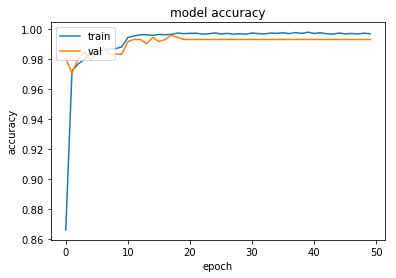

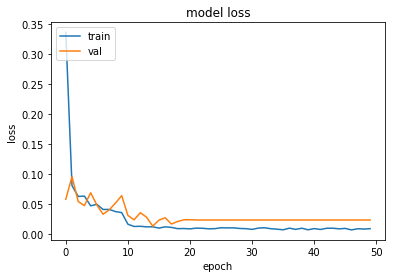

In [24]:
fit(model_name="yolo", epochs=50, model=model, datagen=datagen, X_train=X_train, X_val=X_val,
    Y_train=Y_train, Y_val=Y_val)

#### (third point out of three)

After learning model weights saves in folder `data/checkpoints/`.
Use `model.load_weights(fname)` to load best weights.

In [25]:
model.load_weights("yolo_weights")

## Detection

If you have prepared classification architecture with high validation score, you can use this architecture for detection.

Convert classification architecture to fully convolution neural network (FCNN), that returns heatmap of activation.

### Detector model or sliding window (1 point)

Now you should replace fully-connected layers with $1 \times 1$ convolution layers.

Every fully connected layer perform operation $f(Wx + b)$, where $f(\cdot)$ is nonlinear activation function, $x$ is layer input, $W$ and $b$ is layer weights. This operation can be emulated with $1 \times 1$ convolution with activation function $f(\cdot)$, that perform exactly same operation $f(Wx + b)$.

If there is `Flatten` layer with $n \times k$ input size before fully connected layers, convolution should have same $n \times k$ input size.
Multiple fully connected layers can be replaced with convolution layers sequence.

After replace all fully connected layers with convolution layers, we get fully convolution network. If input shape is equal to input size of previous network, output will have size $1 \times 1$. But if we increase input shape, output shape automatically will be increased. For example, if convolution step of previous network strides 4 pixels, increase input size with 100 pixels along all axis makes increase output size with 25 values along all axis. We got activation map of classifier without necessary extract samples from image and multiple calculate low-level features.

In total:
1. $1 \times 1$ convolution layer is equivalent of fully connected layer.
2. $1 \times 1$ convolution layers can be used to get activation map of classification network in "sliding window" manner.

We propose replace last fully connected layer with two outputs and softmax activation function with one convolution and ReLU activation. This configuration useful to find local maximum of activation map.

#### Example of replace cnn head:

##### Head before convert

![before replace image](before_convert.png)

##### Head after convert

![before replace image](after_convert.png)

On this images displayed only head. `InputLayer` should be replaced with convolution part exit.
Before convert network head takes fifty $8 \times 8$ feature maps and returns two values: probability of negative and positive classes. This output can be considered as activation map with size $1 \times 1$.

If input have size $8 \times 8$, output after convert would have $1 \times 1$ size, but input size is $44 \times 44$.
After convert network head returns one $37 \times 37$ activation map.

In [ ]:
# FCNN

IMAGE_SHAPE = (176, 176, 3)

def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    x = inputs = Input(shape=image_shape)

    # Write code here
    # ...

    # This creates a model
    predictions = Conv2D(1, (1, 1), activation='relu')(x)
    return Model(inputs=inputs, outputs=predictions)

fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

#### (1 point)

Then you should write function that copy weights from classification model to fully convolution model.
Convolution weights may be copied without modification, fully-connected layer weights should be reshaped before copy.

Pay attention to last layer.

In [ ]:
def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    # Write code here
    # ...
        
    fcnn_model.set_weights(new_fcnn_weights)

copy_weights(base_model=model, fcnn_model=fcnn_model)

### Model visualization

In [ ]:
from graph import visualize_heatmap

In [ ]:
predictions = fcnn_model.predict(np.array(val_images))
visualize_heatmap(val_images, predictions[:, :, :, 0])

### Detector (1 point)

First detector part is getting bboxes and decision function.
Greater decision function indicates better detector confidence. 

Now you need to be a little creative and implement some logic: how heatmaps will be transformed to bounding boxes. In you fcnn_model output you have heatmap of some size. You need to understand how heatmap coordinates (predictions) correlate with detecting image on the source. For example, if your model uses two poolings you need to multiply coordinates by 4.
After that you need to get the biggest signals for most certain locations of face. Hint: peak_local_max function can be useful.
Note also that evaluation process will pick the best face you detected near real one and all others will be false positives. So to improve your score you better choose just one (maybe best) face in a region of local max activations. You can also use any clusterization mechanism or non-maximum suppression technique.

In [ ]:
# Detection
from skimage.feature import peak_local_max

def get_bboxes_and_decision_function(fcnn_model, images, image_shapes):
    cropped_images = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect") for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    predictions = fcnn_model.predict(cropped_images)

    # Write code here
    # ...
        
    return pred_bboxes, decision_function

#### Detector visualization

In [ ]:
from graph import visualize_bboxes

In [ ]:
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

## Detector score (1 point)

Write [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) graph.

You can use function `best_match` to extract matching between prediction and ground truth, false positive and false negative samples. Pseudo-code for calculation precision and recall graph:
    
    # Initialization for first step threshold = -inf
    tp, fp := 0, 0 # We haven't any positive sample
    fn := |true_bboxes| # All true bboxes haven't been caught
    tn := |false_positive| # But also all false positives samples haven't been caught if threshold = -inf
    
    Sort pred_bboxes with order defined by decision_function
    y_true := List of answers for "Is the bbox have matching in y_true?" for every bbox in pred_bboxes
    
    for y_on_this_step in y_true:
        # Now we increase threshold, so some predicted bboxes makes positive.
        # If y_t is True then the bbox is true positive else bbox is false positive
        # So we should
        Update tp, tn, fp, fn with attention to y_on_this_step
        
        Add precision and recall point calculated by formula through tp, tn, fp, fn on this step

In [ ]:
from scores import best_match
from graph import plot_precision_recall

def precision_recall_curve(pred_bboxes, true_bboxes, decision_function):
    precision, recall = [], []
    
    # Write code here
    # ...
    
    return precision, recall

In [ ]:
precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Threshold (1 point)

Next step in detector creating is select threshold for decision_function.
Every possible threshold presents point on recall-precision graph.

Select threshold for `recall=0.85`.

In [ ]:
THRESHOLD = 5.9

def detect(fcnn_model, images, image_shapes, threshold=THRESHOLD, return_decision=True):
    """Get bboxes with decision_function not less then threshold."""
    pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model, images, image_shapes)   
    result, result_decision = [], []
    
    # Write code here
    # ...
    
    if return_decision:
        return result, result_decision
    else:
        return result

In [ ]:
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes, return_decision=True)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## Test dataset (1 point)

Last detector preparation step is testing.

Attention: to avoid over-fitting, after testing algorithm you should run [./prepare_data.ipynb](prepare_data.ipynb), and start all fitting from beginning.

Detection score (in graph header) should be 0.75 or greater.

In [ ]:
test_images, test_bboxes, test_shapes = load_dataset("test")
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=test_images, image_shapes=test_shapes, return_decision=True)
visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function
                )

precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=test_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## Optional tasks

### Real image dataset

Test your algorithm on original (not scaled) data.
Visualize bboxes and plot precision-recall curve.

In [ ]:
# First run will download 523 MB data from github

original_images, original_bboxes, original_shapes = load_dataset("original")

In [ ]:
# Write code here
# ...

## Hard negative mining

Upgrade the score with hard negative mining.

In [ ]:
def hard_negative(train_images, image_shapes, train_bboxes, X_val, Y_val, base_model, fcnn_model):
    pass

In [ ]:
hard_negative(train_images=train_images, image_shapes=train_shapes, train_bboxes=train_bboxes, X_val=X_val, Y_val=Y_val, base_model=model, fcnn_model=fcnn_model)

In [ ]:
# model.load_weights("data/checkpoints/...")

In [ ]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Multi scale detector

Write and test detector with [pyramid representation][pyramid].
[pyramid]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

In [ ]:
def multiscale_detector(fcnn_model, images, image_shapes):
    pass

### Next  step

Next steps in deep learning detection are R-CNN, Faster R-CNN and SSD architectures.
This architecture realization is quite complex.
For this reason the task doesn't cover them, but you can find the articles in the internet.